<a href="https://colab.research.google.com/github/Keivanrahmani/KeivanRahmani/blob/main/Mildred_Lake_2_H2S_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)
# df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Mildred Lake_Corrected_outlier.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)
df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake_all_outlier.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True)

In [ ]:
# df = pd.concat([df1,df2])
# df.index

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
aa = 'H2S (ppb)'

In [ ]:
df1_w= df1_w[[aa, 
          'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Humidity Inst. (%)',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score' ]]


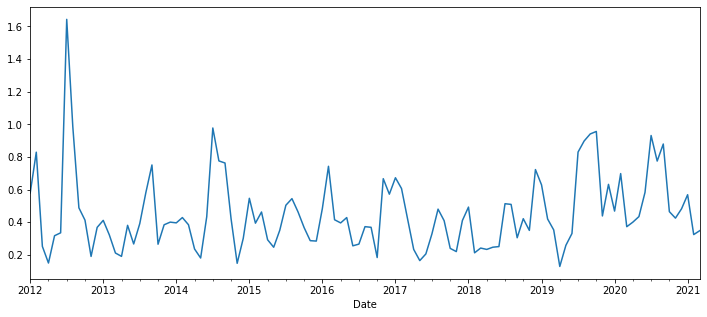

In [ ]:
df1_w[aa].resample('M').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 2*std])/len(df1_w)

0.9697012641006746

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 100.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 100.0),
        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)


        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.01, 100.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.01, 100.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)


        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.000000001000, random_state = 42)


        kf = KFold(n_splits=4)
        acc = 0 
        for train_index, test_index in kf.split(X):   
                X_tr, X_tes = X[train_index], X[test_index]
                y_tr, y_tes =  Y[train_index],  Y[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/5
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Mildredlake_OT_H2S_HP_hourly.csv')

[I 2021-05-19 04:29:51,962] A new study created in memory with name: no-name-ee901cff-f8d8-48dc-84f9-d833f5d824a4


[0]	validation-rmse:0.888735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.873017
[2]	validation-rmse:0.856571
[3]	validation-rmse:0.847767
[4]	validation-rmse:0.832713
[5]	validation-rmse:0.829635
[6]	validation-rmse:0.825138
[7]	validation-rmse:0.820954
[8]	validation-rmse:0.817916
[9]	validation-rmse:0.816643
[0]	validation-rmse:0.981747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.965967
[2]	validation-rmse:0.952355
[3]	validation-rmse:0.931666
[4]	validation-rmse:0.920904
[5]	validation-rmse:0.91343
[6]	validation-rmse:0.911412
[7]	validation-rmse:0.904862
[8]	validation-rmse:0.901611
[9]	validation-rmse:0.900563
[0]	validation-rmse:0.991614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.969927
[2]	validation-rmse:0.954373
[3]	validation-rmse:0.931584
[4]	validation-rmse:0.920878
[5]	validation-rmse:0.916965
[6]	validation-rmse:0.909081
[7]	validation-rmse:0.905979


[I 2021-05-19 04:29:52,991] Trial 0 finished with value: 0.6400594751451616 and parameters: {'booster': 'gbtree', 'lambda': 17.326468228529738, 'alpha': 21.80275868609616, 'score': 25.154828970541814, 'max_depth': 3, 'eta': 0.6669661090612033, 'gamma': 0.3052644134065364, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6400594751451616.


0.6400594751451616
[0]	validation-rmse:0.769591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.793482
[2]	validation-rmse:0.813187
[3]	validation-rmse:0.824142
[4]	validation-rmse:0.826262
[5]	validation-rmse:0.852275
[6]	validation-rmse:0.869503
[7]	validation-rmse:0.878446
[8]	validation-rmse:0.886981
[9]	validation-rmse:0.891747
[0]	validation-rmse:0.814491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.886131
[2]	validation-rmse:0.889599
[3]	validation-rmse:0.917711
[4]	validation-rmse:0.921324
[5]	validation-rmse:0.934088
[6]	validation-rmse:0.964161
[7]	validation-rmse:0.972874
[8]	validation-rmse:0.982683
[9]	validation-rmse:0.991399
[0]	validation-rmse:0.850903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.888238
[2]	validation-rmse:0.892616
[3]	validation-rmse:0.90983
[4]	validation-rmse:0.934753
[5]	validation-rmse:0.949134
[6]	validation-rmse:0.962701
[7]	valida

[I 2021-05-19 04:29:55,908] Trial 1 finished with value: 2.260468908073302 and parameters: {'booster': 'gbtree', 'lambda': 0.012170117921334971, 'alpha': 0.1919652095445088, 'score': 15.050501420676241, 'max_depth': 9, 'eta': 1.2527812545709236, 'gamma': 0.0550651976057677, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6400594751451616.


2.260468908073302
[0]	validation-rmse:0.889737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.868692
[2]	validation-rmse:0.860115
[3]	validation-rmse:0.853434
[4]	validation-rmse:0.84813
[5]	validation-rmse:0.844197
[6]	validation-rmse:0.839955
[7]	validation-rmse:0.836219
[8]	validation-rmse:0.833544
[9]	validation-rmse:0.831065
[0]	validation-rmse:1.0981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.07891
[2]	validation-rmse:1.07102
[3]	validation-rmse:1.06498
[4]	validation-rmse:1.06
[5]	validation-rmse:1.056
[6]	validation-rmse:1.05202
[7]	validation-rmse:1.04859
[8]	validation-rmse:1.04529
[9]	validation-rmse:1.0433
[0]	validation-rmse:1.08909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.07053
[2]	validation-rmse:1.06327
[3]	validation-rmse:1.05583
[4]	validation-rmse:1.0499
[5]	validation-rmse:1.04608
[6]	validation-rmse:1.04165
[7]	validation-rmse:1.03848
[8]	vali

[I 2021-05-19 04:29:56,554] Trial 2 finished with value: 0.6826849936467897 and parameters: {'booster': 'gbtree', 'lambda': 0.24121831242338865, 'alpha': 0.03633756481545512, 'score': 26.288748634919443, 'max_depth': 1, 'eta': 0.9170429718434896, 'gamma': 28.650703621336582, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6400594751451616.


0.6826849936467897
[0]	validation-rmse:0.894392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.885576
[2]	validation-rmse:0.876352
[3]	validation-rmse:0.867584
[4]	validation-rmse:0.86017
[5]	validation-rmse:0.853802
[6]	validation-rmse:0.84812
[7]	validation-rmse:0.840893
[8]	validation-rmse:0.836125
[9]	validation-rmse:0.831318
[0]	validation-rmse:0.977054
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.964253
[2]	validation-rmse:0.953269
[3]	validation-rmse:0.942995
[4]	validation-rmse:0.934422
[5]	validation-rmse:0.925673
[6]	validation-rmse:0.917048
[7]	validation-rmse:0.910013
[8]	validation-rmse:0.903879
[9]	validation-rmse:0.896724
[0]	validation-rmse:1.00782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.996064
[2]	validation-rmse:0.984643
[3]	validation-rmse:0.974363
[4]	validation-rmse:0.964316
[5]	validation-rmse:0.955596
[6]	validation-rmse:0.947464
[7]	validati

[I 2021-05-19 04:29:58,489] Trial 3 finished with value: 0.6658856269324939 and parameters: {'booster': 'gbtree', 'lambda': 0.6525381799727905, 'alpha': 0.63760342446904, 'score': 16.872970271051017, 'max_depth': 6, 'eta': 0.050402246752138974, 'gamma': 70.9947869100767, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.6400594751451616.


0.6658856269324939
[0]	validation-rmse:0.877208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.860214
[2]	validation-rmse:0.85364
[3]	validation-rmse:0.84634
[4]	validation-rmse:0.840723
[5]	validation-rmse:0.835493
[6]	validation-rmse:0.831499
[7]	validation-rmse:0.82844
[8]	validation-rmse:0.82542
[9]	validation-rmse:0.822865
[0]	validation-rmse:0.94701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.93159
[2]	validation-rmse:0.925463
[3]	validation-rmse:0.919358
[4]	validation-rmse:0.914747
[5]	validation-rmse:0.910328
[6]	validation-rmse:0.90689
[7]	validation-rmse:0.903433
[8]	validation-rmse:0.901601
[9]	validation-rmse:0.899467
[0]	validation-rmse:0.97153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.958527
[2]	validation-rmse:0.951924
[3]	validation-rmse:0.945362
[4]	validation-rmse:0.939531
[5]	validation-rmse:0.935809
[6]	validation-rmse:0.931965
[7]	validation-rm

[I 2021-05-19 04:29:59,121] Trial 4 finished with value: 0.6691658503581355 and parameters: {'booster': 'gbtree', 'lambda': 4.34796615948512, 'alpha': 42.13953992531671, 'score': 17.23511841431292, 'max_depth': 1, 'eta': 0.6885941489025312, 'gamma': 0.1887722697164142, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6400594751451616.


0.6691658503581355


[I 2021-05-19 04:29:59,206] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:29:59,334] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:29:59,440] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.766754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.728822
[2]	validation-rmse:0.711529
[3]	validation-rmse:0.692585
[4]	validation-rmse:0.687145
[5]	validation-rmse:0.6829
[6]	validation-rmse:0.680904
[7]	validation-rmse:0.675778
[8]	validation-rmse:0.675702
[9]	validation-rmse:0.674317
[0]	validation-rmse:0.821505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.760138
[2]	validation-rmse:0.731512
[3]	validation-rmse:0.721995
[4]	validation-rmse:0.716836
[5]	validation-rmse:0.712
[6]	validation-rmse:0.70734
[7]	validation-rmse:0.702132
[8]	validation-rmse:0.701076
[9]	validation-rmse:0.697437
[0]	validation-rmse:0.858022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.817043
[2]	validation-rmse:0.775923
[3]	validation-rmse:0.761161
[4]	validation-rmse:0.755666
[5]	validation-rmse:0.746999
[6]	validation-rmse:0.742731
[7]	validation-rmse:0.740534
[8]	v

[I 2021-05-19 04:30:02,994] Trial 8 finished with value: 0.6237707828712775 and parameters: {'booster': 'gbtree', 'lambda': 51.18962352856045, 'alpha': 0.056424526617994616, 'score': 23.256155716097922, 'max_depth': 10, 'eta': 0.8205911841625516, 'gamma': 0.2762214218081538, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.6237707828712775.


0.6237707828712775
[0]	validation-rmse:0.851344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82464
[2]	validation-rmse:0.813699
[3]	validation-rmse:0.807417
[4]	validation-rmse:0.805748
[5]	validation-rmse:0.803121
[6]	validation-rmse:0.799821
[7]	validation-rmse:0.795432
[8]	validation-rmse:0.794288
[9]	validation-rmse:0.792325
[0]	validation-rmse:0.988235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.963537
[2]	validation-rmse:0.955053
[3]	validation-rmse:0.952518
[4]	validation-rmse:0.949535
[5]	validation-rmse:0.945337
[6]	validation-rmse:0.943421
[7]	validation-rmse:0.940944
[8]	validation-rmse:0.941186
[9]	validation-rmse:0.937349
[0]	validation-rmse:1.01228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.989285
[2]	validation-rmse:0.98133
[3]	validation-rmse:0.973987
[4]	validation-rmse:0.971322
[5]	validation-rmse:0.968159
[6]	validation-rmse:0.963577
[7]	validati

[I 2021-05-19 04:30:03,652] Trial 9 finished with value: 0.6843445097905333 and parameters: {'booster': 'gbtree', 'lambda': 54.85481471959237, 'alpha': 0.026802317352896413, 'score': 25.504536874117687, 'max_depth': 1, 'eta': 1.3466803252522614, 'gamma': 0.14154215752240937, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 0.6237707828712775.


0.6843445097905333
[0]	validation-rmse:0.845397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82984
[2]	validation-rmse:0.814764
[3]	validation-rmse:0.801147
[4]	validation-rmse:0.788921
[5]	validation-rmse:0.776518
[6]	validation-rmse:0.764572
[7]	validation-rmse:0.75359
[8]	validation-rmse:0.744316
[9]	validation-rmse:0.735314
[0]	validation-rmse:0.965383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.946969
[2]	validation-rmse:0.930606
[3]	validation-rmse:0.915061
[4]	validation-rmse:0.90019
[5]	validation-rmse:0.887843
[6]	validation-rmse:0.87519
[7]	validation-rmse:0.863681
[8]	validation-rmse:0.852751
[9]	validation-rmse:0.84394
[0]	validation-rmse:1.01248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.994959
[2]	validation-rmse:0.976018
[3]	validation-rmse:0.960508
[4]	validation-rmse:0.947019
[5]	validation-rmse:0.933666
[6]	validation-rmse:0.921125
[7]	validation-

[I 2021-05-19 04:30:07,522] Trial 10 finished with value: 0.6475107426970316 and parameters: {'booster': 'gbtree', 'lambda': 0.04126477133934195, 'alpha': 6.120464027284154, 'score': 21.72367800902702, 'max_depth': 10, 'eta': 0.05997302575527045, 'gamma': 4.82127626500377, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.6237707828712775.


0.6475107426970316


[I 2021-05-19 04:30:07,620] Trial 11 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.815679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.799686
[2]	validation-rmse:0.788232
[3]	validation-rmse:0.779171
[4]	validation-rmse:0.768781
[5]	validation-rmse:0.761934
[6]	validation-rmse:0.756353
[7]	validation-rmse:0.751757
[8]	validation-rmse:0.746534
[9]	validation-rmse:0.742838
[0]	validation-rmse:0.970735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.95725
[2]	validation-rmse:0.946386
[3]	validation-rmse:0.933879
[4]	validation-rmse:0.923494
[5]	validation-rmse:0.91727
[6]	validation-rmse:0.913208
[7]	validation-rmse:0.905311
[8]	validation-rmse:0.898385
[9]	validation-rmse:0.894136
[0]	validation-rmse:0.982253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.962996
[2]	validation-rmse:0.948643
[3]	validation-rmse:0.939364
[4]	validation-rmse:0.930665
[5]	validation-rmse:0.924722
[6]	validation-rmse:0.916608
[7]	validation-rmse:0.911525
[

[I 2021-05-19 04:30:08,679] Trial 12 finished with value: 0.6579872863794594 and parameters: {'booster': 'gbtree', 'lambda': 13.884197397781048, 'alpha': 5.280664515911647, 'score': 28.74114729437856, 'max_depth': 3, 'eta': 0.1869300300750681, 'gamma': 1.9862232438214655, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 0.6237707828712775.


0.6579872863794594


[I 2021-05-19 04:30:08,778] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.829483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787794
[2]	validation-rmse:0.759274
[3]	validation-rmse:0.732127
[4]	validation-rmse:0.714762
[5]	validation-rmse:0.703555
[6]	validation-rmse:0.695593
[7]	validation-rmse:0.689101
[8]	validation-rmse:0.682614
[9]	validation-rmse:0.679436
[0]	validation-rmse:0.997019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.948148
[2]	validation-rmse:0.91205
[3]	validation-rmse:0.883911
[4]	validation-rmse:0.862064
[5]	validation-rmse:0.845206
[6]	validation-rmse:0.832117
[7]	validation-rmse:0.823478
[8]	validation-rmse:0.81634
[9]	validation-rmse:0.806618
[0]	validation-rmse:1.01999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.968447
[2]	validation-rmse:0.930708
[3]	validation-rmse:0.904775
[4]	validation-rmse:0.883087
[5]	validation-rmse:0.86452
[6]	validation-rmse:0.852902
[7]	validation-rmse:0.845396
[8]

[I 2021-05-19 04:30:11,190] Trial 14 finished with value: 0.6082019389118952 and parameters: {'booster': 'gbtree', 'lambda': 8.297541432718933, 'alpha': 1.6385205793719846, 'score': 26.841639984520665, 'max_depth': 7, 'eta': 0.2197548880114122, 'gamma': 0.9298401853146957, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 0.6082019389118952.


0.6082019389118952


[I 2021-05-19 04:30:11,328] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.833183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.790996
[2]	validation-rmse:0.757384
[3]	validation-rmse:0.732861
[4]	validation-rmse:0.713709
[5]	validation-rmse:0.70168
[6]	validation-rmse:0.691274
[7]	validation-rmse:0.68586
[8]	validation-rmse:0.679053
[9]	validation-rmse:0.675175
[0]	validation-rmse:0.940548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.891192
[2]	validation-rmse:0.851024
[3]	validation-rmse:0.821991
[4]	validation-rmse:0.798458
[5]	validation-rmse:0.78404
[6]	validation-rmse:0.771295
[7]	validation-rmse:0.760336
[8]	validation-rmse:0.74907
[9]	validation-rmse:0.741457
[0]	validation-rmse:0.987151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.940253
[2]	validation-rmse:0.900331
[3]	validation-rmse:0.870798
[4]	validation-rmse:0.84645
[5]	validation-rmse:0.830225
[6]	validation-rmse:0.815775
[7]	validation-rmse:0.805245
[8]	

[I 2021-05-19 04:30:15,100] Trial 16 finished with value: 0.6030227150727538 and parameters: {'booster': 'gbtree', 'lambda': 0.9980161777987996, 'alpha': 0.18146365932574618, 'score': 23.065020904534535, 'max_depth': 10, 'eta': 0.18177946313285498, 'gamma': 10.390997785538117, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 0.6030227150727538.


0.6030227150727538


[I 2021-05-19 04:30:15,222] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:15,370] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.823484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.778314
[2]	validation-rmse:0.74939
[3]	validation-rmse:0.733064
[4]	validation-rmse:0.720758
[5]	validation-rmse:0.710941
[6]	validation-rmse:0.70371
[7]	validation-rmse:0.696388
[8]	validation-rmse:0.692659
[9]	validation-rmse:0.688149
[0]	validation-rmse:0.938273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.883184
[2]	validation-rmse:0.852975
[3]	validation-rmse:0.828466
[4]	validation-rmse:0.810209
[5]	validation-rmse:0.797359
[6]	validation-rmse:0.791738
[7]	validation-rmse:0.784728
[8]	validation-rmse:0.781614
[9]	validation-rmse:0.776348
[0]	validation-rmse:0.9508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.906335
[2]	validation-rmse:0.864567
[3]	validation-rmse:0.841335
[4]	validation-rmse:0.817612
[5]	validation-rmse:0.803975
[6]	validation-rmse:0.791759
[7]	validation-rmse:0.785087
[8]

[I 2021-05-19 04:30:17,797] Trial 19 finished with value: 0.5963299291325475 and parameters: {'booster': 'gbtree', 'lambda': 0.2087265852185169, 'alpha': 2.2507783864242548, 'score': 20.173268089926417, 'max_depth': 7, 'eta': 0.26433385432146345, 'gamma': 1.0456315709589918, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.5963299291325475


[I 2021-05-19 04:30:17,943] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.833487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.793315
[2]	validation-rmse:0.766681
[3]	validation-rmse:0.746081
[4]	validation-rmse:0.728975
[5]	validation-rmse:0.717194
[6]	validation-rmse:0.710884
[7]	validation-rmse:0.705137
[8]	validation-rmse:0.698591
[9]	validation-rmse:0.693838
[0]	validation-rmse:0.921247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.868303
[2]	validation-rmse:0.836102
[3]	validation-rmse:0.815319
[4]	validation-rmse:0.791169
[5]	validation-rmse:0.778611
[6]	validation-rmse:0.767642
[7]	validation-rmse:0.760386
[8]	validation-rmse:0.755484
[9]	validation-rmse:0.75257
[0]	validation-rmse:0.942019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.893972
[2]	validation-rmse:0.859191
[3]	validation-rmse:0.831987
[4]	validation-rmse:0.814249
[5]	validation-rmse:0.801923
[6]	validation-rmse:0.792671
[7]	validation-rmse:0.781148


[I 2021-05-19 04:30:20,347] Trial 21 finished with value: 0.6612955807796352 and parameters: {'booster': 'gbtree', 'lambda': 0.22009024975457636, 'alpha': 1.9019518069895454, 'score': 20.81111782637571, 'max_depth': 7, 'eta': 0.23764614907435527, 'gamma': 1.0039993585981775, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6612955807796352
[0]	validation-rmse:0.799542
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.758538
[2]	validation-rmse:0.735171
[3]	validation-rmse:0.716146
[4]	validation-rmse:0.702814
[5]	validation-rmse:0.692775
[6]	validation-rmse:0.687479
[7]	validation-rmse:0.683607
[8]	validation-rmse:0.678206
[9]	validation-rmse:0.674947
[0]	validation-rmse:0.950601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.904065
[2]	validation-rmse:0.874524
[3]	validation-rmse:0.853786
[4]	validation-rmse:0.833066
[5]	validation-rmse:0.822098
[6]	validation-rmse:0.812027
[7]	validation-rmse:0.807716
[8]	validation-rmse:0.798509
[9]	validation-rmse:0.793986
[0]	validation-rmse:0.985832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.931868
[2]	validation-rmse:0.898843
[3]	validation-rmse:0.879172
[4]	validation-rmse:0.862071
[5]	validation-rmse:0.853115
[6]	validation-rmse:0.843541
[7]	valid

[I 2021-05-19 04:30:22,713] Trial 22 finished with value: 0.856266552632156 and parameters: {'booster': 'gbtree', 'lambda': 1.568311882617572, 'alpha': 1.7886209580978558, 'score': 18.349739406540557, 'max_depth': 7, 'eta': 0.2940352450617414, 'gamma': 1.1128439954285325, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.856266552632156


[I 2021-05-19 04:30:22,817] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:22,952] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:23,061] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:23,222] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:23,340] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.788764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.743571
[2]	validation-rmse:0.720422
[3]	validation-rmse:0.706711
[4]	validation-rmse:0.685173
[5]	validation-rmse:0.679141
[6]	validation-rmse:0.674184
[7]	validation-rmse:0.670719
[8]	validation-rmse:0.670129
[9]	validation-rmse:0.665207
[0]	validation-rmse:0.967255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.904596
[2]	validation-rmse:0.870409
[3]	validation-rmse:0.851909
[4]	validation-rmse:0.844939
[5]	validation-rmse:0.829754
[6]	validation-rmse:0.816975
[7]	validation-rmse:0.810466
[8]	validation-rmse:0.801924
[9]	validation-rmse:0.799959
[0]	validation-rmse:1.02241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.947719
[2]	validation-rmse:0.918951
[3]	validation-rmse:0.902654
[4]	validation-rmse:0.890642
[5]	validation-rmse:0.880516
[6]	validation-rmse:0.867118
[7]	validation-rmse:0.857751


[I 2021-05-19 04:30:25,637] Trial 28 finished with value: 0.6191733171400875 and parameters: {'booster': 'gbtree', 'lambda': 0.08775773928868527, 'alpha': 0.9666481966209409, 'score': 18.486711960956654, 'max_depth': 7, 'eta': 0.42490066561380585, 'gamma': 2.097980695928249, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6191733171400875


[I 2021-05-19 04:30:25,778] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:25,921] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.765675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.719381
[2]	validation-rmse:0.691507
[3]	validation-rmse:0.680048
[4]	validation-rmse:0.66487
[5]	validation-rmse:0.65803
[6]	validation-rmse:0.651513
[7]	validation-rmse:0.648289
[8]	validation-rmse:0.642097
[9]	validation-rmse:0.63957
[0]	validation-rmse:0.862664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.801116
[2]	validation-rmse:0.773523
[3]	validation-rmse:0.763255
[4]	validation-rmse:0.751309
[5]	validation-rmse:0.742393
[6]	validation-rmse:0.734247
[7]	validation-rmse:0.723458
[8]	validation-rmse:0.724235
[9]	validation-rmse:0.718996
[0]	validation-rmse:0.881258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.820345
[2]	validation-rmse:0.793541
[3]	validation-rmse:0.771405
[4]	validation-rmse:0.756274
[5]	validation-rmse:0.750905
[6]	validation-rmse:0.74743
[7]	validation-rmse:0.744527
[8]

[I 2021-05-19 04:30:28,196] Trial 31 finished with value: 0.8171972647127437 and parameters: {'booster': 'gbtree', 'lambda': 0.08963031429946064, 'alpha': 0.01032654952422748, 'score': 18.588117237410643, 'max_depth': 7, 'eta': 0.4368215081078771, 'gamma': 1.8449325263251772, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.8171972647127437
[0]	validation-rmse:0.77849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.733048
[2]	validation-rmse:0.70938
[3]	validation-rmse:0.701038
[4]	validation-rmse:0.688449
[5]	validation-rmse:0.68137
[6]	validation-rmse:0.676117
[7]	validation-rmse:0.673396
[8]	validation-rmse:0.670588
[9]	validation-rmse:0.669811
[0]	validation-rmse:0.859998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.798721
[2]	validation-rmse:0.767308
[3]	validation-rmse:0.753221
[4]	validation-rmse:0.740589
[5]	validation-rmse:0.735229
[6]	validation-rmse:0.731376
[7]	validation-rmse:0.727062
[8]	validation-rmse:0.717241
[9]	validation-rmse:0.71369
[0]	validation-rmse:0.921834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.850022
[2]	validation-rmse:0.827802
[3]	validation-rmse:0.813167
[4]	validation-rmse:0.812966
[5]	validation-rmse:0.805231
[6]	validation-rmse:0.799824
[7]	validatio

[I 2021-05-19 04:30:30,494] Trial 32 finished with value: 1.014662509669266 and parameters: {'booster': 'gbtree', 'lambda': 0.02815358906011559, 'alpha': 0.9136459601457083, 'score': 17.905383901852538, 'max_depth': 7, 'eta': 0.45256783193097383, 'gamma': 2.4471525945341854, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


1.014662509669266


[I 2021-05-19 04:30:30,611] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.774527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.757579
[2]	validation-rmse:0.762938


[I 2021-05-19 04:30:30,814] Trial 34 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:30:30,948] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:31,063] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:31,210] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:31,339] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.803477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.784931


[I 2021-05-19 04:30:31,457] Trial 39 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.811567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.766158
[2]	validation-rmse:0.746433
[3]	validation-rmse:0.730738
[4]	validation-rmse:0.72139
[5]	validation-rmse:0.712931
[6]	validation-rmse:0.71005


[I 2021-05-19 04:30:32,011] Trial 40 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:0.790582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.758532
[2]	validation-rmse:0.739204
[3]	validation-rmse:0.732709


[I 2021-05-19 04:30:32,514] Trial 41 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:30:32,669] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.780147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.729889
[2]	validation-rmse:0.70134
[3]	validation-rmse:0.687704
[4]	validation-rmse:0.681145
[5]	validation-rmse:0.674036
[6]	validation-rmse:0.666788
[7]	validation-rmse:0.661147
[8]	validation-rmse:0.655175
[9]	validation-rmse:0.651359
[0]	validation-rmse:0.953737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.864937
[2]	validation-rmse:0.827466
[3]	validation-rmse:0.807574
[4]	validation-rmse:0.790398
[5]	validation-rmse:0.779833
[6]	validation-rmse:0.774201
[7]	validation-rmse:0.770317
[8]	validation-rmse:0.760759
[9]	validation-rmse:0.755396
[0]	validation-rmse:0.974424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.897213
[2]	validation-rmse:0.843783
[3]	validation-rmse:0.814705
[4]	validation-rmse:0.797743
[5]	validation-rmse:0.787822
[6]	validation-rmse:0.780472
[7]	validation-rmse:0.770532


[I 2021-05-19 04:30:35,929] Trial 43 finished with value: 0.6716325960836549 and parameters: {'booster': 'gbtree', 'lambda': 0.06050282631582815, 'alpha': 0.013611328901117508, 'score': 26.25759209007346, 'max_depth': 9, 'eta': 0.31275138856932516, 'gamma': 0.37338914808434637, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6716325960836549
[0]	validation-rmse:0.771908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.733607
[2]	validation-rmse:0.71362
[3]	validation-rmse:0.693368
[4]	validation-rmse:0.686974
[5]	validation-rmse:0.679663
[6]	validation-rmse:0.673867
[7]	validation-rmse:0.668742
[8]	validation-rmse:0.66777
[9]	validation-rmse:0.666336
[0]	validation-rmse:0.964237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.910295
[2]	validation-rmse:0.866164
[3]	validation-rmse:0.839924
[4]	validation-rmse:0.827396
[5]	validation-rmse:0.814844
[6]	validation-rmse:0.805727
[7]	validation-rmse:0.803966
[8]	validation-rmse:0.800634
[9]	validation-rmse:0.794995
[0]	validation-rmse:0.996917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.924946
[2]	validation-rmse:0.889233
[3]	validation-rmse:0.874794
[4]	validation-rmse:0.859112
[5]	validation-rmse:0.850037
[6]	validation-rmse:0.843424
[7]	validat

[I 2021-05-19 04:30:39,550] Trial 44 finished with value: 0.6030563224867761 and parameters: {'booster': 'gbtree', 'lambda': 70.24083552906967, 'alpha': 0.03831888627685091, 'score': 21.11337635603449, 'max_depth': 10, 'eta': 0.7012987798744392, 'gamma': 0.7222008928086608, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6030563224867761


[I 2021-05-19 04:30:39,664] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.812331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.788992


[I 2021-05-19 04:30:39,926] Trial 46 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.757895
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.716718
[2]	validation-rmse:0.704192
[3]	validation-rmse:0.693974
[4]	validation-rmse:0.691202
[5]	validation-rmse:0.68952
[6]	validation-rmse:0.686351
[7]	validation-rmse:0.682845
[8]	validation-rmse:0.681054
[9]	validation-rmse:0.680062
[0]	validation-rmse:0.857334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.802964
[2]	validation-rmse:0.78137
[3]	validation-rmse:0.769856
[4]	validation-rmse:0.764029
[5]	validation-rmse:0.760666
[6]	validation-rmse:0.763214
[7]	validation-rmse:0.760092
[8]	validation-rmse:0.759573
[9]	validation-rmse:0.759347
[0]	validation-rmse:0.908256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.849609
[2]	validation-rmse:0.835563
[3]	validation-rmse:0.824803
[4]	validation-rmse:0.806806
[5]	validation-rmse:0.802638
[6]	validation-rmse:0.801262
[7]	validation-rmse:0.799758
[

[I 2021-05-19 04:30:43,010] Trial 47 finished with value: 0.660206643754969 and parameters: {'booster': 'gbtree', 'lambda': 6.86816654362592, 'alpha': 0.5814193601664327, 'score': 21.797242200142936, 'max_depth': 9, 'eta': 0.7001593335795733, 'gamma': 0.7071946866364648, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.5963299291325475.


0.660206643754969
[0]	validation-rmse:0.731797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677546
[2]	validation-rmse:0.65902
[3]	validation-rmse:0.648897
[4]	validation-rmse:0.640723
[5]	validation-rmse:0.638489
[6]	validation-rmse:0.634971
[7]	validation-rmse:0.633776
[8]	validation-rmse:0.629213
[9]	validation-rmse:0.628507
[0]	validation-rmse:0.878132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805319
[2]	validation-rmse:0.778253
[3]	validation-rmse:0.761773
[4]	validation-rmse:0.750513
[5]	validation-rmse:0.742265
[6]	validation-rmse:0.736816
[7]	validation-rmse:0.731908
[8]	validation-rmse:0.728379
[9]	validation-rmse:0.724416
[0]	validation-rmse:0.945501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.869702
[2]	validation-rmse:0.849308
[3]	validation-rmse:0.828317
[4]	validation-rmse:0.815795
[5]	validation-rmse:0.812874
[6]	validation-rmse:0.808945
[7]	validat

[I 2021-05-19 04:30:46,673] Trial 48 finished with value: 0.7101080315226119 and parameters: {'booster': 'gbtree', 'lambda': 0.16315787278411523, 'alpha': 0.22081524633080035, 'score': 18.99239427926645, 'max_depth': 10, 'eta': 0.3826620021846628, 'gamma': 0.1406514375026175, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.7101080315226119


[I 2021-05-19 04:30:46,797] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:46,897] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.763164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.715551
[2]	validation-rmse:0.695455
[3]	validation-rmse:0.685185
[4]	validation-rmse:0.675559
[5]	validation-rmse:0.669429
[6]	validation-rmse:0.664924
[7]	validation-rmse:0.661964
[8]	validation-rmse:0.657806
[9]	validation-rmse:0.655245
[0]	validation-rmse:0.868297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.810173
[2]	validation-rmse:0.797594
[3]	validation-rmse:0.777982
[4]	validation-rmse:0.765546
[5]	validation-rmse:0.757702
[6]	validation-rmse:0.75565
[7]	validation-rmse:0.7509
[8]	validation-rmse:0.746212
[9]	validation-rmse:0.745475
[0]	validation-rmse:0.897033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.840204
[2]	validation-rmse:0.825244
[3]	validation-rmse:0.802992
[4]	validation-rmse:0.790577
[5]	validation-rmse:0.782344
[6]	validation-rmse:0.7794
[7]	validation-rmse:0.774363
[8]	

[I 2021-05-19 04:30:50,584] Trial 51 finished with value: 0.6066539433713936 and parameters: {'booster': 'gbtree', 'lambda': 56.908859811247034, 'alpha': 0.05806441278602434, 'score': 23.629244012447533, 'max_depth': 10, 'eta': 0.6751922596796519, 'gamma': 0.3941521934473734, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6066539433713936
[0]	validation-rmse:0.788615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.738674
[2]	validation-rmse:0.71395
[3]	validation-rmse:0.698378
[4]	validation-rmse:0.683897
[5]	validation-rmse:0.675973
[6]	validation-rmse:0.671584
[7]	validation-rmse:0.665024
[8]	validation-rmse:0.65825
[9]	validation-rmse:0.656976
[0]	validation-rmse:0.921519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.87014
[2]	validation-rmse:0.835988
[3]	validation-rmse:0.819215
[4]	validation-rmse:0.807447
[5]	validation-rmse:0.796792
[6]	validation-rmse:0.790055
[7]	validation-rmse:0.786741
[8]	validation-rmse:0.783247
[9]	validation-rmse:0.780493
[0]	validation-rmse:0.932361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.871613
[2]	validation-rmse:0.852076
[3]	validation-rmse:0.831848
[4]	validation-rmse:0.820887
[5]	validation-rmse:0.808379
[6]	validation-rmse:0.804231
[7]	validati

[I 2021-05-19 04:30:54,222] Trial 52 finished with value: 0.6114426753394944 and parameters: {'booster': 'gbtree', 'lambda': 65.2016554773464, 'alpha': 0.016867261247886935, 'score': 25.865664320939352, 'max_depth': 10, 'eta': 0.6139663035527234, 'gamma': 0.4147322359969644, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6114426753394944
[0]	validation-rmse:0.791576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.746894
[2]	validation-rmse:0.729301
[3]	validation-rmse:0.7263


[I 2021-05-19 04:30:54,730] Trial 53 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:30:54,888] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:55,035] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:55,194] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:55,348] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:55,509] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.791878
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.764993


[I 2021-05-19 04:30:55,841] Trial 59 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:30:55,986] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.798232
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.751067
[2]	validation-rmse:0.734695
[3]	validation-rmse:0.720199
[4]	validation-rmse:0.712013


[I 2021-05-19 04:30:56,436] Trial 61 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.755113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.726341
[2]	validation-rmse:0.703131
[3]	validation-rmse:0.686714
[4]	validation-rmse:0.681606
[5]	validation-rmse:0.680295
[6]	validation-rmse:0.675166
[7]	validation-rmse:0.676851
[8]	validation-rmse:0.675703
[9]	validation-rmse:0.674631
[0]	validation-rmse:0.874564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827868
[2]	validation-rmse:0.800327
[3]	validation-rmse:0.791729
[4]	validation-rmse:0.782152
[5]	validation-rmse:0.772702
[6]	validation-rmse:0.769563
[7]	validation-rmse:0.771178
[8]	validation-rmse:0.773882
[9]	validation-rmse:0.771422
[0]	validation-rmse:0.911351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.869431
[2]	validation-rmse:0.845389
[3]	validation-rmse:0.838109
[4]	validation-rmse:0.837339
[5]	validation-rmse:0.835977
[6]	validation-rmse:0.834709
[7]	validation-rmse:0.830726

[I 2021-05-19 04:30:59,070] Trial 62 finished with value: 0.6758996021482765 and parameters: {'booster': 'gbtree', 'lambda': 14.84702585530076, 'alpha': 0.07700571280229734, 'score': 25.613300155194768, 'max_depth': 8, 'eta': 0.8998770819919206, 'gamma': 1.065070954913911, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6758996021482765


[I 2021-05-19 04:30:59,178] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:59,302] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:30:59,422] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.75181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.71304
[2]	validation-rmse:0.698546
[3]	validation-rmse:0.696961
[4]	validation-rmse:0.695545
[5]	validation-rmse:0.691527


[I 2021-05-19 04:31:00,083] Trial 66 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:31:00,225] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:00,354] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.760999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.729644
[2]	validation-rmse:0.715872
[3]	validation-rmse:0.698696
[4]	validation-rmse:0.69395
[5]	validation-rmse:0.697318


[I 2021-05-19 04:31:00,839] Trial 69 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:31:00,954] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.785664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.740796
[2]	validation-rmse:0.727536


[I 2021-05-19 04:31:01,387] Trial 71 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.749358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703938
[2]	validation-rmse:0.681299
[3]	validation-rmse:0.668007
[4]	validation-rmse:0.661393
[5]	validation-rmse:0.656576
[6]	validation-rmse:0.650782
[7]	validation-rmse:0.646294
[8]	validation-rmse:0.643841
[9]	validation-rmse:0.641518
[0]	validation-rmse:0.851974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787343
[2]	validation-rmse:0.756796
[3]	validation-rmse:0.739579
[4]	validation-rmse:0.721209
[5]	validation-rmse:0.709726
[6]	validation-rmse:0.700824
[7]	validation-rmse:0.694088
[8]	validation-rmse:0.688182
[9]	validation-rmse:0.686022
[0]	validation-rmse:0.902053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.829256
[2]	validation-rmse:0.792187
[3]	validation-rmse:0.772806
[4]	validation-rmse:0.7571
[5]	validation-rmse:0.746251
[6]	validation-rmse:0.736035
[7]	validation-rmse:0.730969
[

[I 2021-05-19 04:31:04,588] Trial 72 finished with value: 0.6235826188908788 and parameters: {'booster': 'gbtree', 'lambda': 31.142771700315937, 'alpha': 0.023974466862810875, 'score': 23.002913289305432, 'max_depth': 9, 'eta': 0.4852254725237741, 'gamma': 0.46583926084744176, 'grow_policy': 'lossguide'}. Best is trial 19 with value: 0.5963299291325475.


0.6235826188908788
[0]	validation-rmse:0.774715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.732129
[2]	validation-rmse:0.709834
[3]	validation-rmse:0.694358
[4]	validation-rmse:0.683972
[5]	validation-rmse:0.676738
[6]	validation-rmse:0.671949
[7]	validation-rmse:0.666604
[8]	validation-rmse:0.660937
[9]	validation-rmse:0.656882
[0]	validation-rmse:0.895128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.841496
[2]	validation-rmse:0.814167
[3]	validation-rmse:0.787696
[4]	validation-rmse:0.771725
[5]	validation-rmse:0.762901
[6]	validation-rmse:0.754073
[7]	validation-rmse:0.745476
[8]	validation-rmse:0.743723
[9]	validation-rmse:0.739854
[0]	validation-rmse:0.933369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.880534
[2]	validation-rmse:0.843812
[3]	validation-rmse:0.826479
[4]	validation-rmse:0.806892
[5]	validation-rmse:0.795294
[6]	validation-rmse:0.785093
[7]	valid

[I 2021-05-19 04:31:07,810] Trial 73 finished with value: 0.5897009270797563 and parameters: {'booster': 'gbtree', 'lambda': 99.59280719176881, 'alpha': 0.023715505117083868, 'score': 23.788645867242337, 'max_depth': 9, 'eta': 0.5142240834464399, 'gamma': 0.9922302698928357, 'grow_policy': 'lossguide'}. Best is trial 73 with value: 0.5897009270797563.


0.5897009270797563


[I 2021-05-19 04:31:07,959] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:08,123] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:08,248] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:08,408] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:08,543] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.779625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.719479
[2]	validation-rmse:0.701083
[3]	validation-rmse:0.684528
[4]	validation-rmse:0.680109
[5]	validation-rmse:0.678509
[6]	validation-rmse:0.677838
[7]	validation-rmse:0.675783
[8]	validation-rmse:0.676567


[I 2021-05-19 04:31:09,324] Trial 79 pruned. Trial was pruned at iteration 9.
[I 2021-05-19 04:31:09,483] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:09,631] Trial 81 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.781193
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.724248
[2]	validation-rmse:0.702725
[3]	validation-rmse:0.68876
[4]	validation-rmse:0.679179
[5]	validation-rmse:0.668062
[6]	validation-rmse:0.663913
[7]	validation-rmse:0.661544
[8]	validation-rmse:0.656394
[9]	validation-rmse:0.653874
[0]	validation-rmse:0.868851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.807558
[2]	validation-rmse:0.77891
[3]	validation-rmse:0.75695
[4]	validation-rmse:0.742474
[5]	validation-rmse:0.736487
[6]	validation-rmse:0.729302
[7]	validation-rmse:0.722184
[8]	validation-rmse:0.718153
[9]	validation-rmse:0.715593
[0]	validation-rmse:0.912177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.843033
[2]	validation-rmse:0.814432
[3]	validation-rmse:0.791603
[4]	validation-rmse:0.778447
[5]	validation-rmse:0.766463
[6]	validation-rmse:0.755818
[7]	validation-rmse:0.752354
[8

[I 2021-05-19 04:31:12,762] Trial 82 finished with value: 0.6017223911416627 and parameters: {'booster': 'gbtree', 'lambda': 44.76570727475717, 'alpha': 0.024263293943616374, 'score': 23.08547160305766, 'max_depth': 9, 'eta': 0.5555927661867778, 'gamma': 0.9738191292747795, 'grow_policy': 'lossguide'}. Best is trial 73 with value: 0.5897009270797563.


0.6017223911416627
[0]	validation-rmse:0.729825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695571
[2]	validation-rmse:0.68429
[3]	validation-rmse:0.679719
[4]	validation-rmse:0.673205
[5]	validation-rmse:0.670509
[6]	validation-rmse:0.6684
[7]	validation-rmse:0.666994
[8]	validation-rmse:0.665228
[9]	validation-rmse:0.667839
[0]	validation-rmse:0.823443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.759363
[2]	validation-rmse:0.751633
[3]	validation-rmse:0.741098
[4]	validation-rmse:0.736623
[5]	validation-rmse:0.735273
[6]	validation-rmse:0.729492
[7]	validation-rmse:0.727088
[8]	validation-rmse:0.724498
[9]	validation-rmse:0.719981
[0]	validation-rmse:0.855531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.798815
[2]	validation-rmse:0.7842
[3]	validation-rmse:0.767428
[4]	validation-rmse:0.758732
[5]	validation-rmse:0.756736
[6]	validation-rmse:0.75491
[7]	validation-

[I 2021-05-19 04:31:16,347] Trial 83 finished with value: 0.6786456361769506 and parameters: {'booster': 'gbtree', 'lambda': 69.16702548568227, 'alpha': 0.03237324819044005, 'score': 21.65627813563061, 'max_depth': 10, 'eta': 1.161845283097842, 'gamma': 0.9986711118719787, 'grow_policy': 'lossguide'}. Best is trial 73 with value: 0.5897009270797563.


0.6786456361769506


[I 2021-05-19 04:31:16,482] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:16,609] Trial 85 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702941
[2]	validation-rmse:0.697581
[3]	validation-rmse:0.689457
[4]	validation-rmse:0.688345
[5]	validation-rmse:0.683535
[6]	validation-rmse:0.685065


[I 2021-05-19 04:31:17,260] Trial 86 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:0.762109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.705312
[2]	validation-rmse:0.682646
[3]	validation-rmse:0.668624
[4]	validation-rmse:0.658444
[5]	validation-rmse:0.645764
[6]	validation-rmse:0.641145
[7]	validation-rmse:0.637152
[8]	validation-rmse:0.630909
[9]	validation-rmse:0.624894
[0]	validation-rmse:0.866873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.813793
[2]	validation-rmse:0.790078
[3]	validation-rmse:0.756783
[4]	validation-rmse:0.740577
[5]	validation-rmse:0.729386
[6]	validation-rmse:0.722045
[7]	validation-rmse:0.715106
[8]	validation-rmse:0.709635
[9]	validation-rmse:0.706065
[0]	validation-rmse:0.881481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.816497
[2]	validation-rmse:0.792002
[3]	validation-rmse:0.76655
[4]	validation-rmse:0.748822
[5]	validation-rmse:0.741723
[6]	validation-rmse:0.735973
[7]	validation-rmse:0.729948


[I 2021-05-19 04:31:20,935] Trial 87 finished with value: 0.5857837436991107 and parameters: {'booster': 'gbtree', 'lambda': 78.51220145295633, 'alpha': 0.09905614052690459, 'score': 19.99794453166176, 'max_depth': 10, 'eta': 0.6052121188005161, 'gamma': 0.5809464325566727, 'grow_policy': 'depthwise'}. Best is trial 87 with value: 0.5857837436991107.


0.5857837436991107
[0]	validation-rmse:0.741977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697969
[2]	validation-rmse:0.675461
[3]	validation-rmse:0.659524
[4]	validation-rmse:0.640978
[5]	validation-rmse:0.63113
[6]	validation-rmse:0.620609
[7]	validation-rmse:0.616523
[8]	validation-rmse:0.614282
[9]	validation-rmse:0.611368
[0]	validation-rmse:0.902798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.855628
[2]	validation-rmse:0.834674
[3]	validation-rmse:0.803193
[4]	validation-rmse:0.782504
[5]	validation-rmse:0.773583
[6]	validation-rmse:0.762696
[7]	validation-rmse:0.756765
[8]	validation-rmse:0.750821
[9]	validation-rmse:0.745908
[0]	validation-rmse:0.877441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82418
[2]	validation-rmse:0.798261
[3]	validation-rmse:0.781394
[4]	validation-rmse:0.761807
[5]	validation-rmse:0.749088
[6]	validation-rmse:0.741507
[7]	validat

[I 2021-05-19 04:31:24,695] Trial 88 finished with value: 0.580801247050954 and parameters: {'booster': 'gbtree', 'lambda': 99.68697969680318, 'alpha': 0.07192542907500546, 'score': 19.91720923257585, 'max_depth': 10, 'eta': 0.5720278622987686, 'gamma': 0.3387177618662673, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.580801247050954
[0]	validation-rmse:0.746744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.715993
[2]	validation-rmse:0.701445
[3]	validation-rmse:0.695694


[I 2021-05-19 04:31:25,215] Trial 89 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:31:25,368] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:25,531] Trial 91 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.707742
[2]	validation-rmse:0.684601
[3]	validation-rmse:0.673915
[4]	validation-rmse:0.669042
[5]	validation-rmse:0.665924
[6]	validation-rmse:0.661122
[7]	validation-rmse:0.65633
[8]	validation-rmse:0.654747
[9]	validation-rmse:0.652299
[0]	validation-rmse:0.832721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.791095
[2]	validation-rmse:0.760169
[3]	validation-rmse:0.746006
[4]	validation-rmse:0.742607
[5]	validation-rmse:0.74028
[6]	validation-rmse:0.735033
[7]	validation-rmse:0.729097
[8]	validation-rmse:0.723707
[9]	validation-rmse:0.723525
[0]	validation-rmse:0.858212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.803174
[2]	validation-rmse:0.779742
[3]	validation-rmse:0.76152
[4]	validation-rmse:0.754317
[5]	validation-rmse:0.749151
[6]	validation-rmse:0.745353
[7]	validation-rmse:0.743462
[8

[I 2021-05-19 04:31:29,092] Trial 92 finished with value: 0.5997557717180956 and parameters: {'booster': 'gbtree', 'lambda': 48.16071343630451, 'alpha': 0.030060994127200646, 'score': 19.145155136723478, 'max_depth': 10, 'eta': 0.7599634010811558, 'gamma': 0.36409586065661326, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.5997557717180956
[0]	validation-rmse:0.740355
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700803
[2]	validation-rmse:0.683664
[3]	validation-rmse:0.67205
[4]	validation-rmse:0.666392
[5]	validation-rmse:0.659853
[6]	validation-rmse:0.656458
[7]	validation-rmse:0.653748
[8]	validation-rmse:0.649412
[9]	validation-rmse:0.64834
[0]	validation-rmse:0.864671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.814801
[2]	validation-rmse:0.78229
[3]	validation-rmse:0.765722
[4]	validation-rmse:0.760173
[5]	validation-rmse:0.752166
[6]	validation-rmse:0.745729
[7]	validation-rmse:0.742398
[8]	validation-rmse:0.737732
[9]	validation-rmse:0.736317
[0]	validation-rmse:0.896388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.838476
[2]	validation-rmse:0.815721
[3]	validation-rmse:0.79858
[4]	validation-rmse:0.784389
[5]	validation-rmse:0.775259
[6]	validation-rmse:0.771835
[7]	validatio

[I 2021-05-19 04:31:32,703] Trial 93 finished with value: 0.6325361376493385 and parameters: {'booster': 'gbtree', 'lambda': 48.773965588288064, 'alpha': 0.02993797594989836, 'score': 19.212262017380162, 'max_depth': 10, 'eta': 0.7494876402813602, 'gamma': 0.32921508046010267, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6325361376493385


[I 2021-05-19 04:31:32,867] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:33,020] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:33,181] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.754448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703098
[2]	validation-rmse:0.678713
[3]	validation-rmse:0.663539
[4]	validation-rmse:0.651974
[5]	validation-rmse:0.645381
[6]	validation-rmse:0.640092
[7]	validation-rmse:0.636815
[8]	validation-rmse:0.633999
[9]	validation-rmse:0.632888
[0]	validation-rmse:0.927707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.876286
[2]	validation-rmse:0.844559
[3]	validation-rmse:0.823442
[4]	validation-rmse:0.811942
[5]	validation-rmse:0.801597
[6]	validation-rmse:0.797882
[7]	validation-rmse:0.794531
[8]	validation-rmse:0.790108
[9]	validation-rmse:0.789316
[0]	validation-rmse:0.962612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.906965
[2]	validation-rmse:0.872378
[3]	validation-rmse:0.856438
[4]	validation-rmse:0.845247
[5]	validation-rmse:0.839398
[6]	validation-rmse:0.831322
[7]	validation-rmse:0.827894

[I 2021-05-19 04:31:36,420] Trial 97 finished with value: 0.6307228955984323 and parameters: {'booster': 'gbtree', 'lambda': 19.22594304702239, 'alpha': 0.037200010841839444, 'score': 29.079509088129406, 'max_depth': 9, 'eta': 0.5092639278105356, 'gamma': 1.0660472124792422, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6307228955984323


[I 2021-05-19 04:31:36,583] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:36,682] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:36,843] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:37,005] Trial 101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.753694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.716224
[2]	validation-rmse:0.692267
[3]	validation-rmse:0.680032
[4]	validation-rmse:0.668618
[5]	validation-rmse:0.669562
[6]	validation-rmse:0.665677
[7]	validation-rmse:0.662542
[8]	validation-rmse:0.661192
[9]	validation-rmse:0.657849
[0]	validation-rmse:0.870196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.810951
[2]	validation-rmse:0.793132
[3]	validation-rmse:0.772629
[4]	validation-rmse:0.764509
[5]	validation-rmse:0.760999
[6]	validation-rmse:0.753698
[7]	validation-rmse:0.750585
[8]	validation-rmse:0.746725
[9]	validation-rmse:0.745208
[0]	validation-rmse:0.914277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.856805
[2]	validation-rmse:0.83238
[3]	validation-rmse:0.810625
[4]	validation-rmse:0.804831
[5]	validation-rmse:0.79755
[6]	validation-rmse:0.79188
[7]	validation-rmse:0.793873
[8

[I 2021-05-19 04:31:40,711] Trial 102 finished with value: 0.6316461322991012 and parameters: {'booster': 'gbtree', 'lambda': 62.00323793708505, 'alpha': 2.2365479597823157, 'score': 22.395623433930087, 'max_depth': 10, 'eta': 0.9690543583270805, 'gamma': 0.3612648823490667, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6316461322991012
[0]	validation-rmse:0.761623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.713833
[2]	validation-rmse:0.698623
[3]	validation-rmse:0.685465
[4]	validation-rmse:0.677973
[5]	validation-rmse:0.670175
[6]	validation-rmse:0.66912
[7]	validation-rmse:0.666934
[8]	validation-rmse:0.664593
[9]	validation-rmse:0.658398
[0]	validation-rmse:0.887724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833859
[2]	validation-rmse:0.806588
[3]	validation-rmse:0.786529
[4]	validation-rmse:0.774906
[5]	validation-rmse:0.768363
[6]	validation-rmse:0.76694
[7]	validation-rmse:0.760241
[8]	validation-rmse:0.754625
[9]	validation-rmse:0.751189
[0]	validation-rmse:0.91683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.859756
[2]	validation-rmse:0.842464
[3]	validation-rmse:0.827285
[4]	validation-rmse:0.817262
[5]	validation-rmse:0.806127
[6]	validation-rmse:0.797482
[7]	validati

[I 2021-05-19 04:31:43,773] Trial 103 finished with value: 0.6213045765316878 and parameters: {'booster': 'gbtree', 'lambda': 26.927054568194, 'alpha': 0.012441528497563045, 'score': 19.727647102450998, 'max_depth': 9, 'eta': 0.706908769382312, 'gamma': 0.6969494630771479, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6213045765316878


[I 2021-05-19 04:31:43,938] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,103] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,264] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,413] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,561] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,724] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:44,887] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:45,014] Trial 111 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:45,133] Trial 112 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.755036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.728103


[I 2021-05-19 04:31:45,397] Trial 113 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:31:45,522] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:45,684] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:45,833] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:45,942] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:46,077] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.770178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.721382
[2]	validation-rmse:0.707417


[I 2021-05-19 04:31:46,327] Trial 119 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:31:46,454] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.763082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.72823
[2]	validation-rmse:0.70977


[I 2021-05-19 04:31:46,820] Trial 121 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.742424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697477
[2]	validation-rmse:0.681553
[3]	validation-rmse:0.669424
[4]	validation-rmse:0.662087
[5]	validation-rmse:0.659082
[6]	validation-rmse:0.656171
[7]	validation-rmse:0.650439
[8]	validation-rmse:0.647222
[9]	validation-rmse:0.643672
[0]	validation-rmse:0.867168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.814639
[2]	validation-rmse:0.77923
[3]	validation-rmse:0.764774
[4]	validation-rmse:0.751625
[5]	validation-rmse:0.745925
[6]	validation-rmse:0.743086
[7]	validation-rmse:0.7387
[8]	validation-rmse:0.737181
[9]	validation-rmse:0.738629
[0]	validation-rmse:0.897074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827592
[2]	validation-rmse:0.801544
[3]	validation-rmse:0.78912
[4]	validation-rmse:0.785553
[5]	validation-rmse:0.77694
[6]	validation-rmse:0.773997
[7]	validation-rmse:0.771109
[8]	

[I 2021-05-19 04:31:49,954] Trial 122 finished with value: 0.6258193767299185 and parameters: {'booster': 'gbtree', 'lambda': 32.683437825510346, 'alpha': 0.014603439721574667, 'score': 19.209114563880618, 'max_depth': 9, 'eta': 0.7034723191714325, 'gamma': 0.7749093475070393, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6258193767299185


[I 2021-05-19 04:31:50,118] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:50,267] Trial 124 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.760596
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.723257
[2]	validation-rmse:0.703921
[3]	validation-rmse:0.691702


[I 2021-05-19 04:31:50,670] Trial 125 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:31:50,832] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:50,982] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:51,145] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.712259


[I 2021-05-19 04:31:51,483] Trial 129 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.772957
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:31:51,700] Trial 130 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.759309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.704961
[2]	validation-rmse:0.68036
[3]	validation-rmse:0.670847
[4]	validation-rmse:0.662107
[5]	validation-rmse:0.654423
[6]	validation-rmse:0.648508
[7]	validation-rmse:0.643318
[8]	validation-rmse:0.640211
[9]	validation-rmse:0.636949
[0]	validation-rmse:0.855562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.791053
[2]	validation-rmse:0.761225
[3]	validation-rmse:0.741383
[4]	validation-rmse:0.72013
[5]	validation-rmse:0.70869
[6]	validation-rmse:0.703996
[7]	validation-rmse:0.698313
[8]	validation-rmse:0.696236
[9]	validation-rmse:0.691742
[0]	validation-rmse:0.89911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.828476
[2]	validation-rmse:0.794802
[3]	validation-rmse:0.775127
[4]	validation-rmse:0.754814
[5]	validation-rmse:0.743801
[6]	validation-rmse:0.738991
[7]	validation-rmse:0.729127
[8]

[I 2021-05-19 04:31:54,989] Trial 131 finished with value: 0.6013776538638694 and parameters: {'booster': 'gbtree', 'lambda': 30.85701949556284, 'alpha': 0.027271142048316554, 'score': 23.05293554409527, 'max_depth': 9, 'eta': 0.5016414860751262, 'gamma': 0.4599718487030867, 'grow_policy': 'lossguide'}. Best is trial 88 with value: 0.580801247050954.


0.6013776538638694


[I 2021-05-19 04:31:55,148] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:55,311] Trial 133 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:55,463] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:55,627] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:55,776] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:55,940] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,105] Trial 138 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,246] Trial 139 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,377] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,526] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,680] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,828] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:56,990] Trial 144 pruned. Trial 

[0]	validation-rmse:0.747081
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:31:58,333] Trial 152 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.738676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.710143
[2]	validation-rmse:0.698098


[I 2021-05-19 04:31:58,755] Trial 153 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:31:58,918] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:59,069] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:59,196] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:59,346] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.747501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:31:59,599] Trial 158 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:31:59,689] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:31:59,848] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.745089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695213
[2]	validation-rmse:0.677496
[3]	validation-rmse:0.655519
[4]	validation-rmse:0.65097
[5]	validation-rmse:0.646817
[6]	validation-rmse:0.642884
[7]	validation-rmse:0.638888
[8]	validation-rmse:0.637563
[9]	validation-rmse:0.632905
[0]	validation-rmse:0.798999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.753765
[2]	validation-rmse:0.735871
[3]	validation-rmse:0.724564
[4]	validation-rmse:0.712148
[5]	validation-rmse:0.704931
[6]	validation-rmse:0.702035
[7]	validation-rmse:0.697296
[8]	validation-rmse:0.697545
[9]	validation-rmse:0.698027
[0]	validation-rmse:0.810701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.7719
[2]	validation-rmse:0.757128
[3]	validation-rmse:0.746475
[4]	validation-rmse:0.740354
[5]	validation-rmse:0.735308
[6]	validation-rmse:0.733345
[7]	validation-rmse:0.729597
[8

[I 2021-05-19 04:32:02,910] Trial 161 finished with value: 0.6565938583597497 and parameters: {'booster': 'gbtree', 'lambda': 32.132388806271166, 'alpha': 0.014361767703135334, 'score': 19.080556686785723, 'max_depth': 9, 'eta': 0.7412789206243685, 'gamma': 0.7548679787695474, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6565938583597497


[I 2021-05-19 04:32:03,062] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.769957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.71723
[2]	validation-rmse:0.697996
[3]	validation-rmse:0.685879
[4]	validation-rmse:0.671434
[5]	validation-rmse:0.661812
[6]	validation-rmse:0.65627
[7]	validation-rmse:0.650258
[8]	validation-rmse:0.648518
[9]	validation-rmse:0.646794
[0]	validation-rmse:0.887262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833708
[2]	validation-rmse:0.807989
[3]	validation-rmse:0.783683
[4]	validation-rmse:0.769492
[5]	validation-rmse:0.759547
[6]	validation-rmse:0.753702
[7]	validation-rmse:0.748686
[8]	validation-rmse:0.744673
[9]	validation-rmse:0.742876
[0]	validation-rmse:0.907622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.847824
[2]	validation-rmse:0.816036
[3]	validation-rmse:0.801008
[4]	validation-rmse:0.787584
[5]	validation-rmse:0.778124
[6]	validation-rmse:0.767137
[7]	validation-rmse:0.761248
[

[I 2021-05-19 04:32:06,212] Trial 163 finished with value: 0.5863273462161152 and parameters: {'booster': 'gbtree', 'lambda': 50.31322167313611, 'alpha': 0.02053653241180172, 'score': 18.748939118843488, 'max_depth': 9, 'eta': 0.5516453007929168, 'gamma': 0.5407029397563574, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.5863273462161152


[I 2021-05-19 04:32:06,366] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:06,528] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:06,679] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.765578
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:32:06,889] Trial 167 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.735752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.691364
[2]	validation-rmse:0.674603
[3]	validation-rmse:0.663679
[4]	validation-rmse:0.657348
[5]	validation-rmse:0.651009
[6]	validation-rmse:0.648567
[7]	validation-rmse:0.644695
[8]	validation-rmse:0.642997
[9]	validation-rmse:0.642827
[0]	validation-rmse:0.835629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77041
[2]	validation-rmse:0.74349
[3]	validation-rmse:0.727775
[4]	validation-rmse:0.716263
[5]	validation-rmse:0.704391
[6]	validation-rmse:0.699736
[7]	validation-rmse:0.697975
[8]	validation-rmse:0.693681
[9]	validation-rmse:0.692918
[0]	validation-rmse:0.881295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.806354
[2]	validation-rmse:0.774743
[3]	validation-rmse:0.760393
[4]	validation-rmse:0.747462
[5]	validation-rmse:0.739301
[6]	validation-rmse:0.734331
[7]	validation-rmse:0.729223
[

[I 2021-05-19 04:32:10,504] Trial 168 finished with value: 0.6049381233137316 and parameters: {'booster': 'gbtree', 'lambda': 25.773865500363154, 'alpha': 0.01912610956296353, 'score': 23.011343346734755, 'max_depth': 10, 'eta': 0.536951975074959, 'gamma': 1.08307310847806, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6049381233137316


[I 2021-05-19 04:32:10,666] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:10,822] Trial 170 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:10,985] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:11,149] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681276
[2]	validation-rmse:0.660753
[3]	validation-rmse:0.651323
[4]	validation-rmse:0.646815
[5]	validation-rmse:0.64206
[6]	validation-rmse:0.638021
[7]	validation-rmse:0.633239
[8]	validation-rmse:0.632133
[9]	validation-rmse:0.632613
[0]	validation-rmse:0.872949
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.813382
[2]	validation-rmse:0.776655
[3]	validation-rmse:0.755786
[4]	validation-rmse:0.743733
[5]	validation-rmse:0.740009
[6]	validation-rmse:0.73809
[7]	validation-rmse:0.734234
[8]	validation-rmse:0.731855
[9]	validation-rmse:0.726223
[0]	validation-rmse:0.890819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.823637
[2]	validation-rmse:0.791809
[3]	validation-rmse:0.779736
[4]	validation-rmse:0.769674
[5]	validation-rmse:0.76047
[6]	validation-rmse:0.754565
[7]	validation-rmse:0.752149
[8

[I 2021-05-19 04:32:14,745] Trial 173 finished with value: 0.6611271008210418 and parameters: {'booster': 'gbtree', 'lambda': 30.02438627961816, 'alpha': 0.019897880786302512, 'score': 18.94452119047016, 'max_depth': 10, 'eta': 0.6477082383018986, 'gamma': 0.329619426437769, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6611271008210418


[I 2021-05-19 04:32:14,908] Trial 174 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:15,062] Trial 175 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:15,226] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:15,338] Trial 177 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:15,506] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:15,627] Trial 179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.717381


[I 2021-05-19 04:32:15,863] Trial 180 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.766284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.715781
[2]	validation-rmse:0.691507
[3]	validation-rmse:0.673493
[4]	validation-rmse:0.669772
[5]	validation-rmse:0.66164
[6]	validation-rmse:0.657209
[7]	validation-rmse:0.651212
[8]	validation-rmse:0.648207
[9]	validation-rmse:0.647883
[0]	validation-rmse:0.843985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804653
[2]	validation-rmse:0.781559
[3]	validation-rmse:0.767549
[4]	validation-rmse:0.755437
[5]	validation-rmse:0.739967
[6]	validation-rmse:0.734126
[7]	validation-rmse:0.728945
[8]	validation-rmse:0.727001
[9]	validation-rmse:0.725239
[0]	validation-rmse:0.866175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.819821
[2]	validation-rmse:0.799472
[3]	validation-rmse:0.781429
[4]	validation-rmse:0.774359
[5]	validation-rmse:0.77154
[6]	validation-rmse:0.76826
[7]	validation-rmse:0.767998
[8

[I 2021-05-19 04:32:18,993] Trial 181 finished with value: 0.6049234424403092 and parameters: {'booster': 'gbtree', 'lambda': 29.318136785621924, 'alpha': 0.02091304829844354, 'score': 19.000785063655126, 'max_depth': 9, 'eta': 0.6654358540233442, 'gamma': 0.4127389262844169, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6049234424403092


[I 2021-05-19 04:32:19,149] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:19,300] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.74372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.705046
[2]	validation-rmse:0.681761
[3]	validation-rmse:0.669812
[4]	validation-rmse:0.663291
[5]	validation-rmse:0.657718
[6]	validation-rmse:0.650452
[7]	validation-rmse:0.648367
[8]	validation-rmse:0.646916
[9]	validation-rmse:0.64438
[0]	validation-rmse:0.861821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.822097
[2]	validation-rmse:0.802764
[3]	validation-rmse:0.786205
[4]	validation-rmse:0.7703
[5]	validation-rmse:0.763418
[6]	validation-rmse:0.755936
[7]	validation-rmse:0.75194
[8]	validation-rmse:0.748394
[9]	validation-rmse:0.746291
[0]	validation-rmse:0.897442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.862442
[2]	validation-rmse:0.825353
[3]	validation-rmse:0.806844
[4]	validation-rmse:0.793555
[5]	validation-rmse:0.786596
[6]	validation-rmse:0.782286
[7]	validation-rmse:0.780545
[8]	

[I 2021-05-19 04:32:22,424] Trial 184 finished with value: 0.5991826846640314 and parameters: {'booster': 'gbtree', 'lambda': 96.33748050759097, 'alpha': 0.025204453868700197, 'score': 19.20934917526095, 'max_depth': 9, 'eta': 0.8040418049136405, 'gamma': 0.3728049762067931, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.5991826846640314
[0]	validation-rmse:0.742744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701075
[2]	validation-rmse:0.687721
[3]	validation-rmse:0.679557
[4]	validation-rmse:0.669455
[5]	validation-rmse:0.661732
[6]	validation-rmse:0.658199
[7]	validation-rmse:0.656954
[8]	validation-rmse:0.658187
[9]	validation-rmse:0.65644
[0]	validation-rmse:0.884655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833176
[2]	validation-rmse:0.798769
[3]	validation-rmse:0.776743
[4]	validation-rmse:0.770141
[5]	validation-rmse:0.76548
[6]	validation-rmse:0.76109
[7]	validation-rmse:0.759755
[8]	validation-rmse:0.756157
[9]	validation-rmse:0.751242
[0]	validation-rmse:0.917614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.857015
[2]	validation-rmse:0.825864
[3]	validation-rmse:0.815222
[4]	validation-rmse:0.810035
[5]	validation-rmse:0.805166
[6]	validation-rmse:0.79554
[7]	validatio

[I 2021-05-19 04:32:25,111] Trial 185 finished with value: 0.6535102374075388 and parameters: {'booster': 'gbtree', 'lambda': 25.600808349851327, 'alpha': 0.023613495967307826, 'score': 18.989003216732996, 'max_depth': 8, 'eta': 0.6675196900139521, 'gamma': 0.3623714704418544, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6535102374075388


[I 2021-05-19 04:32:25,264] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.7454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698692
[2]	validation-rmse:0.678618
[3]	validation-rmse:0.666854
[4]	validation-rmse:0.658525
[5]	validation-rmse:0.654989
[6]	validation-rmse:0.648381
[7]	validation-rmse:0.646994
[8]	validation-rmse:0.644365
[9]	validation-rmse:0.642141
[0]	validation-rmse:0.821281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.75873
[2]	validation-rmse:0.73933
[3]	validation-rmse:0.725977
[4]	validation-rmse:0.711412
[5]	validation-rmse:0.703642
[6]	validation-rmse:0.701162
[7]	validation-rmse:0.69556
[8]	validation-rmse:0.693292
[9]	validation-rmse:0.691825
[0]	validation-rmse:0.837432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.76894
[2]	validation-rmse:0.737408
[3]	validation-rmse:0.724629
[4]	validation-rmse:0.711342
[5]	validation-rmse:0.705543
[6]	validation-rmse:0.701649
[7]	validation-rmse:0.692259
[8]	v

[I 2021-05-19 04:32:28,422] Trial 187 finished with value: 0.6048328531766711 and parameters: {'booster': 'gbtree', 'lambda': 13.666613517276643, 'alpha': 0.02803417721938082, 'score': 19.350590473030145, 'max_depth': 9, 'eta': 0.5287191711804735, 'gamma': 0.4757427827556447, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6048328531766711
[0]	validation-rmse:0.765939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.718493
[2]	validation-rmse:0.699121


[I 2021-05-19 04:32:28,812] Trial 188 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.722828
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700831
[2]	validation-rmse:0.693996
[3]	validation-rmse:0.686049


[I 2021-05-19 04:32:29,197] Trial 189 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:32:29,349] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:29,521] Trial 191 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.70646
[2]	validation-rmse:0.684106
[3]	validation-rmse:0.672314
[4]	validation-rmse:0.662016
[5]	validation-rmse:0.651793
[6]	validation-rmse:0.648243
[7]	validation-rmse:0.645824
[8]	validation-rmse:0.642458
[9]	validation-rmse:0.638146
[0]	validation-rmse:0.866075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.80244
[2]	validation-rmse:0.775365
[3]	validation-rmse:0.75991
[4]	validation-rmse:0.74475
[5]	validation-rmse:0.736026
[6]	validation-rmse:0.731458
[7]	validation-rmse:0.726558
[8]	validation-rmse:0.725507
[9]	validation-rmse:0.723078
[0]	validation-rmse:0.904822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.838119
[2]	validation-rmse:0.813761
[3]	validation-rmse:0.795775
[4]	validation-rmse:0.784102
[5]	validation-rmse:0.77691
[6]	validation-rmse:0.771196
[7]	validation-rmse:0.771853
[8]	

[I 2021-05-19 04:32:32,583] Trial 192 finished with value: 0.6562649512033865 and parameters: {'booster': 'gbtree', 'lambda': 20.595024057826347, 'alpha': 0.019748399032590937, 'score': 18.77776226182906, 'max_depth': 9, 'eta': 0.6531859555311297, 'gamma': 0.4047626859267097, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6562649512033865


[I 2021-05-19 04:32:32,741] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.743626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.71604


[I 2021-05-19 04:32:33,042] Trial 194 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:32:33,194] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:33,350] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.712173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677916
[2]	validation-rmse:0.660472
[3]	validation-rmse:0.648236
[4]	validation-rmse:0.642575
[5]	validation-rmse:0.6406
[6]	validation-rmse:0.640928
[7]	validation-rmse:0.638663
[8]	validation-rmse:0.637036
[9]	validation-rmse:0.635576
[0]	validation-rmse:0.871606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.815427
[2]	validation-rmse:0.786325
[3]	validation-rmse:0.778708
[4]	validation-rmse:0.771735
[5]	validation-rmse:0.770727
[6]	validation-rmse:0.765581
[7]	validation-rmse:0.762686
[8]	validation-rmse:0.759704
[9]	validation-rmse:0.759242
[0]	validation-rmse:0.940482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.891992
[2]	validation-rmse:0.875469
[3]	validation-rmse:0.846982
[4]	validation-rmse:0.839674
[5]	validation-rmse:0.833268
[6]	validation-rmse:0.826138
[7]	validation-rmse:0.82291
[8

[I 2021-05-19 04:32:36,462] Trial 197 finished with value: 0.6417395518744679 and parameters: {'booster': 'gbtree', 'lambda': 41.90009641547469, 'alpha': 0.027273178738120372, 'score': 19.619980429278677, 'max_depth': 9, 'eta': 0.901743701250156, 'gamma': 0.7776010763060113, 'grow_policy': 'depthwise'}. Best is trial 88 with value: 0.580801247050954.


0.6417395518744679
[0]	validation-rmse:0.758109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702389
[2]	validation-rmse:0.688241


[I 2021-05-19 04:32:36,901] Trial 198 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.751433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.706683
[2]	validation-rmse:0.683623
[3]	validation-rmse:0.660072
[4]	validation-rmse:0.65185
[5]	validation-rmse:0.643816
[6]	validation-rmse:0.639671
[7]	validation-rmse:0.63548
[8]	validation-rmse:0.631254
[9]	validation-rmse:0.629436
[0]	validation-rmse:0.892907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.84972
[2]	validation-rmse:0.806527
[3]	validation-rmse:0.782016
[4]	validation-rmse:0.772219
[5]	validation-rmse:0.762107
[6]	validation-rmse:0.755993
[7]	validation-rmse:0.751179
[8]	validation-rmse:0.747408
[9]	validation-rmse:0.744186
[0]	validation-rmse:0.886043
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.823273
[2]	validation-rmse:0.799413
[3]	validation-rmse:0.779665
[4]	validation-rmse:0.768551
[5]	validation-rmse:0.752114
[6]	validation-rmse:0.747549
[7]	validation-rmse:0.737922
[8

[I 2021-05-19 04:32:40,109] Trial 199 finished with value: 0.5796290324889986 and parameters: {'booster': 'gbtree', 'lambda': 78.39932524999493, 'alpha': 2.111197145064525, 'score': 19.943336447880654, 'max_depth': 9, 'eta': 0.6267361763954585, 'gamma': 0.649340675787374, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.5796290324889986
[0]	validation-rmse:0.763277
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:32:40,320] Trial 200 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:32:40,474] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:40,628] Trial 202 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:40,779] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:40,936] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:41,108] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.716462


[I 2021-05-19 04:32:41,412] Trial 206 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:32:41,575] Trial 207 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:41,727] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:41,855] Trial 209 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73801
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:32:42,101] Trial 210 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:32:42,264] Trial 211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.750558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702803
[2]	validation-rmse:0.680586
[3]	validation-rmse:0.668072
[4]	validation-rmse:0.658438
[5]	validation-rmse:0.654673
[6]	validation-rmse:0.65258
[7]	validation-rmse:0.647743
[8]	validation-rmse:0.643552
[9]	validation-rmse:0.642069
[0]	validation-rmse:0.842582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787039
[2]	validation-rmse:0.754366
[3]	validation-rmse:0.7379
[4]	validation-rmse:0.73336
[5]	validation-rmse:0.727073
[6]	validation-rmse:0.719559
[7]	validation-rmse:0.714046
[8]	validation-rmse:0.710163
[9]	validation-rmse:0.706105
[0]	validation-rmse:0.882437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.809249
[2]	validation-rmse:0.783231
[3]	validation-rmse:0.768882
[4]	validation-rmse:0.754187
[5]	validation-rmse:0.743188
[6]	validation-rmse:0.738192
[7]	validation-rmse:0.735273
[8]

[I 2021-05-19 04:32:45,919] Trial 212 finished with value: 0.6023680648498522 and parameters: {'booster': 'gbtree', 'lambda': 45.723987893735504, 'alpha': 0.15940652013561613, 'score': 23.119133897675553, 'max_depth': 10, 'eta': 0.6755966064763936, 'gamma': 0.3284382877154622, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6023680648498522
[0]	validation-rmse:0.745167
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692764
[2]	validation-rmse:0.673998
[3]	validation-rmse:0.6612
[4]	validation-rmse:0.655742
[5]	validation-rmse:0.651344
[6]	validation-rmse:0.645852
[7]	validation-rmse:0.643837
[8]	validation-rmse:0.641874
[9]	validation-rmse:0.637469
[0]	validation-rmse:0.845653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787339
[2]	validation-rmse:0.763423
[3]	validation-rmse:0.738586
[4]	validation-rmse:0.729195
[5]	validation-rmse:0.721617
[6]	validation-rmse:0.713294
[7]	validation-rmse:0.707843
[8]	validation-rmse:0.70508
[9]	validation-rmse:0.702182
[0]	validation-rmse:0.875735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.806188
[2]	validation-rmse:0.776624
[3]	validation-rmse:0.75585
[4]	validation-rmse:0.740943
[5]	validation-rmse:0.736097
[6]	validation-rmse:0.731215
[7]	validatio

[I 2021-05-19 04:32:49,642] Trial 213 finished with value: 0.6157379710323704 and parameters: {'booster': 'gbtree', 'lambda': 42.738328791490304, 'alpha': 0.21596285066108498, 'score': 23.043645443169016, 'max_depth': 10, 'eta': 0.6236145027575943, 'gamma': 0.34314762680826805, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6157379710323704
[0]	validation-rmse:0.748945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695762
[2]	validation-rmse:0.677375
[3]	validation-rmse:0.669793
[4]	validation-rmse:0.658329
[5]	validation-rmse:0.653773
[6]	validation-rmse:0.646648
[7]	validation-rmse:0.641872
[8]	validation-rmse:0.640091
[9]	validation-rmse:0.638715
[0]	validation-rmse:0.845918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.790002
[2]	validation-rmse:0.757446
[3]	validation-rmse:0.729995
[4]	validation-rmse:0.713435
[5]	validation-rmse:0.704289
[6]	validation-rmse:0.694592
[7]	validation-rmse:0.689811
[8]	validation-rmse:0.685106
[9]	validation-rmse:0.682551
[0]	validation-rmse:0.878426
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.808153
[2]	validation-rmse:0.781474
[3]	validation-rmse:0.757135
[4]	validation-rmse:0.747933
[5]	validation-rmse:0.736995
[6]	validation-rmse:0.726835
[7]	valid

[I 2021-05-19 04:32:53,323] Trial 214 finished with value: 0.6202413143631786 and parameters: {'booster': 'gbtree', 'lambda': 47.99258916234022, 'alpha': 0.18365802770016906, 'score': 23.218465047665656, 'max_depth': 10, 'eta': 0.5818950984171029, 'gamma': 0.2190977459067452, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6202413143631786


[I 2021-05-19 04:32:53,491] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:53,658] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.707465
[2]	validation-rmse:0.683035
[3]	validation-rmse:0.668366
[4]	validation-rmse:0.665297
[5]	validation-rmse:0.661096
[6]	validation-rmse:0.659087
[7]	validation-rmse:0.659355
[8]	validation-rmse:0.657358


[I 2021-05-19 04:32:54,571] Trial 217 pruned. Trial was pruned at iteration 9.
[I 2021-05-19 04:32:54,738] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:54,903] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:55,074] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:55,245] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:55,414] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.707966
[2]	validation-rmse:0.688137
[3]	validation-rmse:0.679755


[I 2021-05-19 04:32:55,915] Trial 223 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:32:56,081] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:56,242] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:56,408] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:56,579] Trial 227 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:56,747] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:56,898] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:57,018] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:57,172] Trial 231 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:57,330] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.745407
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:32:57,517] Trial 233 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:32:57,667] Trial 234 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:57,821] Trial 235 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:57,986] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:58,141] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:32:58,309] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.753051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697264
[2]	validation-rmse:0.676436
[3]	validation-rmse:0.659738
[4]	validation-rmse:0.652916
[5]	validation-rmse:0.650918
[6]	validation-rmse:0.64698
[7]	validation-rmse:0.644755
[8]	validation-rmse:0.643011
[9]	validation-rmse:0.644896
[0]	validation-rmse:0.843324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.793561
[2]	validation-rmse:0.776013
[3]	validation-rmse:0.765445
[4]	validation-rmse:0.75107
[5]	validation-rmse:0.746501
[6]	validation-rmse:0.744851
[7]	validation-rmse:0.74194
[8]	validation-rmse:0.740243
[9]	validation-rmse:0.735265
[0]	validation-rmse:0.823432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768691
[2]	validation-rmse:0.752145
[3]	validation-rmse:0.739673
[4]	validation-rmse:0.737343
[5]	validation-rmse:0.735037
[6]	validation-rmse:0.733119
[7]	validation-rmse:0.729383
[8

[I 2021-05-19 04:33:01,473] Trial 239 finished with value: 0.7855368399997142 and parameters: {'booster': 'gbtree', 'lambda': 2.5396362562558825, 'alpha': 1.5965124199227096, 'score': 19.961462422987935, 'max_depth': 9, 'eta': 0.6402664174823443, 'gamma': 0.737381655067501, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.7855368399997142


[I 2021-05-19 04:33:01,644] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752312
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:01,898] Trial 241 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.746736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703377
[2]	validation-rmse:0.681475
[3]	validation-rmse:0.661549
[4]	validation-rmse:0.652998
[5]	validation-rmse:0.647243
[6]	validation-rmse:0.643059
[7]	validation-rmse:0.63967
[8]	validation-rmse:0.639781
[9]	validation-rmse:0.639476
[0]	validation-rmse:0.879163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.835622
[2]	validation-rmse:0.797133
[3]	validation-rmse:0.784638
[4]	validation-rmse:0.771726
[5]	validation-rmse:0.763672
[6]	validation-rmse:0.756582
[7]	validation-rmse:0.751823
[8]	validation-rmse:0.746193
[9]	validation-rmse:0.744256
[0]	validation-rmse:0.894241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.838596
[2]	validation-rmse:0.820792
[3]	validation-rmse:0.800162
[4]	validation-rmse:0.780127
[5]	validation-rmse:0.767322
[6]	validation-rmse:0.762298
[7]	validation-rmse:0.757836


[I 2021-05-19 04:33:05,485] Trial 242 finished with value: 0.6014185956566542 and parameters: {'booster': 'gbtree', 'lambda': 74.38363418562912, 'alpha': 0.07838849102893765, 'score': 23.443355095251682, 'max_depth': 10, 'eta': 0.7567180356117342, 'gamma': 0.28904521236248226, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6014185956566542
[0]	validation-rmse:0.740749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.705861
[2]	validation-rmse:0.682502
[3]	validation-rmse:0.668577
[4]	validation-rmse:0.659674
[5]	validation-rmse:0.652867
[6]	validation-rmse:0.649074
[7]	validation-rmse:0.646979
[8]	validation-rmse:0.64674
[9]	validation-rmse:0.645896
[0]	validation-rmse:0.881648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.840874
[2]	validation-rmse:0.799471
[3]	validation-rmse:0.782759
[4]	validation-rmse:0.769408
[5]	validation-rmse:0.76416
[6]	validation-rmse:0.757787
[7]	validation-rmse:0.751431
[8]	validation-rmse:0.749706
[9]	validation-rmse:0.746553
[0]	validation-rmse:0.898654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.840818
[2]	validation-rmse:0.823853
[3]	validation-rmse:0.802917
[4]	validation-rmse:0.792132
[5]	validation-rmse:0.781265
[6]	validation-rmse:0.777148
[7]	validat

[I 2021-05-19 04:33:09,110] Trial 243 finished with value: 0.6007029019814234 and parameters: {'booster': 'gbtree', 'lambda': 75.7194475917337, 'alpha': 0.08285850725073154, 'score': 23.452650421885785, 'max_depth': 10, 'eta': 0.7268538471401164, 'gamma': 0.28342443624199504, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6007029019814234


[I 2021-05-19 04:33:09,282] Trial 244 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:09,450] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:09,615] Trial 246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.743453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.712843


[I 2021-05-19 04:33:09,975] Trial 247 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.744225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695129
[2]	validation-rmse:0.674574
[3]	validation-rmse:0.659387
[4]	validation-rmse:0.648759
[5]	validation-rmse:0.643526
[6]	validation-rmse:0.638901
[7]	validation-rmse:0.634932
[8]	validation-rmse:0.632302
[9]	validation-rmse:0.6301
[0]	validation-rmse:0.87375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.819235
[2]	validation-rmse:0.799516
[3]	validation-rmse:0.773974
[4]	validation-rmse:0.760584
[5]	validation-rmse:0.749004
[6]	validation-rmse:0.744394
[7]	validation-rmse:0.741219
[8]	validation-rmse:0.738946
[9]	validation-rmse:0.735961
[0]	validation-rmse:0.942552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.886758
[2]	validation-rmse:0.851477
[3]	validation-rmse:0.836364
[4]	validation-rmse:0.817811
[5]	validation-rmse:0.809276
[6]	validation-rmse:0.801152
[7]	validation-rmse:0.795499
[8

[I 2021-05-19 04:33:13,618] Trial 248 finished with value: 0.6179456711014504 and parameters: {'booster': 'gbtree', 'lambda': 77.70385535246433, 'alpha': 0.12693820801285016, 'score': 18.763449033475123, 'max_depth': 10, 'eta': 0.5806747467969391, 'gamma': 4.677432110178021, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6179456711014504


[I 2021-05-19 04:33:13,783] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:13,949] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:14,117] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:14,282] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.75436
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:14,540] Trial 253 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:14,713] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:14,878] Trial 255 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690451
[2]	validation-rmse:0.670806
[3]	validation-rmse:0.659551
[4]	validation-rmse:0.654788
[5]	validation-rmse:0.65024
[6]	validation-rmse:0.645533
[7]	validation-rmse:0.641711
[8]	validation-rmse:0.639887
[9]	validation-rmse:0.639961
[0]	validation-rmse:0.85935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.818797
[2]	validation-rmse:0.793667
[3]	validation-rmse:0.781269
[4]	validation-rmse:0.766935
[5]	validation-rmse:0.758144
[6]	validation-rmse:0.75466
[7]	validation-rmse:0.746281
[8]	validation-rmse:0.741778
[9]	validation-rmse:0.741002
[0]	validation-rmse:0.866983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.826867
[2]	validation-rmse:0.799319
[3]	validation-rmse:0.772266
[4]	validation-rmse:0.750203
[5]	validation-rmse:0.744627
[6]	validation-rmse:0.738993
[7]	validation-rmse:0.734247
[8

[I 2021-05-19 04:33:18,528] Trial 256 finished with value: 0.6261514619008808 and parameters: {'booster': 'gbtree', 'lambda': 99.66091635575472, 'alpha': 0.0667826606802887, 'score': 28.835819155876127, 'max_depth': 10, 'eta': 0.745780874741744, 'gamma': 3.1443010694438795, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6261514619008808


[I 2021-05-19 04:33:18,700] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:18,863] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:19,030] Trial 259 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:19,201] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:19,335] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:19,506] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:19,612] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701135
[2]	validation-rmse:0.68535
[3]	validation-rmse:0.665499
[4]	validation-rmse:0.654965
[5]	validation-rmse:0.649907
[6]	validation-rmse:0.648861
[7]	validation-rmse:0.646143
[8]	validation-rmse:0.643308
[9]	validation-rmse:0.64366
[0]	validation-rmse:0.838901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.792556
[2]	validation-rmse:0.756527
[3]	validation-rmse:0.733683
[4]	validation-rmse:0.720983
[5]	validation-rmse:0.708578
[6]	validation-rmse:0.700534
[7]	validation-rmse:0.695774
[8]	validation-rmse:0.689253
[9]	validation-rmse:0.685974
[0]	validation-rmse:0.869153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804923
[2]	validation-rmse:0.781851
[3]	validation-rmse:0.762447
[4]	validation-rmse:0.742696
[5]	validation-rmse:0.727727
[6]	validation-rmse:0.72318
[7]	validation-rmse:0.716692
[8

[I 2021-05-19 04:33:23,371] Trial 264 finished with value: 0.6148580722056223 and parameters: {'booster': 'gbtree', 'lambda': 61.06376226202371, 'alpha': 2.39128732867462, 'score': 23.195533504740553, 'max_depth': 10, 'eta': 0.6979275737114317, 'gamma': 0.1959256349356291, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6148580722056223
[0]	validation-rmse:0.750529
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:23,633] Trial 265 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:23,748] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:23,919] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:24,058] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748857
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:24,322] Trial 269 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:24,491] Trial 270 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.755694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.711992
[2]	validation-rmse:0.68842
[3]	validation-rmse:0.671263
[4]	validation-rmse:0.661515
[5]	validation-rmse:0.655455
[6]	validation-rmse:0.650694
[7]	validation-rmse:0.645391
[8]	validation-rmse:0.643822
[9]	validation-rmse:0.641016
[0]	validation-rmse:0.84073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.789372
[2]	validation-rmse:0.761167
[3]	validation-rmse:0.741246
[4]	validation-rmse:0.727843
[5]	validation-rmse:0.720203
[6]	validation-rmse:0.712335
[7]	validation-rmse:0.708892
[8]	validation-rmse:0.704472
[9]	validation-rmse:0.700879
[0]	validation-rmse:0.872599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.817625
[2]	validation-rmse:0.795672
[3]	validation-rmse:0.770055
[4]	validation-rmse:0.7592
[5]	validation-rmse:0.754797
[6]	validation-rmse:0.746546
[7]	validation-rmse:0.742814
[8]

[I 2021-05-19 04:33:27,702] Trial 271 finished with value: 0.5863779820498183 and parameters: {'booster': 'gbtree', 'lambda': 71.97964137173268, 'alpha': 0.6231106671931002, 'score': 19.525250207370682, 'max_depth': 9, 'eta': 0.6807004346626401, 'gamma': 0.5250957764893792, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.5863779820498183
[0]	validation-rmse:0.729591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688028
[2]	validation-rmse:0.680817
[3]	validation-rmse:0.675079
[4]	validation-rmse:0.667156


[I 2021-05-19 04:33:28,234] Trial 272 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:0.756284
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:28,471] Trial 273 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:28,626] Trial 274 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:28,783] Trial 275 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:28,935] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:29,086] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700744


[I 2021-05-19 04:33:29,433] Trial 278 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:29,602] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:29,765] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:29,933] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740331
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:30,199] Trial 282 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:30,371] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:30,530] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.74246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.712697


[I 2021-05-19 04:33:30,883] Trial 285 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:31,037] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.756787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.707069


[I 2021-05-19 04:33:31,395] Trial 287 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:31,567] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:31,710] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:31,867] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:31,968] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693401


[I 2021-05-19 04:33:32,325] Trial 292 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:32,486] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:32,658] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:32,827] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:32,986] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.749428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.708483


[I 2021-05-19 04:33:33,344] Trial 297 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:33,507] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:33,683] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:33,869] Trial 300 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:34,033] Trial 301 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:34,208] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:34,371] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.755361
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:34,586] Trial 304 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:34,758] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:34,930] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741113
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:35,196] Trial 307 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:35,355] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:35,528] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:35,687] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:35,856] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.708772


[I 2021-05-19 04:33:36,125] Trial 312 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.74693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698264
[2]	validation-rmse:0.680124
[3]	validation-rmse:0.66948
[4]	validation-rmse:0.663296


[I 2021-05-19 04:33:36,720] Trial 313 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:33:36,889] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,048] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,208] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,339] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,512] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,672] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:37,847] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:38,015] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:38,174] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.688798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.665549
[2]	validation-rmse:0.650032
[3]	validation-rmse:0.646079
[4]	validation-rmse:0.644316
[5]	validation-rmse:0.64235
[6]	validation-rmse:0.637606
[7]	validation-rmse:0.633796
[8]	validation-rmse:0.633954
[9]	validation-rmse:0.633992
[0]	validation-rmse:0.823438
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.776095
[2]	validation-rmse:0.760283
[3]	validation-rmse:0.756059
[4]	validation-rmse:0.749886
[5]	validation-rmse:0.749905
[6]	validation-rmse:0.744356
[7]	validation-rmse:0.738012
[8]	validation-rmse:0.735707
[9]	validation-rmse:0.735807
[0]	validation-rmse:0.845341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.798353
[2]	validation-rmse:0.766237
[3]	validation-rmse:0.755636
[4]	validation-rmse:0.749886
[5]	validation-rmse:0.747603
[6]	validation-rmse:0.746053
[7]	validation-rmse:0.746225


[I 2021-05-19 04:33:41,741] Trial 323 finished with value: 0.6511601276388557 and parameters: {'booster': 'gbtree', 'lambda': 39.31770886193784, 'alpha': 0.09044635858948193, 'score': 18.938498591747102, 'max_depth': 10, 'eta': 0.9199641580807922, 'gamma': 0.3530315081364451, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6511601276388557


[I 2021-05-19 04:33:41,910] Trial 324 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,068] Trial 325 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,161] Trial 326 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,331] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,493] Trial 328 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,659] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,807] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:42,978] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:43,138] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:43,297] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:43,468] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:43,644] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:43,813] Trial 336 pruned. Trial 

[0]	validation-rmse:0.738746
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695636
[2]	validation-rmse:0.681961
[3]	validation-rmse:0.675586
[4]	validation-rmse:0.669002


[I 2021-05-19 04:33:44,675] Trial 339 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:33:44,852] Trial 340 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.717481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685326
[2]	validation-rmse:0.663014
[3]	validation-rmse:0.653707
[4]	validation-rmse:0.644981
[5]	validation-rmse:0.638811
[6]	validation-rmse:0.636709
[7]	validation-rmse:0.634021
[8]	validation-rmse:0.628645
[9]	validation-rmse:0.624187
[0]	validation-rmse:0.810568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.763908
[2]	validation-rmse:0.745356
[3]	validation-rmse:0.741372
[4]	validation-rmse:0.733492
[5]	validation-rmse:0.729251
[6]	validation-rmse:0.726085
[7]	validation-rmse:0.719941
[8]	validation-rmse:0.717514
[9]	validation-rmse:0.716688
[0]	validation-rmse:0.812184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768189
[2]	validation-rmse:0.745076
[3]	validation-rmse:0.728971
[4]	validation-rmse:0.718912
[5]	validation-rmse:0.717241
[6]	validation-rmse:0.714847
[7]	validation-rmse:0.709559

[I 2021-05-19 04:33:47,983] Trial 341 finished with value: 0.6305932221392405 and parameters: {'booster': 'gbtree', 'lambda': 73.02249121765539, 'alpha': 0.10299895600219178, 'score': 19.07763802975713, 'max_depth': 9, 'eta': 0.9008402741658627, 'gamma': 0.6555841316734323, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6305932221392405


[I 2021-05-19 04:33:48,158] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:48,332] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:48,489] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:48,605] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.750634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.704604
[2]	validation-rmse:0.685783
[3]	validation-rmse:0.667697
[4]	validation-rmse:0.662845
[5]	validation-rmse:0.655617
[6]	validation-rmse:0.65041
[7]	validation-rmse:0.64708
[8]	validation-rmse:0.644447
[9]	validation-rmse:0.644638
[0]	validation-rmse:0.821543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.764761
[2]	validation-rmse:0.737309
[3]	validation-rmse:0.706988
[4]	validation-rmse:0.700378
[5]	validation-rmse:0.694064
[6]	validation-rmse:0.688613
[7]	validation-rmse:0.686134
[8]	validation-rmse:0.685684
[9]	validation-rmse:0.685117
[0]	validation-rmse:0.883297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.825676
[2]	validation-rmse:0.79858
[3]	validation-rmse:0.786011
[4]	validation-rmse:0.768247
[5]	validation-rmse:0.763436
[6]	validation-rmse:0.756625
[7]	validation-rmse:0.751588
[8

[I 2021-05-19 04:33:52,239] Trial 346 finished with value: 0.6091200334054869 and parameters: {'booster': 'gbtree', 'lambda': 39.46274726694696, 'alpha': 0.0312580286070016, 'score': 21.584328662922903, 'max_depth': 10, 'eta': 0.6050866421434672, 'gamma': 7.824894580592415, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.6091200334054869


[I 2021-05-19 04:33:52,414] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.706569
[2]	validation-rmse:0.683625
[3]	validation-rmse:0.667778
[4]	validation-rmse:0.654331
[5]	validation-rmse:0.65176
[6]	validation-rmse:0.647607
[7]	validation-rmse:0.645846
[8]	validation-rmse:0.642302
[9]	validation-rmse:0.638922
[0]	validation-rmse:0.854212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.800437
[2]	validation-rmse:0.773769
[3]	validation-rmse:0.739013
[4]	validation-rmse:0.731833
[5]	validation-rmse:0.723046
[6]	validation-rmse:0.718386
[7]	validation-rmse:0.713652
[8]	validation-rmse:0.708707
[9]	validation-rmse:0.707831
[0]	validation-rmse:0.900321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.831667
[2]	validation-rmse:0.801997
[3]	validation-rmse:0.778847
[4]	validation-rmse:0.771162
[5]	validation-rmse:0.765312
[6]	validation-rmse:0.762572
[7]	validation-rmse:0.755078


[I 2021-05-19 04:33:55,601] Trial 348 finished with value: 0.613290781583471 and parameters: {'booster': 'gbtree', 'lambda': 43.02023820106902, 'alpha': 0.0326436915918371, 'score': 21.7034637384145, 'max_depth': 9, 'eta': 0.647780547866061, 'gamma': 0.32542896953013145, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.613290781583471


[I 2021-05-19 04:33:55,760] Trial 349 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.750293
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:33:55,976] Trial 350 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:33:56,137] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:56,298] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:56,459] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:56,620] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:56,776] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:56,873] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:57,020] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:57,150] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:57,308] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:57,468] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:33:57,621] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.706992


[I 2021-05-19 04:33:57,930] Trial 362 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.710494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697178


[I 2021-05-19 04:33:58,277] Trial 363 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:33:58,438] Trial 364 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701752
[2]	validation-rmse:0.681957
[3]	validation-rmse:0.666497
[4]	validation-rmse:0.661229
[5]	validation-rmse:0.653567
[6]	validation-rmse:0.650277
[7]	validation-rmse:0.649866
[8]	validation-rmse:0.648106
[9]	validation-rmse:0.646467
[0]	validation-rmse:0.953353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.904479
[2]	validation-rmse:0.876335
[3]	validation-rmse:0.85292
[4]	validation-rmse:0.835249
[5]	validation-rmse:0.822305
[6]	validation-rmse:0.817109
[7]	validation-rmse:0.811705
[8]	validation-rmse:0.805635
[9]	validation-rmse:0.80255
[0]	validation-rmse:1.0021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.938861
[2]	validation-rmse:0.915189
[3]	validation-rmse:0.897458
[4]	validation-rmse:0.88366
[5]	validation-rmse:0.875954
[6]	validation-rmse:0.867599
[7]	validation-rmse:0.860037
[8]	

[I 2021-05-19 04:34:01,687] Trial 365 finished with value: 0.6373472639885578 and parameters: {'booster': 'gbtree', 'lambda': 65.9747117957115, 'alpha': 0.022948290198602707, 'score': 24.076935582470377, 'max_depth': 9, 'eta': 0.6032068012517084, 'gamma': 0.7020399751387577, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.6373472639885578


[I 2021-05-19 04:34:01,858] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,030] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,198] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,360] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,509] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,681] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:02,852] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:03,010] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:03,183] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:03,345] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:03,517] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721863
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:03,748] Trial 377 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:03,920] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.705221


[I 2021-05-19 04:34:04,200] Trial 379 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.751927
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:04,447] Trial 380 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:04,618] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.751324
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:04,856] Trial 382 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:05,028] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:05,202] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:05,360] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:05,538] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:05,701] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:05,873] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752777
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:06,114] Trial 389 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.743312
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697749
[2]	validation-rmse:0.678555
[3]	validation-rmse:0.66703
[4]	validation-rmse:0.657816
[5]	validation-rmse:0.651603
[6]	validation-rmse:0.64963
[7]	validation-rmse:0.645078
[8]	validation-rmse:0.640757
[9]	validation-rmse:0.640825
[0]	validation-rmse:0.832407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.772027
[2]	validation-rmse:0.747546
[3]	validation-rmse:0.736912
[4]	validation-rmse:0.721287
[5]	validation-rmse:0.712202
[6]	validation-rmse:0.705295
[7]	validation-rmse:0.696497
[8]	validation-rmse:0.689547
[9]	validation-rmse:0.686741
[0]	validation-rmse:0.901344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82497
[2]	validation-rmse:0.802853
[3]	validation-rmse:0.783276
[4]	validation-rmse:0.762695
[5]	validation-rmse:0.751129
[6]	validation-rmse:0.7429
[7]	validation-rmse:0.738699
[8]	

[I 2021-05-19 04:34:09,821] Trial 390 finished with value: 0.6128851719521657 and parameters: {'booster': 'gbtree', 'lambda': 47.013152765720974, 'alpha': 0.06981945933468416, 'score': 23.27516397767253, 'max_depth': 10, 'eta': 0.6662431253529003, 'gamma': 0.5404051024124469, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.6128851719521657
[0]	validation-rmse:0.738375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689792
[2]	validation-rmse:0.668743
[3]	validation-rmse:0.652961
[4]	validation-rmse:0.640234
[5]	validation-rmse:0.632635
[6]	validation-rmse:0.627997
[7]	validation-rmse:0.623205
[8]	validation-rmse:0.621191
[9]	validation-rmse:0.618021
[0]	validation-rmse:0.824517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.767708
[2]	validation-rmse:0.746284
[3]	validation-rmse:0.717109
[4]	validation-rmse:0.697651
[5]	validation-rmse:0.685637
[6]	validation-rmse:0.680171
[7]	validation-rmse:0.672439
[8]	validation-rmse:0.670941
[9]	validation-rmse:0.66817
[0]	validation-rmse:0.869336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.811005
[2]	validation-rmse:0.772492
[3]	validation-rmse:0.750823
[4]	validation-rmse:0.731723
[5]	validation-rmse:0.720204
[6]	validation-rmse:0.711818
[7]	valida

[I 2021-05-19 04:34:13,581] Trial 391 finished with value: 0.5923080787004631 and parameters: {'booster': 'gbtree', 'lambda': 45.96936238021172, 'alpha': 0.06141303112673513, 'score': 19.46713690385166, 'max_depth': 10, 'eta': 0.5077940129960731, 'gamma': 0.5374789451249458, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.5923080787004631


[I 2021-05-19 04:34:13,756] Trial 392 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:13,929] Trial 393 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:14,103] Trial 394 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:14,280] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.747467
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:14,547] Trial 396 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:14,718] Trial 397 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:14,895] Trial 398 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:15,069] Trial 399 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:15,244] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:15,416] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:15,597] Trial 402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.720382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687802
[2]	validation-rmse:0.677418
[3]	validation-rmse:0.668651


[I 2021-05-19 04:34:16,120] Trial 403 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:34:16,299] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:16,410] Trial 405 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:16,534] Trial 406 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748734
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:16,796] Trial 407 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:16,969] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,144] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,295] Trial 410 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,456] Trial 411 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,564] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,738] Trial 413 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:17,914] Trial 414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692807
[2]	validation-rmse:0.683686


[I 2021-05-19 04:34:18,287] Trial 415 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:34:18,464] Trial 416 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:18,627] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:18,796] Trial 418 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:18,936] Trial 419 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:19,114] Trial 420 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:19,231] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:19,393] Trial 422 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697756
[2]	validation-rmse:0.680396
[3]	validation-rmse:0.66847
[4]	validation-rmse:0.662074


[I 2021-05-19 04:34:20,016] Trial 423 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:34:20,181] Trial 424 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:20,332] Trial 425 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:20,507] Trial 426 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:20,678] Trial 427 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:20,837] Trial 428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748381
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:21,101] Trial 429 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:21,275] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:21,434] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:21,611] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:21,772] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:21,946] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:22,127] Trial 435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697911


[I 2021-05-19 04:34:22,442] Trial 436 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.726908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698951
[2]	validation-rmse:0.676375
[3]	validation-rmse:0.669699


[I 2021-05-19 04:34:22,970] Trial 437 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.752769
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:23,211] Trial 438 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.750103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.69766
[2]	validation-rmse:0.674155
[3]	validation-rmse:0.658688
[4]	validation-rmse:0.646234
[5]	validation-rmse:0.637378
[6]	validation-rmse:0.628944
[7]	validation-rmse:0.623063
[8]	validation-rmse:0.619031
[9]	validation-rmse:0.61623
[0]	validation-rmse:0.866252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.816751
[2]	validation-rmse:0.791634
[3]	validation-rmse:0.760785
[4]	validation-rmse:0.738496
[5]	validation-rmse:0.726529
[6]	validation-rmse:0.713342
[7]	validation-rmse:0.705093
[8]	validation-rmse:0.699476
[9]	validation-rmse:0.693493
[0]	validation-rmse:0.917572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.85158
[2]	validation-rmse:0.821448
[3]	validation-rmse:0.803027
[4]	validation-rmse:0.782373
[5]	validation-rmse:0.769991
[6]	validation-rmse:0.755711
[7]	validation-rmse:0.747798
[8

[I 2021-05-19 04:34:26,965] Trial 439 finished with value: 0.5876583461631442 and parameters: {'booster': 'gbtree', 'lambda': 66.44098194762607, 'alpha': 0.01718974229021234, 'score': 19.977267491236645, 'max_depth': 10, 'eta': 0.5171740873142952, 'gamma': 0.25391821159619155, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.5876583461631442


[I 2021-05-19 04:34:27,143] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:27,306] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:27,486] Trial 442 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:27,636] Trial 443 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:27,778] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:27,932] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:28,106] Trial 446 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.753218
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:28,374] Trial 447 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:28,536] Trial 448 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:28,708] Trial 449 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:28,859] Trial 450 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,029] Trial 451 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,191] Trial 452 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,365] Trial 453 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,531] Trial 454 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,721] Trial 455 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:29,853] Trial 456 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:30,016] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:30,194] Trial 458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.752989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.705135
[2]	validation-rmse:0.683546
[3]	validation-rmse:0.669398
[4]	validation-rmse:0.656229
[5]	validation-rmse:0.647
[6]	validation-rmse:0.639592
[7]	validation-rmse:0.636035
[8]	validation-rmse:0.631631
[9]	validation-rmse:0.62965
[0]	validation-rmse:0.836518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.786007
[2]	validation-rmse:0.763795
[3]	validation-rmse:0.732693
[4]	validation-rmse:0.709777
[5]	validation-rmse:0.695393
[6]	validation-rmse:0.683561
[7]	validation-rmse:0.677789
[8]	validation-rmse:0.675134
[9]	validation-rmse:0.671484
[0]	validation-rmse:0.87114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.818359
[2]	validation-rmse:0.792289
[3]	validation-rmse:0.773026
[4]	validation-rmse:0.748473
[5]	validation-rmse:0.734959
[6]	validation-rmse:0.726343
[7]	validation-rmse:0.718236
[8]	

[I 2021-05-19 04:34:33,471] Trial 459 finished with value: 0.5797740595556582 and parameters: {'booster': 'gbtree', 'lambda': 99.7267434558915, 'alpha': 0.026835999792025708, 'score': 19.291849283930134, 'max_depth': 9, 'eta': 0.5162355650468837, 'gamma': 0.32794786168255546, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.5797740595556582


[I 2021-05-19 04:34:33,631] Trial 460 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:33,796] Trial 461 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:33,959] Trial 462 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,119] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,285] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,448] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,601] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,762] Trial 467 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:34,923] Trial 468 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:35,082] Trial 469 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:35,255] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:35,363] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:35,527] Trial 472 pruned. Trial 

[0]	validation-rmse:0.735697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702731


[I 2021-05-19 04:34:36,338] Trial 476 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.684783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.658828
[2]	validation-rmse:0.642982
[3]	validation-rmse:0.639439
[4]	validation-rmse:0.636376
[5]	validation-rmse:0.636201
[6]	validation-rmse:0.636883
[7]	validation-rmse:0.636585
[8]	validation-rmse:0.636519
[9]	validation-rmse:0.637247
[0]	validation-rmse:0.838345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787303
[2]	validation-rmse:0.769942
[3]	validation-rmse:0.764322
[4]	validation-rmse:0.757676
[5]	validation-rmse:0.751803
[6]	validation-rmse:0.747607
[7]	validation-rmse:0.744308
[8]	validation-rmse:0.740729
[9]	validation-rmse:0.741741
[0]	validation-rmse:0.840533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.797723
[2]	validation-rmse:0.78042
[3]	validation-rmse:0.777717
[4]	validation-rmse:0.77126
[5]	validation-rmse:0.767897
[6]	validation-rmse:0.765806
[7]	validation-rmse:0.763565
[

[I 2021-05-19 04:34:40,040] Trial 477 finished with value: 0.6658417559355512 and parameters: {'booster': 'gbtree', 'lambda': 46.43840895914378, 'alpha': 2.0234237840812384, 'score': 18.94106879992566, 'max_depth': 10, 'eta': 1.0401940118024495, 'gamma': 0.5461019543677585, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.6658417559355512


[I 2021-05-19 04:34:40,223] Trial 478 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:40,386] Trial 479 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:40,563] Trial 480 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:40,728] Trial 481 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:40,906] Trial 482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698098
[2]	validation-rmse:0.678281
[3]	validation-rmse:0.670362
[4]	validation-rmse:0.659211
[5]	validation-rmse:0.652838
[6]	validation-rmse:0.647431
[7]	validation-rmse:0.644758
[8]	validation-rmse:0.642691
[9]	validation-rmse:0.641584
[0]	validation-rmse:0.84696
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.792598
[2]	validation-rmse:0.768866
[3]	validation-rmse:0.747203
[4]	validation-rmse:0.735078
[5]	validation-rmse:0.727106
[6]	validation-rmse:0.722036
[7]	validation-rmse:0.716403
[8]	validation-rmse:0.712166
[9]	validation-rmse:0.708827
[0]	validation-rmse:0.887119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.821042
[2]	validation-rmse:0.798504
[3]	validation-rmse:0.77588
[4]	validation-rmse:0.763296
[5]	validation-rmse:0.752703
[6]	validation-rmse:0.744071
[7]	validation-rmse:0.742134
[

[I 2021-05-19 04:34:44,155] Trial 483 finished with value: 0.6351659124587694 and parameters: {'booster': 'gbtree', 'lambda': 77.65863428360271, 'alpha': 0.07312860426988356, 'score': 23.011330707783404, 'max_depth': 9, 'eta': 0.624286895137654, 'gamma': 0.8375893005441721, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.6351659124587694


[I 2021-05-19 04:34:44,328] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:44,459] Trial 485 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:44,600] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:44,775] Trial 487 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:44,942] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:45,066] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:45,228] Trial 490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.696904
[2]	validation-rmse:0.674106
[3]	validation-rmse:0.654575
[4]	validation-rmse:0.643564
[5]	validation-rmse:0.633379
[6]	validation-rmse:0.625402
[7]	validation-rmse:0.622108
[8]	validation-rmse:0.617254
[9]	validation-rmse:0.61572
[0]	validation-rmse:0.894371
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.844703
[2]	validation-rmse:0.81789
[3]	validation-rmse:0.791238
[4]	validation-rmse:0.775765
[5]	validation-rmse:0.764029
[6]	validation-rmse:0.753605
[7]	validation-rmse:0.74793
[8]	validation-rmse:0.743037
[9]	validation-rmse:0.738446
[0]	validation-rmse:0.927299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.873721
[2]	validation-rmse:0.84522
[3]	validation-rmse:0.824519
[4]	validation-rmse:0.815402
[5]	validation-rmse:0.80219
[6]	validation-rmse:0.796506
[7]	validation-rmse:0.791075
[8]	

[I 2021-05-19 04:34:48,922] Trial 491 finished with value: 0.5819757466435171 and parameters: {'booster': 'gbtree', 'lambda': 66.16564893343462, 'alpha': 0.10346520464832316, 'score': 18.970094864390557, 'max_depth': 10, 'eta': 0.5041313881210537, 'gamma': 0.5610929975460347, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.5819757466435171


[I 2021-05-19 04:34:49,099] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:49,257] Trial 493 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:49,434] Trial 494 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736871
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:49,680] Trial 495 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:49,857] Trial 496 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:50,020] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:50,197] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:50,357] Trial 499 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.699094
[2]	validation-rmse:0.681031
[3]	validation-rmse:0.669781
[4]	validation-rmse:0.66166
[5]	validation-rmse:0.650225
[6]	validation-rmse:0.645389
[7]	validation-rmse:0.64085
[8]	validation-rmse:0.639657
[9]	validation-rmse:0.637987
[0]	validation-rmse:0.875329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.826911
[2]	validation-rmse:0.800645
[3]	validation-rmse:0.776035
[4]	validation-rmse:0.762246
[5]	validation-rmse:0.75567
[6]	validation-rmse:0.750473
[7]	validation-rmse:0.745941
[8]	validation-rmse:0.742578
[9]	validation-rmse:0.741421
[0]	validation-rmse:0.887918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.83023
[2]	validation-rmse:0.81061
[3]	validation-rmse:0.792567
[4]	validation-rmse:0.783459
[5]	validation-rmse:0.773972
[6]	validation-rmse:0.765265
[7]	validation-rmse:0.763789
[8]	

[I 2021-05-19 04:34:54,002] Trial 500 finished with value: 0.6083491902255418 and parameters: {'booster': 'gbtree', 'lambda': 73.37380283487738, 'alpha': 0.06371340164336485, 'score': 18.960698631618058, 'max_depth': 10, 'eta': 0.6673990148629034, 'gamma': 0.7516762955541503, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6083491902255418


[I 2021-05-19 04:34:54,179] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:54,342] Trial 502 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:54,524] Trial 503 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:54,684] Trial 504 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:54,841] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:55,018] Trial 506 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744609
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:55,265] Trial 507 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:55,440] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:55,611] Trial 509 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:55,777] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:55,957] Trial 511 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,098] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,263] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,437] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,603] Trial 515 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,784] Trial 516 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:56,961] Trial 517 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:57,124] Trial 518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.71195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681982
[2]	validation-rmse:0.665022
[3]	validation-rmse:0.660273
[4]	validation-rmse:0.656358
[5]	validation-rmse:0.657045
[6]	validation-rmse:0.650268
[7]	validation-rmse:0.647252


[I 2021-05-19 04:34:57,935] Trial 519 pruned. Trial was pruned at iteration 8.
[I 2021-05-19 04:34:58,100] Trial 520 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:58,280] Trial 521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700723


[I 2021-05-19 04:34:58,597] Trial 522 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:34:58,774] Trial 523 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:34:59,044] Trial 524 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:34:59,205] Trial 525 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:59,356] Trial 526 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:59,523] Trial 527 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:59,701] Trial 528 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:34:59,883] Trial 529 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:00,050] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:00,229] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:00,398] Trial 532 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:00,572] Trial 533 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:00,729] Trial 534 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697909


[I 2021-05-19 04:35:01,088] Trial 535 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:35:01,254] Trial 536 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:01,431] Trial 537 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:01,572] Trial 538 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:01,736] Trial 539 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695356
[2]	validation-rmse:0.673905
[3]	validation-rmse:0.667969


[I 2021-05-19 04:35:02,273] Trial 540 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:35:02,453] Trial 541 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:02,621] Trial 542 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:02,800] Trial 543 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703147


[I 2021-05-19 04:35:03,124] Trial 544 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.726122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.69126
[2]	validation-rmse:0.676507
[3]	validation-rmse:0.665943
[4]	validation-rmse:0.651672
[5]	validation-rmse:0.649078
[6]	validation-rmse:0.643703
[7]	validation-rmse:0.640564
[8]	validation-rmse:0.638241
[9]	validation-rmse:0.636267
[0]	validation-rmse:0.862751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805218
[2]	validation-rmse:0.782739
[3]	validation-rmse:0.765032
[4]	validation-rmse:0.757558
[5]	validation-rmse:0.74807
[6]	validation-rmse:0.743663
[7]	validation-rmse:0.739531
[8]	validation-rmse:0.73485
[9]	validation-rmse:0.73318
[0]	validation-rmse:0.859779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805182
[2]	validation-rmse:0.778167
[3]	validation-rmse:0.75874
[4]	validation-rmse:0.749687
[5]	validation-rmse:0.745993
[6]	validation-rmse:0.738307
[7]	validation-rmse:0.735091
[8]	

[I 2021-05-19 04:35:06,731] Trial 545 finished with value: 0.6011385249589523 and parameters: {'booster': 'gbtree', 'lambda': 84.87038847489926, 'alpha': 0.010083512187378315, 'score': 19.945404335425238, 'max_depth': 10, 'eta': 0.8834317205712743, 'gamma': 0.01649926252305734, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6011385249589523
[0]	validation-rmse:0.746673
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:07,003] Trial 546 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:07,182] Trial 547 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.751506
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:07,454] Trial 548 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.743941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.704866
[2]	validation-rmse:0.682994
[3]	validation-rmse:0.667628
[4]	validation-rmse:0.658026
[5]	validation-rmse:0.650987
[6]	validation-rmse:0.648402
[7]	validation-rmse:0.644304
[8]	validation-rmse:0.643066
[9]	validation-rmse:0.640326
[0]	validation-rmse:0.921837
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.886647
[2]	validation-rmse:0.843377
[3]	validation-rmse:0.824652
[4]	validation-rmse:0.81386
[5]	validation-rmse:0.805186
[6]	validation-rmse:0.798223
[7]	validation-rmse:0.793572
[8]	validation-rmse:0.789912
[9]	validation-rmse:0.787899
[0]	validation-rmse:0.924093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.87985
[2]	validation-rmse:0.839321
[3]	validation-rmse:0.825543
[4]	validation-rmse:0.813523
[5]	validation-rmse:0.80598
[6]	validation-rmse:0.800959
[7]	validation-rmse:0.797512
[8

[I 2021-05-19 04:35:11,048] Trial 549 finished with value: 0.6142028329617326 and parameters: {'booster': 'gbtree', 'lambda': 99.90061707057572, 'alpha': 0.01257761707020656, 'score': 19.702808408214505, 'max_depth': 10, 'eta': 0.8264227700906784, 'gamma': 0.0752745666461728, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6142028329617326


[I 2021-05-19 04:35:11,232] Trial 550 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:11,415] Trial 551 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.746928
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:11,687] Trial 552 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:11,860] Trial 553 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.750184
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:12,131] Trial 554 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:12,311] Trial 555 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:12,480] Trial 556 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:12,656] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:12,855] Trial 558 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.751403
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:13,118] Trial 559 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:13,301] Trial 560 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.748513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687233
[2]	validation-rmse:0.667353
[3]	validation-rmse:0.65915
[4]	validation-rmse:0.654319
[5]	validation-rmse:0.645989
[6]	validation-rmse:0.644469
[7]	validation-rmse:0.639321
[8]	validation-rmse:0.636559
[9]	validation-rmse:0.633312
[0]	validation-rmse:0.844927
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.785395
[2]	validation-rmse:0.758714
[3]	validation-rmse:0.748718
[4]	validation-rmse:0.743737
[5]	validation-rmse:0.73745
[6]	validation-rmse:0.729296
[7]	validation-rmse:0.726427
[8]	validation-rmse:0.725829
[9]	validation-rmse:0.724936
[0]	validation-rmse:0.893565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.834835
[2]	validation-rmse:0.815862
[3]	validation-rmse:0.800026
[4]	validation-rmse:0.78928
[5]	validation-rmse:0.785264
[6]	validation-rmse:0.778503
[7]	validation-rmse:0.774136
[8

[I 2021-05-19 04:35:16,503] Trial 561 finished with value: 0.7649565290593782 and parameters: {'booster': 'gbtree', 'lambda': 0.10792510459234825, 'alpha': 0.05367479324608926, 'score': 19.978846696087096, 'max_depth': 9, 'eta': 0.43667477140048516, 'gamma': 0.018167339519883637, 'grow_policy': 'depthwise'}. Best is trial 199 with value: 0.5796290324889986.


0.7649565290593782


[I 2021-05-19 04:35:16,681] Trial 562 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694527
[2]	validation-rmse:0.676368
[3]	validation-rmse:0.663843
[4]	validation-rmse:0.660141


[I 2021-05-19 04:35:17,218] Trial 563 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:35:17,397] Trial 564 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:17,574] Trial 565 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:17,741] Trial 566 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693787
[2]	validation-rmse:0.670558
[3]	validation-rmse:0.656131
[4]	validation-rmse:0.651124
[5]	validation-rmse:0.646348
[6]	validation-rmse:0.643036
[7]	validation-rmse:0.641259
[8]	validation-rmse:0.638837
[9]	validation-rmse:0.637085
[0]	validation-rmse:0.830619
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.779144
[2]	validation-rmse:0.73868
[3]	validation-rmse:0.716769
[4]	validation-rmse:0.708271
[5]	validation-rmse:0.703434
[6]	validation-rmse:0.699992
[7]	validation-rmse:0.693389
[8]	validation-rmse:0.691451
[9]	validation-rmse:0.68775
[0]	validation-rmse:0.830783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.76623
[2]	validation-rmse:0.740217
[3]	validation-rmse:0.714892
[4]	validation-rmse:0.702277
[5]	validation-rmse:0.695089
[6]	validation-rmse:0.693788
[7]	validation-rmse:0.691555
[8

[I 2021-05-19 04:35:21,395] Trial 567 finished with value: 0.5856919386536652 and parameters: {'booster': 'gbtree', 'lambda': 45.0166272624254, 'alpha': 0.12263566788206053, 'score': 19.41562407092232, 'max_depth': 10, 'eta': 0.6816685863177738, 'gamma': 0.5912711415608766, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.5856919386536652
[0]	validation-rmse:0.737041
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:21,659] Trial 568 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:21,826] Trial 569 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.704442


[I 2021-05-19 04:35:22,184] Trial 570 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:35:22,349] Trial 571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.699451
[2]	validation-rmse:0.67532
[3]	validation-rmse:0.663221
[4]	validation-rmse:0.661455
[5]	validation-rmse:0.65521


[I 2021-05-19 04:35:23,034] Trial 572 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:35:23,215] Trial 573 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:23,379] Trial 574 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:23,559] Trial 575 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:23,720] Trial 576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.699035
[2]	validation-rmse:0.683434


[I 2021-05-19 04:35:24,176] Trial 577 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.71875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681028
[2]	validation-rmse:0.663089
[3]	validation-rmse:0.648758
[4]	validation-rmse:0.639922
[5]	validation-rmse:0.634889
[6]	validation-rmse:0.628195
[7]	validation-rmse:0.627513
[8]	validation-rmse:0.625034
[9]	validation-rmse:0.624209
[0]	validation-rmse:0.879706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.828777
[2]	validation-rmse:0.797731
[3]	validation-rmse:0.778763
[4]	validation-rmse:0.7643
[5]	validation-rmse:0.757543
[6]	validation-rmse:0.751668
[7]	validation-rmse:0.75081
[8]	validation-rmse:0.747706
[9]	validation-rmse:0.745768
[0]	validation-rmse:0.942049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.900341
[2]	validation-rmse:0.863263
[3]	validation-rmse:0.846954
[4]	validation-rmse:0.839282
[5]	validation-rmse:0.831892
[6]	validation-rmse:0.821714
[7]	validation-rmse:0.814531
[8]

[I 2021-05-19 04:35:27,890] Trial 578 finished with value: 0.6197972195600058 and parameters: {'booster': 'gbtree', 'lambda': 87.18253888850535, 'alpha': 0.1939962354374188, 'score': 19.611141138484196, 'max_depth': 10, 'eta': 0.8602922329244661, 'gamma': 0.8703963498700695, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.6197972195600058


[I 2021-05-19 04:35:28,060] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:28,244] Trial 580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68453
[2]	validation-rmse:0.666847
[3]	validation-rmse:0.650811
[4]	validation-rmse:0.642219
[5]	validation-rmse:0.63477
[6]	validation-rmse:0.630414
[7]	validation-rmse:0.628928
[8]	validation-rmse:0.625724
[9]	validation-rmse:0.622922
[0]	validation-rmse:0.867261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.816169
[2]	validation-rmse:0.782376
[3]	validation-rmse:0.766656
[4]	validation-rmse:0.751553
[5]	validation-rmse:0.747337
[6]	validation-rmse:0.741223
[7]	validation-rmse:0.735451
[8]	validation-rmse:0.73256
[9]	validation-rmse:0.731195
[0]	validation-rmse:0.905686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.844493
[2]	validation-rmse:0.823768
[3]	validation-rmse:0.805203
[4]	validation-rmse:0.793004
[5]	validation-rmse:0.780728
[6]	validation-rmse:0.775801
[7]	validation-rmse:0.77338
[8]

[I 2021-05-19 04:35:31,480] Trial 581 finished with value: 0.5975405063198087 and parameters: {'booster': 'gbtree', 'lambda': 48.10604291105922, 'alpha': 0.6726228486486926, 'score': 18.37706989618387, 'max_depth': 9, 'eta': 0.6610423151670354, 'gamma': 0.40200069572504565, 'grow_policy': 'lossguide'}. Best is trial 199 with value: 0.5796290324889986.


0.5975405063198087
[0]	validation-rmse:0.726343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692485


[I 2021-05-19 04:35:31,790] Trial 582 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:35:31,959] Trial 583 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703319


[I 2021-05-19 04:35:32,296] Trial 584 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.725249
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:32,545] Trial 585 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.748963
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:32,796] Trial 586 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:32,953] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:33,119] Trial 588 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:33,294] Trial 589 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:33,459] Trial 590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.745383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690023
[2]	validation-rmse:0.676475


[I 2021-05-19 04:35:33,860] Trial 591 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:35:34,026] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:34,196] Trial 593 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:34,367] Trial 594 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700062
[2]	validation-rmse:0.677917
[3]	validation-rmse:0.666389


[I 2021-05-19 04:35:34,852] Trial 595 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:35:35,021] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:35,186] Trial 597 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:35,357] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:35,513] Trial 599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741786
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:35,762] Trial 600 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:35,940] Trial 601 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:36,115] Trial 602 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:36,299] Trial 603 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:36,458] Trial 604 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:36,626] Trial 605 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:36,799] Trial 606 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692312
[2]	validation-rmse:0.669843
[3]	validation-rmse:0.654659
[4]	validation-rmse:0.639608
[5]	validation-rmse:0.630817
[6]	validation-rmse:0.623218
[7]	validation-rmse:0.618933
[8]	validation-rmse:0.615045
[9]	validation-rmse:0.611334
[0]	validation-rmse:0.891044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.83931
[2]	validation-rmse:0.816438
[3]	validation-rmse:0.790145
[4]	validation-rmse:0.773145
[5]	validation-rmse:0.761996
[6]	validation-rmse:0.74961
[7]	validation-rmse:0.74157
[8]	validation-rmse:0.73559
[9]	validation-rmse:0.729473
[0]	validation-rmse:0.899533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.848985
[2]	validation-rmse:0.820649
[3]	validation-rmse:0.798405
[4]	validation-rmse:0.7833
[5]	validation-rmse:0.772314
[6]	validation-rmse:0.763044
[7]	validation-rmse:0.756281
[8]	v

[I 2021-05-19 04:35:40,625] Trial 607 finished with value: 0.5775553385146145 and parameters: {'booster': 'gbtree', 'lambda': 99.93118266228919, 'alpha': 0.5359196560988885, 'score': 18.94063859412821, 'max_depth': 10, 'eta': 0.47487089113728903, 'gamma': 0.46560581188526434, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5775553385146145


[I 2021-05-19 04:35:40,808] Trial 608 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:40,986] Trial 609 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:41,165] Trial 610 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:41,345] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:41,525] Trial 612 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.746403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694733
[2]	validation-rmse:0.67004
[3]	validation-rmse:0.653732
[4]	validation-rmse:0.643064
[5]	validation-rmse:0.633326
[6]	validation-rmse:0.62569
[7]	validation-rmse:0.619402
[8]	validation-rmse:0.61336
[9]	validation-rmse:0.607326
[0]	validation-rmse:0.898227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.847817
[2]	validation-rmse:0.820536
[3]	validation-rmse:0.799936
[4]	validation-rmse:0.780032
[5]	validation-rmse:0.765283
[6]	validation-rmse:0.752933
[7]	validation-rmse:0.745258
[8]	validation-rmse:0.739227
[9]	validation-rmse:0.735138
[0]	validation-rmse:0.936647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.888503
[2]	validation-rmse:0.852841
[3]	validation-rmse:0.830921
[4]	validation-rmse:0.815966
[5]	validation-rmse:0.802761
[6]	validation-rmse:0.790602
[7]	validation-rmse:0.784597
[8

[I 2021-05-19 04:35:45,394] Trial 613 finished with value: 0.5813002911176214 and parameters: {'booster': 'gbtree', 'lambda': 83.29542961937966, 'alpha': 0.10875798849084782, 'score': 18.979332689202927, 'max_depth': 10, 'eta': 0.4570338176347613, 'gamma': 0.1924196839557033, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5813002911176214


[I 2021-05-19 04:35:45,576] Trial 614 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:45,755] Trial 615 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:45,958] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:46,142] Trial 617 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:46,337] Trial 618 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:46,519] Trial 619 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:46,700] Trial 620 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:46,879] Trial 621 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:47,058] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:47,246] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:47,429] Trial 624 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:47,611] Trial 625 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744665
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:35:47,883] Trial 626 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:35:48,067] Trial 627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.716921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675396
[2]	validation-rmse:0.653638
[3]	validation-rmse:0.629824
[4]	validation-rmse:0.623732
[5]	validation-rmse:0.61548
[6]	validation-rmse:0.610672
[7]	validation-rmse:0.608781
[8]	validation-rmse:0.608036
[9]	validation-rmse:0.604228
[0]	validation-rmse:0.81931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77296
[2]	validation-rmse:0.749594
[3]	validation-rmse:0.731762
[4]	validation-rmse:0.720129
[5]	validation-rmse:0.711959
[6]	validation-rmse:0.706458
[7]	validation-rmse:0.70335
[8]	validation-rmse:0.698957
[9]	validation-rmse:0.694773
[0]	validation-rmse:0.84685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.779966
[2]	validation-rmse:0.760531
[3]	validation-rmse:0.737284
[4]	validation-rmse:0.724878
[5]	validation-rmse:0.719442
[6]	validation-rmse:0.711468
[7]	validation-rmse:0.708805
[8]	

[I 2021-05-19 04:35:51,771] Trial 628 finished with value: 0.6298928239607454 and parameters: {'booster': 'gbtree', 'lambda': 54.5843702613731, 'alpha': 0.14229110025425531, 'score': 19.912838941315318, 'max_depth': 10, 'eta': 0.6914122720086983, 'gamma': 0.7888903465800657, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6298928239607454


[I 2021-05-19 04:35:51,953] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:52,132] Trial 630 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694942
[2]	validation-rmse:0.663105
[3]	validation-rmse:0.651271
[4]	validation-rmse:0.648597
[5]	validation-rmse:0.641176
[6]	validation-rmse:0.638872
[7]	validation-rmse:0.635829
[8]	validation-rmse:0.635522
[9]	validation-rmse:0.634396
[0]	validation-rmse:0.875314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.824997
[2]	validation-rmse:0.792461
[3]	validation-rmse:0.776433
[4]	validation-rmse:0.770211
[5]	validation-rmse:0.764996
[6]	validation-rmse:0.76164
[7]	validation-rmse:0.758324
[8]	validation-rmse:0.755852
[9]	validation-rmse:0.75364
[0]	validation-rmse:0.869242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.816511
[2]	validation-rmse:0.797199
[3]	validation-rmse:0.78373
[4]	validation-rmse:0.774928
[5]	validation-rmse:0.769968
[6]	validation-rmse:0.766961
[7]	validation-rmse:0.763967
[8

[I 2021-05-19 04:35:55,724] Trial 631 finished with value: 0.6386366905599951 and parameters: {'booster': 'gbtree', 'lambda': 50.210984657395926, 'alpha': 0.12253981081798557, 'score': 18.913815551929265, 'max_depth': 10, 'eta': 0.7480401001415629, 'gamma': 0.419770176061413, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6386366905599951
[0]	validation-rmse:0.716515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.70391


[I 2021-05-19 04:35:56,084] Trial 632 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:35:56,262] Trial 633 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:56,449] Trial 634 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:56,627] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:56,810] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:56,992] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:57,176] Trial 638 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:57,353] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:35:57,537] Trial 640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.745072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702591
[2]	validation-rmse:0.680433
[3]	validation-rmse:0.661261
[4]	validation-rmse:0.655163
[5]	validation-rmse:0.643586
[6]	validation-rmse:0.639859
[7]	validation-rmse:0.635641
[8]	validation-rmse:0.632587
[9]	validation-rmse:0.630175
[0]	validation-rmse:0.913433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.873236
[2]	validation-rmse:0.838046
[3]	validation-rmse:0.821309
[4]	validation-rmse:0.804901
[5]	validation-rmse:0.794571
[6]	validation-rmse:0.786401
[7]	validation-rmse:0.779655
[8]	validation-rmse:0.773693
[9]	validation-rmse:0.767027
[0]	validation-rmse:0.94275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.886325
[2]	validation-rmse:0.863635
[3]	validation-rmse:0.836325
[4]	validation-rmse:0.823991
[5]	validation-rmse:0.815448
[6]	validation-rmse:0.807006
[7]	validation-rmse:0.802784


[I 2021-05-19 04:36:01,269] Trial 641 finished with value: 0.5865617917374365 and parameters: {'booster': 'gbtree', 'lambda': 99.5904674053859, 'alpha': 0.10447682913915243, 'score': 19.6796233531126, 'max_depth': 10, 'eta': 0.6318250777739952, 'gamma': 0.4827617525217744, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5865617917374365


[I 2021-05-19 04:36:01,451] Trial 642 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:01,631] Trial 643 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:01,809] Trial 644 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:01,910] Trial 645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694358
[2]	validation-rmse:0.672295
[3]	validation-rmse:0.65851
[4]	validation-rmse:0.646852
[5]	validation-rmse:0.643198
[6]	validation-rmse:0.638413
[7]	validation-rmse:0.634266
[8]	validation-rmse:0.628953
[9]	validation-rmse:0.623892
[0]	validation-rmse:0.870777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.825327
[2]	validation-rmse:0.79355
[3]	validation-rmse:0.776973
[4]	validation-rmse:0.767615
[5]	validation-rmse:0.761515
[6]	validation-rmse:0.750867
[7]	validation-rmse:0.745893
[8]	validation-rmse:0.743467
[9]	validation-rmse:0.740494
[0]	validation-rmse:0.869728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.831578
[2]	validation-rmse:0.788969
[3]	validation-rmse:0.768821
[4]	validation-rmse:0.75797
[5]	validation-rmse:0.748315
[6]	validation-rmse:0.742929
[7]	validation-rmse:0.740337
[8

[I 2021-05-19 04:36:05,591] Trial 646 finished with value: 0.5937758799703918 and parameters: {'booster': 'gbtree', 'lambda': 99.6547141090449, 'alpha': 0.0891078425934897, 'score': 19.939684362611487, 'max_depth': 10, 'eta': 0.7773700570825314, 'gamma': 0.39812477133948787, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5937758799703918
[0]	validation-rmse:0.739362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702579
[2]	validation-rmse:0.675442
[3]	validation-rmse:0.66176
[4]	validation-rmse:0.653764
[5]	validation-rmse:0.649397
[6]	validation-rmse:0.645383
[7]	validation-rmse:0.642429
[8]	validation-rmse:0.642422
[9]	validation-rmse:0.63895
[0]	validation-rmse:0.847123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804969
[2]	validation-rmse:0.768957
[3]	validation-rmse:0.751401
[4]	validation-rmse:0.739109
[5]	validation-rmse:0.727388
[6]	validation-rmse:0.721431
[7]	validation-rmse:0.718379
[8]	validation-rmse:0.716394
[9]	validation-rmse:0.714593
[0]	validation-rmse:0.860627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.81667
[2]	validation-rmse:0.777751
[3]	validation-rmse:0.760702
[4]	validation-rmse:0.751438
[5]	validation-rmse:0.742478
[6]	validation-rmse:0.73755
[7]	validatio

[I 2021-05-19 04:36:09,263] Trial 647 finished with value: 0.5993982616013875 and parameters: {'booster': 'gbtree', 'lambda': 99.83427578578471, 'alpha': 0.08489884533691189, 'score': 20.00598688404792, 'max_depth': 10, 'eta': 0.8416786101978496, 'gamma': 0.41198850706978785, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5993982616013875
[0]	validation-rmse:0.735705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.703223


[I 2021-05-19 04:36:09,624] Trial 648 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.731151
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:09,903] Trial 649 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:10,085] Trial 650 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:10,199] Trial 651 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:10,388] Trial 652 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:10,568] Trial 653 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.74773
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:10,844] Trial 654 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.7482
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:11,116] Trial 655 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:11,295] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:11,479] Trial 657 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:11,659] Trial 658 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:11,841] Trial 659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744824
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:12,111] Trial 660 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:12,295] Trial 661 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:12,466] Trial 662 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:12,647] Trial 663 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.711902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679696
[2]	validation-rmse:0.655419
[3]	validation-rmse:0.647686
[4]	validation-rmse:0.643792
[5]	validation-rmse:0.63919
[6]	validation-rmse:0.635126
[7]	validation-rmse:0.632293
[8]	validation-rmse:0.629547
[9]	validation-rmse:0.627519
[0]	validation-rmse:0.863011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.818935
[2]	validation-rmse:0.792367
[3]	validation-rmse:0.77676
[4]	validation-rmse:0.765727
[5]	validation-rmse:0.757652
[6]	validation-rmse:0.75442
[7]	validation-rmse:0.753074
[8]	validation-rmse:0.750064
[9]	validation-rmse:0.746529
[0]	validation-rmse:0.896584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.858107
[2]	validation-rmse:0.827342
[3]	validation-rmse:0.814981
[4]	validation-rmse:0.801052
[5]	validation-rmse:0.796115
[6]	validation-rmse:0.794392
[7]	validation-rmse:0.791676
[8

[I 2021-05-19 04:36:15,763] Trial 664 finished with value: 0.6640919156494205 and parameters: {'booster': 'gbtree', 'lambda': 62.4404042765087, 'alpha': 0.012332188438420606, 'score': 18.969970045863803, 'max_depth': 9, 'eta': 0.8211407747740588, 'gamma': 0.6766703763758659, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6640919156494205


[I 2021-05-19 04:36:15,918] Trial 665 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:16,096] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:16,266] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:16,440] Trial 668 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.708604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.671376
[2]	validation-rmse:0.65356
[3]	validation-rmse:0.637358
[4]	validation-rmse:0.629203
[5]	validation-rmse:0.625861
[6]	validation-rmse:0.619456
[7]	validation-rmse:0.617571
[8]	validation-rmse:0.613725
[9]	validation-rmse:0.613143
[0]	validation-rmse:0.861073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82263
[2]	validation-rmse:0.792015
[3]	validation-rmse:0.777398
[4]	validation-rmse:0.767918
[5]	validation-rmse:0.754808
[6]	validation-rmse:0.747251
[7]	validation-rmse:0.741741
[8]	validation-rmse:0.736785
[9]	validation-rmse:0.734006
[0]	validation-rmse:0.904565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.858485
[2]	validation-rmse:0.826069
[3]	validation-rmse:0.811584
[4]	validation-rmse:0.802694
[5]	validation-rmse:0.797059
[6]	validation-rmse:0.789611
[7]	validation-rmse:0.786322
[

[I 2021-05-19 04:36:20,265] Trial 669 finished with value: 0.5999498293970247 and parameters: {'booster': 'gbtree', 'lambda': 99.10877727632406, 'alpha': 0.11105173475031489, 'score': 17.78612854973596, 'max_depth': 10, 'eta': 0.7693315815100128, 'gamma': 0.295380671685617, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5999498293970247
[0]	validation-rmse:0.734002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701456


[I 2021-05-19 04:36:20,631] Trial 670 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:36:20,817] Trial 671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.696794


[I 2021-05-19 04:36:21,185] Trial 672 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.716865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680112
[2]	validation-rmse:0.668808
[3]	validation-rmse:0.662441
[4]	validation-rmse:0.65443
[5]	validation-rmse:0.652247


[I 2021-05-19 04:36:21,886] Trial 673 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:36:22,071] Trial 674 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.69969


[I 2021-05-19 04:36:22,441] Trial 675 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:36:22,624] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:22,804] Trial 677 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:22,983] Trial 678 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.691542
[2]	validation-rmse:0.673103
[3]	validation-rmse:0.654236
[4]	validation-rmse:0.645931
[5]	validation-rmse:0.639904
[6]	validation-rmse:0.63255
[7]	validation-rmse:0.630568
[8]	validation-rmse:0.627235
[9]	validation-rmse:0.626387
[0]	validation-rmse:0.86098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.81755
[2]	validation-rmse:0.783804
[3]	validation-rmse:0.769717
[4]	validation-rmse:0.75382
[5]	validation-rmse:0.750382
[6]	validation-rmse:0.738927
[7]	validation-rmse:0.733277
[8]	validation-rmse:0.728317
[9]	validation-rmse:0.725096
[0]	validation-rmse:0.897524
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.85168
[2]	validation-rmse:0.822292
[3]	validation-rmse:0.798421
[4]	validation-rmse:0.789329
[5]	validation-rmse:0.778238
[6]	validation-rmse:0.769968
[7]	validation-rmse:0.766551
[8]	

[I 2021-05-19 04:36:26,701] Trial 679 finished with value: 0.5956839602736562 and parameters: {'booster': 'gbtree', 'lambda': 98.7851458014555, 'alpha': 0.10169758591480572, 'score': 18.37337932459846, 'max_depth': 10, 'eta': 0.781220599204761, 'gamma': 0.4141770107616301, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5956839602736562


[I 2021-05-19 04:36:26,884] Trial 680 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:27,066] Trial 681 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:27,253] Trial 682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742417
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:27,534] Trial 683 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:27,716] Trial 684 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693939
[2]	validation-rmse:0.669931
[3]	validation-rmse:0.663473
[4]	validation-rmse:0.655431
[5]	validation-rmse:0.650757
[6]	validation-rmse:0.647073
[7]	validation-rmse:0.643917
[8]	validation-rmse:0.642098


[I 2021-05-19 04:36:28,672] Trial 685 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.716974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.678055
[2]	validation-rmse:0.65289
[3]	validation-rmse:0.643906
[4]	validation-rmse:0.639414
[5]	validation-rmse:0.634763
[6]	validation-rmse:0.632612
[7]	validation-rmse:0.62901
[8]	validation-rmse:0.626179
[9]	validation-rmse:0.624925
[0]	validation-rmse:0.82504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.779407
[2]	validation-rmse:0.751266
[3]	validation-rmse:0.728419
[4]	validation-rmse:0.711511
[5]	validation-rmse:0.704236
[6]	validation-rmse:0.699443
[7]	validation-rmse:0.695455
[8]	validation-rmse:0.69246
[9]	validation-rmse:0.689562
[0]	validation-rmse:0.823853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.767502
[2]	validation-rmse:0.747484
[3]	validation-rmse:0.72978
[4]	validation-rmse:0.718897
[5]	validation-rmse:0.712316
[6]	validation-rmse:0.705633
[7]	validation-rmse:0.697129
[8]	

[I 2021-05-19 04:36:32,348] Trial 686 finished with value: 0.6043135303367045 and parameters: {'booster': 'gbtree', 'lambda': 99.5621922069621, 'alpha': 0.102128744710191, 'score': 18.584688603131735, 'max_depth': 10, 'eta': 0.7657512376810844, 'gamma': 0.567093245918384, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6043135303367045


[I 2021-05-19 04:36:32,531] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:32,713] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:32,898] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:33,086] Trial 690 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:33,276] Trial 691 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:33,456] Trial 692 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.74657
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:33,729] Trial 693 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.735117
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:34,002] Trial 694 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:34,186] Trial 695 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:34,369] Trial 696 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:34,557] Trial 697 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:34,740] Trial 698 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:34,922] Trial 699 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:35,083] Trial 700 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737929
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:35,331] Trial 701 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.720697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690629
[2]	validation-rmse:0.673676
[3]	validation-rmse:0.659436
[4]	validation-rmse:0.653285
[5]	validation-rmse:0.648494
[6]	validation-rmse:0.643972
[7]	validation-rmse:0.638949
[8]	validation-rmse:0.635743
[9]	validation-rmse:0.634244
[0]	validation-rmse:0.799189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.745563
[2]	validation-rmse:0.720973
[3]	validation-rmse:0.712397
[4]	validation-rmse:0.704305
[5]	validation-rmse:0.694434
[6]	validation-rmse:0.690743
[7]	validation-rmse:0.689468
[8]	validation-rmse:0.684709
[9]	validation-rmse:0.678259
[0]	validation-rmse:0.816873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77342
[2]	validation-rmse:0.737141
[3]	validation-rmse:0.730113
[4]	validation-rmse:0.719307
[5]	validation-rmse:0.716908
[6]	validation-rmse:0.712579
[7]	validation-rmse:0.70761
[

[I 2021-05-19 04:36:39,018] Trial 702 finished with value: 0.6197787923919491 and parameters: {'booster': 'gbtree', 'lambda': 81.95576582187746, 'alpha': 0.07823201158993184, 'score': 18.59532796149985, 'max_depth': 10, 'eta': 0.9305398229939944, 'gamma': 0.27271908860942873, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.6197787923919491


[I 2021-05-19 04:36:39,205] Trial 703 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:39,376] Trial 704 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:39,561] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:39,742] Trial 706 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:39,919] Trial 707 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:40,103] Trial 708 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:40,286] Trial 709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736977
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:40,541] Trial 710 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:40,723] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:40,905] Trial 712 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,079] Trial 713 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,263] Trial 714 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,448] Trial 715 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,615] Trial 716 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,751] Trial 717 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:41,935] Trial 718 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698705
[2]	validation-rmse:0.681298
[3]	validation-rmse:0.661291
[4]	validation-rmse:0.654283
[5]	validation-rmse:0.646853
[6]	validation-rmse:0.643039
[7]	validation-rmse:0.638723
[8]	validation-rmse:0.634748
[9]	validation-rmse:0.631144
[0]	validation-rmse:0.881918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.829961
[2]	validation-rmse:0.804797
[3]	validation-rmse:0.78001
[4]	validation-rmse:0.768523
[5]	validation-rmse:0.75869
[6]	validation-rmse:0.751627
[7]	validation-rmse:0.743318
[8]	validation-rmse:0.740528
[9]	validation-rmse:0.738638
[0]	validation-rmse:0.922722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.864601
[2]	validation-rmse:0.848062
[3]	validation-rmse:0.822432
[4]	validation-rmse:0.811709
[5]	validation-rmse:0.799102
[6]	validation-rmse:0.790268
[7]	validation-rmse:0.786544
[

[I 2021-05-19 04:36:45,235] Trial 719 finished with value: 0.5878717579336183 and parameters: {'booster': 'gbtree', 'lambda': 59.87142116455127, 'alpha': 2.150088904637894, 'score': 19.60128965889052, 'max_depth': 9, 'eta': 0.7378964346430048, 'gamma': 0.3690941174751096, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5878717579336183


[I 2021-05-19 04:36:45,422] Trial 720 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:45,551] Trial 721 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:45,674] Trial 722 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:45,833] Trial 723 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.745057
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:46,092] Trial 724 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:46,277] Trial 725 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.702048


[I 2021-05-19 04:36:46,639] Trial 726 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:36:46,807] Trial 727 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:46,988] Trial 728 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:47,169] Trial 729 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:47,284] Trial 730 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740859
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:47,540] Trial 731 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:47,721] Trial 732 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:47,910] Trial 733 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,086] Trial 734 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,266] Trial 735 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,442] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,630] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,800] Trial 738 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:48,987] Trial 739 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:49,174] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:49,363] Trial 741 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:49,537] Trial 742 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:49,704] Trial 743 pruned. Trial 

[0]	validation-rmse:0.744118
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:50,723] Trial 748 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:50,898] Trial 749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701606
[2]	validation-rmse:0.681301
[3]	validation-rmse:0.666271
[4]	validation-rmse:0.657134


[I 2021-05-19 04:36:51,544] Trial 750 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:36:51,741] Trial 751 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693308
[2]	validation-rmse:0.67049
[3]	validation-rmse:0.653454
[4]	validation-rmse:0.640776
[5]	validation-rmse:0.630797
[6]	validation-rmse:0.627037
[7]	validation-rmse:0.620626
[8]	validation-rmse:0.61894
[9]	validation-rmse:0.615865
[0]	validation-rmse:0.832033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77641
[2]	validation-rmse:0.744646
[3]	validation-rmse:0.721695
[4]	validation-rmse:0.707378
[5]	validation-rmse:0.697558
[6]	validation-rmse:0.695011
[7]	validation-rmse:0.691384
[8]	validation-rmse:0.687656
[9]	validation-rmse:0.685528
[0]	validation-rmse:0.847894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.788168
[2]	validation-rmse:0.758368
[3]	validation-rmse:0.741674
[4]	validation-rmse:0.71715
[5]	validation-rmse:0.706955
[6]	validation-rmse:0.702948
[7]	validation-rmse:0.696993
[8]

[I 2021-05-19 04:36:55,020] Trial 752 finished with value: 0.6020746275033879 and parameters: {'booster': 'gbtree', 'lambda': 59.94938446239786, 'alpha': 0.1651581758112216, 'score': 18.602217079640237, 'max_depth': 9, 'eta': 0.6105755792254886, 'gamma': 0.20199982524582188, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6020746275033879
[0]	validation-rmse:0.745525
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:36:55,305] Trial 753 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:36:55,478] Trial 754 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697306


[I 2021-05-19 04:36:55,855] Trial 755 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.740246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701575
[2]	validation-rmse:0.678972
[3]	validation-rmse:0.664052


[I 2021-05-19 04:36:56,409] Trial 756 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:36:56,568] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:56,758] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:56,908] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:57,084] Trial 760 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:57,278] Trial 761 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:57,454] Trial 762 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:57,644] Trial 763 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:57,840] Trial 764 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:36:58,025] Trial 765 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68436
[2]	validation-rmse:0.660688
[3]	validation-rmse:0.649916
[4]	validation-rmse:0.638467
[5]	validation-rmse:0.633715
[6]	validation-rmse:0.630745
[7]	validation-rmse:0.628261
[8]	validation-rmse:0.627239
[9]	validation-rmse:0.623138
[0]	validation-rmse:0.815023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.765963
[2]	validation-rmse:0.731559
[3]	validation-rmse:0.71247
[4]	validation-rmse:0.702287
[5]	validation-rmse:0.696111
[6]	validation-rmse:0.691659
[7]	validation-rmse:0.687502
[8]	validation-rmse:0.681495
[9]	validation-rmse:0.676781
[0]	validation-rmse:0.830856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77356
[2]	validation-rmse:0.755084
[3]	validation-rmse:0.73238
[4]	validation-rmse:0.722142
[5]	validation-rmse:0.715823
[6]	validation-rmse:0.709863
[7]	validation-rmse:0.703943
[8]

[I 2021-05-19 04:37:01,247] Trial 766 finished with value: 0.6203096157437746 and parameters: {'booster': 'gbtree', 'lambda': 64.79762916290284, 'alpha': 0.09156023428884583, 'score': 18.597419999952844, 'max_depth': 9, 'eta': 0.763053222444032, 'gamma': 0.47893376327524795, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.6203096157437746


[I 2021-05-19 04:37:01,432] Trial 767 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:01,610] Trial 768 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:01,793] Trial 769 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:01,980] Trial 770 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:02,158] Trial 771 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:02,348] Trial 772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.701738


[I 2021-05-19 04:37:02,714] Trial 773 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:37:02,887] Trial 774 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:03,072] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:03,257] Trial 776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697681
[2]	validation-rmse:0.669417
[3]	validation-rmse:0.657464
[4]	validation-rmse:0.64745
[5]	validation-rmse:0.644219
[6]	validation-rmse:0.640932
[7]	validation-rmse:0.63951
[8]	validation-rmse:0.636806
[9]	validation-rmse:0.636525
[0]	validation-rmse:0.878311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.83206
[2]	validation-rmse:0.799694
[3]	validation-rmse:0.777032
[4]	validation-rmse:0.76815
[5]	validation-rmse:0.76251
[6]	validation-rmse:0.755095
[7]	validation-rmse:0.751511
[8]	validation-rmse:0.74674
[9]	validation-rmse:0.745706
[0]	validation-rmse:0.897582
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.846011
[2]	validation-rmse:0.815752
[3]	validation-rmse:0.798342
[4]	validation-rmse:0.783981
[5]	validation-rmse:0.78219
[6]	validation-rmse:0.778687
[7]	validation-rmse:0.772203
[8]	va

[I 2021-05-19 04:37:06,479] Trial 777 finished with value: 0.6059496578319643 and parameters: {'booster': 'gbtree', 'lambda': 62.16990160733968, 'alpha': 1.4529918461057032, 'score': 18.952261886183262, 'max_depth': 9, 'eta': 0.7767083945436983, 'gamma': 0.4587077425793563, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6059496578319643


[I 2021-05-19 04:37:06,667] Trial 778 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:06,850] Trial 779 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,018] Trial 780 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,194] Trial 781 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,383] Trial 782 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,567] Trial 783 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,720] Trial 784 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:07,901] Trial 785 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:08,074] Trial 786 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:08,265] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:08,442] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:08,625] Trial 789 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.743442
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:08,880] Trial 790 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:37:09,060] Trial 791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732812
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:09,348] Trial 792 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:37:09,521] Trial 793 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:09,707] Trial 794 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742684
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:09,990] Trial 795 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:37:10,166] Trial 796 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:10,351] Trial 797 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:10,516] Trial 798 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:10,689] Trial 799 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:10,875] Trial 800 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,069] Trial 801 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,255] Trial 802 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,446] Trial 803 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,623] Trial 804 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,765] Trial 805 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:11,955] Trial 806 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.70236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673913
[2]	validation-rmse:0.656005
[3]	validation-rmse:0.640327
[4]	validation-rmse:0.632474
[5]	validation-rmse:0.630295
[6]	validation-rmse:0.626853
[7]	validation-rmse:0.624641
[8]	validation-rmse:0.621702
[9]	validation-rmse:0.615531
[0]	validation-rmse:0.851544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.813557
[2]	validation-rmse:0.781102
[3]	validation-rmse:0.762113
[4]	validation-rmse:0.754498
[5]	validation-rmse:0.745554
[6]	validation-rmse:0.74157
[7]	validation-rmse:0.73843
[8]	validation-rmse:0.733756
[9]	validation-rmse:0.72975
[0]	validation-rmse:0.862324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.814159
[2]	validation-rmse:0.794928
[3]	validation-rmse:0.775572
[4]	validation-rmse:0.766828
[5]	validation-rmse:0.761272
[6]	validation-rmse:0.757536
[7]	validation-rmse:0.754001
[8]

[I 2021-05-19 04:37:15,144] Trial 807 finished with value: 0.6126396594397101 and parameters: {'booster': 'gbtree', 'lambda': 72.85166562242432, 'alpha': 0.022730977592970228, 'score': 18.93957893042448, 'max_depth': 9, 'eta': 0.7518030990982834, 'gamma': 0.2645890217211313, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6126396594397101
[0]	validation-rmse:0.731425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:15,435] Trial 808 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:37:15,621] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:15,789] Trial 810 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:15,977] Trial 811 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:16,168] Trial 812 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:16,332] Trial 813 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:16,512] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:16,700] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:16,883] Trial 816 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:17,018] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:17,206] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:17,389] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:17,563] Trial 820 pruned. Trial 

[0]	validation-rmse:0.689738
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.668205
[2]	validation-rmse:0.655752
[3]	validation-rmse:0.646166
[4]	validation-rmse:0.642158
[5]	validation-rmse:0.640651
[6]	validation-rmse:0.637214
[7]	validation-rmse:0.634367
[8]	validation-rmse:0.631303
[9]	validation-rmse:0.628461
[0]	validation-rmse:0.842029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.786696
[2]	validation-rmse:0.768094
[3]	validation-rmse:0.754279
[4]	validation-rmse:0.746531
[5]	validation-rmse:0.742681
[6]	validation-rmse:0.73789
[7]	validation-rmse:0.73497
[8]	validation-rmse:0.735179
[9]	validation-rmse:0.733758
[0]	validation-rmse:0.846436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804367
[2]	validation-rmse:0.776279
[3]	validation-rmse:0.762136
[4]	validation-rmse:0.755491
[5]	validation-rmse:0.74359
[6]	validation-rmse:0.742986
[7]	validation-rmse:0.741663
[8

[I 2021-05-19 04:37:21,384] Trial 822 finished with value: 0.6427697049868624 and parameters: {'booster': 'gbtree', 'lambda': 57.13534014665676, 'alpha': 0.09756153548833388, 'score': 18.940019648116586, 'max_depth': 10, 'eta': 0.8682595534610477, 'gamma': 0.45655163295422757, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6427697049868624


[I 2021-05-19 04:37:21,570] Trial 823 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:21,750] Trial 824 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:21,938] Trial 825 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.69746
[2]	validation-rmse:0.678026


[I 2021-05-19 04:37:22,347] Trial 826 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:37:22,539] Trial 827 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:22,715] Trial 828 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:22,876] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:23,060] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:23,249] Trial 831 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.720788
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:23,529] Trial 832 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:37:23,703] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:23,888] Trial 834 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:24,078] Trial 835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.743395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:37:24,370] Trial 836 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.742392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694057


[I 2021-05-19 04:37:24,703] Trial 837 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:37:24,899] Trial 838 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:25,095] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:25,269] Trial 840 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:25,457] Trial 841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.695819
[2]	validation-rmse:0.672777
[3]	validation-rmse:0.657775
[4]	validation-rmse:0.643463
[5]	validation-rmse:0.640327
[6]	validation-rmse:0.638636
[7]	validation-rmse:0.638778
[8]	validation-rmse:0.635224
[9]	validation-rmse:0.633135
[0]	validation-rmse:0.833768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.778103
[2]	validation-rmse:0.745705
[3]	validation-rmse:0.737051
[4]	validation-rmse:0.730527
[5]	validation-rmse:0.72753
[6]	validation-rmse:0.721879
[7]	validation-rmse:0.720018
[8]	validation-rmse:0.720135
[9]	validation-rmse:0.719019
[0]	validation-rmse:0.858351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.811368
[2]	validation-rmse:0.784815
[3]	validation-rmse:0.767663
[4]	validation-rmse:0.761773
[5]	validation-rmse:0.75727
[6]	validation-rmse:0.750385
[7]	validation-rmse:0.746397
[

[I 2021-05-19 04:37:28,604] Trial 842 finished with value: 0.6643549458150684 and parameters: {'booster': 'gbtree', 'lambda': 61.552727280499056, 'alpha': 0.09499846542402081, 'score': 18.184982073988426, 'max_depth': 9, 'eta': 0.8184460816442787, 'gamma': 0.25055706951940554, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.6643549458150684


[I 2021-05-19 04:37:28,794] Trial 843 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:28,983] Trial 844 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.717451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682069
[2]	validation-rmse:0.663358
[3]	validation-rmse:0.649422
[4]	validation-rmse:0.645031
[5]	validation-rmse:0.637854
[6]	validation-rmse:0.63503
[7]	validation-rmse:0.629964
[8]	validation-rmse:0.63067
[9]	validation-rmse:0.628177
[0]	validation-rmse:0.803606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.758829
[2]	validation-rmse:0.721948
[3]	validation-rmse:0.703867
[4]	validation-rmse:0.695456
[5]	validation-rmse:0.690019
[6]	validation-rmse:0.681629
[7]	validation-rmse:0.678456
[8]	validation-rmse:0.676613
[9]	validation-rmse:0.674628
[0]	validation-rmse:0.848735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.789198
[2]	validation-rmse:0.768544
[3]	validation-rmse:0.749537
[4]	validation-rmse:0.737784
[5]	validation-rmse:0.731065
[6]	validation-rmse:0.722869
[7]	validation-rmse:0.720771
[

[I 2021-05-19 04:37:32,245] Trial 845 finished with value: 0.5963484944045652 and parameters: {'booster': 'gbtree', 'lambda': 45.607066974074655, 'alpha': 0.11171223974852684, 'score': 19.473501800027595, 'max_depth': 9, 'eta': 0.687942262683862, 'gamma': 0.17152050597493973, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5963484944045652


[I 2021-05-19 04:37:32,422] Trial 846 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:32,600] Trial 847 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:32,777] Trial 848 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:32,956] Trial 849 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:33,130] Trial 850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690459
[2]	validation-rmse:0.670388
[3]	validation-rmse:0.662424
[4]	validation-rmse:0.649581
[5]	validation-rmse:0.6437
[6]	validation-rmse:0.634986
[7]	validation-rmse:0.630067
[8]	validation-rmse:0.628403
[9]	validation-rmse:0.627653
[0]	validation-rmse:0.879898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833241
[2]	validation-rmse:0.802771
[3]	validation-rmse:0.782837
[4]	validation-rmse:0.766708
[5]	validation-rmse:0.757168
[6]	validation-rmse:0.754175
[7]	validation-rmse:0.748112
[8]	validation-rmse:0.74624
[9]	validation-rmse:0.7439
[0]	validation-rmse:0.932172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.8759
[2]	validation-rmse:0.845305
[3]	validation-rmse:0.828265
[4]	validation-rmse:0.817673
[5]	validation-rmse:0.806208
[6]	validation-rmse:0.795396
[7]	validation-rmse:0.788381
[8]	va

[I 2021-05-19 04:37:36,362] Trial 851 finished with value: 0.5827424682878475 and parameters: {'booster': 'gbtree', 'lambda': 46.80241422065795, 'alpha': 0.08758890117233752, 'score': 18.402475244250027, 'max_depth': 9, 'eta': 0.5477278840055956, 'gamma': 0.1997194067788753, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5827424682878475


[I 2021-05-19 04:37:36,540] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:36,714] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:36,877] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:37,054] Trial 855 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:37,235] Trial 856 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679241
[2]	validation-rmse:0.65487
[3]	validation-rmse:0.640755
[4]	validation-rmse:0.635875
[5]	validation-rmse:0.627422
[6]	validation-rmse:0.62685
[7]	validation-rmse:0.625041
[8]	validation-rmse:0.622044
[9]	validation-rmse:0.620776
[0]	validation-rmse:0.864378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.809225
[2]	validation-rmse:0.776974
[3]	validation-rmse:0.750124
[4]	validation-rmse:0.740028
[5]	validation-rmse:0.728536
[6]	validation-rmse:0.721787
[7]	validation-rmse:0.719494
[8]	validation-rmse:0.717325
[9]	validation-rmse:0.713234
[0]	validation-rmse:0.933835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.863297
[2]	validation-rmse:0.836775
[3]	validation-rmse:0.821114
[4]	validation-rmse:0.807372
[5]	validation-rmse:0.79455
[6]	validation-rmse:0.7897
[7]	validation-rmse:0.787837
[8]	

[I 2021-05-19 04:37:40,450] Trial 857 finished with value: 0.5979015779552858 and parameters: {'booster': 'gbtree', 'lambda': 32.926809291659325, 'alpha': 0.10642559395475298, 'score': 18.76256969357223, 'max_depth': 9, 'eta': 0.5726617020377526, 'gamma': 0.15174062685982428, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.5979015779552858


[I 2021-05-19 04:37:40,631] Trial 858 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:40,806] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:40,980] Trial 860 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:41,158] Trial 861 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:41,332] Trial 862 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:41,508] Trial 863 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:41,683] Trial 864 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:41,861] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:42,035] Trial 866 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692139
[2]	validation-rmse:0.673327
[3]	validation-rmse:0.654702
[4]	validation-rmse:0.649195
[5]	validation-rmse:0.643197
[6]	validation-rmse:0.639401
[7]	validation-rmse:0.6354
[8]	validation-rmse:0.63316
[9]	validation-rmse:0.631338
[0]	validation-rmse:0.810351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.764943
[2]	validation-rmse:0.738518
[3]	validation-rmse:0.721823
[4]	validation-rmse:0.694941
[5]	validation-rmse:0.688903
[6]	validation-rmse:0.682681
[7]	validation-rmse:0.679236
[8]	validation-rmse:0.673703
[9]	validation-rmse:0.671376
[0]	validation-rmse:0.842608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.779768
[2]	validation-rmse:0.757556
[3]	validation-rmse:0.747046
[4]	validation-rmse:0.727185
[5]	validation-rmse:0.718541
[6]	validation-rmse:0.712817
[7]	validation-rmse:0.701043
[8

[I 2021-05-19 04:37:45,254] Trial 867 finished with value: 0.6226472058898596 and parameters: {'booster': 'gbtree', 'lambda': 39.51159369727233, 'alpha': 0.017820786044171772, 'score': 19.28676129421245, 'max_depth': 9, 'eta': 0.6122418637337357, 'gamma': 0.18093223377470305, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.6226472058898596


[I 2021-05-19 04:37:45,417] Trial 868 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:45,591] Trial 869 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.700862
[2]	validation-rmse:0.679572
[3]	validation-rmse:0.661863
[4]	validation-rmse:0.651326
[5]	validation-rmse:0.645031
[6]	validation-rmse:0.638886
[7]	validation-rmse:0.633258
[8]	validation-rmse:0.629905
[9]	validation-rmse:0.628894
[0]	validation-rmse:0.827031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.775672
[2]	validation-rmse:0.75096
[3]	validation-rmse:0.720187
[4]	validation-rmse:0.698415
[5]	validation-rmse:0.685832
[6]	validation-rmse:0.67463
[7]	validation-rmse:0.668186
[8]	validation-rmse:0.663493
[9]	validation-rmse:0.659879
[0]	validation-rmse:0.859688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.80198
[2]	validation-rmse:0.768988
[3]	validation-rmse:0.752173
[4]	validation-rmse:0.735787
[5]	validation-rmse:0.724425
[6]	validation-rmse:0.719587
[7]	validation-rmse:0.711959
[8

[I 2021-05-19 04:37:48,861] Trial 870 finished with value: 0.6133878482875859 and parameters: {'booster': 'gbtree', 'lambda': 39.71252400850387, 'alpha': 0.0888719910507875, 'score': 19.283891083562434, 'max_depth': 9, 'eta': 0.5013314283523115, 'gamma': 0.19855666366875796, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.6133878482875859


[I 2021-05-19 04:37:49,039] Trial 871 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:49,217] Trial 872 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:49,394] Trial 873 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693729
[2]	validation-rmse:0.66905
[3]	validation-rmse:0.655896
[4]	validation-rmse:0.64677
[5]	validation-rmse:0.63565
[6]	validation-rmse:0.631333
[7]	validation-rmse:0.628722
[8]	validation-rmse:0.625365
[9]	validation-rmse:0.622892
[0]	validation-rmse:0.890089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.836608
[2]	validation-rmse:0.812735
[3]	validation-rmse:0.789071
[4]	validation-rmse:0.77401
[5]	validation-rmse:0.758463
[6]	validation-rmse:0.752314
[7]	validation-rmse:0.745842
[8]	validation-rmse:0.741539
[9]	validation-rmse:0.73793
[0]	validation-rmse:0.922758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.867562
[2]	validation-rmse:0.844826
[3]	validation-rmse:0.825837
[4]	validation-rmse:0.814394
[5]	validation-rmse:0.799501
[6]	validation-rmse:0.791181
[7]	validation-rmse:0.78855
[8]	v

[I 2021-05-19 04:37:52,709] Trial 874 finished with value: 0.5863290549542151 and parameters: {'booster': 'gbtree', 'lambda': 53.69216046647677, 'alpha': 2.5508379725495023, 'score': 18.96496190354059, 'max_depth': 9, 'eta': 0.5478945933074246, 'gamma': 0.13088518651563527, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.5863290549542151


[I 2021-05-19 04:37:52,885] Trial 875 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,064] Trial 876 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,238] Trial 877 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,416] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,591] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,768] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:53,947] Trial 881 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:54,124] Trial 882 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:54,303] Trial 883 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:54,481] Trial 884 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:54,658] Trial 885 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:54,839] Trial 886 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:55,012] Trial 887 pruned. Trial 

[0]	validation-rmse:0.734152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683108
[2]	validation-rmse:0.658294
[3]	validation-rmse:0.643371
[4]	validation-rmse:0.635181
[5]	validation-rmse:0.625618
[6]	validation-rmse:0.620079
[7]	validation-rmse:0.617429
[8]	validation-rmse:0.614499
[9]	validation-rmse:0.6132
[0]	validation-rmse:0.887883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.830365
[2]	validation-rmse:0.798979
[3]	validation-rmse:0.775637
[4]	validation-rmse:0.761336
[5]	validation-rmse:0.75166
[6]	validation-rmse:0.741677
[7]	validation-rmse:0.736171
[8]	validation-rmse:0.730923
[9]	validation-rmse:0.72763
[0]	validation-rmse:0.929649
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.87361
[2]	validation-rmse:0.84172
[3]	validation-rmse:0.821891
[4]	validation-rmse:0.805507
[5]	validation-rmse:0.790351
[6]	validation-rmse:0.78442
[7]	validation-rmse:0.777732
[8]	va

[I 2021-05-19 04:37:58,829] Trial 891 finished with value: 0.5892607319680542 and parameters: {'booster': 'gbtree', 'lambda': 35.659774648827174, 'alpha': 1.6963950588706034, 'score': 18.981581951205538, 'max_depth': 9, 'eta': 0.48024379415834395, 'gamma': 0.16057796924305598, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.5892607319680542


[I 2021-05-19 04:37:59,010] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:59,190] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:59,371] Trial 894 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:59,549] Trial 895 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:59,713] Trial 896 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:37:59,892] Trial 897 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:00,068] Trial 898 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:00,246] Trial 899 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:00,427] Trial 900 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728452
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680207
[2]	validation-rmse:0.655487
[3]	validation-rmse:0.640736
[4]	validation-rmse:0.633968
[5]	validation-rmse:0.623972
[6]	validation-rmse:0.618613
[7]	validation-rmse:0.617932
[8]	validation-rmse:0.616947
[9]	validation-rmse:0.615272
[0]	validation-rmse:0.795895
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.744029
[2]	validation-rmse:0.721959
[3]	validation-rmse:0.704656
[4]	validation-rmse:0.697729
[5]	validation-rmse:0.689596
[6]	validation-rmse:0.684799
[7]	validation-rmse:0.681489
[8]	validation-rmse:0.677991
[9]	validation-rmse:0.67458
[0]	validation-rmse:0.82359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.775361
[2]	validation-rmse:0.753588
[3]	validation-rmse:0.73851
[4]	validation-rmse:0.726421
[5]	validation-rmse:0.722227
[6]	validation-rmse:0.719448
[7]	validation-rmse:0.71583
[8]

[I 2021-05-19 04:38:03,681] Trial 901 finished with value: 0.6427158889806248 and parameters: {'booster': 'gbtree', 'lambda': 27.10153221045172, 'alpha': 1.5060136542257605, 'score': 19.073375910531954, 'max_depth': 9, 'eta': 0.5662530006887413, 'gamma': 0.19795322117804906, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.6427158889806248


[I 2021-05-19 04:38:03,866] Trial 902 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,036] Trial 903 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,214] Trial 904 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,393] Trial 905 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,568] Trial 906 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,747] Trial 907 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:04,924] Trial 908 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,102] Trial 909 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,278] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,457] Trial 911 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,623] Trial 912 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,803] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:05,982] Trial 914 pruned. Trial 

[0]	validation-rmse:0.739375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686772
[2]	validation-rmse:0.663663
[3]	validation-rmse:0.660565
[4]	validation-rmse:0.649806
[5]	validation-rmse:0.644183
[6]	validation-rmse:0.64184
[7]	validation-rmse:0.638095
[8]	validation-rmse:0.637142
[9]	validation-rmse:0.635938
[0]	validation-rmse:0.8769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.807904
[2]	validation-rmse:0.78134
[3]	validation-rmse:0.757413
[4]	validation-rmse:0.74362
[5]	validation-rmse:0.736619
[6]	validation-rmse:0.733074
[7]	validation-rmse:0.731359
[8]	validation-rmse:0.730091
[9]	validation-rmse:0.725369
[0]	validation-rmse:0.91051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.852803
[2]	validation-rmse:0.824615
[3]	validation-rmse:0.809551
[4]	validation-rmse:0.801302
[5]	validation-rmse:0.796908
[6]	validation-rmse:0.790355
[7]	validation-rmse:0.786738
[8]	v

[I 2021-05-19 04:38:09,400] Trial 916 finished with value: 0.691975302753257 and parameters: {'booster': 'gbtree', 'lambda': 0.6080277398084968, 'alpha': 1.114723267214416, 'score': 18.967366115031247, 'max_depth': 9, 'eta': 0.44964045699397986, 'gamma': 0.2200289615194161, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.691975302753257


[I 2021-05-19 04:38:09,581] Trial 917 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:09,763] Trial 918 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:09,945] Trial 919 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,123] Trial 920 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,291] Trial 921 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,477] Trial 922 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,634] Trial 923 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,813] Trial 924 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:10,996] Trial 925 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:11,175] Trial 926 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:11,359] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:11,537] Trial 928 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.703669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67436
[2]	validation-rmse:0.658422
[3]	validation-rmse:0.656389
[4]	validation-rmse:0.652345
[5]	validation-rmse:0.649653


[I 2021-05-19 04:38:12,137] Trial 929 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:38:12,305] Trial 930 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:12,485] Trial 931 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:12,663] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:12,838] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,021] Trial 934 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,202] Trial 935 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,383] Trial 936 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,561] Trial 937 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,744] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:13,928] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:14,118] Trial 940 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:14,287] Trial 941 pruned. Trial 

[0]	validation-rmse:0.737092
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:18,969] Trial 967 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:19,147] Trial 968 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:19,333] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:19,521] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:19,701] Trial 971 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:19,858] Trial 972 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.676675
[2]	validation-rmse:0.653425
[3]	validation-rmse:0.643259
[4]	validation-rmse:0.636869
[5]	validation-rmse:0.634904
[6]	validation-rmse:0.63365
[7]	validation-rmse:0.630569
[8]	validation-rmse:0.629397
[9]	validation-rmse:0.624612
[0]	validation-rmse:0.858481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.824931
[2]	validation-rmse:0.788991
[3]	validation-rmse:0.775781
[4]	validation-rmse:0.761011
[5]	validation-rmse:0.757238
[6]	validation-rmse:0.75019
[7]	validation-rmse:0.745356
[8]	validation-rmse:0.740882
[9]	validation-rmse:0.741195
[0]	validation-rmse:0.838771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787187
[2]	validation-rmse:0.78042
[3]	validation-rmse:0.759673
[4]	validation-rmse:0.749055
[5]	validation-rmse:0.743798
[6]	validation-rmse:0.73321
[7]	validation-rmse:0.732325
[8]

[I 2021-05-19 04:38:23,034] Trial 973 finished with value: 0.623736475107545 and parameters: {'booster': 'gbtree', 'lambda': 33.159890561198765, 'alpha': 0.09179478126320822, 'score': 19.922091276117687, 'max_depth': 9, 'eta': 0.794110959505443, 'gamma': 0.27993115034675514, 'grow_policy': 'lossguide'}. Best is trial 607 with value: 0.5775553385146145.


0.623736475107545


[I 2021-05-19 04:38:23,217] Trial 974 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:23,348] Trial 975 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:23,514] Trial 976 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:23,693] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:23,872] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,055] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,196] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,379] Trial 981 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,563] Trial 982 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,740] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:24,888] Trial 984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.744008
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:25,154] Trial 985 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:25,330] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:25,506] Trial 987 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:25,688] Trial 988 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:25,868] Trial 989 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:26,055] Trial 990 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732043
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.698673
[2]	validation-rmse:0.678695


[I 2021-05-19 04:38:26,473] Trial 991 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:38:26,649] Trial 992 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:26,814] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:26,994] Trial 994 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:27,179] Trial 995 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:27,361] Trial 996 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:27,543] Trial 997 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:27,721] Trial 998 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:27,886] Trial 999 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:28,071] Trial 1000 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:28,253] Trial 1001 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:28,446] Trial 1002 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:28,624] Trial 1003 pruned. Tr

[0]	validation-rmse:0.72202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683136
[2]	validation-rmse:0.666271
[3]	validation-rmse:0.65531
[4]	validation-rmse:0.648464
[5]	validation-rmse:0.641198
[6]	validation-rmse:0.636889
[7]	validation-rmse:0.633549
[8]	validation-rmse:0.631246
[9]	validation-rmse:0.630114
[0]	validation-rmse:0.884476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833016
[2]	validation-rmse:0.805216
[3]	validation-rmse:0.78351
[4]	validation-rmse:0.769491
[5]	validation-rmse:0.765204
[6]	validation-rmse:0.759808
[7]	validation-rmse:0.75663
[8]	validation-rmse:0.755195
[9]	validation-rmse:0.754711
[0]	validation-rmse:0.906289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.8459
[2]	validation-rmse:0.82369
[3]	validation-rmse:0.801663
[4]	validation-rmse:0.784863
[5]	validation-rmse:0.774859
[6]	validation-rmse:0.768305
[7]	validation-rmse:0.76313
[8]	val

[I 2021-05-19 04:38:33,930] Trial 1012 finished with value: 0.601486363981473 and parameters: {'booster': 'gbtree', 'lambda': 83.36343014829097, 'alpha': 0.019314403207625997, 'score': 18.943800897453425, 'max_depth': 10, 'eta': 0.7030197168085071, 'gamma': 1.5088999095006825, 'grow_policy': 'depthwise'}. Best is trial 607 with value: 0.5775553385146145.


0.601486363981473


[I 2021-05-19 04:38:34,116] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:34,235] Trial 1014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688783
[2]	validation-rmse:0.673299
[3]	validation-rmse:0.664487


[I 2021-05-19 04:38:34,796] Trial 1015 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:38:34,970] Trial 1016 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727031
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:35,239] Trial 1017 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:35,429] Trial 1018 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:35,611] Trial 1019 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:35,797] Trial 1020 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:35,978] Trial 1021 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:36,174] Trial 1022 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:36,359] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:36,538] Trial 1024 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741883
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:36,820] Trial 1025 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:36,978] Trial 1026 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:37,172] Trial 1027 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:37,353] Trial 1028 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:37,537] Trial 1029 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:37,731] Trial 1030 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:37,910] Trial 1031 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:38,106] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:38,277] Trial 1033 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.706252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683272
[2]	validation-rmse:0.664228
[3]	validation-rmse:0.652975
[4]	validation-rmse:0.652447


[I 2021-05-19 04:38:38,839] Trial 1034 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:38:39,030] Trial 1035 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:39,213] Trial 1036 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:39,414] Trial 1037 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690531
[2]	validation-rmse:0.679209


[I 2021-05-19 04:38:39,882] Trial 1038 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:38:40,067] Trial 1039 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:40,250] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:40,441] Trial 1041 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:40,628] Trial 1042 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:40,825] Trial 1043 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,013] Trial 1044 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,215] Trial 1045 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,404] Trial 1046 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,597] Trial 1047 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,783] Trial 1048 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:41,930] Trial 1049 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:42,112] Trial 1050 p

[0]	validation-rmse:0.709416
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683853
[2]	validation-rmse:0.674218
[3]	validation-rmse:0.663821


[I 2021-05-19 04:38:43,025] Trial 1053 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.737081
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:43,301] Trial 1054 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:43,483] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:43,681] Trial 1056 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:43,869] Trial 1057 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,065] Trial 1058 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,252] Trial 1059 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,448] Trial 1060 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,617] Trial 1061 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,805] Trial 1062 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:44,940] Trial 1063 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:45,143] Trial 1064 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:45,350] Trial 1065 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:45,538] Trial 1066 p

[0]	validation-rmse:0.739228
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:46,184] Trial 1069 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:46,381] Trial 1070 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:46,565] Trial 1071 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:46,760] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:46,945] Trial 1073 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:47,121] Trial 1074 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:47,282] Trial 1075 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741832
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:47,577] Trial 1076 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:47,761] Trial 1077 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:47,961] Trial 1078 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.691854
[2]	validation-rmse:0.669188
[3]	validation-rmse:0.655663
[4]	validation-rmse:0.646416
[5]	validation-rmse:0.636755
[6]	validation-rmse:0.632386
[7]	validation-rmse:0.626247
[8]	validation-rmse:0.622036
[9]	validation-rmse:0.618295
[0]	validation-rmse:0.855164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.806635
[2]	validation-rmse:0.787314
[3]	validation-rmse:0.75942
[4]	validation-rmse:0.742674
[5]	validation-rmse:0.728317
[6]	validation-rmse:0.717143
[7]	validation-rmse:0.713451
[8]	validation-rmse:0.708261
[9]	validation-rmse:0.703416
[0]	validation-rmse:0.880447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82079
[2]	validation-rmse:0.789721
[3]	validation-rmse:0.77032
[4]	validation-rmse:0.756139
[5]	validation-rmse:0.744084
[6]	validation-rmse:0.738475
[7]	validation-rmse:0.72979
[8]

[I 2021-05-19 04:38:51,335] Trial 1079 finished with value: 0.5727146460932432 and parameters: {'booster': 'gbtree', 'lambda': 73.06933749921546, 'alpha': 0.061070680972318464, 'score': 19.926033961603007, 'max_depth': 9, 'eta': 0.4659120618790026, 'gamma': 0.6042386399861414, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5727146460932432


[I 2021-05-19 04:38:51,530] Trial 1080 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:51,727] Trial 1081 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:51,910] Trial 1082 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:52,096] Trial 1083 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:52,292] Trial 1084 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:52,489] Trial 1085 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:52,672] Trial 1086 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:52,846] Trial 1087 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:53,031] Trial 1088 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:53,230] Trial 1089 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:53,437] Trial 1090 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:53,624] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:53,808] Trial 1092 p

[0]	validation-rmse:0.743323
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:38:55,941] Trial 1103 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:38:56,125] Trial 1104 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:56,320] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:56,443] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:56,627] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:56,816] Trial 1108 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,014] Trial 1109 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,211] Trial 1110 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,398] Trial 1111 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,600] Trial 1112 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,783] Trial 1113 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:57,980] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:38:58,168] Trial 1115 p

[0]	validation-rmse:0.715918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680956
[2]	validation-rmse:0.663807
[3]	validation-rmse:0.651938
[4]	validation-rmse:0.643039
[5]	validation-rmse:0.638561
[6]	validation-rmse:0.635921
[7]	validation-rmse:0.633806
[8]	validation-rmse:0.630926
[9]	validation-rmse:0.628461
[0]	validation-rmse:0.825572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.769751
[2]	validation-rmse:0.74206
[3]	validation-rmse:0.722708
[4]	validation-rmse:0.713705
[5]	validation-rmse:0.704386
[6]	validation-rmse:0.702495
[7]	validation-rmse:0.70105
[8]	validation-rmse:0.699853
[9]	validation-rmse:0.697425
[0]	validation-rmse:0.824942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.759508
[2]	validation-rmse:0.740381
[3]	validation-rmse:0.722563
[4]	validation-rmse:0.715038
[5]	validation-rmse:0.71089
[6]	validation-rmse:0.706758
[7]	validation-rmse:0.70207
[8]

[I 2021-05-19 04:39:01,392] Trial 1116 finished with value: 0.6006407338935558 and parameters: {'booster': 'gbtree', 'lambda': 54.619197323002396, 'alpha': 0.7887414925836586, 'score': 18.583738951286083, 'max_depth': 9, 'eta': 0.7283110414744205, 'gamma': 0.2097212902728503, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6006407338935558


[I 2021-05-19 04:39:01,590] Trial 1117 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:01,782] Trial 1118 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:01,967] Trial 1119 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:02,140] Trial 1120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.708321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682922
[2]	validation-rmse:0.668511
[3]	validation-rmse:0.654824
[4]	validation-rmse:0.651696
[5]	validation-rmse:0.645833
[6]	validation-rmse:0.644914


[I 2021-05-19 04:39:02,849] Trial 1121 pruned. Trial was pruned at iteration 7.
[I 2021-05-19 04:39:03,047] Trial 1122 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:03,232] Trial 1123 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:03,430] Trial 1124 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:03,590] Trial 1125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.742233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690701
[2]	validation-rmse:0.662699
[3]	validation-rmse:0.649947
[4]	validation-rmse:0.63749
[5]	validation-rmse:0.628779
[6]	validation-rmse:0.622105
[7]	validation-rmse:0.618493
[8]	validation-rmse:0.612584
[9]	validation-rmse:0.611803
[0]	validation-rmse:0.881416
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827937
[2]	validation-rmse:0.801433
[3]	validation-rmse:0.782382
[4]	validation-rmse:0.770135
[5]	validation-rmse:0.753267
[6]	validation-rmse:0.743743
[7]	validation-rmse:0.737784
[8]	validation-rmse:0.734504
[9]	validation-rmse:0.730817
[0]	validation-rmse:0.935266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.87976
[2]	validation-rmse:0.845928
[3]	validation-rmse:0.828239
[4]	validation-rmse:0.818162
[5]	validation-rmse:0.810308
[6]	validation-rmse:0.798233
[7]	validation-rmse:0.795637
[

[I 2021-05-19 04:39:06,905] Trial 1126 finished with value: 0.602540713380686 and parameters: {'booster': 'gbtree', 'lambda': 20.01034013269284, 'alpha': 0.10209482594489924, 'score': 17.78927305143205, 'max_depth': 9, 'eta': 0.4584073785301686, 'gamma': 0.4298154860157884, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.602540713380686


[I 2021-05-19 04:39:07,061] Trial 1127 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:07,260] Trial 1128 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:07,460] Trial 1129 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:07,635] Trial 1130 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:07,822] Trial 1131 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:08,002] Trial 1132 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:08,205] Trial 1133 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:08,393] Trial 1134 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:08,594] Trial 1135 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689026
[2]	validation-rmse:0.668633
[3]	validation-rmse:0.656219
[4]	validation-rmse:0.650559
[5]	validation-rmse:0.648284
[6]	validation-rmse:0.644756
[7]	validation-rmse:0.641012
[8]	validation-rmse:0.639661
[9]	validation-rmse:0.633958
[0]	validation-rmse:0.8211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768375
[2]	validation-rmse:0.736784
[3]	validation-rmse:0.713695
[4]	validation-rmse:0.706733
[5]	validation-rmse:0.702523
[6]	validation-rmse:0.69639
[7]	validation-rmse:0.692396
[8]	validation-rmse:0.688216
[9]	validation-rmse:0.687822
[0]	validation-rmse:0.822779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.759708
[2]	validation-rmse:0.736961
[3]	validation-rmse:0.721145
[4]	validation-rmse:0.715213
[5]	validation-rmse:0.702452
[6]	validation-rmse:0.696682
[7]	validation-rmse:0.692579
[8

[I 2021-05-19 04:39:11,894] Trial 1136 finished with value: 0.619782940065503 and parameters: {'booster': 'gbtree', 'lambda': 34.62265871198309, 'alpha': 1.9387544842235813, 'score': 19.38534554921251, 'max_depth': 9, 'eta': 0.7191558052301957, 'gamma': 0.1209304715044145, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.619782940065503


[I 2021-05-19 04:39:12,099] Trial 1137 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:12,282] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:12,471] Trial 1139 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:12,668] Trial 1140 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:12,864] Trial 1141 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:13,055] Trial 1142 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:13,253] Trial 1143 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:13,442] Trial 1144 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:13,636] Trial 1145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690259
[2]	validation-rmse:0.668996
[3]	validation-rmse:0.655556
[4]	validation-rmse:0.644988
[5]	validation-rmse:0.639146
[6]	validation-rmse:0.632184
[7]	validation-rmse:0.628915
[8]	validation-rmse:0.626327
[9]	validation-rmse:0.625381
[0]	validation-rmse:0.853508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.802238
[2]	validation-rmse:0.767368
[3]	validation-rmse:0.747277
[4]	validation-rmse:0.733173
[5]	validation-rmse:0.724335
[6]	validation-rmse:0.718924
[7]	validation-rmse:0.716165
[8]	validation-rmse:0.712055
[9]	validation-rmse:0.709789
[0]	validation-rmse:0.872138
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.811606
[2]	validation-rmse:0.786629
[3]	validation-rmse:0.75934
[4]	validation-rmse:0.747513
[5]	validation-rmse:0.738721
[6]	validation-rmse:0.733749
[7]	validation-rmse:0.729502


[I 2021-05-19 04:39:17,387] Trial 1146 finished with value: 0.6041398645091556 and parameters: {'booster': 'gbtree', 'lambda': 37.52886799865821, 'alpha': 0.10549029887235345, 'score': 20.053605636934776, 'max_depth': 10, 'eta': 0.638152320800656, 'gamma': 0.7159705223398443, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6041398645091556


[I 2021-05-19 04:39:17,588] Trial 1147 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:17,775] Trial 1148 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:17,960] Trial 1149 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:18,163] Trial 1150 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:18,337] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:18,539] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:18,725] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:18,912] Trial 1154 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:19,110] Trial 1155 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:19,312] Trial 1156 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692689


[I 2021-05-19 04:39:19,662] Trial 1157 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:39:19,848] Trial 1158 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:20,051] Trial 1159 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:20,239] Trial 1160 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:20,442] Trial 1161 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.691806
[2]	validation-rmse:0.671791
[3]	validation-rmse:0.648941
[4]	validation-rmse:0.639872
[5]	validation-rmse:0.634833
[6]	validation-rmse:0.631932
[7]	validation-rmse:0.628758
[8]	validation-rmse:0.624575
[9]	validation-rmse:0.622493
[0]	validation-rmse:0.875049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.832432
[2]	validation-rmse:0.803876
[3]	validation-rmse:0.787479
[4]	validation-rmse:0.775726
[5]	validation-rmse:0.766551
[6]	validation-rmse:0.760733
[7]	validation-rmse:0.754976
[8]	validation-rmse:0.753231
[9]	validation-rmse:0.750189
[0]	validation-rmse:0.929836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.87542
[2]	validation-rmse:0.853583
[3]	validation-rmse:0.83642
[4]	validation-rmse:0.819846
[5]	validation-rmse:0.808783
[6]	validation-rmse:0.805454
[7]	validation-rmse:0.799946
[

[I 2021-05-19 04:39:23,730] Trial 1162 finished with value: 0.5920288042321299 and parameters: {'booster': 'gbtree', 'lambda': 71.61868912437757, 'alpha': 0.12782859959853995, 'score': 18.40338230682887, 'max_depth': 9, 'eta': 0.624065713927306, 'gamma': 0.2727152494930788, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5920288042321299


[I 2021-05-19 04:39:23,909] Trial 1163 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:24,098] Trial 1164 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738549
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:39:24,391] Trial 1165 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.738413
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:39:24,683] Trial 1166 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:39:24,865] Trial 1167 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:25,053] Trial 1168 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:25,253] Trial 1169 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:25,440] Trial 1170 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:25,641] Trial 1171 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:25,826] Trial 1172 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:26,030] Trial 1173 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:26,225] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:26,425] Trial 1175 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:26,605] Trial 1176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.741436
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:39:26,873] Trial 1177 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:39:27,080] Trial 1178 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:27,264] Trial 1179 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:27,462] Trial 1180 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:27,653] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:27,855] Trial 1182 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,041] Trial 1183 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,246] Trial 1184 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,432] Trial 1185 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,632] Trial 1186 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,806] Trial 1187 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:28,993] Trial 1188 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:29,195] Trial 1189 p

[0]	validation-rmse:0.738296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.697789


[I 2021-05-19 04:39:30,337] Trial 1194 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:39:30,534] Trial 1195 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:30,728] Trial 1196 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:30,929] Trial 1197 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:31,118] Trial 1198 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739639
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:39:31,415] Trial 1199 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:39:31,624] Trial 1200 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:31,763] Trial 1201 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:31,954] Trial 1202 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:32,148] Trial 1203 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:32,349] Trial 1204 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:32,552] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:32,744] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:32,929] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:33,130] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:33,319] Trial 1209 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.702299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.671034
[2]	validation-rmse:0.65873
[3]	validation-rmse:0.645549
[4]	validation-rmse:0.640328
[5]	validation-rmse:0.639124
[6]	validation-rmse:0.638516
[7]	validation-rmse:0.638276
[8]	validation-rmse:0.638011
[9]	validation-rmse:0.637098
[0]	validation-rmse:0.860507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.806174
[2]	validation-rmse:0.784524
[3]	validation-rmse:0.779894
[4]	validation-rmse:0.776963
[5]	validation-rmse:0.771895
[6]	validation-rmse:0.768952
[7]	validation-rmse:0.767039
[8]	validation-rmse:0.767124
[9]	validation-rmse:0.763625
[0]	validation-rmse:0.931808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.870427
[2]	validation-rmse:0.855244
[3]	validation-rmse:0.847159
[4]	validation-rmse:0.83815
[5]	validation-rmse:0.834624
[6]	validation-rmse:0.830537
[7]	validation-rmse:0.82645
[8

[I 2021-05-19 04:39:37,008] Trial 1210 finished with value: 0.6490374874009589 and parameters: {'booster': 'gbtree', 'lambda': 44.36416272084138, 'alpha': 0.10774297517951323, 'score': 19.610439017652993, 'max_depth': 10, 'eta': 0.9866150623527778, 'gamma': 0.5774438041602603, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6490374874009589


[I 2021-05-19 04:39:37,203] Trial 1211 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:37,399] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:37,602] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:37,793] Trial 1214 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:37,999] Trial 1215 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:38,188] Trial 1216 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736129
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:39:38,487] Trial 1217 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:39:38,679] Trial 1218 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:38,819] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:38,968] Trial 1220 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:39,179] Trial 1221 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:39,373] Trial 1222 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:39,536] Trial 1223 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:39,742] Trial 1224 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:39,904] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:40,096] Trial 1226 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:40,273] Trial 1227 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:40,472] Trial 1228 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:40,661] Trial 1229 p

[0]	validation-rmse:0.725683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682998
[2]	validation-rmse:0.660605
[3]	validation-rmse:0.649652
[4]	validation-rmse:0.63893
[5]	validation-rmse:0.632481
[6]	validation-rmse:0.626024
[7]	validation-rmse:0.618139
[8]	validation-rmse:0.61763
[9]	validation-rmse:0.616576
[0]	validation-rmse:0.875203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827775
[2]	validation-rmse:0.792254
[3]	validation-rmse:0.773751
[4]	validation-rmse:0.759928
[5]	validation-rmse:0.750753
[6]	validation-rmse:0.744508
[7]	validation-rmse:0.739257
[8]	validation-rmse:0.73691
[9]	validation-rmse:0.731992
[0]	validation-rmse:0.919593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.872762
[2]	validation-rmse:0.849889
[3]	validation-rmse:0.828078
[4]	validation-rmse:0.817325
[5]	validation-rmse:0.804261
[6]	validation-rmse:0.796554
[7]	validation-rmse:0.791452
[8

[I 2021-05-19 04:39:45,038] Trial 1233 finished with value: 0.5858806342929641 and parameters: {'booster': 'gbtree', 'lambda': 85.67567663525318, 'alpha': 0.10462474251295886, 'score': 17.78451440130739, 'max_depth': 10, 'eta': 0.6085157604064387, 'gamma': 0.3695631810484201, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5858806342929641


[I 2021-05-19 04:39:45,243] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:45,447] Trial 1235 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:45,649] Trial 1236 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:45,846] Trial 1237 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:46,049] Trial 1238 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:46,256] Trial 1239 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:46,462] Trial 1240 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:46,662] Trial 1241 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:46,870] Trial 1242 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:47,069] Trial 1243 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:47,267] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:47,474] Trial 1245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689029
[2]	validation-rmse:0.662902
[3]	validation-rmse:0.649502
[4]	validation-rmse:0.640144
[5]	validation-rmse:0.635401
[6]	validation-rmse:0.628952
[7]	validation-rmse:0.625589
[8]	validation-rmse:0.621612
[9]	validation-rmse:0.61863
[0]	validation-rmse:0.902876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.853448
[2]	validation-rmse:0.816908
[3]	validation-rmse:0.796812
[4]	validation-rmse:0.783456
[5]	validation-rmse:0.771586
[6]	validation-rmse:0.762631
[7]	validation-rmse:0.757548
[8]	validation-rmse:0.749933
[9]	validation-rmse:0.745212
[0]	validation-rmse:0.966867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.906745
[2]	validation-rmse:0.884815
[3]	validation-rmse:0.871433
[4]	validation-rmse:0.85262
[5]	validation-rmse:0.842168
[6]	validation-rmse:0.833147
[7]	validation-rmse:0.826819
[

[I 2021-05-19 04:39:51,292] Trial 1246 finished with value: 0.5866399544257194 and parameters: {'booster': 'gbtree', 'lambda': 98.80564917779351, 'alpha': 0.09493452611805953, 'score': 19.622351952524387, 'max_depth': 10, 'eta': 0.651694440954065, 'gamma': 0.17462364338990144, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5866399544257194


[I 2021-05-19 04:39:51,499] Trial 1247 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:51,702] Trial 1248 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:51,902] Trial 1249 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:52,105] Trial 1250 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:52,308] Trial 1251 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:52,509] Trial 1252 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:52,710] Trial 1253 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:52,916] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:53,122] Trial 1255 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:53,321] Trial 1256 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:53,523] Trial 1257 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:53,727] Trial 1258 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:39:53,931] Trial 1259 p

[0]	validation-rmse:0.734499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.684748
[2]	validation-rmse:0.665973
[3]	validation-rmse:0.649822
[4]	validation-rmse:0.637847
[5]	validation-rmse:0.633719
[6]	validation-rmse:0.630103
[7]	validation-rmse:0.627022
[8]	validation-rmse:0.622983
[9]	validation-rmse:0.620959
[0]	validation-rmse:0.896532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.846642
[2]	validation-rmse:0.810008
[3]	validation-rmse:0.787944
[4]	validation-rmse:0.77721
[5]	validation-rmse:0.768025
[6]	validation-rmse:0.75882
[7]	validation-rmse:0.751859
[8]	validation-rmse:0.746359
[9]	validation-rmse:0.7413
[0]	validation-rmse:0.963758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.899757
[2]	validation-rmse:0.877452
[3]	validation-rmse:0.866683
[4]	validation-rmse:0.845147
[5]	validation-rmse:0.831385
[6]	validation-rmse:0.823009
[7]	validation-rmse:0.816588
[8]

[I 2021-05-19 04:39:59,743] Trial 1270 finished with value: 0.6056430442832811 and parameters: {'booster': 'gbtree', 'lambda': 74.34536384539267, 'alpha': 0.028686825898083978, 'score': 19.61212258871304, 'max_depth': 10, 'eta': 0.6401760375225686, 'gamma': 0.5768599386681227, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6056430442832811


[I 2021-05-19 04:39:59,949] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:00,151] Trial 1272 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:00,358] Trial 1273 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:00,558] Trial 1274 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:00,755] Trial 1275 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:00,953] Trial 1276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:40:01,257] Trial 1277 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:40:01,459] Trial 1278 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:01,666] Trial 1279 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:01,868] Trial 1280 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:02,079] Trial 1281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692713
[2]	validation-rmse:0.667358
[3]	validation-rmse:0.652414
[4]	validation-rmse:0.640947
[5]	validation-rmse:0.636892
[6]	validation-rmse:0.630281
[7]	validation-rmse:0.624201
[8]	validation-rmse:0.621337
[9]	validation-rmse:0.618624
[0]	validation-rmse:0.81955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.772504
[2]	validation-rmse:0.730606
[3]	validation-rmse:0.707968
[4]	validation-rmse:0.692828
[5]	validation-rmse:0.684336
[6]	validation-rmse:0.677593
[7]	validation-rmse:0.675164
[8]	validation-rmse:0.674792
[9]	validation-rmse:0.671083
[0]	validation-rmse:0.837636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.775042
[2]	validation-rmse:0.75177
[3]	validation-rmse:0.736038
[4]	validation-rmse:0.72334
[5]	validation-rmse:0.71841
[6]	validation-rmse:0.709327
[7]	validation-rmse:0.701895
[8]	

[I 2021-05-19 04:40:05,841] Trial 1282 finished with value: 0.5900220275133672 and parameters: {'booster': 'gbtree', 'lambda': 85.35054949396064, 'alpha': 0.02216393613195015, 'score': 18.59317301402381, 'max_depth': 10, 'eta': 0.7025257803767359, 'gamma': 0.3583649012869287, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5900220275133672


[I 2021-05-19 04:40:06,048] Trial 1283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737836
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:40:06,355] Trial 1284 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:40:06,556] Trial 1285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690296
[2]	validation-rmse:0.665011
[3]	validation-rmse:0.649835
[4]	validation-rmse:0.63564
[5]	validation-rmse:0.629089
[6]	validation-rmse:0.625069
[7]	validation-rmse:0.622038
[8]	validation-rmse:0.621004
[9]	validation-rmse:0.618178
[0]	validation-rmse:0.82581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77438
[2]	validation-rmse:0.738127
[3]	validation-rmse:0.717004
[4]	validation-rmse:0.702355
[5]	validation-rmse:0.689341
[6]	validation-rmse:0.678888
[7]	validation-rmse:0.674905
[8]	validation-rmse:0.670854
[9]	validation-rmse:0.667041
[0]	validation-rmse:0.842186
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.779141
[2]	validation-rmse:0.753592
[3]	validation-rmse:0.727065
[4]	validation-rmse:0.710285
[5]	validation-rmse:0.700769
[6]	validation-rmse:0.695502
[7]	validation-rmse:0.693008
[8

[I 2021-05-19 04:40:10,290] Trial 1286 finished with value: 0.5951128359217195 and parameters: {'booster': 'gbtree', 'lambda': 71.4338052496734, 'alpha': 0.020652609260738183, 'score': 18.595629350972896, 'max_depth': 10, 'eta': 0.6488846336297329, 'gamma': 0.28200568654067787, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5951128359217195


[I 2021-05-19 04:40:10,505] Trial 1287 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:10,708] Trial 1288 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:10,909] Trial 1289 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:11,123] Trial 1290 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:11,326] Trial 1291 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:11,532] Trial 1292 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:11,732] Trial 1293 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:11,929] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:12,135] Trial 1295 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:12,344] Trial 1296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693813
[2]	validation-rmse:0.672209
[3]	validation-rmse:0.658034
[4]	validation-rmse:0.645543
[5]	validation-rmse:0.636164
[6]	validation-rmse:0.631477
[7]	validation-rmse:0.625679
[8]	validation-rmse:0.623741
[9]	validation-rmse:0.622003
[0]	validation-rmse:0.84745
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.791415
[2]	validation-rmse:0.754924
[3]	validation-rmse:0.73257
[4]	validation-rmse:0.713545
[5]	validation-rmse:0.704006
[6]	validation-rmse:0.697282
[7]	validation-rmse:0.692194
[8]	validation-rmse:0.687663
[9]	validation-rmse:0.684141
[0]	validation-rmse:0.849716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.790062
[2]	validation-rmse:0.75383
[3]	validation-rmse:0.73031
[4]	validation-rmse:0.7121
[5]	validation-rmse:0.704051
[6]	validation-rmse:0.693291
[7]	validation-rmse:0.688675
[8]	v

[I 2021-05-19 04:40:16,137] Trial 1297 finished with value: 0.5924248918547245 and parameters: {'booster': 'gbtree', 'lambda': 56.13689637518473, 'alpha': 0.018259549677104588, 'score': 18.585900661736733, 'max_depth': 10, 'eta': 0.5132886933121023, 'gamma': 0.32969934916486177, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5924248918547245


[I 2021-05-19 04:40:16,341] Trial 1298 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:16,545] Trial 1299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694496
[2]	validation-rmse:0.672065
[3]	validation-rmse:0.653479
[4]	validation-rmse:0.640921
[5]	validation-rmse:0.631787
[6]	validation-rmse:0.624416
[7]	validation-rmse:0.621812
[8]	validation-rmse:0.620184
[9]	validation-rmse:0.61723
[0]	validation-rmse:0.848905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.791324
[2]	validation-rmse:0.758775
[3]	validation-rmse:0.734624
[4]	validation-rmse:0.715614
[5]	validation-rmse:0.709078
[6]	validation-rmse:0.702728
[7]	validation-rmse:0.69786
[8]	validation-rmse:0.693765
[9]	validation-rmse:0.690957
[0]	validation-rmse:0.85123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.790392
[2]	validation-rmse:0.752936
[3]	validation-rmse:0.733962
[4]	validation-rmse:0.714781
[5]	validation-rmse:0.702887
[6]	validation-rmse:0.693523
[7]	validation-rmse:0.688046
[8

[I 2021-05-19 04:40:20,341] Trial 1300 finished with value: 0.5853319200488138 and parameters: {'booster': 'gbtree', 'lambda': 53.222868000153646, 'alpha': 0.015971915938347077, 'score': 18.585589303320464, 'max_depth': 10, 'eta': 0.5013172523230282, 'gamma': 0.34314921446677354, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5853319200488138


[I 2021-05-19 04:40:20,546] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:20,751] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:20,957] Trial 1303 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:21,165] Trial 1304 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:21,369] Trial 1305 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:21,572] Trial 1306 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:21,777] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:21,975] Trial 1308 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:22,185] Trial 1309 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:22,390] Trial 1310 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:22,595] Trial 1311 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:22,796] Trial 1312 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:23,002] Trial 1313 p

[0]	validation-rmse:0.732169
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.678233
[2]	validation-rmse:0.65741
[3]	validation-rmse:0.643358
[4]	validation-rmse:0.635274
[5]	validation-rmse:0.626643
[6]	validation-rmse:0.619476
[7]	validation-rmse:0.614903
[8]	validation-rmse:0.610988
[9]	validation-rmse:0.607311
[0]	validation-rmse:0.898795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.844268
[2]	validation-rmse:0.818298
[3]	validation-rmse:0.800943
[4]	validation-rmse:0.784955
[5]	validation-rmse:0.775632
[6]	validation-rmse:0.758698
[7]	validation-rmse:0.749924
[8]	validation-rmse:0.742474
[9]	validation-rmse:0.738032
[0]	validation-rmse:0.926699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.860394
[2]	validation-rmse:0.828969
[3]	validation-rmse:0.81205
[4]	validation-rmse:0.795416
[5]	validation-rmse:0.783808
[6]	validation-rmse:0.774267
[7]	validation-rmse:0.771332
[

[I 2021-05-19 04:40:28,612] Trial 1323 finished with value: 0.6121453492843921 and parameters: {'booster': 'gbtree', 'lambda': 40.9386001823583, 'alpha': 0.018902118822550065, 'score': 17.64549712917172, 'max_depth': 10, 'eta': 0.5200704908292109, 'gamma': 0.42988034226020283, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6121453492843921


[I 2021-05-19 04:40:28,818] Trial 1324 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:29,018] Trial 1325 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:29,221] Trial 1326 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:29,421] Trial 1327 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:29,628] Trial 1328 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:29,836] Trial 1329 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:30,054] Trial 1330 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:30,259] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:30,463] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:30,672] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:30,877] Trial 1334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680686
[2]	validation-rmse:0.661588
[3]	validation-rmse:0.650558
[4]	validation-rmse:0.641241
[5]	validation-rmse:0.634342
[6]	validation-rmse:0.632146
[7]	validation-rmse:0.624415
[8]	validation-rmse:0.621033
[9]	validation-rmse:0.61891
[0]	validation-rmse:0.883408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.823778
[2]	validation-rmse:0.796657
[3]	validation-rmse:0.771287
[4]	validation-rmse:0.762756
[5]	validation-rmse:0.747582
[6]	validation-rmse:0.743336
[7]	validation-rmse:0.737131
[8]	validation-rmse:0.733504
[9]	validation-rmse:0.730203
[0]	validation-rmse:0.89861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.832033
[2]	validation-rmse:0.799585
[3]	validation-rmse:0.782028
[4]	validation-rmse:0.768296
[5]	validation-rmse:0.758926
[6]	validation-rmse:0.751611
[7]	validation-rmse:0.747317
[

[I 2021-05-19 04:40:34,677] Trial 1335 finished with value: 0.590502288446148 and parameters: {'booster': 'gbtree', 'lambda': 39.87509269235568, 'alpha': 0.0202255719817886, 'score': 18.958601027768335, 'max_depth': 10, 'eta': 0.540829888850788, 'gamma': 0.21598867309045683, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.590502288446148


[I 2021-05-19 04:40:34,884] Trial 1336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.718031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67459
[2]	validation-rmse:0.661818
[3]	validation-rmse:0.648687
[4]	validation-rmse:0.644469
[5]	validation-rmse:0.644129


[I 2021-05-19 04:40:35,604] Trial 1337 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:0.71917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.668017
[2]	validation-rmse:0.643645
[3]	validation-rmse:0.630526
[4]	validation-rmse:0.616429
[5]	validation-rmse:0.615819
[6]	validation-rmse:0.614082
[7]	validation-rmse:0.611716
[8]	validation-rmse:0.608729
[9]	validation-rmse:0.606263
[0]	validation-rmse:0.872342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.812192
[2]	validation-rmse:0.782589
[3]	validation-rmse:0.763055
[4]	validation-rmse:0.753836
[5]	validation-rmse:0.745197
[6]	validation-rmse:0.738145
[7]	validation-rmse:0.73535
[8]	validation-rmse:0.733484
[9]	validation-rmse:0.730692
[0]	validation-rmse:0.910759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.85076
[2]	validation-rmse:0.826594
[3]	validation-rmse:0.810736
[4]	validation-rmse:0.791607
[5]	validation-rmse:0.782219
[6]	validation-rmse:0.779617
[7]	validation-rmse:0.773704
[8

[I 2021-05-19 04:40:39,354] Trial 1338 finished with value: 0.6125345748034036 and parameters: {'booster': 'gbtree', 'lambda': 43.92756496289891, 'alpha': 0.01861903323425917, 'score': 18.98103523104035, 'max_depth': 10, 'eta': 0.600375932881314, 'gamma': 0.19859063411607178, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6125345748034036


[I 2021-05-19 04:40:39,557] Trial 1339 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:39,755] Trial 1340 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679329
[2]	validation-rmse:0.661471
[3]	validation-rmse:0.656789
[4]	validation-rmse:0.64838
[5]	validation-rmse:0.644782
[6]	validation-rmse:0.641199
[7]	validation-rmse:0.637698
[8]	validation-rmse:0.63343
[9]	validation-rmse:0.630972
[0]	validation-rmse:0.818001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.775316
[2]	validation-rmse:0.736749
[3]	validation-rmse:0.718426
[4]	validation-rmse:0.70949
[5]	validation-rmse:0.707281
[6]	validation-rmse:0.703631
[7]	validation-rmse:0.698992
[8]	validation-rmse:0.695312
[9]	validation-rmse:0.693863
[0]	validation-rmse:0.824497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.755437
[2]	validation-rmse:0.731284
[3]	validation-rmse:0.709477
[4]	validation-rmse:0.70022
[5]	validation-rmse:0.693455
[6]	validation-rmse:0.694282
[7]	validation-rmse:0.69196
[8]	

[I 2021-05-19 04:40:43,463] Trial 1341 finished with value: 0.6251605836125097 and parameters: {'booster': 'gbtree', 'lambda': 35.0809730911774, 'alpha': 0.02256585161938948, 'score': 19.36114860216855, 'max_depth': 10, 'eta': 0.6924288240134971, 'gamma': 0.19182763682737428, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6251605836125097


[I 2021-05-19 04:40:43,668] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:43,860] Trial 1343 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:44,068] Trial 1344 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:44,262] Trial 1345 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:44,467] Trial 1346 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:44,659] Trial 1347 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:44,861] Trial 1348 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:45,056] Trial 1349 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:45,264] Trial 1350 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:45,472] Trial 1351 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:45,667] Trial 1352 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:45,874] Trial 1353 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:46,065] Trial 1354 p

[0]	validation-rmse:0.724291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690451
[2]	validation-rmse:0.668527
[3]	validation-rmse:0.658779
[4]	validation-rmse:0.651272
[5]	validation-rmse:0.644014
[6]	validation-rmse:0.636707
[7]	validation-rmse:0.634029
[8]	validation-rmse:0.632174
[9]	validation-rmse:0.634094
[0]	validation-rmse:0.839029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.780562
[2]	validation-rmse:0.753593
[3]	validation-rmse:0.743941
[4]	validation-rmse:0.73953
[5]	validation-rmse:0.732531
[6]	validation-rmse:0.725601
[7]	validation-rmse:0.724091
[8]	validation-rmse:0.723526
[9]	validation-rmse:0.717725
[0]	validation-rmse:0.847708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.780559
[2]	validation-rmse:0.754025
[3]	validation-rmse:0.74513
[4]	validation-rmse:0.736186
[5]	validation-rmse:0.730246
[6]	validation-rmse:0.723491
[7]	validation-rmse:0.720871
[

[I 2021-05-19 04:40:49,786] Trial 1355 finished with value: 0.616396462328287 and parameters: {'booster': 'gbtree', 'lambda': 44.44944320778317, 'alpha': 0.022457845150149973, 'score': 18.45417711219896, 'max_depth': 10, 'eta': 0.7993723810176184, 'gamma': 0.27589966706523095, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.616396462328287


[I 2021-05-19 04:40:49,981] Trial 1356 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:50,184] Trial 1357 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:50,395] Trial 1358 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:50,593] Trial 1359 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:50,796] Trial 1360 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:50,991] Trial 1361 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:51,200] Trial 1362 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:51,395] Trial 1363 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:51,601] Trial 1364 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:51,796] Trial 1365 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:52,002] Trial 1366 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:52,206] Trial 1367 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:52,405] Trial 1368 p

[0]	validation-rmse:0.72289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681205
[2]	validation-rmse:0.661489
[3]	validation-rmse:0.648323
[4]	validation-rmse:0.638992
[5]	validation-rmse:0.633626
[6]	validation-rmse:0.631042
[7]	validation-rmse:0.628684
[8]	validation-rmse:0.626609
[9]	validation-rmse:0.62176
[0]	validation-rmse:0.875409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.829856
[2]	validation-rmse:0.803552
[3]	validation-rmse:0.781934
[4]	validation-rmse:0.772037
[5]	validation-rmse:0.764398
[6]	validation-rmse:0.758166
[7]	validation-rmse:0.756329
[8]	validation-rmse:0.751138
[9]	validation-rmse:0.746029
[0]	validation-rmse:0.906659
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.85498
[2]	validation-rmse:0.83373
[3]	validation-rmse:0.822111
[4]	validation-rmse:0.803537
[5]	validation-rmse:0.794539
[6]	validation-rmse:0.791872
[7]	validation-rmse:0.784718
[8]

[I 2021-05-19 04:40:56,331] Trial 1372 finished with value: 0.6320849388765468 and parameters: {'booster': 'gbtree', 'lambda': 74.8363219668962, 'alpha': 0.02130619473862725, 'score': 18.97695640436875, 'max_depth': 9, 'eta': 0.6997131512055074, 'gamma': 0.33694502205049026, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6320849388765468


[I 2021-05-19 04:40:56,555] Trial 1373 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:56,762] Trial 1374 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:40:56,894] Trial 1375 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.697972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.665087
[2]	validation-rmse:0.652752
[3]	validation-rmse:0.641732
[4]	validation-rmse:0.63341
[5]	validation-rmse:0.631043
[6]	validation-rmse:0.628256
[7]	validation-rmse:0.62665
[8]	validation-rmse:0.626342
[9]	validation-rmse:0.62674
[0]	validation-rmse:0.852966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.80975
[2]	validation-rmse:0.782491
[3]	validation-rmse:0.773525
[4]	validation-rmse:0.762849
[5]	validation-rmse:0.759463
[6]	validation-rmse:0.755131
[7]	validation-rmse:0.750496
[8]	validation-rmse:0.747091
[9]	validation-rmse:0.744156
[0]	validation-rmse:0.894995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.848238
[2]	validation-rmse:0.826877
[3]	validation-rmse:0.815187
[4]	validation-rmse:0.803205
[5]	validation-rmse:0.797405
[6]	validation-rmse:0.792347
[7]	validation-rmse:0.793042
[8]

[I 2021-05-19 04:41:00,139] Trial 1376 finished with value: 0.6270559270648935 and parameters: {'booster': 'gbtree', 'lambda': 51.9661813991493, 'alpha': 0.030426624102172818, 'score': 17.790755468399812, 'max_depth': 9, 'eta': 0.8643070429605048, 'gamma': 0.6993706954387312, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6270559270648935


[I 2021-05-19 04:41:00,348] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:00,556] Trial 1378 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:00,759] Trial 1379 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:00,953] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:01,155] Trial 1381 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:01,349] Trial 1382 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:01,560] Trial 1383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683592
[2]	validation-rmse:0.658404
[3]	validation-rmse:0.641852
[4]	validation-rmse:0.634579
[5]	validation-rmse:0.630523
[6]	validation-rmse:0.627532
[7]	validation-rmse:0.624679
[8]	validation-rmse:0.622373
[9]	validation-rmse:0.621177
[0]	validation-rmse:0.85609
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.811063
[2]	validation-rmse:0.772652
[3]	validation-rmse:0.758103
[4]	validation-rmse:0.744095
[5]	validation-rmse:0.739305
[6]	validation-rmse:0.732752
[7]	validation-rmse:0.729799
[8]	validation-rmse:0.72741
[9]	validation-rmse:0.72684
[0]	validation-rmse:0.92323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.856929
[2]	validation-rmse:0.83179
[3]	validation-rmse:0.809974
[4]	validation-rmse:0.801443
[5]	validation-rmse:0.797771
[6]	validation-rmse:0.792498
[7]	validation-rmse:0.788331
[8]	

[I 2021-05-19 04:41:04,765] Trial 1384 finished with value: 0.5978355146463339 and parameters: {'booster': 'gbtree', 'lambda': 57.17028507052677, 'alpha': 0.012607900173820257, 'score': 18.76573533330728, 'max_depth': 9, 'eta': 0.7081922098189718, 'gamma': 0.1978575192800394, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5978355146463339


[I 2021-05-19 04:41:04,972] Trial 1385 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:05,178] Trial 1386 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:05,457] Trial 1387 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:05,666] Trial 1388 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:05,872] Trial 1389 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:06,064] Trial 1390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.720378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680356
[2]	validation-rmse:0.663726
[3]	validation-rmse:0.645025
[4]	validation-rmse:0.639387
[5]	validation-rmse:0.633307
[6]	validation-rmse:0.630676
[7]	validation-rmse:0.627514
[8]	validation-rmse:0.624991
[9]	validation-rmse:0.622736
[0]	validation-rmse:0.837103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.792496
[2]	validation-rmse:0.76075
[3]	validation-rmse:0.74166
[4]	validation-rmse:0.726311
[5]	validation-rmse:0.717451
[6]	validation-rmse:0.715529
[7]	validation-rmse:0.710707
[8]	validation-rmse:0.70696
[9]	validation-rmse:0.70472
[0]	validation-rmse:0.860932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.801728
[2]	validation-rmse:0.778835
[3]	validation-rmse:0.757805
[4]	validation-rmse:0.748419
[5]	validation-rmse:0.741028
[6]	validation-rmse:0.738234
[7]	validation-rmse:0.731718
[8]

[I 2021-05-19 04:41:09,826] Trial 1391 finished with value: 0.6012638162719071 and parameters: {'booster': 'gbtree', 'lambda': 51.44361510477849, 'alpha': 0.019714739977665742, 'score': 19.507878460865403, 'max_depth': 10, 'eta': 0.6740979894350825, 'gamma': 0.37201350541900363, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6012638162719071


[I 2021-05-19 04:41:10,026] Trial 1392 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:10,238] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:10,436] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:10,643] Trial 1395 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:10,846] Trial 1396 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:11,043] Trial 1397 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:11,249] Trial 1398 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:11,450] Trial 1399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.725125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693299


[I 2021-05-19 04:41:11,801] Trial 1400 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:41:12,009] Trial 1401 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:12,219] Trial 1402 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:12,429] Trial 1403 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:12,622] Trial 1404 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:12,818] Trial 1405 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:13,027] Trial 1406 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739543
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:13,331] Trial 1407 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:13,523] Trial 1408 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:13,731] Trial 1409 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:13,924] Trial 1410 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:14,129] Trial 1411 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:14,341] Trial 1412 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:14,535] Trial 1413 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:14,742] Trial 1414 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:14,933] Trial 1415 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:15,146] Trial 1416 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724702
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681112
[2]	validation-rmse:0.656061
[3]	validation-rmse:0.642329
[4]	validation-rmse:0.635895
[5]	validation-rmse:0.625528
[6]	validation-rmse:0.6229
[7]	validation-rmse:0.620864
[8]	validation-rmse:0.617547
[9]	validation-rmse:0.615783
[0]	validation-rmse:0.809445
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.75421
[2]	validation-rmse:0.727895
[3]	validation-rmse:0.703633
[4]	validation-rmse:0.690763
[5]	validation-rmse:0.683779
[6]	validation-rmse:0.679034
[7]	validation-rmse:0.673174
[8]	validation-rmse:0.671599
[9]	validation-rmse:0.66832
[0]	validation-rmse:0.855425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.797968
[2]	validation-rmse:0.770756
[3]	validation-rmse:0.74164
[4]	validation-rmse:0.732228
[5]	validation-rmse:0.725076
[6]	validation-rmse:0.720657
[7]	validation-rmse:0.712501
[8]	

[I 2021-05-19 04:41:18,964] Trial 1417 finished with value: 0.5927643168843736 and parameters: {'booster': 'gbtree', 'lambda': 57.33258064731883, 'alpha': 1.7149482251678327, 'score': 18.644126749055474, 'max_depth': 10, 'eta': 0.6748756596804949, 'gamma': 0.16414051411087063, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5927643168843736


[I 2021-05-19 04:41:19,162] Trial 1418 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:19,376] Trial 1419 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:19,575] Trial 1420 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:19,780] Trial 1421 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:19,978] Trial 1422 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:20,184] Trial 1423 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:20,375] Trial 1424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.700265
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677904
[2]	validation-rmse:0.667425


[I 2021-05-19 04:41:20,856] Trial 1425 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:41:21,053] Trial 1426 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:21,244] Trial 1427 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:21,456] Trial 1428 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:21,654] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:21,859] Trial 1430 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:22,063] Trial 1431 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:22,266] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:22,475] Trial 1433 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:22,674] Trial 1434 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:22,881] Trial 1435 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:23,080] Trial 1436 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:23,286] Trial 1437 p

[0]	validation-rmse:0.723953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683289
[2]	validation-rmse:0.665086
[3]	validation-rmse:0.648782
[4]	validation-rmse:0.636834
[5]	validation-rmse:0.634747
[6]	validation-rmse:0.630282
[7]	validation-rmse:0.628255
[8]	validation-rmse:0.627075
[9]	validation-rmse:0.627206
[0]	validation-rmse:0.871746
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.834544
[2]	validation-rmse:0.799873
[3]	validation-rmse:0.785674
[4]	validation-rmse:0.770692
[5]	validation-rmse:0.764025
[6]	validation-rmse:0.757737
[7]	validation-rmse:0.754799
[8]	validation-rmse:0.75162
[9]	validation-rmse:0.750992
[0]	validation-rmse:0.912818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.862797
[2]	validation-rmse:0.847425
[3]	validation-rmse:0.835066
[4]	validation-rmse:0.819247
[5]	validation-rmse:0.812385
[6]	validation-rmse:0.80851
[7]	validation-rmse:0.804291
[

[I 2021-05-19 04:41:26,092] Trial 1438 finished with value: 0.5942603321438846 and parameters: {'booster': 'gbtree', 'lambda': 85.46483239223701, 'alpha': 0.01792116820734507, 'score': 18.980744492523524, 'max_depth': 8, 'eta': 0.7230208822919568, 'gamma': 0.1655286158180407, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5942603321438846


[I 2021-05-19 04:41:26,295] Trial 1439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739561
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:26,602] Trial 1440 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:26,810] Trial 1441 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:27,013] Trial 1442 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:27,217] Trial 1443 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:27,426] Trial 1444 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:27,627] Trial 1445 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:27,833] Trial 1446 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:28,030] Trial 1447 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:28,239] Trial 1448 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:28,441] Trial 1449 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:28,650] Trial 1450 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:28,848] Trial 1451 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:29,061] Trial 1452 p

[0]	validation-rmse:0.719995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:29,773] Trial 1455 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:29,972] Trial 1456 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:30,198] Trial 1457 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:30,392] Trial 1458 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:30,590] Trial 1459 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:30,798] Trial 1460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732525
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689275
[2]	validation-rmse:0.664061
[3]	validation-rmse:0.655995
[4]	validation-rmse:0.643047
[5]	validation-rmse:0.638743
[6]	validation-rmse:0.633567
[7]	validation-rmse:0.632895
[8]	validation-rmse:0.629822
[9]	validation-rmse:0.626522
[0]	validation-rmse:0.834709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.776556
[2]	validation-rmse:0.743218
[3]	validation-rmse:0.724266
[4]	validation-rmse:0.717461
[5]	validation-rmse:0.714153
[6]	validation-rmse:0.709824
[7]	validation-rmse:0.706986
[8]	validation-rmse:0.702542
[9]	validation-rmse:0.701261
[0]	validation-rmse:0.85367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.800592
[2]	validation-rmse:0.765714
[3]	validation-rmse:0.756017
[4]	validation-rmse:0.746336
[5]	validation-rmse:0.740513
[6]	validation-rmse:0.733491
[7]	validation-rmse:0.730627


[I 2021-05-19 04:41:34,524] Trial 1461 finished with value: 0.617020725833172 and parameters: {'booster': 'gbtree', 'lambda': 73.9173473622559, 'alpha': 0.07996732078907931, 'score': 18.175375729492202, 'max_depth': 10, 'eta': 0.839332664806736, 'gamma': 0.44914970213944666, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.617020725833172


[I 2021-05-19 04:41:34,728] Trial 1462 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:34,946] Trial 1463 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:35,154] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:35,346] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:35,548] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:35,761] Trial 1467 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:35,973] Trial 1468 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:36,169] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:36,378] Trial 1470 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:36,572] Trial 1471 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:36,785] Trial 1472 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:36,989] Trial 1473 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:37,199] Trial 1474 p

[0]	validation-rmse:0.724341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692857


[I 2021-05-19 04:41:39,631] Trial 1485 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:41:39,834] Trial 1486 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:40,039] Trial 1487 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:40,243] Trial 1488 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:40,458] Trial 1489 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:40,665] Trial 1490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.740522
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:40,941] Trial 1491 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:41,156] Trial 1492 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:41,355] Trial 1493 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:41,562] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:41,745] Trial 1495 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:41,948] Trial 1496 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:42,160] Trial 1497 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:42,361] Trial 1498 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:42,568] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:42,778] Trial 1500 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:42,974] Trial 1501 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737406
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694456
[2]	validation-rmse:0.669749
[3]	validation-rmse:0.654369
[4]	validation-rmse:0.643161
[5]	validation-rmse:0.63799
[6]	validation-rmse:0.63297
[7]	validation-rmse:0.629075
[8]	validation-rmse:0.626929
[9]	validation-rmse:0.62437
[0]	validation-rmse:0.814402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.763693
[2]	validation-rmse:0.738484
[3]	validation-rmse:0.714731
[4]	validation-rmse:0.697057
[5]	validation-rmse:0.68934
[6]	validation-rmse:0.68404
[7]	validation-rmse:0.677667
[8]	validation-rmse:0.677815
[9]	validation-rmse:0.674437
[0]	validation-rmse:0.862553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.802196
[2]	validation-rmse:0.776075
[3]	validation-rmse:0.754343
[4]	validation-rmse:0.741258
[5]	validation-rmse:0.730865
[6]	validation-rmse:0.724118
[7]	validation-rmse:0.722351
[8]	

[I 2021-05-19 04:41:46,783] Trial 1502 finished with value: 0.5834131292760606 and parameters: {'booster': 'gbtree', 'lambda': 77.64604456144265, 'alpha': 0.03577289363246904, 'score': 19.470249883788828, 'max_depth': 10, 'eta': 0.6124707464256649, 'gamma': 0.2045196760670214, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5834131292760606


[I 2021-05-19 04:41:47,004] Trial 1503 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:47,217] Trial 1504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729545
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:47,497] Trial 1505 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:47,681] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:47,881] Trial 1507 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739489
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:48,185] Trial 1508 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:48,388] Trial 1509 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:48,605] Trial 1510 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:48,816] Trial 1511 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:49,015] Trial 1512 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:49,248] Trial 1513 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:49,445] Trial 1514 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:49,651] Trial 1515 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:49,866] Trial 1516 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:50,072] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:50,283] Trial 1518 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:50,420] Trial 1519 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:50,621] Trial 1520 p

[0]	validation-rmse:0.730727
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:41:51,764] Trial 1525 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:41:51,987] Trial 1526 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:52,190] Trial 1527 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:52,404] Trial 1528 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:52,608] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:52,789] Trial 1530 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:53,004] Trial 1531 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:53,207] Trial 1532 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.710588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673545
[2]	validation-rmse:0.671849


[I 2021-05-19 04:41:53,699] Trial 1533 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:41:53,907] Trial 1534 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:54,109] Trial 1535 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:54,316] Trial 1536 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:54,513] Trial 1537 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:54,730] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:54,943] Trial 1539 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:55,147] Trial 1540 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:55,362] Trial 1541 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:55,561] Trial 1542 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:55,774] Trial 1543 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:55,977] Trial 1544 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:41:56,195] Trial 1545 p

[0]	validation-rmse:0.739566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690117
[2]	validation-rmse:0.666452
[3]	validation-rmse:0.649375
[4]	validation-rmse:0.639553
[5]	validation-rmse:0.630009
[6]	validation-rmse:0.624256
[7]	validation-rmse:0.619473
[8]	validation-rmse:0.615833
[9]	validation-rmse:0.613191
[0]	validation-rmse:0.882625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.820966
[2]	validation-rmse:0.790404
[3]	validation-rmse:0.765779
[4]	validation-rmse:0.753683
[5]	validation-rmse:0.744035
[6]	validation-rmse:0.737955
[7]	validation-rmse:0.732532
[8]	validation-rmse:0.727165
[9]	validation-rmse:0.72507
[0]	validation-rmse:0.919277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.858788
[2]	validation-rmse:0.827293
[3]	validation-rmse:0.812064
[4]	validation-rmse:0.796309
[5]	validation-rmse:0.78622
[6]	validation-rmse:0.776768
[7]	validation-rmse:0.772184
[

[I 2021-05-19 04:42:00,213] Trial 1547 finished with value: 0.5983110777834436 and parameters: {'booster': 'gbtree', 'lambda': 52.063400106526174, 'alpha': 0.10164550191193482, 'score': 18.382766601342656, 'max_depth': 10, 'eta': 0.5462965273385116, 'gamma': 0.3572813676837074, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5983110777834436


[I 2021-05-19 04:42:00,432] Trial 1548 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:00,640] Trial 1549 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:00,855] Trial 1550 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:01,059] Trial 1551 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:01,275] Trial 1552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729956
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:01,557] Trial 1553 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:01,771] Trial 1554 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:01,957] Trial 1555 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:02,173] Trial 1556 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687805
[2]	validation-rmse:0.665949


[I 2021-05-19 04:42:02,604] Trial 1557 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:42:02,799] Trial 1558 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:03,013] Trial 1559 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:03,227] Trial 1560 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:03,425] Trial 1561 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:03,634] Trial 1562 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:03,847] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:04,051] Trial 1564 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730014
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:04,367] Trial 1565 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:04,552] Trial 1566 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:04,759] Trial 1567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737642
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:05,075] Trial 1568 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:05,277] Trial 1569 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:05,417] Trial 1570 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:05,629] Trial 1571 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:05,847] Trial 1572 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:06,047] Trial 1573 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:06,250] Trial 1574 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:06,461] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:06,679] Trial 1576 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:06,878] Trial 1577 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:07,095] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:07,306] Trial 1579 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:07,509] Trial 1580 p

[0]	validation-rmse:0.734482
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:08,869] Trial 1586 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:09,069] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:09,288] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:09,489] Trial 1589 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:09,707] Trial 1590 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:09,895] Trial 1591 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:10,100] Trial 1592 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:10,315] Trial 1593 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:10,529] Trial 1594 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:10,735] Trial 1595 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:10,947] Trial 1596 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:11,144] Trial 1597 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:11,365] Trial 1598 p

[0]	validation-rmse:0.717106
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692499
[2]	validation-rmse:0.673796


[I 2021-05-19 04:42:11,809] Trial 1599 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:42:12,026] Trial 1600 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:12,233] Trial 1601 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:12,451] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:12,651] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:12,847] Trial 1604 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:13,063] Trial 1605 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:13,283] Trial 1606 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:13,488] Trial 1607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.725507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:13,800] Trial 1608 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:14,001] Trial 1609 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:14,223] Trial 1610 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:14,444] Trial 1611 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:14,652] Trial 1612 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:14,872] Trial 1613 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:15,080] Trial 1614 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731851
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:15,393] Trial 1615 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:15,599] Trial 1616 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:15,813] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:16,018] Trial 1618 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:16,236] Trial 1619 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:16,459] Trial 1620 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:16,660] Trial 1621 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732333
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:16,942] Trial 1622 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:17,158] Trial 1623 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:17,379] Trial 1624 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:17,595] Trial 1625 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690934
[2]	validation-rmse:0.669767
[3]	validation-rmse:0.655633
[4]	validation-rmse:0.650071
[5]	validation-rmse:0.64481


[I 2021-05-19 04:42:18,263] Trial 1626 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:42:18,483] Trial 1627 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:18,676] Trial 1628 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:18,879] Trial 1629 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:19,032] Trial 1630 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:19,251] Trial 1631 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:19,460] Trial 1632 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:19,673] Trial 1633 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:19,894] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:20,097] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:20,316] Trial 1636 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:20,521] Trial 1637 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:20,809] Trial 1638 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.738121
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:21,071] Trial 1639 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:21,299] Trial 1640 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:21,515] Trial 1641 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:21,716] Trial 1642 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:21,932] Trial 1643 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:22,170] Trial 1644 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:22,386] Trial 1645 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:22,608] Trial 1646 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:22,815] Trial 1647 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:23,034] Trial 1648 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:23,252] Trial 1649 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68906
[2]	validation-rmse:0.670884
[3]	validation-rmse:0.657787
[4]	validation-rmse:0.646616
[5]	validation-rmse:0.642286
[6]	validation-rmse:0.640181
[7]	validation-rmse:0.636206
[8]	validation-rmse:0.634865


[I 2021-05-19 04:42:24,110] Trial 1650 pruned. Trial was pruned at iteration 9.
[I 2021-05-19 04:42:24,316] Trial 1651 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.739432
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:24,622] Trial 1652 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:24,832] Trial 1653 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:25,040] Trial 1654 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:25,258] Trial 1655 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:25,466] Trial 1656 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:25,777] Trial 1657 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.72898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686995
[2]	validation-rmse:0.668718
[3]	validation-rmse:0.659464


[I 2021-05-19 04:42:26,301] Trial 1658 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:42:26,519] Trial 1659 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:26,730] Trial 1660 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:26,935] Trial 1661 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:27,127] Trial 1662 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:27,341] Trial 1663 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:27,548] Trial 1664 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:27,766] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:27,970] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:28,186] Trial 1667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.71448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689078
[2]	validation-rmse:0.6622
[3]	validation-rmse:0.653203
[4]	validation-rmse:0.647648
[5]	validation-rmse:0.644703


[I 2021-05-19 04:42:28,935] Trial 1668 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:42:29,139] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:29,362] Trial 1670 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:29,565] Trial 1671 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:29,779] Trial 1672 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:29,996] Trial 1673 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:30,217] Trial 1674 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:30,440] Trial 1675 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:30,643] Trial 1676 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:30,860] Trial 1677 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:31,061] Trial 1678 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:31,285] Trial 1679 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:31,504] Trial 1680 p

[0]	validation-rmse:0.730189
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:35,567] Trial 1699 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:35,762] Trial 1700 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.712851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693922


[I 2021-05-19 04:42:36,131] Trial 1701 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:42:36,346] Trial 1702 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:36,568] Trial 1703 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:36,775] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:36,996] Trial 1705 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:37,214] Trial 1706 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:37,427] Trial 1707 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:37,643] Trial 1708 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:37,855] Trial 1709 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:38,075] Trial 1710 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:38,285] Trial 1711 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:38,505] Trial 1712 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:38,709] Trial 1713 p

[0]	validation-rmse:0.735915
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:42:41,107] Trial 1724 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:42:41,327] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:41,539] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:41,756] Trial 1727 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:41,953] Trial 1728 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:42,158] Trial 1729 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:42,378] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:42,587] Trial 1731 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:42,805] Trial 1732 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:43,024] Trial 1733 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:43,236] Trial 1734 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:43,444] Trial 1735 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:43,662] Trial 1736 p

[0]	validation-rmse:0.727848
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694592


[I 2021-05-19 04:42:47,469] Trial 1753 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:42:47,687] Trial 1754 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:47,908] Trial 1755 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:48,121] Trial 1756 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:48,346] Trial 1757 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:48,562] Trial 1758 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:48,778] Trial 1759 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:48,982] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:49,200] Trial 1761 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:49,408] Trial 1762 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:49,638] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:49,854] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:50,066] Trial 1765 p

[0]	validation-rmse:0.735434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693745


[I 2021-05-19 04:42:55,158] Trial 1788 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:42:55,374] Trial 1789 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:55,601] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:55,827] Trial 1791 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:56,036] Trial 1792 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:56,260] Trial 1793 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:56,481] Trial 1794 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:56,697] Trial 1795 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:56,917] Trial 1796 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:57,140] Trial 1797 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:57,345] Trial 1798 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:57,555] Trial 1799 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:42:57,773] Trial 1800 p

[0]	validation-rmse:0.714628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67367
[2]	validation-rmse:0.662665
[3]	validation-rmse:0.644231
[4]	validation-rmse:0.639633
[5]	validation-rmse:0.636762
[6]	validation-rmse:0.635864
[7]	validation-rmse:0.633289
[8]	validation-rmse:0.631343
[9]	validation-rmse:0.630394
[0]	validation-rmse:0.892226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.850213
[2]	validation-rmse:0.81663
[3]	validation-rmse:0.797755
[4]	validation-rmse:0.794629
[5]	validation-rmse:0.792135
[6]	validation-rmse:0.787452
[7]	validation-rmse:0.785389
[8]	validation-rmse:0.784395
[9]	validation-rmse:0.782036
[0]	validation-rmse:0.921113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.882657
[2]	validation-rmse:0.857134
[3]	validation-rmse:0.83595
[4]	validation-rmse:0.826712
[5]	validation-rmse:0.817727
[6]	validation-rmse:0.814674
[7]	validation-rmse:0.812369
[8

[I 2021-05-19 04:43:01,502] Trial 1801 finished with value: 0.6456673489878235 and parameters: {'booster': 'gbtree', 'lambda': 55.856776868497334, 'alpha': 0.14359011442403422, 'score': 16.501730191827587, 'max_depth': 10, 'eta': 0.8010769540628766, 'gamma': 0.2756036010705055, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6456673489878235


[I 2021-05-19 04:43:01,714] Trial 1802 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:01,935] Trial 1803 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:02,144] Trial 1804 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:02,362] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:02,568] Trial 1806 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:02,794] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:03,003] Trial 1808 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:03,196] Trial 1809 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:03,419] Trial 1810 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:03,636] Trial 1811 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:03,840] Trial 1812 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:04,056] Trial 1813 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:04,266] Trial 1814 p

[0]	validation-rmse:0.726628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675998
[2]	validation-rmse:0.652839
[3]	validation-rmse:0.638703
[4]	validation-rmse:0.630218
[5]	validation-rmse:0.622525
[6]	validation-rmse:0.616588
[7]	validation-rmse:0.612471
[8]	validation-rmse:0.609736
[9]	validation-rmse:0.608873
[0]	validation-rmse:0.853336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.794482
[2]	validation-rmse:0.767476
[3]	validation-rmse:0.749966
[4]	validation-rmse:0.737915
[5]	validation-rmse:0.728041
[6]	validation-rmse:0.722594
[7]	validation-rmse:0.71885
[8]	validation-rmse:0.712964
[9]	validation-rmse:0.710834
[0]	validation-rmse:0.864333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.799416
[2]	validation-rmse:0.772794
[3]	validation-rmse:0.753212
[4]	validation-rmse:0.744417
[5]	validation-rmse:0.735872
[6]	validation-rmse:0.728326
[7]	validation-rmse:0.719538


[I 2021-05-19 04:43:08,015] Trial 1817 finished with value: 0.6076659150218793 and parameters: {'booster': 'gbtree', 'lambda': 15.306673931730023, 'alpha': 0.12981395989156308, 'score': 17.406179163376386, 'max_depth': 9, 'eta': 0.4460558807802971, 'gamma': 0.6770470898138273, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6076659150218793
[0]	validation-rmse:0.730876
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:08,343] Trial 1818 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:08,509] Trial 1819 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:08,734] Trial 1820 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:08,939] Trial 1821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.694659


[I 2021-05-19 04:43:09,346] Trial 1822 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:43:09,557] Trial 1823 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685408
[2]	validation-rmse:0.664036
[3]	validation-rmse:0.650808
[4]	validation-rmse:0.637257
[5]	validation-rmse:0.632589
[6]	validation-rmse:0.626142
[7]	validation-rmse:0.622045
[8]	validation-rmse:0.618868
[9]	validation-rmse:0.614881
[0]	validation-rmse:0.890349
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.838074
[2]	validation-rmse:0.815948
[3]	validation-rmse:0.791671
[4]	validation-rmse:0.772926
[5]	validation-rmse:0.761704
[6]	validation-rmse:0.752562
[7]	validation-rmse:0.746576
[8]	validation-rmse:0.741409
[9]	validation-rmse:0.737799
[0]	validation-rmse:0.922005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.866372
[2]	validation-rmse:0.8376
[3]	validation-rmse:0.822323
[4]	validation-rmse:0.806856
[5]	validation-rmse:0.798598
[6]	validation-rmse:0.789573
[7]	validation-rmse:0.783716
[

[I 2021-05-19 04:43:13,407] Trial 1824 finished with value: 0.5856473871400637 and parameters: {'booster': 'gbtree', 'lambda': 56.945364939844985, 'alpha': 0.030933477590105663, 'score': 18.964799694773316, 'max_depth': 10, 'eta': 0.5320871371903649, 'gamma': 0.42036234533408673, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5856473871400637


[I 2021-05-19 04:43:13,634] Trial 1825 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:13,863] Trial 1826 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:14,085] Trial 1827 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:14,316] Trial 1828 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:14,543] Trial 1829 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:14,769] Trial 1830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.7401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688693
[2]	validation-rmse:0.663327
[3]	validation-rmse:0.647397
[4]	validation-rmse:0.637342
[5]	validation-rmse:0.629359
[6]	validation-rmse:0.626281
[7]	validation-rmse:0.620531
[8]	validation-rmse:0.614525
[9]	validation-rmse:0.612792
[0]	validation-rmse:0.907204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.8511
[2]	validation-rmse:0.815127
[3]	validation-rmse:0.784645
[4]	validation-rmse:0.76784
[5]	validation-rmse:0.751232
[6]	validation-rmse:0.739194
[7]	validation-rmse:0.731083
[8]	validation-rmse:0.723134
[9]	validation-rmse:0.71941
[0]	validation-rmse:0.981683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.916227
[2]	validation-rmse:0.887223
[3]	validation-rmse:0.86874
[4]	validation-rmse:0.848829
[5]	validation-rmse:0.834055
[6]	validation-rmse:0.826307
[7]	validation-rmse:0.81911
[8]	val

[I 2021-05-19 04:43:18,616] Trial 1831 finished with value: 0.5912043496555003 and parameters: {'booster': 'gbtree', 'lambda': 53.32284903963931, 'alpha': 0.02284089238621179, 'score': 19.62332526043709, 'max_depth': 10, 'eta': 0.5330487451044067, 'gamma': 0.4495630609120423, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5912043496555003


[I 2021-05-19 04:43:18,844] Trial 1832 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:19,073] Trial 1833 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:19,293] Trial 1834 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:19,516] Trial 1835 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:19,735] Trial 1836 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:19,960] Trial 1837 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:20,177] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:20,398] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:20,620] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:20,847] Trial 1841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688469
[2]	validation-rmse:0.664481
[3]	validation-rmse:0.64974
[4]	validation-rmse:0.643901
[5]	validation-rmse:0.635454
[6]	validation-rmse:0.631751
[7]	validation-rmse:0.62808
[8]	validation-rmse:0.625632
[9]	validation-rmse:0.624771
[0]	validation-rmse:0.799901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.745818
[2]	validation-rmse:0.712389
[3]	validation-rmse:0.69266
[4]	validation-rmse:0.68126
[5]	validation-rmse:0.676342
[6]	validation-rmse:0.674373
[7]	validation-rmse:0.672505
[8]	validation-rmse:0.673645
[9]	validation-rmse:0.673663
[0]	validation-rmse:0.846646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.783979
[2]	validation-rmse:0.762189
[3]	validation-rmse:0.742844
[4]	validation-rmse:0.732981
[5]	validation-rmse:0.728646
[6]	validation-rmse:0.725261
[7]	validation-rmse:0.721506
[8]	

[I 2021-05-19 04:43:24,602] Trial 1842 finished with value: 0.6130303659286312 and parameters: {'booster': 'gbtree', 'lambda': 54.55617614141997, 'alpha': 0.04722565705830366, 'score': 19.47259846538209, 'max_depth': 10, 'eta': 0.687967919718737, 'gamma': 0.6057811468600538, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6130303659286312


[I 2021-05-19 04:43:24,826] Trial 1843 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:25,052] Trial 1844 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:25,277] Trial 1845 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:25,502] Trial 1846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732075
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:25,816] Trial 1847 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:26,037] Trial 1848 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:26,258] Trial 1849 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:26,479] Trial 1850 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:26,705] Trial 1851 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:26,930] Trial 1852 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:27,152] Trial 1853 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:27,374] Trial 1854 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:27,593] Trial 1855 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:27,813] Trial 1856 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:28,040] Trial 1857 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:28,284] Trial 1858 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:28,516] Trial 1859 p

[0]	validation-rmse:0.739916
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:28,830] Trial 1860 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:29,058] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:29,285] Trial 1862 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:29,507] Trial 1863 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:29,725] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:29,946] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:30,165] Trial 1866 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:30,399] Trial 1867 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:30,627] Trial 1868 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:30,853] Trial 1869 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:31,078] Trial 1870 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:31,300] Trial 1871 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:31,523] Trial 1872 p

[0]	validation-rmse:0.726947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.667212
[2]	validation-rmse:0.650866
[3]	validation-rmse:0.639928
[4]	validation-rmse:0.633478
[5]	validation-rmse:0.627356
[6]	validation-rmse:0.623391
[7]	validation-rmse:0.622869
[8]	validation-rmse:0.622334
[9]	validation-rmse:0.62046
[0]	validation-rmse:0.867422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.814455
[2]	validation-rmse:0.786952
[3]	validation-rmse:0.763898
[4]	validation-rmse:0.751526
[5]	validation-rmse:0.741168
[6]	validation-rmse:0.729375
[7]	validation-rmse:0.728162
[8]	validation-rmse:0.726231
[9]	validation-rmse:0.722542
[0]	validation-rmse:0.927308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.86625
[2]	validation-rmse:0.835265
[3]	validation-rmse:0.823567
[4]	validation-rmse:0.810155
[5]	validation-rmse:0.802423
[6]	validation-rmse:0.800861
[7]	validation-rmse:0.79414
[8

[I 2021-05-19 04:43:36,258] Trial 1877 finished with value: 0.6357092329426953 and parameters: {'booster': 'gbtree', 'lambda': 42.76633248589775, 'alpha': 0.01610560567849667, 'score': 18.999812159562588, 'max_depth': 10, 'eta': 0.6348159862198978, 'gamma': 0.3135817851053002, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6357092329426953


[I 2021-05-19 04:43:36,488] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:36,719] Trial 1879 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:36,949] Trial 1880 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:37,183] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:37,414] Trial 1882 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:37,648] Trial 1883 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:37,870] Trial 1884 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:38,104] Trial 1885 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:38,309] Trial 1886 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:38,536] Trial 1887 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:38,764] Trial 1888 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:38,950] Trial 1889 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:39,188] Trial 1890 p

[0]	validation-rmse:0.717707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680613
[2]	validation-rmse:0.662866
[3]	validation-rmse:0.644243
[4]	validation-rmse:0.640305
[5]	validation-rmse:0.63757
[6]	validation-rmse:0.634613
[7]	validation-rmse:0.630275
[8]	validation-rmse:0.627701
[9]	validation-rmse:0.626178
[0]	validation-rmse:0.799903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.750477
[2]	validation-rmse:0.726951
[3]	validation-rmse:0.696897
[4]	validation-rmse:0.69024
[5]	validation-rmse:0.686607
[6]	validation-rmse:0.683055
[7]	validation-rmse:0.677386
[8]	validation-rmse:0.676885
[9]	validation-rmse:0.672419
[0]	validation-rmse:0.828487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.763531
[2]	validation-rmse:0.743947
[3]	validation-rmse:0.729223
[4]	validation-rmse:0.717855
[5]	validation-rmse:0.712254
[6]	validation-rmse:0.71031
[7]	validation-rmse:0.708243
[8

[I 2021-05-19 04:43:43,254] Trial 1892 finished with value: 0.6114060990370384 and parameters: {'booster': 'gbtree', 'lambda': 33.97309133818971, 'alpha': 2.3360038582276665, 'score': 19.28686730087869, 'max_depth': 10, 'eta': 0.6915770695781918, 'gamma': 0.5231265505075849, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6114060990370384


[I 2021-05-19 04:43:43,481] Trial 1893 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:43,698] Trial 1894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733561
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:44,018] Trial 1895 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:44,247] Trial 1896 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:44,475] Trial 1897 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:44,702] Trial 1898 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:44,911] Trial 1899 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:45,136] Trial 1900 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:45,353] Trial 1901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681285
[2]	validation-rmse:0.662021
[3]	validation-rmse:0.650707
[4]	validation-rmse:0.645701
[5]	validation-rmse:0.642107


[I 2021-05-19 04:43:46,113] Trial 1902 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:43:46,330] Trial 1903 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:46,551] Trial 1904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727798
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:46,868] Trial 1905 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:47,086] Trial 1906 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:47,309] Trial 1907 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:47,471] Trial 1908 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:47,635] Trial 1909 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:47,844] Trial 1910 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.720455
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:48,170] Trial 1911 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:48,376] Trial 1912 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:48,603] Trial 1913 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731491
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:43:48,898] Trial 1914 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:43:49,129] Trial 1915 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:49,341] Trial 1916 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:49,565] Trial 1917 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:49,777] Trial 1918 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:50,004] Trial 1919 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:50,236] Trial 1920 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:50,464] Trial 1921 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:50,678] Trial 1922 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:50,908] Trial 1923 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:51,058] Trial 1924 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:51,278] Trial 1925 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.7332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689111
[2]	validation-rmse:0.669294
[3]	validation-rmse:0.653228
[4]	validation-rmse:0.637606
[5]	validation-rmse:0.630402
[6]	validation-rmse:0.62342
[7]	validation-rmse:0.6199
[8]	validation-rmse:0.617689
[9]	validation-rmse:0.616912
[0]	validation-rmse:0.885117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.82887
[2]	validation-rmse:0.800074
[3]	validation-rmse:0.777246
[4]	validation-rmse:0.761918
[5]	validation-rmse:0.75061
[6]	validation-rmse:0.744506
[7]	validation-rmse:0.741964
[8]	validation-rmse:0.736875
[9]	validation-rmse:0.731906
[0]	validation-rmse:0.916437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.866476
[2]	validation-rmse:0.836686
[3]	validation-rmse:0.818938
[4]	validation-rmse:0.806644
[5]	validation-rmse:0.79453
[6]	validation-rmse:0.786241
[7]	validation-rmse:0.782462
[8]	val

[I 2021-05-19 04:43:55,197] Trial 1926 finished with value: 0.5963581065440717 and parameters: {'booster': 'gbtree', 'lambda': 66.80862513485408, 'alpha': 0.4601179103896737, 'score': 18.96861844775181, 'max_depth': 10, 'eta': 0.5753316307743813, 'gamma': 0.24829303889944424, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5963581065440717


[I 2021-05-19 04:43:55,430] Trial 1927 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:55,652] Trial 1928 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.674748
[2]	validation-rmse:0.655556
[3]	validation-rmse:0.646912
[4]	validation-rmse:0.638508
[5]	validation-rmse:0.630638
[6]	validation-rmse:0.627518
[7]	validation-rmse:0.625354
[8]	validation-rmse:0.623249
[9]	validation-rmse:0.622926
[0]	validation-rmse:0.833145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.785867
[2]	validation-rmse:0.76999
[3]	validation-rmse:0.766951
[4]	validation-rmse:0.758356
[5]	validation-rmse:0.757198
[6]	validation-rmse:0.755699
[7]	validation-rmse:0.753013
[8]	validation-rmse:0.751479
[9]	validation-rmse:0.746852
[0]	validation-rmse:0.832652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787188
[2]	validation-rmse:0.771913
[3]	validation-rmse:0.758845
[4]	validation-rmse:0.754847
[5]	validation-rmse:0.751384
[6]	validation-rmse:0.74746
[7]	validation-rmse:0.745182
[

[I 2021-05-19 04:43:59,449] Trial 1929 finished with value: 0.644391398674721 and parameters: {'booster': 'gbtree', 'lambda': 37.33615611715433, 'alpha': 0.07981389998357678, 'score': 19.110714901262316, 'max_depth': 10, 'eta': 0.6634783131418824, 'gamma': 0.1634153647479649, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.644391398674721


[I 2021-05-19 04:43:59,668] Trial 1930 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:43:59,893] Trial 1931 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:00,097] Trial 1932 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:00,312] Trial 1933 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:00,535] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:00,769] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:01,022] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:01,279] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:01,502] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:01,731] Trial 1939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.664852
[2]	validation-rmse:0.650189
[3]	validation-rmse:0.639717
[4]	validation-rmse:0.632272
[5]	validation-rmse:0.624908
[6]	validation-rmse:0.619972
[7]	validation-rmse:0.617036
[8]	validation-rmse:0.614405
[9]	validation-rmse:0.612425
[0]	validation-rmse:0.865429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.808208
[2]	validation-rmse:0.773381
[3]	validation-rmse:0.75257
[4]	validation-rmse:0.737836
[5]	validation-rmse:0.732745
[6]	validation-rmse:0.731923
[7]	validation-rmse:0.729635
[8]	validation-rmse:0.727737
[9]	validation-rmse:0.724598
[0]	validation-rmse:0.925052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.863062
[2]	validation-rmse:0.835952
[3]	validation-rmse:0.821066
[4]	validation-rmse:0.803176
[5]	validation-rmse:0.798799
[6]	validation-rmse:0.794505
[7]	validation-rmse:0.792413


[I 2021-05-19 04:44:05,527] Trial 1940 finished with value: 0.601679199569772 and parameters: {'booster': 'gbtree', 'lambda': 43.985522908235296, 'alpha': 1.6699485993677792, 'score': 18.998619335509876, 'max_depth': 10, 'eta': 0.6810100499886969, 'gamma': 0.2693439037259951, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.601679199569772


[I 2021-05-19 04:44:05,749] Trial 1941 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:05,974] Trial 1942 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:06,185] Trial 1943 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:06,408] Trial 1944 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:06,600] Trial 1945 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:06,831] Trial 1946 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:07,044] Trial 1947 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:07,277] Trial 1948 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:07,511] Trial 1949 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:07,728] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:07,953] Trial 1951 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:08,174] Trial 1952 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:08,381] Trial 1953 p

[0]	validation-rmse:0.732998
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:08,925] Trial 1955 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:09,142] Trial 1956 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:09,376] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:09,587] Trial 1958 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:09,810] Trial 1959 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:10,043] Trial 1960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.717202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67462
[2]	validation-rmse:0.651251
[3]	validation-rmse:0.647329
[4]	validation-rmse:0.638179
[5]	validation-rmse:0.634458
[6]	validation-rmse:0.633206
[7]	validation-rmse:0.631121
[8]	validation-rmse:0.631293
[9]	validation-rmse:0.631219
[0]	validation-rmse:0.86491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.807834
[2]	validation-rmse:0.781297
[3]	validation-rmse:0.77178
[4]	validation-rmse:0.764961
[5]	validation-rmse:0.756221
[6]	validation-rmse:0.751645
[7]	validation-rmse:0.750224
[8]	validation-rmse:0.748726
[9]	validation-rmse:0.74789
[0]	validation-rmse:0.933899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.88818
[2]	validation-rmse:0.869061
[3]	validation-rmse:0.850634
[4]	validation-rmse:0.84365
[5]	validation-rmse:0.834193
[6]	validation-rmse:0.828878
[7]	validation-rmse:0.821984
[8]	v

[I 2021-05-19 04:44:13,339] Trial 1961 finished with value: 0.644382707959728 and parameters: {'booster': 'gbtree', 'lambda': 73.78705791684024, 'alpha': 0.013128528481045553, 'score': 19.622609119889518, 'max_depth': 9, 'eta': 1.0060561584985575, 'gamma': 0.20269543566527853, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.644382707959728


[I 2021-05-19 04:44:13,570] Trial 1962 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:13,784] Trial 1963 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:14,013] Trial 1964 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:14,224] Trial 1965 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:14,438] Trial 1966 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:14,670] Trial 1967 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:14,895] Trial 1968 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:15,109] Trial 1969 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:15,431] Trial 1970 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:15,662] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:15,874] Trial 1972 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:16,100] Trial 1973 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:16,321] Trial 1974 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:16,549] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:16,767] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:16,998] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:17,228] Trial 1978 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:17,440] Trial 1979 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:17,669] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:17,897] Trial 1981 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:18,112] Trial 1982 p

[0]	validation-rmse:0.7387
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:18,430] Trial 1983 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:18,643] Trial 1984 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:18,872] Trial 1985 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:19,107] Trial 1986 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:19,312] Trial 1987 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:19,538] Trial 1988 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:19,762] Trial 1989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73364
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:20,063] Trial 1990 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:20,296] Trial 1991 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:20,522] Trial 1992 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:20,749] Trial 1993 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:20,977] Trial 1994 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:21,207] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:21,424] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:21,643] Trial 1997 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:21,877] Trial 1998 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:22,108] Trial 1999 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:22,324] Trial 2000 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:22,556] Trial 2001 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:22,783] Trial 2002 p

[0]	validation-rmse:0.730114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685983
[2]	validation-rmse:0.665895
[3]	validation-rmse:0.651192
[4]	validation-rmse:0.640967
[5]	validation-rmse:0.637321
[6]	validation-rmse:0.636066
[7]	validation-rmse:0.633455
[8]	validation-rmse:0.630874
[9]	validation-rmse:0.626491
[0]	validation-rmse:0.829705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.770542
[2]	validation-rmse:0.753544
[3]	validation-rmse:0.734729
[4]	validation-rmse:0.729828
[5]	validation-rmse:0.724349
[6]	validation-rmse:0.723199
[7]	validation-rmse:0.717766
[8]	validation-rmse:0.719118
[9]	validation-rmse:0.718677
[0]	validation-rmse:0.849498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.791667
[2]	validation-rmse:0.759482
[3]	validation-rmse:0.745616
[4]	validation-rmse:0.737284
[5]	validation-rmse:0.732505
[6]	validation-rmse:0.729128
[7]	validation-rmse:0.725537

[I 2021-05-19 04:44:26,754] Trial 2004 finished with value: 0.638493057250052 and parameters: {'booster': 'gbtree', 'lambda': 66.56953206007465, 'alpha': 0.023335941258242513, 'score': 18.185282766686296, 'max_depth': 10, 'eta': 0.8750812306339141, 'gamma': 0.5483325951041067, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.638493057250052


[I 2021-05-19 04:44:26,985] Trial 2005 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:27,203] Trial 2006 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:27,419] Trial 2007 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:27,591] Trial 2008 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:27,794] Trial 2009 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:28,020] Trial 2010 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:28,247] Trial 2011 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:28,467] Trial 2012 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:28,700] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:28,919] Trial 2014 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:29,146] Trial 2015 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:29,377] Trial 2016 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735661
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:29,678] Trial 2017 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:29,908] Trial 2018 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:30,126] Trial 2019 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:30,372] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:30,604] Trial 2021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.693263


[I 2021-05-19 04:44:30,978] Trial 2022 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:44:31,206] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:31,426] Trial 2024 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:31,582] Trial 2025 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:31,810] Trial 2026 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:32,044] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:32,259] Trial 2028 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:32,492] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:32,723] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:32,943] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:33,159] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:33,390] Trial 2033 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:33,625] Trial 2034 p

[0]	validation-rmse:0.731647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689583
[2]	validation-rmse:0.666417
[3]	validation-rmse:0.655349
[4]	validation-rmse:0.64681


[I 2021-05-19 04:44:34,328] Trial 2035 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:44:34,550] Trial 2036 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:34,779] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:34,995] Trial 2038 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:35,231] Trial 2039 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:35,467] Trial 2040 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73283
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:35,771] Trial 2041 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:36,000] Trial 2042 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:36,232] Trial 2043 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:36,442] Trial 2044 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:36,663] Trial 2045 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:36,880] Trial 2046 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:37,113] Trial 2047 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:37,343] Trial 2048 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:37,557] Trial 2049 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:37,795] Trial 2050 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:38,002] Trial 2051 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:38,228] Trial 2052 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:38,450] Trial 2053 p

[0]	validation-rmse:0.724077
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:39,000] Trial 2055 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:39,219] Trial 2056 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:39,456] Trial 2057 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:39,676] Trial 2058 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:39,910] Trial 2059 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:40,129] Trial 2060 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:40,358] Trial 2061 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:40,574] Trial 2062 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:40,807] Trial 2063 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729848
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685685
[2]	validation-rmse:0.664928
[3]	validation-rmse:0.646951
[4]	validation-rmse:0.64065
[5]	validation-rmse:0.635055
[6]	validation-rmse:0.633461
[7]	validation-rmse:0.629223
[8]	validation-rmse:0.627401
[9]	validation-rmse:0.619914
[0]	validation-rmse:0.861816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805157
[2]	validation-rmse:0.775506
[3]	validation-rmse:0.759133
[4]	validation-rmse:0.747627
[5]	validation-rmse:0.736604
[6]	validation-rmse:0.732122
[7]	validation-rmse:0.730184
[8]	validation-rmse:0.729074
[9]	validation-rmse:0.725126
[0]	validation-rmse:0.930031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.869034
[2]	validation-rmse:0.841471
[3]	validation-rmse:0.821458
[4]	validation-rmse:0.809238
[5]	validation-rmse:0.794798
[6]	validation-rmse:0.784896
[7]	validation-rmse:0.777942


[I 2021-05-19 04:44:44,567] Trial 2064 finished with value: 0.5983588890482029 and parameters: {'booster': 'gbtree', 'lambda': 71.73793135825358, 'alpha': 0.011726395279384388, 'score': 18.76573309060348, 'max_depth': 10, 'eta': 0.6495326719602231, 'gamma': 0.22162819950114113, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5983588890482029


[I 2021-05-19 04:44:44,802] Trial 2065 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:45,020] Trial 2066 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:45,259] Trial 2067 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:45,474] Trial 2068 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:45,706] Trial 2069 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:45,929] Trial 2070 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:46,164] Trial 2071 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:46,373] Trial 2072 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:46,603] Trial 2073 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:46,822] Trial 2074 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:47,057] Trial 2075 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686455
[2]	validation-rmse:0.667414
[3]	validation-rmse:0.653734
[4]	validation-rmse:0.643788
[5]	validation-rmse:0.637542
[6]	validation-rmse:0.631614
[7]	validation-rmse:0.627724
[8]	validation-rmse:0.624852
[9]	validation-rmse:0.622451
[0]	validation-rmse:0.847698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.796497
[2]	validation-rmse:0.778754
[3]	validation-rmse:0.7619
[4]	validation-rmse:0.755629
[5]	validation-rmse:0.749258
[6]	validation-rmse:0.745991
[7]	validation-rmse:0.739953
[8]	validation-rmse:0.738913
[9]	validation-rmse:0.737153
[0]	validation-rmse:0.843706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.80704
[2]	validation-rmse:0.787662
[3]	validation-rmse:0.769966
[4]	validation-rmse:0.760374
[5]	validation-rmse:0.753044
[6]	validation-rmse:0.749554
[7]	validation-rmse:0.746218
[8

[I 2021-05-19 04:44:50,437] Trial 2076 finished with value: 0.6172677722977191 and parameters: {'booster': 'gbtree', 'lambda': 46.65007787095861, 'alpha': 0.06986593655322834, 'score': 19.116766505202577, 'max_depth': 9, 'eta': 0.595561801393746, 'gamma': 0.3026484944342437, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6172677722977191


[I 2021-05-19 04:44:50,674] Trial 2077 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:50,907] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:51,108] Trial 2079 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:51,323] Trial 2080 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:51,557] Trial 2081 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:51,780] Trial 2082 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:52,011] Trial 2083 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:52,248] Trial 2084 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:52,472] Trial 2085 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:52,706] Trial 2086 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:52,938] Trial 2087 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:53,161] Trial 2088 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:53,399] Trial 2089 p

[0]	validation-rmse:0.709507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.667699
[2]	validation-rmse:0.649277
[3]	validation-rmse:0.642623
[4]	validation-rmse:0.636845
[5]	validation-rmse:0.63515
[6]	validation-rmse:0.634158
[7]	validation-rmse:0.632322
[8]	validation-rmse:0.628468
[9]	validation-rmse:0.626019
[0]	validation-rmse:0.859679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.813938
[2]	validation-rmse:0.78292
[3]	validation-rmse:0.767919
[4]	validation-rmse:0.758998
[5]	validation-rmse:0.755022
[6]	validation-rmse:0.753571
[7]	validation-rmse:0.7497
[8]	validation-rmse:0.746113
[9]	validation-rmse:0.740139
[0]	validation-rmse:0.893139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.842156
[2]	validation-rmse:0.817717
[3]	validation-rmse:0.797276
[4]	validation-rmse:0.79108
[5]	validation-rmse:0.786812
[6]	validation-rmse:0.781683
[7]	validation-rmse:0.779069
[8]	

[I 2021-05-19 04:44:58,240] Trial 2095 finished with value: 0.632173039908011 and parameters: {'booster': 'gbtree', 'lambda': 55.39540127319051, 'alpha': 0.02651054974246672, 'score': 18.970119480701626, 'max_depth': 10, 'eta': 0.8005573380086448, 'gamma': 0.49072672593138444, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.632173039908011


[I 2021-05-19 04:44:58,466] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:58,698] Trial 2097 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:58,936] Trial 2098 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:59,169] Trial 2099 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738732
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:44:59,485] Trial 2100 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:44:59,720] Trial 2101 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:44:59,944] Trial 2102 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:00,159] Trial 2103 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:00,396] Trial 2104 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:00,621] Trial 2105 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:00,854] Trial 2106 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:01,076] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:01,316] Trial 2108 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:01,553] Trial 2109 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:01,777] Trial 2110 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:02,013] Trial 2111 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:02,237] Trial 2112 p

[0]	validation-rmse:0.716826
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:04,421] Trial 2121 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:04,653] Trial 2122 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:04,874] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:05,110] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:05,325] Trial 2125 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:05,555] Trial 2126 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:05,771] Trial 2127 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:06,006] Trial 2128 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:06,242] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:06,463] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:06,668] Trial 2131 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:06,904] Trial 2132 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:07,136] Trial 2133 p

[0]	validation-rmse:0.735937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692833


[I 2021-05-19 04:45:09,647] Trial 2143 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:45:09,872] Trial 2144 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:10,106] Trial 2145 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:10,330] Trial 2146 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:10,562] Trial 2147 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:10,785] Trial 2148 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:11,016] Trial 2149 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:11,190] Trial 2150 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:11,410] Trial 2151 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:11,602] Trial 2152 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:11,838] Trial 2153 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:12,072] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:12,283] Trial 2155 p

[0]	validation-rmse:0.734533
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:13,047] Trial 2158 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:13,284] Trial 2159 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:13,525] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:13,758] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:13,982] Trial 2162 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:14,218] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:14,441] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:14,675] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:14,893] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:15,105] Trial 2167 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:15,339] Trial 2168 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:15,573] Trial 2169 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:15,790] Trial 2170 p

[0]	validation-rmse:0.717182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690803
[2]	validation-rmse:0.665855
[3]	validation-rmse:0.652998
[4]	validation-rmse:0.646736
[5]	validation-rmse:0.642013
[6]	validation-rmse:0.635114
[7]	validation-rmse:0.632726
[8]	validation-rmse:0.632973


[I 2021-05-19 04:45:17,286] Trial 2173 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:0.727769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688594
[2]	validation-rmse:0.662474
[3]	validation-rmse:0.648493
[4]	validation-rmse:0.636765
[5]	validation-rmse:0.630947
[6]	validation-rmse:0.630425
[7]	validation-rmse:0.628216
[8]	validation-rmse:0.624861
[9]	validation-rmse:0.622265
[0]	validation-rmse:0.891678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.845844
[2]	validation-rmse:0.80978
[3]	validation-rmse:0.792712
[4]	validation-rmse:0.776657
[5]	validation-rmse:0.7667
[6]	validation-rmse:0.760967
[7]	validation-rmse:0.756679
[8]	validation-rmse:0.75217
[9]	validation-rmse:0.748095
[0]	validation-rmse:0.954686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.905973
[2]	validation-rmse:0.867159
[3]	validation-rmse:0.854018
[4]	validation-rmse:0.83433
[5]	validation-rmse:0.827924
[6]	validation-rmse:0.820534
[7]	validation-rmse:0.811004
[8]	

[I 2021-05-19 04:45:21,097] Trial 2174 finished with value: 0.6016574261050054 and parameters: {'booster': 'gbtree', 'lambda': 99.39092716850449, 'alpha': 0.03335935569796184, 'score': 19.621382172273158, 'max_depth': 10, 'eta': 0.7508061847939311, 'gamma': 0.5361055905350859, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6016574261050054


[I 2021-05-19 04:45:21,321] Trial 2175 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:21,554] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:21,790] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:22,019] Trial 2178 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:22,262] Trial 2179 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:22,484] Trial 2180 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:22,721] Trial 2181 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:22,957] Trial 2182 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:23,190] Trial 2183 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:23,427] Trial 2184 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:23,649] Trial 2185 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738887
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:23,977] Trial 2186 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:24,212] Trial 2187 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:24,412] Trial 2188 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:24,644] Trial 2189 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:24,880] Trial 2190 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:25,112] Trial 2191 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:25,349] Trial 2192 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:25,566] Trial 2193 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:25,789] Trial 2194 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:26,026] Trial 2195 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:26,264] Trial 2196 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:26,493] Trial 2197 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:26,726] Trial 2198 p

[0]	validation-rmse:0.714279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685398
[2]	validation-rmse:0.665638
[3]	validation-rmse:0.652131
[4]	validation-rmse:0.64697
[5]	validation-rmse:0.636763
[6]	validation-rmse:0.634146
[7]	validation-rmse:0.634815


[I 2021-05-19 04:45:28,118] Trial 2201 pruned. Trial was pruned at iteration 8.
[I 2021-05-19 04:45:28,298] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:28,518] Trial 2203 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:28,751] Trial 2204 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:28,996] Trial 2205 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:29,226] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:29,460] Trial 2207 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:29,687] Trial 2208 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:29,929] Trial 2209 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:30,168] Trial 2210 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:30,397] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:30,640] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:30,862] Trial 2213 p

[0]	validation-rmse:0.731662
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:34,630] Trial 2229 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:34,872] Trial 2230 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:35,114] Trial 2231 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:35,329] Trial 2232 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737031
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:35,642] Trial 2233 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:35,881] Trial 2234 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:36,104] Trial 2235 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:36,351] Trial 2236 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:36,571] Trial 2237 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:36,809] Trial 2238 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:37,049] Trial 2239 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:37,281] Trial 2240 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:37,520] Trial 2241 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:37,764] Trial 2242 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:37,990] Trial 2243 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:38,227] Trial 2244 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:38,454] Trial 2245 p

[0]	validation-rmse:0.733417
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:39,016] Trial 2247 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.703254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.672838
[2]	validation-rmse:0.648925
[3]	validation-rmse:0.634742
[4]	validation-rmse:0.627691
[5]	validation-rmse:0.623831
[6]	validation-rmse:0.624389
[7]	validation-rmse:0.620071
[8]	validation-rmse:0.619047
[9]	validation-rmse:0.618525
[0]	validation-rmse:0.812932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.767508
[2]	validation-rmse:0.738374
[3]	validation-rmse:0.724885
[4]	validation-rmse:0.718968
[5]	validation-rmse:0.713214
[6]	validation-rmse:0.710956
[7]	validation-rmse:0.706535
[8]	validation-rmse:0.703756
[9]	validation-rmse:0.701751
[0]	validation-rmse:0.830783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.789113
[2]	validation-rmse:0.753545
[3]	validation-rmse:0.743469
[4]	validation-rmse:0.732652
[5]	validation-rmse:0.725463
[6]	validation-rmse:0.719396
[7]	validation-rmse:0.715422

[I 2021-05-19 04:45:42,357] Trial 2248 finished with value: 0.6273778084174709 and parameters: {'booster': 'gbtree', 'lambda': 86.48686531637553, 'alpha': 0.0174184816816152, 'score': 19.914906239005195, 'max_depth': 9, 'eta': 0.8555803650531768, 'gamma': 0.5586480721832258, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6273778084174709


[I 2021-05-19 04:45:42,595] Trial 2249 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:42,821] Trial 2250 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:43,063] Trial 2251 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:43,309] Trial 2252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721965
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:43,623] Trial 2253 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:43,861] Trial 2254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73767
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:44,146] Trial 2255 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:45:44,388] Trial 2256 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:44,632] Trial 2257 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:44,884] Trial 2258 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:45,111] Trial 2259 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:45,354] Trial 2260 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:45,578] Trial 2261 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:45,815] Trial 2262 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:46,042] Trial 2263 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:46,289] Trial 2264 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:46,523] Trial 2265 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:46,830] Trial 2266 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.700591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677266
[2]	validation-rmse:0.652044
[3]	validation-rmse:0.646022
[4]	validation-rmse:0.639959
[5]	validation-rmse:0.638477
[6]	validation-rmse:0.637459


[I 2021-05-19 04:45:47,707] Trial 2267 pruned. Trial was pruned at iteration 7.
[I 2021-05-19 04:45:48,153] Trial 2268 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:48,380] Trial 2269 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:48,627] Trial 2270 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:48,843] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:49,083] Trial 2272 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:49,312] Trial 2273 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:49,537] Trial 2274 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:49,776] Trial 2275 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.718754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:45:50,106] Trial 2276 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.70712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.665852
[2]	validation-rmse:0.645769
[3]	validation-rmse:0.634554
[4]	validation-rmse:0.626899
[5]	validation-rmse:0.62245
[6]	validation-rmse:0.618045
[7]	validation-rmse:0.616036
[8]	validation-rmse:0.614116
[9]	validation-rmse:0.612791
[0]	validation-rmse:0.857204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.809723
[2]	validation-rmse:0.780729
[3]	validation-rmse:0.762413
[4]	validation-rmse:0.749371
[5]	validation-rmse:0.744312
[6]	validation-rmse:0.742757
[7]	validation-rmse:0.739443
[8]	validation-rmse:0.736731
[9]	validation-rmse:0.732783
[0]	validation-rmse:0.867928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.815899
[2]	validation-rmse:0.792478
[3]	validation-rmse:0.774005
[4]	validation-rmse:0.764399
[5]	validation-rmse:0.762095
[6]	validation-rmse:0.759015
[7]	validation-rmse:0.756759
[

[I 2021-05-19 04:45:53,483] Trial 2277 finished with value: 0.5907296248531335 and parameters: {'booster': 'gbtree', 'lambda': 65.99536349640825, 'alpha': 2.323628559338437, 'score': 18.939955826024345, 'max_depth': 9, 'eta': 0.6933508944075812, 'gamma': 0.4088429531815674, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5907296248531335


[I 2021-05-19 04:45:53,729] Trial 2278 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.73379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.692962


[I 2021-05-19 04:45:54,155] Trial 2279 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:45:54,391] Trial 2280 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:54,633] Trial 2281 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:54,860] Trial 2282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683464
[2]	validation-rmse:0.662899
[3]	validation-rmse:0.654855
[4]	validation-rmse:0.647961
[5]	validation-rmse:0.642059


[I 2021-05-19 04:45:55,610] Trial 2283 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:45:55,852] Trial 2284 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:56,083] Trial 2285 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:56,327] Trial 2286 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:56,543] Trial 2287 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:56,735] Trial 2288 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:56,971] Trial 2289 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:57,201] Trial 2290 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:57,440] Trial 2291 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:57,666] Trial 2292 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:57,901] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:58,078] Trial 2294 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:45:58,318] Trial 2295 p

[0]	validation-rmse:0.733913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:05,610] Trial 2326 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:05,856] Trial 2327 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729881
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:06,193] Trial 2328 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:06,427] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:06,658] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:06,893] Trial 2331 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:07,133] Trial 2332 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:07,366] Trial 2333 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:07,612] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:07,854] Trial 2335 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:08,070] Trial 2336 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:08,303] Trial 2337 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:08,544] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:08,788] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:09,020] Trial 2340 p

[0]	validation-rmse:0.727309
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:10,555] Trial 2346 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:10,781] Trial 2347 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:11,029] Trial 2348 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690325
[2]	validation-rmse:0.668757


[I 2021-05-19 04:46:11,507] Trial 2349 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:46:11,752] Trial 2350 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738556
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:12,091] Trial 2351 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:12,328] Trial 2352 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:12,571] Trial 2353 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:12,788] Trial 2354 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689529
[2]	validation-rmse:0.668199
[3]	validation-rmse:0.648531
[4]	validation-rmse:0.64035
[5]	validation-rmse:0.634866
[6]	validation-rmse:0.635304
[7]	validation-rmse:0.633418
[8]	validation-rmse:0.628381
[9]	validation-rmse:0.626846
[0]	validation-rmse:0.876359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.835539
[2]	validation-rmse:0.79958
[3]	validation-rmse:0.7827
[4]	validation-rmse:0.768975
[5]	validation-rmse:0.761828
[6]	validation-rmse:0.759607
[7]	validation-rmse:0.756802
[8]	validation-rmse:0.752639
[9]	validation-rmse:0.751842
[0]	validation-rmse:0.883833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.843444
[2]	validation-rmse:0.80154
[3]	validation-rmse:0.787099
[4]	validation-rmse:0.771506
[5]	validation-rmse:0.760472
[6]	validation-rmse:0.755103
[7]	validation-rmse:0.751491
[8]	

[I 2021-05-19 04:46:16,642] Trial 2355 finished with value: 0.6211190116992861 and parameters: {'booster': 'gbtree', 'lambda': 99.5456782261704, 'alpha': 0.03901987199350849, 'score': 18.957480855311786, 'max_depth': 10, 'eta': 0.7563346624049833, 'gamma': 0.9106965382270118, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6211190116992861


[I 2021-05-19 04:46:16,876] Trial 2356 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:17,125] Trial 2357 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:17,356] Trial 2358 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:17,609] Trial 2359 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:17,849] Trial 2360 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:18,080] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:18,330] Trial 2362 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:18,496] Trial 2363 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:18,729] Trial 2364 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:18,975] Trial 2365 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:19,216] Trial 2366 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:19,444] Trial 2367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.719258
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:19,787] Trial 2368 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:20,035] Trial 2369 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:20,268] Trial 2370 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:20,522] Trial 2371 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:20,752] Trial 2372 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:20,995] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:21,212] Trial 2374 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:21,445] Trial 2375 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:21,694] Trial 2376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735275
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:22,036] Trial 2377 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:22,269] Trial 2378 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:22,518] Trial 2379 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:22,751] Trial 2380 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:22,995] Trial 2381 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:23,241] Trial 2382 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:23,471] Trial 2383 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:23,720] Trial 2384 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:23,959] Trial 2385 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:24,202] Trial 2386 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:24,440] Trial 2387 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:24,670] Trial 2388 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.703267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680021
[2]	validation-rmse:0.667032


[I 2021-05-19 04:46:25,186] Trial 2389 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:0.736485
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:25,526] Trial 2390 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:25,761] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:26,000] Trial 2392 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:26,239] Trial 2393 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:26,460] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:26,701] Trial 2395 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:26,934] Trial 2396 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:27,175] Trial 2397 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:27,419] Trial 2398 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:27,653] Trial 2399 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:27,894] Trial 2400 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:28,138] Trial 2401 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:28,368] Trial 2402 p

[0]	validation-rmse:0.726654
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:31,507] Trial 2415 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:31,751] Trial 2416 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690449
[2]	validation-rmse:0.665833
[3]	validation-rmse:0.646538
[4]	validation-rmse:0.639747
[5]	validation-rmse:0.634486
[6]	validation-rmse:0.625445
[7]	validation-rmse:0.623398
[8]	validation-rmse:0.621516
[9]	validation-rmse:0.619337
[0]	validation-rmse:0.905671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.851465
[2]	validation-rmse:0.817288
[3]	validation-rmse:0.795756
[4]	validation-rmse:0.771329
[5]	validation-rmse:0.759976
[6]	validation-rmse:0.750395
[7]	validation-rmse:0.742235
[8]	validation-rmse:0.736232
[9]	validation-rmse:0.730415
[0]	validation-rmse:0.974294
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.912864
[2]	validation-rmse:0.883163
[3]	validation-rmse:0.857495
[4]	validation-rmse:0.843031
[5]	validation-rmse:0.829147
[6]	validation-rmse:0.82104
[7]	validation-rmse:0.81548
[

[I 2021-05-19 04:46:35,576] Trial 2417 finished with value: 0.5929294580981216 and parameters: {'booster': 'gbtree', 'lambda': 63.949510060771566, 'alpha': 0.04635144485730224, 'score': 19.618499456822743, 'max_depth': 10, 'eta': 0.5667781422907685, 'gamma': 1.577152712238438, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5929294580981216


[I 2021-05-19 04:46:35,813] Trial 2418 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68202
[2]	validation-rmse:0.667851


[I 2021-05-19 04:46:36,338] Trial 2419 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:46:36,587] Trial 2420 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.738111
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:36,902] Trial 2421 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:37,151] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:37,379] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:37,619] Trial 2424 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:37,862] Trial 2425 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:38,103] Trial 2426 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:38,341] Trial 2427 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:38,579] Trial 2428 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:38,807] Trial 2429 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.734822
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:39,153] Trial 2430 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.737966
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:39,420] Trial 2431 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:39,653] Trial 2432 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:39,895] Trial 2433 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:40,113] Trial 2434 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:40,362] Trial 2435 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:40,551] Trial 2436 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:40,778] Trial 2437 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:41,021] Trial 2438 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:41,259] Trial 2439 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:41,501] Trial 2440 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:41,741] Trial 2441 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:41,976] Trial 2442 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:42,210] Trial 2443 p

[0]	validation-rmse:0.738244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:43,271] Trial 2447 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.725758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683766
[2]	validation-rmse:0.661641
[3]	validation-rmse:0.651749
[4]	validation-rmse:0.642828
[5]	validation-rmse:0.63243
[6]	validation-rmse:0.627852
[7]	validation-rmse:0.624444
[8]	validation-rmse:0.623551
[9]	validation-rmse:0.620765
[0]	validation-rmse:0.868663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.812533
[2]	validation-rmse:0.774967
[3]	validation-rmse:0.761292
[4]	validation-rmse:0.753905
[5]	validation-rmse:0.747237
[6]	validation-rmse:0.741302
[7]	validation-rmse:0.738815
[8]	validation-rmse:0.736957
[9]	validation-rmse:0.733864
[0]	validation-rmse:0.862969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.796295
[2]	validation-rmse:0.776044
[3]	validation-rmse:0.763239
[4]	validation-rmse:0.753981
[5]	validation-rmse:0.745419
[6]	validation-rmse:0.73796
[7]	validation-rmse:0.735388
[

[I 2021-05-19 04:46:47,126] Trial 2448 finished with value: 0.6117709871510348 and parameters: {'booster': 'gbtree', 'lambda': 43.465120023615476, 'alpha': 0.08399041943068712, 'score': 19.93623815879784, 'max_depth': 10, 'eta': 0.7302675334033356, 'gamma': 0.2558804474185235, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.
[I 2021-05-19 04:46:47,365] Trial 2449 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:47,691] Trial 2450 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:47,939] Trial 2451 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:48,174] Trial 2452 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:48,417] Trial 2453 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:48,640] Trial 2454 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:48,869] Trial 2455 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:49,116] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:49,361] Trial 2457 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:49,595] Trial 2458 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:49,844] Trial 2459 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:50,094] Trial 2460 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:50,330] Trial 2461 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:50,579] Trial 2462 p

[0]	validation-rmse:0.725888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682532
[2]	validation-rmse:0.65312
[3]	validation-rmse:0.638681
[4]	validation-rmse:0.630044
[5]	validation-rmse:0.623169
[6]	validation-rmse:0.618115
[7]	validation-rmse:0.615517
[8]	validation-rmse:0.613332
[9]	validation-rmse:0.611818
[0]	validation-rmse:0.837204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.790739
[2]	validation-rmse:0.751067
[3]	validation-rmse:0.732697
[4]	validation-rmse:0.718745
[5]	validation-rmse:0.710289
[6]	validation-rmse:0.702499
[7]	validation-rmse:0.698536
[8]	validation-rmse:0.694976
[9]	validation-rmse:0.692256
[0]	validation-rmse:0.866826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.793918
[2]	validation-rmse:0.767682
[3]	validation-rmse:0.754963
[4]	validation-rmse:0.734769
[5]	validation-rmse:0.724486
[6]	validation-rmse:0.718783
[7]	validation-rmse:0.712275


[I 2021-05-19 04:46:55,682] Trial 2468 finished with value: 0.591607184524851 and parameters: {'booster': 'gbtree', 'lambda': 99.09583200433345, 'alpha': 0.38703039119158833, 'score': 19.913434191609106, 'max_depth': 10, 'eta': 0.6275444483403074, 'gamma': 0.40749195573187735, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.591607184524851


[I 2021-05-19 04:46:55,921] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:56,167] Trial 2470 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:56,411] Trial 2471 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:56,631] Trial 2472 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:56,862] Trial 2473 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:57,112] Trial 2474 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:57,311] Trial 2475 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:57,543] Trial 2476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689702


[I 2021-05-19 04:46:57,974] Trial 2477 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:46:58,210] Trial 2478 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:58,462] Trial 2479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:46:58,782] Trial 2480 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:46:59,027] Trial 2481 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:59,275] Trial 2482 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:59,522] Trial 2483 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:46:59,761] Trial 2484 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:00,009] Trial 2485 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:00,239] Trial 2486 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:00,482] Trial 2487 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:00,719] Trial 2488 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:00,967] Trial 2489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730472
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:01,278] Trial 2490 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:01,526] Trial 2491 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:01,751] Trial 2492 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:02,000] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:02,241] Trial 2494 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:02,480] Trial 2495 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:02,726] Trial 2496 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:02,955] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:03,210] Trial 2498 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:03,445] Trial 2499 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:03,694] Trial 2500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.708953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.66414
[2]	validation-rmse:0.64315
[3]	validation-rmse:0.630616
[4]	validation-rmse:0.624633
[5]	validation-rmse:0.619727
[6]	validation-rmse:0.616465
[7]	validation-rmse:0.613461
[8]	validation-rmse:0.612221
[9]	validation-rmse:0.611402
[0]	validation-rmse:0.786395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.728265
[2]	validation-rmse:0.702522
[3]	validation-rmse:0.691387
[4]	validation-rmse:0.682049
[5]	validation-rmse:0.674784
[6]	validation-rmse:0.669635
[7]	validation-rmse:0.665912
[8]	validation-rmse:0.662942
[9]	validation-rmse:0.658428
[0]	validation-rmse:0.813851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.761159
[2]	validation-rmse:0.739309
[3]	validation-rmse:0.719954
[4]	validation-rmse:0.710882
[5]	validation-rmse:0.704742
[6]	validation-rmse:0.700338
[7]	validation-rmse:0.694005
[

[I 2021-05-19 04:47:07,455] Trial 2501 finished with value: 0.6355570719061904 and parameters: {'booster': 'gbtree', 'lambda': 28.588437958524633, 'alpha': 0.022504864835912526, 'score': 17.45648488011438, 'max_depth': 10, 'eta': 0.614987771281849, 'gamma': 0.9143458945867015, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6355570719061904
[0]	validation-rmse:0.722683
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:07,777] Trial 2502 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:08,023] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:08,268] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:08,505] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:08,748] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:08,988] Trial 2507 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:09,244] Trial 2508 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:09,476] Trial 2509 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:09,723] Trial 2510 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:09,952] Trial 2511 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:10,211] Trial 2512 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:10,456] Trial 2513 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:10,704] Trial 2514 p

[0]	validation-rmse:0.722186
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:12,727] Trial 2522 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:12,956] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:13,214] Trial 2524 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:13,448] Trial 2525 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:13,692] Trial 2526 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:13,936] Trial 2527 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:14,192] Trial 2528 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:14,445] Trial 2529 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:14,682] Trial 2530 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:14,928] Trial 2531 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:15,159] Trial 2532 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:15,393] Trial 2533 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:15,636] Trial 2534 p

[0]	validation-rmse:0.734228
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:19,631] Trial 2550 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:19,880] Trial 2551 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:20,108] Trial 2552 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:20,345] Trial 2553 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:20,591] Trial 2554 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:20,842] Trial 2555 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:21,082] Trial 2556 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:21,331] Trial 2557 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:21,585] Trial 2558 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:21,818] Trial 2559 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:22,060] Trial 2560 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:22,298] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:22,552] Trial 2562 p

[0]	validation-rmse:0.718059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.669005
[2]	validation-rmse:0.659474
[3]	validation-rmse:0.653384


[I 2021-05-19 04:47:23,893] Trial 2566 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:47:24,138] Trial 2567 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:24,365] Trial 2568 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.71928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687972


[I 2021-05-19 04:47:24,798] Trial 2569 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:47:25,046] Trial 2570 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:25,299] Trial 2571 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:25,549] Trial 2572 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:25,788] Trial 2573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689235


[I 2021-05-19 04:47:26,197] Trial 2574 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:47:26,446] Trial 2575 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:26,693] Trial 2576 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:26,945] Trial 2577 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:27,185] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:27,426] Trial 2579 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:27,674] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:27,927] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:28,167] Trial 2582 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:28,416] Trial 2583 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:28,653] Trial 2584 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:28,900] Trial 2585 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:29,144] Trial 2586 p

[0]	validation-rmse:0.736952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688563
[2]	validation-rmse:0.667024
[3]	validation-rmse:0.655167
[4]	validation-rmse:0.64573
[5]	validation-rmse:0.638915
[6]	validation-rmse:0.631962
[7]	validation-rmse:0.629774
[8]	validation-rmse:0.625543
[9]	validation-rmse:0.625034
[0]	validation-rmse:0.887658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.843626
[2]	validation-rmse:0.818676
[3]	validation-rmse:0.789715
[4]	validation-rmse:0.774343
[5]	validation-rmse:0.762092
[6]	validation-rmse:0.753598
[7]	validation-rmse:0.749802
[8]	validation-rmse:0.743078
[9]	validation-rmse:0.740284
[0]	validation-rmse:0.920002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.872063
[2]	validation-rmse:0.845566
[3]	validation-rmse:0.831403
[4]	validation-rmse:0.81558
[5]	validation-rmse:0.801459
[6]	validation-rmse:0.794017
[7]	validation-rmse:0.788964
[

[I 2021-05-19 04:47:33,047] Trial 2587 finished with value: 0.5923707557805656 and parameters: {'booster': 'gbtree', 'lambda': 99.99672702153232, 'alpha': 0.021103730069363124, 'score': 18.97136637160856, 'max_depth': 10, 'eta': 0.5903145530094146, 'gamma': 0.6060803976394931, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5923707557805656


[I 2021-05-19 04:47:33,300] Trial 2588 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731525
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:33,622] Trial 2589 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:33,873] Trial 2590 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:34,120] Trial 2591 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:34,362] Trial 2592 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:34,617] Trial 2593 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:34,868] Trial 2594 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:35,108] Trial 2595 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729759
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:47:35,456] Trial 2596 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:47:35,696] Trial 2597 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:35,922] Trial 2598 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:36,179] Trial 2599 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:36,437] Trial 2600 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:36,674] Trial 2601 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:36,928] Trial 2602 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:37,178] Trial 2603 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.717552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687256
[2]	validation-rmse:0.660661
[3]	validation-rmse:0.651659
[4]	validation-rmse:0.646067
[5]	validation-rmse:0.642045


[I 2021-05-19 04:47:37,872] Trial 2604 pruned. Trial was pruned at iteration 6.
[I 2021-05-19 04:47:38,119] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:38,372] Trial 2606 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:38,613] Trial 2607 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:38,872] Trial 2608 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:39,128] Trial 2609 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:39,373] Trial 2610 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:39,627] Trial 2611 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:39,869] Trial 2612 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:40,123] Trial 2613 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:40,375] Trial 2614 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:40,617] Trial 2615 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:40,847] Trial 2616 p

[0]	validation-rmse:0.714323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.676576
[2]	validation-rmse:0.661066
[3]	validation-rmse:0.64526
[4]	validation-rmse:0.639793
[5]	validation-rmse:0.635841
[6]	validation-rmse:0.631389
[7]	validation-rmse:0.626826
[8]	validation-rmse:0.625076
[9]	validation-rmse:0.622993
[0]	validation-rmse:0.851484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.788311
[2]	validation-rmse:0.766192
[3]	validation-rmse:0.751665
[4]	validation-rmse:0.743538
[5]	validation-rmse:0.737195
[6]	validation-rmse:0.737012
[7]	validation-rmse:0.731846
[8]	validation-rmse:0.728447
[9]	validation-rmse:0.728569
[0]	validation-rmse:0.8932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.828302
[2]	validation-rmse:0.816411
[3]	validation-rmse:0.800307
[4]	validation-rmse:0.79071
[5]	validation-rmse:0.786443
[6]	validation-rmse:0.782738
[7]	validation-rmse:0.779548
[8]

[I 2021-05-19 04:47:44,907] Trial 2618 finished with value: 0.6156310663751481 and parameters: {'booster': 'gbtree', 'lambda': 39.17463715767254, 'alpha': 0.048103282903797284, 'score': 18.379444740652804, 'max_depth': 10, 'eta': 0.7318306887446904, 'gamma': 1.0531686360171926, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6156310663751481


[I 2021-05-19 04:47:45,158] Trial 2619 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:45,414] Trial 2620 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:45,659] Trial 2621 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:45,907] Trial 2622 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:46,160] Trial 2623 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:46,412] Trial 2624 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:46,657] Trial 2625 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:46,883] Trial 2626 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:47,129] Trial 2627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.713128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.674198
[2]	validation-rmse:0.656997
[3]	validation-rmse:0.648817
[4]	validation-rmse:0.640213
[5]	validation-rmse:0.637124
[6]	validation-rmse:0.638959


[I 2021-05-19 04:47:47,993] Trial 2628 pruned. Trial was pruned at iteration 7.
[I 2021-05-19 04:47:48,253] Trial 2629 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:48,507] Trial 2630 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:48,742] Trial 2631 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:48,998] Trial 2632 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:49,236] Trial 2633 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:49,490] Trial 2634 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:49,745] Trial 2635 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:49,982] Trial 2636 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:50,221] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:50,472] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:50,709] Trial 2639 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:50,963] Trial 2640 p

[0]	validation-rmse:0.730615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683062
[2]	validation-rmse:0.661347
[3]	validation-rmse:0.642589
[4]	validation-rmse:0.634301
[5]	validation-rmse:0.624929
[6]	validation-rmse:0.624988
[7]	validation-rmse:0.621911
[8]	validation-rmse:0.616956
[9]	validation-rmse:0.614089
[0]	validation-rmse:0.858258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.809055
[2]	validation-rmse:0.777416
[3]	validation-rmse:0.765283
[4]	validation-rmse:0.747417
[5]	validation-rmse:0.743113
[6]	validation-rmse:0.737863
[7]	validation-rmse:0.730833
[8]	validation-rmse:0.729859
[9]	validation-rmse:0.730076
[0]	validation-rmse:0.930007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.862074
[2]	validation-rmse:0.836692
[3]	validation-rmse:0.815902
[4]	validation-rmse:0.80601
[5]	validation-rmse:0.79611
[6]	validation-rmse:0.795373
[7]	validation-rmse:0.790817
[

[I 2021-05-19 04:47:54,830] Trial 2643 finished with value: 0.6163982897627038 and parameters: {'booster': 'gbtree', 'lambda': 38.27193332425156, 'alpha': 0.061829408276160756, 'score': 18.764785521071932, 'max_depth': 9, 'eta': 0.6351484256124296, 'gamma': 0.258198609175468, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6163982897627038
[0]	validation-rmse:0.718755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686442
[2]	validation-rmse:0.668918


[I 2021-05-19 04:47:55,373] Trial 2644 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:47:55,631] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:55,876] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:56,134] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:56,373] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:56,627] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:56,870] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:57,130] Trial 2651 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:57,377] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:57,620] Trial 2653 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:57,877] Trial 2654 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:58,131] Trial 2655 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.713261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679383
[2]	validation-rmse:0.663704
[3]	validation-rmse:0.65213


[I 2021-05-19 04:47:58,700] Trial 2656 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:47:58,954] Trial 2657 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:59,195] Trial 2658 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:47:59,452] Trial 2659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689907


[I 2021-05-19 04:47:59,825] Trial 2660 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:48:00,069] Trial 2661 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:00,325] Trial 2662 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:00,523] Trial 2663 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:00,772] Trial 2664 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:01,024] Trial 2665 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:01,261] Trial 2666 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:01,505] Trial 2667 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:01,762] Trial 2668 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:02,010] Trial 2669 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:02,247] Trial 2670 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:02,500] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:02,725] Trial 2672 p

[0]	validation-rmse:0.712191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.678481
[2]	validation-rmse:0.665618
[3]	validation-rmse:0.650374
[4]	validation-rmse:0.636333
[5]	validation-rmse:0.63081
[6]	validation-rmse:0.625128
[7]	validation-rmse:0.621944
[8]	validation-rmse:0.61856
[9]	validation-rmse:0.617669
[0]	validation-rmse:0.805555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.759197
[2]	validation-rmse:0.740902
[3]	validation-rmse:0.733358
[4]	validation-rmse:0.725174
[5]	validation-rmse:0.721818
[6]	validation-rmse:0.715299
[7]	validation-rmse:0.710277
[8]	validation-rmse:0.70859
[9]	validation-rmse:0.707423
[0]	validation-rmse:0.805218
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.758441
[2]	validation-rmse:0.735406
[3]	validation-rmse:0.723277
[4]	validation-rmse:0.720128
[5]	validation-rmse:0.713906
[6]	validation-rmse:0.711417
[7]	validation-rmse:0.708564
[8

[I 2021-05-19 04:48:06,537] Trial 2673 finished with value: 0.634940460040154 and parameters: {'booster': 'gbtree', 'lambda': 64.41174397416677, 'alpha': 0.5016104868757318, 'score': 19.07590537737382, 'max_depth': 10, 'eta': 0.9093329998039964, 'gamma': 0.16801956603388468, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.634940460040154


[I 2021-05-19 04:48:06,785] Trial 2674 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:07,016] Trial 2675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729992
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683442
[2]	validation-rmse:0.663188
[3]	validation-rmse:0.648344
[4]	validation-rmse:0.642003
[5]	validation-rmse:0.639267
[6]	validation-rmse:0.637486
[7]	validation-rmse:0.633267
[8]	validation-rmse:0.631008
[9]	validation-rmse:0.629997
[0]	validation-rmse:0.819675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.77561
[2]	validation-rmse:0.730905
[3]	validation-rmse:0.717311
[4]	validation-rmse:0.709074
[5]	validation-rmse:0.700967
[6]	validation-rmse:0.695199
[7]	validation-rmse:0.693247
[8]	validation-rmse:0.692719
[9]	validation-rmse:0.689644
[0]	validation-rmse:0.823541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.769509
[2]	validation-rmse:0.735676
[3]	validation-rmse:0.725448
[4]	validation-rmse:0.712592
[5]	validation-rmse:0.709166
[6]	validation-rmse:0.705829
[7]	validation-rmse:0.697469


[I 2021-05-19 04:48:10,893] Trial 2676 finished with value: 0.6080125966338434 and parameters: {'booster': 'gbtree', 'lambda': 51.39340071404833, 'alpha': 0.02044257664792887, 'score': 19.376260813604276, 'max_depth': 10, 'eta': 0.7302082088004519, 'gamma': 0.4018589705304254, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6080125966338434
[0]	validation-rmse:0.736092
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:11,219] Trial 2677 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:11,475] Trial 2678 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:11,737] Trial 2679 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:11,978] Trial 2680 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:12,158] Trial 2681 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735509
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:12,511] Trial 2682 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:12,756] Trial 2683 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:13,003] Trial 2684 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:13,261] Trial 2685 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.734128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689362
[2]	validation-rmse:0.666689
[3]	validation-rmse:0.649787
[4]	validation-rmse:0.637245
[5]	validation-rmse:0.627501
[6]	validation-rmse:0.620801
[7]	validation-rmse:0.618724
[8]	validation-rmse:0.615517
[9]	validation-rmse:0.612039
[0]	validation-rmse:0.888323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.844277
[2]	validation-rmse:0.810208
[3]	validation-rmse:0.789637
[4]	validation-rmse:0.772902
[5]	validation-rmse:0.758934
[6]	validation-rmse:0.751768
[7]	validation-rmse:0.746191
[8]	validation-rmse:0.742852
[9]	validation-rmse:0.739292
[0]	validation-rmse:0.913704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.854063
[2]	validation-rmse:0.834369
[3]	validation-rmse:0.819491
[4]	validation-rmse:0.806479
[5]	validation-rmse:0.796329
[6]	validation-rmse:0.789694
[7]	validation-rmse:0.783688

[I 2021-05-19 04:48:16,686] Trial 2686 finished with value: 0.5806224959860505 and parameters: {'booster': 'gbtree', 'lambda': 85.82949648116015, 'alpha': 0.9730874781147867, 'score': 17.5620127906142, 'max_depth': 9, 'eta': 0.6331092227572617, 'gamma': 0.1080026266670817, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5806224959860505


[I 2021-05-19 04:48:16,928] Trial 2687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736407
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:17,252] Trial 2688 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:17,497] Trial 2689 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:17,746] Trial 2690 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.71735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68023
[2]	validation-rmse:0.664933
[3]	validation-rmse:0.654833


[I 2021-05-19 04:48:18,310] Trial 2691 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.727037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683449
[2]	validation-rmse:0.662663
[3]	validation-rmse:0.641133
[4]	validation-rmse:0.632954
[5]	validation-rmse:0.627941
[6]	validation-rmse:0.624071
[7]	validation-rmse:0.620933
[8]	validation-rmse:0.618358
[9]	validation-rmse:0.614638
[0]	validation-rmse:0.880623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.839969
[2]	validation-rmse:0.806925
[3]	validation-rmse:0.786232
[4]	validation-rmse:0.775759
[5]	validation-rmse:0.763574
[6]	validation-rmse:0.755692
[7]	validation-rmse:0.751253
[8]	validation-rmse:0.748329
[9]	validation-rmse:0.744791
[0]	validation-rmse:0.906077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.845028
[2]	validation-rmse:0.824003
[3]	validation-rmse:0.808435
[4]	validation-rmse:0.80049
[5]	validation-rmse:0.793634
[6]	validation-rmse:0.782715
[7]	validation-rmse:0.777949


[I 2021-05-19 04:48:21,810] Trial 2692 finished with value: 0.5870652062625953 and parameters: {'booster': 'gbtree', 'lambda': 86.92226387775614, 'alpha': 0.8385992758298803, 'score': 17.561426705148676, 'max_depth': 9, 'eta': 0.698606451598833, 'gamma': 0.0897863879207775, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5870652062625953


[I 2021-05-19 04:48:22,054] Trial 2693 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:22,299] Trial 2694 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:22,542] Trial 2695 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:22,785] Trial 2696 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:23,029] Trial 2697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.712215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.690844
[2]	validation-rmse:0.663075
[3]	validation-rmse:0.654456


[I 2021-05-19 04:48:23,582] Trial 2698 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:48:23,823] Trial 2699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687596
[2]	validation-rmse:0.664686
[3]	validation-rmse:0.650622
[4]	validation-rmse:0.64214
[5]	validation-rmse:0.637875
[6]	validation-rmse:0.635186
[7]	validation-rmse:0.630046
[8]	validation-rmse:0.628044
[9]	validation-rmse:0.624679
[0]	validation-rmse:0.804051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.754482
[2]	validation-rmse:0.7282
[3]	validation-rmse:0.712331
[4]	validation-rmse:0.705362
[5]	validation-rmse:0.699765
[6]	validation-rmse:0.690999
[7]	validation-rmse:0.686728
[8]	validation-rmse:0.681406
[9]	validation-rmse:0.68065
[0]	validation-rmse:0.817455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768118
[2]	validation-rmse:0.750553
[3]	validation-rmse:0.739191
[4]	validation-rmse:0.735609
[5]	validation-rmse:0.727263
[6]	validation-rmse:0.722203
[7]	validation-rmse:0.718025
[8]

[I 2021-05-19 04:48:27,247] Trial 2700 finished with value: 0.6007896178366324 and parameters: {'booster': 'gbtree', 'lambda': 71.48670260612874, 'alpha': 0.7400761228863502, 'score': 17.440914976965555, 'max_depth': 9, 'eta': 0.7586979061821622, 'gamma': 0.06888897910205535, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6007896178366324


[I 2021-05-19 04:48:27,485] Trial 2701 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:27,729] Trial 2702 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:27,974] Trial 2703 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735843
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:28,312] Trial 2704 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:28,557] Trial 2705 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:28,803] Trial 2706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.737496
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:29,130] Trial 2707 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:29,377] Trial 2708 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:29,624] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:29,858] Trial 2710 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:30,110] Trial 2711 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:30,363] Trial 2712 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.702057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67012
[2]	validation-rmse:0.66144
[3]	validation-rmse:0.65525


[I 2021-05-19 04:48:30,935] Trial 2713 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:48:31,181] Trial 2714 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:31,422] Trial 2715 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:31,668] Trial 2716 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:31,899] Trial 2717 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:32,144] Trial 2718 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:32,389] Trial 2719 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:32,636] Trial 2720 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:32,881] Trial 2721 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:33,123] Trial 2722 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:33,371] Trial 2723 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:33,617] Trial 2724 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:33,860] Trial 2725 p

[0]	validation-rmse:0.737044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:34,905] Trial 2729 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:35,149] Trial 2730 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:35,395] Trial 2731 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727988
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:35,721] Trial 2732 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:35,969] Trial 2733 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:36,214] Trial 2734 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:36,451] Trial 2735 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:36,695] Trial 2736 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:36,941] Trial 2737 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:37,180] Trial 2738 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:37,429] Trial 2739 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.701752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.671738
[2]	validation-rmse:0.650227
[3]	validation-rmse:0.640935
[4]	validation-rmse:0.636069
[5]	validation-rmse:0.633219
[6]	validation-rmse:0.630827
[7]	validation-rmse:0.628469
[8]	validation-rmse:0.625217
[9]	validation-rmse:0.623596
[0]	validation-rmse:0.854397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.809061
[2]	validation-rmse:0.789473
[3]	validation-rmse:0.777178
[4]	validation-rmse:0.769856
[5]	validation-rmse:0.763638
[6]	validation-rmse:0.760527
[7]	validation-rmse:0.757887
[8]	validation-rmse:0.75602
[9]	validation-rmse:0.751371
[0]	validation-rmse:0.895879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.848249
[2]	validation-rmse:0.829664
[3]	validation-rmse:0.817138
[4]	validation-rmse:0.803325
[5]	validation-rmse:0.795457
[6]	validation-rmse:0.791264
[7]	validation-rmse:0.786779


[I 2021-05-19 04:48:40,805] Trial 2740 finished with value: 0.6119173463216037 and parameters: {'booster': 'gbtree', 'lambda': 74.90670125762058, 'alpha': 1.1820288687342855, 'score': 17.78517840221321, 'max_depth': 9, 'eta': 0.8816765931631733, 'gamma': 0.054721590124209595, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6119173463216037


[I 2021-05-19 04:48:41,055] Trial 2741 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:41,294] Trial 2742 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:41,544] Trial 2743 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:41,790] Trial 2744 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:42,031] Trial 2745 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:42,277] Trial 2746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.725372
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:42,613] Trial 2747 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:42,855] Trial 2748 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:43,106] Trial 2749 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685436
[2]	validation-rmse:0.664378


[I 2021-05-19 04:48:43,584] Trial 2750 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:48:43,824] Trial 2751 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:44,072] Trial 2752 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736929
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:44,406] Trial 2753 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:44,653] Trial 2754 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:44,905] Trial 2755 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:45,149] Trial 2756 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:45,404] Trial 2757 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:45,647] Trial 2758 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:45,893] Trial 2759 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:46,128] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:46,372] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:46,621] Trial 2762 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:46,863] Trial 2763 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:47,109] Trial 2764 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:47,356] Trial 2765 p

[0]	validation-rmse:0.736937
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:48:50,612] Trial 2778 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:48:50,853] Trial 2779 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:51,100] Trial 2780 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:51,354] Trial 2781 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:51,601] Trial 2782 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:51,845] Trial 2783 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:52,096] Trial 2784 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:52,335] Trial 2785 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:52,574] Trial 2786 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:52,820] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:53,069] Trial 2788 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686885
[2]	validation-rmse:0.66352
[3]	validation-rmse:0.647539
[4]	validation-rmse:0.637298
[5]	validation-rmse:0.631165
[6]	validation-rmse:0.62735
[7]	validation-rmse:0.624901
[8]	validation-rmse:0.622402
[9]	validation-rmse:0.620448
[0]	validation-rmse:0.882946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.839171
[2]	validation-rmse:0.802657
[3]	validation-rmse:0.787762
[4]	validation-rmse:0.781222
[5]	validation-rmse:0.769588
[6]	validation-rmse:0.765331
[7]	validation-rmse:0.759725
[8]	validation-rmse:0.755924
[9]	validation-rmse:0.754363
[0]	validation-rmse:0.861215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.799073
[2]	validation-rmse:0.780086
[3]	validation-rmse:0.765832
[4]	validation-rmse:0.744625
[5]	validation-rmse:0.737342
[6]	validation-rmse:0.729198
[7]	validation-rmse:0.726815
[8

[I 2021-05-19 04:48:56,475] Trial 2789 finished with value: 0.59466399470312 and parameters: {'booster': 'gbtree', 'lambda': 63.431096724984606, 'alpha': 0.6985731747890906, 'score': 19.917324175932116, 'max_depth': 9, 'eta': 0.6905562203523334, 'gamma': 1.1144347876497591, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.59466399470312


[I 2021-05-19 04:48:56,729] Trial 2790 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:48:56,973] Trial 2791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680053
[2]	validation-rmse:0.658158
[3]	validation-rmse:0.642839
[4]	validation-rmse:0.633428
[5]	validation-rmse:0.624892
[6]	validation-rmse:0.622448
[7]	validation-rmse:0.617702
[8]	validation-rmse:0.617052
[9]	validation-rmse:0.61197
[0]	validation-rmse:0.87627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.831883
[2]	validation-rmse:0.810501
[3]	validation-rmse:0.791996
[4]	validation-rmse:0.776648
[5]	validation-rmse:0.765864
[6]	validation-rmse:0.763347
[7]	validation-rmse:0.756433
[8]	validation-rmse:0.754993
[9]	validation-rmse:0.75474
[0]	validation-rmse:0.920042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.865037
[2]	validation-rmse:0.841008
[3]	validation-rmse:0.823119
[4]	validation-rmse:0.809434
[5]	validation-rmse:0.798137
[6]	validation-rmse:0.792015
[7]	validation-rmse:0.785147
[8

[I 2021-05-19 04:49:00,453] Trial 2792 finished with value: 0.6196130987989087 and parameters: {'booster': 'gbtree', 'lambda': 51.550909728516565, 'alpha': 1.4833580564347364, 'score': 17.785157825138903, 'max_depth': 9, 'eta': 0.5874393761800049, 'gamma': 0.6394641111210181, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6196130987989087


[I 2021-05-19 04:49:00,705] Trial 2793 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:00,951] Trial 2794 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:01,194] Trial 2795 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:01,445] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:01,694] Trial 2797 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:01,943] Trial 2798 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:02,144] Trial 2799 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:02,385] Trial 2800 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:02,631] Trial 2801 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:02,887] Trial 2802 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:03,137] Trial 2803 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:03,395] Trial 2804 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:03,612] Trial 2805 p

[0]	validation-rmse:0.735113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689936


[I 2021-05-19 04:49:05,781] Trial 2813 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:49:06,032] Trial 2814 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:06,270] Trial 2815 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:06,528] Trial 2816 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:06,781] Trial 2817 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:07,036] Trial 2818 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689026
[2]	validation-rmse:0.667891
[3]	validation-rmse:0.653977
[4]	validation-rmse:0.642388
[5]	validation-rmse:0.636691
[6]	validation-rmse:0.631466
[7]	validation-rmse:0.62849
[8]	validation-rmse:0.623698
[9]	validation-rmse:0.620781
[0]	validation-rmse:0.820205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768193
[2]	validation-rmse:0.749227
[3]	validation-rmse:0.721442
[4]	validation-rmse:0.703982
[5]	validation-rmse:0.695172
[6]	validation-rmse:0.688833
[7]	validation-rmse:0.682654
[8]	validation-rmse:0.678318
[9]	validation-rmse:0.675466
[0]	validation-rmse:0.866587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804226
[2]	validation-rmse:0.776215
[3]	validation-rmse:0.760733
[4]	validation-rmse:0.748535
[5]	validation-rmse:0.735779
[6]	validation-rmse:0.726796
[7]	validation-rmse:0.724218


[I 2021-05-19 04:49:10,455] Trial 2819 finished with value: 0.6044825091279116 and parameters: {'booster': 'gbtree', 'lambda': 48.55730252859671, 'alpha': 0.15410906219641396, 'score': 19.46825173230961, 'max_depth': 9, 'eta': 0.5512556855764769, 'gamma': 0.48221840190582405, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6044825091279116


[I 2021-05-19 04:49:10,707] Trial 2820 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:10,933] Trial 2821 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:11,194] Trial 2822 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:11,447] Trial 2823 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:11,695] Trial 2824 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:11,944] Trial 2825 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:12,196] Trial 2826 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:12,436] Trial 2827 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:12,686] Trial 2828 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:12,937] Trial 2829 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:13,172] Trial 2830 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:13,425] Trial 2831 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:13,678] Trial 2832 p

[0]	validation-rmse:0.723938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686687
[2]	validation-rmse:0.664999
[3]	validation-rmse:0.652718


[I 2021-05-19 04:49:15,501] Trial 2838 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:49:15,747] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:15,994] Trial 2840 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:16,235] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:16,488] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:16,671] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:16,919] Trial 2844 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:17,154] Trial 2845 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:17,403] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:17,648] Trial 2847 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:17,896] Trial 2848 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:18,144] Trial 2849 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:18,391] Trial 2850 p

[0]	validation-rmse:0.7353
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:19,703] Trial 2855 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:19,951] Trial 2856 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:20,205] Trial 2857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:20,538] Trial 2858 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:20,773] Trial 2859 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:21,026] Trial 2860 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:21,277] Trial 2861 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:21,523] Trial 2862 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:21,770] Trial 2863 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:22,018] Trial 2864 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:22,285] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:22,538] Trial 2866 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731128
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:22,889] Trial 2867 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:23,137] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:23,332] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:23,601] Trial 2870 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:23,835] Trial 2871 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:24,092] Trial 2872 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:24,333] Trial 2873 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:24,588] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:24,849] Trial 2875 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:25,111] Trial 2876 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:25,362] Trial 2877 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733613
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.684491
[2]	validation-rmse:0.660042
[3]	validation-rmse:0.646244
[4]	validation-rmse:0.628914
[5]	validation-rmse:0.622297
[6]	validation-rmse:0.617661
[7]	validation-rmse:0.612939
[8]	validation-rmse:0.611877
[9]	validation-rmse:0.608786
[0]	validation-rmse:0.827418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.771037
[2]	validation-rmse:0.745257
[3]	validation-rmse:0.724084
[4]	validation-rmse:0.706859
[5]	validation-rmse:0.698056
[6]	validation-rmse:0.689315
[7]	validation-rmse:0.684253
[8]	validation-rmse:0.681256
[9]	validation-rmse:0.675345
[0]	validation-rmse:0.861208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805634
[2]	validation-rmse:0.775031
[3]	validation-rmse:0.760795
[4]	validation-rmse:0.742536
[5]	validation-rmse:0.733658
[6]	validation-rmse:0.72537
[7]	validation-rmse:0.718641


[I 2021-05-19 04:49:29,201] Trial 2878 finished with value: 0.5874190631802587 and parameters: {'booster': 'gbtree', 'lambda': 59.86728806671509, 'alpha': 0.14037327057753304, 'score': 15.110287688293674, 'max_depth': 10, 'eta': 0.522356710592397, 'gamma': 1.4088740812109015, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5874190631802587
[0]	validation-rmse:0.728785
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:29,560] Trial 2879 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:29,820] Trial 2880 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:30,076] Trial 2881 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:30,328] Trial 2882 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:30,607] Trial 2883 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:30,870] Trial 2884 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:31,137] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:31,403] Trial 2886 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:31,676] Trial 2887 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:31,937] Trial 2888 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:32,201] Trial 2889 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:32,472] Trial 2890 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:32,730] Trial 2891 p

[0]	validation-rmse:0.733968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681905
[2]	validation-rmse:0.663946
[3]	validation-rmse:0.650325
[4]	validation-rmse:0.643276
[5]	validation-rmse:0.639543
[6]	validation-rmse:0.632526
[7]	validation-rmse:0.630479
[8]	validation-rmse:0.629539
[9]	validation-rmse:0.626868
[0]	validation-rmse:0.820334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.768086
[2]	validation-rmse:0.735929
[3]	validation-rmse:0.715348
[4]	validation-rmse:0.707369
[5]	validation-rmse:0.701529
[6]	validation-rmse:0.697057
[7]	validation-rmse:0.693897
[8]	validation-rmse:0.694499
[9]	validation-rmse:0.694335
[0]	validation-rmse:0.826485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.766416
[2]	validation-rmse:0.73568
[3]	validation-rmse:0.72225
[4]	validation-rmse:0.711927
[5]	validation-rmse:0.709303
[6]	validation-rmse:0.705271
[7]	validation-rmse:0.702817
[

[I 2021-05-19 04:49:42,305] Trial 2914 finished with value: 0.6237359305604988 and parameters: {'booster': 'gbtree', 'lambda': 44.37870889063729, 'alpha': 0.07586166287725056, 'score': 19.387200105991447, 'max_depth': 10, 'eta': 0.6929411299616604, 'gamma': 1.8134662201212655, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6237359305604988


[I 2021-05-19 04:49:42,580] Trial 2915 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:42,847] Trial 2916 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:43,106] Trial 2917 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:43,369] Trial 2918 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:43,636] Trial 2919 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:43,899] Trial 2920 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:44,160] Trial 2921 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:44,428] Trial 2922 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:44,695] Trial 2923 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:44,957] Trial 2924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736123
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:45,322] Trial 2925 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:45,593] Trial 2926 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:45,851] Trial 2927 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.713476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.674931
[2]	validation-rmse:0.655509
[3]	validation-rmse:0.648487
[4]	validation-rmse:0.642085


[I 2021-05-19 04:49:46,561] Trial 2928 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:49:46,822] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:47,086] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:47,348] Trial 2931 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:47,613] Trial 2932 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:47,880] Trial 2933 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:48,121] Trial 2934 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687893
[2]	validation-rmse:0.664467
[3]	validation-rmse:0.647111
[4]	validation-rmse:0.636943
[5]	validation-rmse:0.633141
[6]	validation-rmse:0.628744
[7]	validation-rmse:0.62452
[8]	validation-rmse:0.623499
[9]	validation-rmse:0.623155
[0]	validation-rmse:0.877679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.821775
[2]	validation-rmse:0.786731
[3]	validation-rmse:0.773781
[4]	validation-rmse:0.76536
[5]	validation-rmse:0.760656
[6]	validation-rmse:0.756864
[7]	validation-rmse:0.756228
[8]	validation-rmse:0.754783
[9]	validation-rmse:0.754163
[0]	validation-rmse:0.892761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.836118
[2]	validation-rmse:0.811951
[3]	validation-rmse:0.797399
[4]	validation-rmse:0.782858
[5]	validation-rmse:0.776439
[6]	validation-rmse:0.771286
[7]	validation-rmse:0.767567
[

[I 2021-05-19 04:49:51,944] Trial 2935 finished with value: 0.6094922540358365 and parameters: {'booster': 'gbtree', 'lambda': 50.38095396713236, 'alpha': 0.14255905558053328, 'score': 18.80513149150474, 'max_depth': 10, 'eta': 0.7757054157701152, 'gamma': 0.06385531881415919, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6094922540358365


[I 2021-05-19 04:49:52,217] Trial 2936 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:52,490] Trial 2937 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:52,752] Trial 2938 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:53,010] Trial 2939 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:53,275] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:53,539] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:53,799] Trial 2942 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:54,072] Trial 2943 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:54,337] Trial 2944 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:54,602] Trial 2945 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:54,869] Trial 2946 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:55,130] Trial 2947 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:55,397] Trial 2948 p

[0]	validation-rmse:0.736628
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:49:56,027] Trial 2950 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:49:56,293] Trial 2951 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:56,558] Trial 2952 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:56,818] Trial 2953 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:57,089] Trial 2954 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:57,362] Trial 2955 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:57,623] Trial 2956 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:57,889] Trial 2957 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:58,155] Trial 2958 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:58,424] Trial 2959 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:58,688] Trial 2960 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:58,898] Trial 2961 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:49:59,160] Trial 2962 p

[0]	validation-rmse:0.722313
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:00,846] Trial 2968 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:01,110] Trial 2969 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:01,381] Trial 2970 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:01,648] Trial 2971 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:01,911] Trial 2972 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:02,174] Trial 2973 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:02,443] Trial 2974 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:02,673] Trial 2975 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:02,943] Trial 2976 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:03,211] Trial 2977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68752


[I 2021-05-19 04:50:03,656] Trial 2978 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:50:03,926] Trial 2979 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:04,188] Trial 2980 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:04,470] Trial 2981 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:04,736] Trial 2982 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:04,982] Trial 2983 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:05,240] Trial 2984 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:05,509] Trial 2985 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:05,776] Trial 2986 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688181
[2]	validation-rmse:0.661011


[I 2021-05-19 04:50:06,272] Trial 2987 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:50:06,545] Trial 2988 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:06,812] Trial 2989 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:07,069] Trial 2990 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:07,337] Trial 2991 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:07,586] Trial 2992 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:07,857] Trial 2993 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:08,117] Trial 2994 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:08,378] Trial 2995 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:08,645] Trial 2996 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:08,900] Trial 2997 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:09,171] Trial 2998 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:09,430] Trial 2999 p

[0]	validation-rmse:0.722081
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:11,311] Trial 3006 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:11,577] Trial 3007 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:11,843] Trial 3008 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:12,102] Trial 3009 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72269
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:12,464] Trial 3010 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:12,715] Trial 3011 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:12,984] Trial 3012 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:13,235] Trial 3013 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:13,504] Trial 3014 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:13,762] Trial 3015 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:14,033] Trial 3016 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721289
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:14,397] Trial 3017 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:14,650] Trial 3018 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:14,921] Trial 3019 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688958


[I 2021-05-19 04:50:15,301] Trial 3020 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:50:15,564] Trial 3021 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:15,836] Trial 3022 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:16,112] Trial 3023 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:16,368] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:16,644] Trial 3025 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:16,904] Trial 3026 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:17,173] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:17,385] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:17,652] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:17,915] Trial 3030 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:18,169] Trial 3031 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:18,444] Trial 3032 p

[0]	validation-rmse:0.728267
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:19,580] Trial 3036 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.710794
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:19,922] Trial 3037 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:20,147] Trial 3038 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:20,425] Trial 3039 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:20,683] Trial 3040 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:20,947] Trial 3041 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673108
[2]	validation-rmse:0.654724
[3]	validation-rmse:0.641745
[4]	validation-rmse:0.631562
[5]	validation-rmse:0.627366
[6]	validation-rmse:0.624117
[7]	validation-rmse:0.622574
[8]	validation-rmse:0.620607
[9]	validation-rmse:0.619869
[0]	validation-rmse:0.888915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.837384
[2]	validation-rmse:0.794414
[3]	validation-rmse:0.777029
[4]	validation-rmse:0.763693
[5]	validation-rmse:0.752776
[6]	validation-rmse:0.7452
[7]	validation-rmse:0.738835
[8]	validation-rmse:0.73605
[9]	validation-rmse:0.732899
[0]	validation-rmse:0.957586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.888417
[2]	validation-rmse:0.861742
[3]	validation-rmse:0.844529
[4]	validation-rmse:0.830591
[5]	validation-rmse:0.823343
[6]	validation-rmse:0.819482
[7]	validation-rmse:0.811322
[8

[I 2021-05-19 04:50:24,808] Trial 3042 finished with value: 0.6084306095558738 and parameters: {'booster': 'gbtree', 'lambda': 41.91934664562632, 'alpha': 0.23220202680838117, 'score': 19.60990363008019, 'max_depth': 10, 'eta': 0.6664696898131505, 'gamma': 0.2439604632456718, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6084306095558738


[I 2021-05-19 04:50:25,074] Trial 3043 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:25,332] Trial 3044 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:25,608] Trial 3045 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:25,875] Trial 3046 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:26,144] Trial 3047 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:26,415] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:26,683] Trial 3049 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:26,936] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:27,182] Trial 3051 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:27,456] Trial 3052 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:27,710] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:27,976] Trial 3054 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:28,231] Trial 3055 p

[0]	validation-rmse:0.734183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:32,842] Trial 3072 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:33,107] Trial 3073 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:33,371] Trial 3074 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:33,627] Trial 3075 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:33,892] Trial 3076 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:34,152] Trial 3077 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:34,400] Trial 3078 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:34,666] Trial 3079 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:34,936] Trial 3080 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:35,192] Trial 3081 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:35,461] Trial 3082 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:35,728] Trial 3083 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:35,967] Trial 3084 p

[0]	validation-rmse:0.731705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687627
[2]	validation-rmse:0.668928
[3]	validation-rmse:0.653119
[4]	validation-rmse:0.63771
[5]	validation-rmse:0.632822
[6]	validation-rmse:0.625248
[7]	validation-rmse:0.622811
[8]	validation-rmse:0.622007
[9]	validation-rmse:0.621001
[0]	validation-rmse:0.815797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.757986
[2]	validation-rmse:0.736559
[3]	validation-rmse:0.718033
[4]	validation-rmse:0.693383
[5]	validation-rmse:0.683557
[6]	validation-rmse:0.671834
[7]	validation-rmse:0.666663
[8]	validation-rmse:0.662514
[9]	validation-rmse:0.663197
[0]	validation-rmse:0.852114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.795455
[2]	validation-rmse:0.759525
[3]	validation-rmse:0.747665
[4]	validation-rmse:0.734178
[5]	validation-rmse:0.720963
[6]	validation-rmse:0.715216
[7]	validation-rmse:0.709345


[I 2021-05-19 04:50:43,073] Trial 3099 finished with value: 0.6338305850876765 and parameters: {'booster': 'gbtree', 'lambda': 30.1903088798934, 'alpha': 0.31553295446960683, 'score': 19.28294197177956, 'max_depth': 9, 'eta': 0.545680423303521, 'gamma': 0.30801547130460105, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6338305850876765


[I 2021-05-19 04:50:43,331] Trial 3100 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:43,605] Trial 3101 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:43,868] Trial 3102 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:44,128] Trial 3103 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:44,401] Trial 3104 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:44,671] Trial 3105 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:44,927] Trial 3106 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:45,196] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:45,456] Trial 3108 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:45,723] Trial 3109 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:45,936] Trial 3110 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:46,204] Trial 3111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688165


[I 2021-05-19 04:50:46,616] Trial 3112 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:50:46,859] Trial 3113 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:47,125] Trial 3114 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:47,398] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:47,652] Trial 3116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.69996
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685415
[2]	validation-rmse:0.667855


[I 2021-05-19 04:50:48,187] Trial 3117 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:50:48,460] Trial 3118 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:48,712] Trial 3119 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:48,980] Trial 3120 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:49,236] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:49,503] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:49,774] Trial 3123 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:50,040] Trial 3124 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:50,316] Trial 3125 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:50,581] Trial 3126 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:50,856] Trial 3127 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:51,119] Trial 3128 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:51,315] Trial 3129 p

[0]	validation-rmse:0.732799
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:56,172] Trial 3147 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:56,440] Trial 3148 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:56,698] Trial 3149 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:56,973] Trial 3150 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:57,247] Trial 3151 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:57,505] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:57,775] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:58,037] Trial 3154 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:58,306] Trial 3155 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:58,568] Trial 3156 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72933
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:50:58,889] Trial 3157 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:50:59,158] Trial 3158 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:59,418] Trial 3159 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:59,687] Trial 3160 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:50:59,934] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:00,195] Trial 3162 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:00,473] Trial 3163 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:00,738] Trial 3164 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:00,993] Trial 3165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.710441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679472
[2]	validation-rmse:0.658182
[3]	validation-rmse:0.648004


[I 2021-05-19 04:51:01,571] Trial 3166 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:51:01,843] Trial 3167 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:02,123] Trial 3168 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:02,386] Trial 3169 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:02,660] Trial 3170 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:02,930] Trial 3171 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:03,190] Trial 3172 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:03,462] Trial 3173 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:03,720] Trial 3174 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:03,987] Trial 3175 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:04,253] Trial 3176 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:04,521] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:04,799] Trial 3178 p

[0]	validation-rmse:0.716481
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:06,792] Trial 3185 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.724251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677841
[2]	validation-rmse:0.659781
[3]	validation-rmse:0.641621
[4]	validation-rmse:0.632778
[5]	validation-rmse:0.627977
[6]	validation-rmse:0.625723
[7]	validation-rmse:0.625297
[8]	validation-rmse:0.622318
[9]	validation-rmse:0.621661
[0]	validation-rmse:0.872159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.818874
[2]	validation-rmse:0.795793
[3]	validation-rmse:0.780744
[4]	validation-rmse:0.764306
[5]	validation-rmse:0.754061
[6]	validation-rmse:0.745395
[7]	validation-rmse:0.738454
[8]	validation-rmse:0.735443
[9]	validation-rmse:0.734399
[0]	validation-rmse:0.912962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.864279
[2]	validation-rmse:0.837942
[3]	validation-rmse:0.811793
[4]	validation-rmse:0.802724
[5]	validation-rmse:0.796188
[6]	validation-rmse:0.791681
[7]	validation-rmse:0.781538

[I 2021-05-19 04:51:10,232] Trial 3186 finished with value: 0.6018618304424059 and parameters: {'booster': 'gbtree', 'lambda': 66.0003023099835, 'alpha': 0.1008731822425356, 'score': 18.984895331177196, 'max_depth': 9, 'eta': 0.6377859060458267, 'gamma': 0.1274177392094209, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6018618304424059


[I 2021-05-19 04:51:10,523] Trial 3187 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:10,810] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:11,056] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:11,297] Trial 3190 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:11,570] Trial 3191 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:11,831] Trial 3192 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:12,108] Trial 3193 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:12,369] Trial 3194 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:12,648] Trial 3195 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:12,918] Trial 3196 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:13,184] Trial 3197 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.704151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673506
[2]	validation-rmse:0.664781


[I 2021-05-19 04:51:13,738] Trial 3198 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:51:13,994] Trial 3199 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:14,371] Trial 3200 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:14,634] Trial 3201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688053


[I 2021-05-19 04:51:15,102] Trial 3202 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:51:15,372] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:15,631] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:15,903] Trial 3205 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:16,160] Trial 3206 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:16,424] Trial 3207 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:16,691] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:16,951] Trial 3209 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:17,223] Trial 3210 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:17,502] Trial 3211 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:17,760] Trial 3212 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:18,035] Trial 3213 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:18,297] Trial 3214 p

[0]	validation-rmse:0.734129
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:20,026] Trial 3220 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:20,289] Trial 3221 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:20,568] Trial 3222 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:20,831] Trial 3223 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:21,114] Trial 3224 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:21,394] Trial 3225 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:21,646] Trial 3226 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:21,908] Trial 3227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722852
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:22,277] Trial 3228 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:22,550] Trial 3229 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:22,822] Trial 3230 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:23,084] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:23,357] Trial 3232 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:23,621] Trial 3233 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:23,896] Trial 3234 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:24,164] Trial 3235 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:24,436] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:24,712] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:24,990] Trial 3238 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:25,252] Trial 3239 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:25,529] Trial 3240 p

[0]	validation-rmse:0.722424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.668666
[2]	validation-rmse:0.649615
[3]	validation-rmse:0.638494
[4]	validation-rmse:0.627311
[5]	validation-rmse:0.618171
[6]	validation-rmse:0.610358
[7]	validation-rmse:0.607191
[8]	validation-rmse:0.604331
[9]	validation-rmse:0.600621
[0]	validation-rmse:0.834306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.788802
[2]	validation-rmse:0.76103
[3]	validation-rmse:0.733608
[4]	validation-rmse:0.719655
[5]	validation-rmse:0.712478
[6]	validation-rmse:0.704607
[7]	validation-rmse:0.699288
[8]	validation-rmse:0.696332
[9]	validation-rmse:0.693015
[0]	validation-rmse:0.863173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.794829
[2]	validation-rmse:0.76217
[3]	validation-rmse:0.745483
[4]	validation-rmse:0.730711
[5]	validation-rmse:0.719535
[6]	validation-rmse:0.713711
[7]	validation-rmse:0.706853
[

[I 2021-05-19 04:51:30,026] Trial 3243 finished with value: 0.5876938609657523 and parameters: {'booster': 'gbtree', 'lambda': 65.26598071513497, 'alpha': 0.3535983586597508, 'score': 19.914131083290847, 'max_depth': 10, 'eta': 0.5927520069805698, 'gamma': 0.4205212618781511, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5876938609657523


[I 2021-05-19 04:51:30,301] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:30,585] Trial 3245 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:30,875] Trial 3246 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:31,151] Trial 3247 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:31,431] Trial 3248 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:31,708] Trial 3249 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:31,987] Trial 3250 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:32,264] Trial 3251 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:32,541] Trial 3252 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:32,818] Trial 3253 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:33,094] Trial 3254 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:33,377] Trial 3255 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:33,649] Trial 3256 p

[0]	validation-rmse:0.73695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:34,583] Trial 3259 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.728205
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:34,955] Trial 3260 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:35,235] Trial 3261 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:35,506] Trial 3262 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:35,786] Trial 3263 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:36,064] Trial 3264 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:36,350] Trial 3265 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:36,625] Trial 3266 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:36,900] Trial 3267 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:37,177] Trial 3268 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:37,457] Trial 3269 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:37,732] Trial 3270 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:38,003] Trial 3271 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:38,279] Trial 3272 p

[0]	validation-rmse:0.736783
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:39,771] Trial 3277 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:40,052] Trial 3278 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:40,333] Trial 3279 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:40,616] Trial 3280 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:40,901] Trial 3281 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:41,182] Trial 3282 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:41,463] Trial 3283 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:41,745] Trial 3284 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:42,022] Trial 3285 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:42,305] Trial 3286 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:42,586] Trial 3287 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:42,862] Trial 3288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733184
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:43,240] Trial 3289 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:43,535] Trial 3290 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:43,770] Trial 3291 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:44,045] Trial 3292 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:44,332] Trial 3293 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:44,615] Trial 3294 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:44,886] Trial 3295 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.703803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.674894
[2]	validation-rmse:0.663513


[I 2021-05-19 04:51:45,453] Trial 3296 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:51:45,739] Trial 3297 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:46,019] Trial 3298 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:46,308] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:46,594] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:46,878] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:47,156] Trial 3302 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:47,440] Trial 3303 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:47,722] Trial 3304 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730393
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:48,102] Trial 3305 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:48,379] Trial 3306 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:48,651] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:48,930] Trial 3308 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:49,208] Trial 3309 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:49,491] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:49,765] Trial 3311 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:50,044] Trial 3312 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:50,331] Trial 3313 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:50,609] Trial 3314 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:50,890] Trial 3315 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:51,164] Trial 3316 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:51,442] Trial 3317 p

[0]	validation-rmse:0.727688
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:51,847] Trial 3318 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:52,133] Trial 3319 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:52,413] Trial 3320 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:52,694] Trial 3321 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:52,978] Trial 3322 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:53,257] Trial 3323 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.710867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685108
[2]	validation-rmse:0.668625


[I 2021-05-19 04:51:53,802] Trial 3324 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:51:54,084] Trial 3325 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:54,371] Trial 3326 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:54,649] Trial 3327 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:54,929] Trial 3328 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:55,212] Trial 3329 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:55,494] Trial 3330 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:55,739] Trial 3331 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.713213
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:56,118] Trial 3332 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.729634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682356
[2]	validation-rmse:0.664318


[I 2021-05-19 04:51:56,682] Trial 3333 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:51:56,964] Trial 3334 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:57,243] Trial 3335 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:57,448] Trial 3336 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:57,726] Trial 3337 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:58,007] Trial 3338 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:58,288] Trial 3339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735902
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:51:58,658] Trial 3340 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:51:58,938] Trial 3341 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:59,215] Trial 3342 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:59,499] Trial 3343 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:59,770] Trial 3344 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:51:59,990] Trial 3345 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:00,276] Trial 3346 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:00,555] Trial 3347 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:00,834] Trial 3348 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:01,116] Trial 3349 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:01,393] Trial 3350 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:01,671] Trial 3351 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.691435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.657708
[2]	validation-rmse:0.644251
[3]	validation-rmse:0.633455
[4]	validation-rmse:0.626153
[5]	validation-rmse:0.621622
[6]	validation-rmse:0.62019
[7]	validation-rmse:0.615186
[8]	validation-rmse:0.616166
[9]	validation-rmse:0.613624
[0]	validation-rmse:0.847037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.798779
[2]	validation-rmse:0.779264
[3]	validation-rmse:0.771514
[4]	validation-rmse:0.768346
[5]	validation-rmse:0.75991
[6]	validation-rmse:0.755003
[7]	validation-rmse:0.754687
[8]	validation-rmse:0.749894
[9]	validation-rmse:0.748566
[0]	validation-rmse:0.891121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.837229
[2]	validation-rmse:0.817049
[3]	validation-rmse:0.807208
[4]	validation-rmse:0.796635
[5]	validation-rmse:0.791448
[6]	validation-rmse:0.786854
[7]	validation-rmse:0.784948
[

[I 2021-05-19 04:52:05,550] Trial 3352 finished with value: 0.660548866279457 and parameters: {'booster': 'gbtree', 'lambda': 51.07180796355331, 'alpha': 0.125910400174276, 'score': 17.79207958933023, 'max_depth': 10, 'eta': 0.8930452711766738, 'gamma': 0.5727330595861493, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.660548866279457


[I 2021-05-19 04:52:05,841] Trial 3353 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:06,124] Trial 3354 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:06,403] Trial 3355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.716086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.676931
[2]	validation-rmse:0.657625
[3]	validation-rmse:0.648606
[4]	validation-rmse:0.639659
[5]	validation-rmse:0.63466
[6]	validation-rmse:0.632818
[7]	validation-rmse:0.628434
[8]	validation-rmse:0.628397
[9]	validation-rmse:0.626984
[0]	validation-rmse:0.863622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.81412
[2]	validation-rmse:0.783292
[3]	validation-rmse:0.764784
[4]	validation-rmse:0.750516
[5]	validation-rmse:0.742507
[6]	validation-rmse:0.735573
[7]	validation-rmse:0.735783
[8]	validation-rmse:0.73312
[9]	validation-rmse:0.732051
[0]	validation-rmse:0.922086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.865083
[2]	validation-rmse:0.844281
[3]	validation-rmse:0.82299
[4]	validation-rmse:0.808437
[5]	validation-rmse:0.800665
[6]	validation-rmse:0.796756
[7]	validation-rmse:0.796733
[8]

[I 2021-05-19 04:52:10,304] Trial 3356 finished with value: 0.6105811222892457 and parameters: {'booster': 'gbtree', 'lambda': 61.66616264757912, 'alpha': 0.7057981672011457, 'score': 18.994068031289377, 'max_depth': 10, 'eta': 0.7504495582417214, 'gamma': 0.47087690896387496, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6105811222892457


[I 2021-05-19 04:52:10,593] Trial 3357 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731496
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:10,970] Trial 3358 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:11,251] Trial 3359 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:11,535] Trial 3360 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:11,809] Trial 3361 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:12,082] Trial 3362 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:12,364] Trial 3363 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:12,642] Trial 3364 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:12,920] Trial 3365 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:13,205] Trial 3366 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:13,485] Trial 3367 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:13,738] Trial 3368 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:14,017] Trial 3369 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:14,296] Trial 3370 p

[0]	validation-rmse:0.720975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681705
[2]	validation-rmse:0.661678
[3]	validation-rmse:0.643432
[4]	validation-rmse:0.637075
[5]	validation-rmse:0.630983
[6]	validation-rmse:0.627394
[7]	validation-rmse:0.626507
[8]	validation-rmse:0.623558
[9]	validation-rmse:0.623738
[0]	validation-rmse:0.868457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.832192
[2]	validation-rmse:0.794553
[3]	validation-rmse:0.77099
[4]	validation-rmse:0.76115
[5]	validation-rmse:0.756026
[6]	validation-rmse:0.75139
[7]	validation-rmse:0.748625
[8]	validation-rmse:0.747151
[9]	validation-rmse:0.74505
[0]	validation-rmse:0.881686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.819414
[2]	validation-rmse:0.794615
[3]	validation-rmse:0.772515
[4]	validation-rmse:0.762493
[5]	validation-rmse:0.755511
[6]	validation-rmse:0.749583
[7]	validation-rmse:0.742596
[8]

[I 2021-05-19 04:52:21,483] Trial 3383 finished with value: 0.6286197019585116 and parameters: {'booster': 'gbtree', 'lambda': 54.45359609261523, 'alpha': 0.055419639796175736, 'score': 18.954003869232828, 'max_depth': 10, 'eta': 0.6910916266017374, 'gamma': 0.5332752739126013, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6286197019585116


[I 2021-05-19 04:52:21,772] Trial 3384 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:22,043] Trial 3385 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:22,304] Trial 3386 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:22,537] Trial 3387 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:22,814] Trial 3388 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:23,035] Trial 3389 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:23,304] Trial 3390 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:23,590] Trial 3391 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:23,868] Trial 3392 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:24,151] Trial 3393 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.734964
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:24,515] Trial 3394 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:24,784] Trial 3395 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:25,067] Trial 3396 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:25,348] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:25,611] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:25,893] Trial 3399 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:26,164] Trial 3400 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:26,438] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:26,713] Trial 3402 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687451


[I 2021-05-19 04:52:27,157] Trial 3403 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:52:27,416] Trial 3404 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:27,702] Trial 3405 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:27,969] Trial 3406 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:28,246] Trial 3407 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:28,530] Trial 3408 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:28,801] Trial 3409 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:29,086] Trial 3410 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:29,369] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:29,634] Trial 3412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.734259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683839
[2]	validation-rmse:0.661862
[3]	validation-rmse:0.647337
[4]	validation-rmse:0.633031
[5]	validation-rmse:0.625035
[6]	validation-rmse:0.619224
[7]	validation-rmse:0.614741
[8]	validation-rmse:0.611509
[9]	validation-rmse:0.60883
[0]	validation-rmse:0.886784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.828848
[2]	validation-rmse:0.802716
[3]	validation-rmse:0.781043
[4]	validation-rmse:0.764271
[5]	validation-rmse:0.751047
[6]	validation-rmse:0.747967
[7]	validation-rmse:0.742316
[8]	validation-rmse:0.737862
[9]	validation-rmse:0.735217
[0]	validation-rmse:0.919404
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.860355
[2]	validation-rmse:0.83107
[3]	validation-rmse:0.810766
[4]	validation-rmse:0.797334
[5]	validation-rmse:0.785939
[6]	validation-rmse:0.780732
[7]	validation-rmse:0.778957
[

[I 2021-05-19 04:52:33,620] Trial 3413 finished with value: 0.615425000615099 and parameters: {'booster': 'gbtree', 'lambda': 43.687861329359045, 'alpha': 0.11633746346418374, 'score': 18.979004091235737, 'max_depth': 10, 'eta': 0.5368209723022822, 'gamma': 0.7003373747432098, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.615425000615099


[I 2021-05-19 04:52:33,903] Trial 3414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733593
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:34,255] Trial 3415 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:34,521] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:34,806] Trial 3417 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:35,084] Trial 3418 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:35,356] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:35,638] Trial 3420 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:35,905] Trial 3421 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:36,190] Trial 3422 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:36,482] Trial 3423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.719222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686855
[2]	validation-rmse:0.660763


[I 2021-05-19 04:52:36,991] Trial 3424 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:52:37,275] Trial 3425 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:37,552] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:37,836] Trial 3427 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:38,091] Trial 3428 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:38,378] Trial 3429 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:38,644] Trial 3430 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:38,927] Trial 3431 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:39,203] Trial 3432 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:39,481] Trial 3433 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:39,766] Trial 3434 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:40,034] Trial 3435 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:40,325] Trial 3436 p

[0]	validation-rmse:0.719726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:42,322] Trial 3443 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:42,607] Trial 3444 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:42,884] Trial 3445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.736649
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689229


[I 2021-05-19 04:52:43,325] Trial 3446 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:52:43,617] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:43,905] Trial 3448 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:44,177] Trial 3449 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:44,457] Trial 3450 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:44,725] Trial 3451 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:45,004] Trial 3452 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:45,280] Trial 3453 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.70148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677676
[2]	validation-rmse:0.659688
[3]	validation-rmse:0.652608
[4]	validation-rmse:0.641334


[I 2021-05-19 04:52:46,011] Trial 3454 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:52:46,304] Trial 3455 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:46,594] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:46,868] Trial 3457 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:47,141] Trial 3458 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:47,430] Trial 3459 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:47,710] Trial 3460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.719765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:48,063] Trial 3461 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:48,322] Trial 3462 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:48,604] Trial 3463 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:48,869] Trial 3464 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724034
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685047
[2]	validation-rmse:0.66027
[3]	validation-rmse:0.650165


[I 2021-05-19 04:52:49,538] Trial 3465 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:52:49,845] Trial 3466 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:50,129] Trial 3467 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:50,425] Trial 3468 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:50,715] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:50,980] Trial 3470 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:51,269] Trial 3471 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:51,537] Trial 3472 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:51,823] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:52,102] Trial 3474 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:52,376] Trial 3475 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:52,659] Trial 3476 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:52,929] Trial 3477 p

[0]	validation-rmse:0.720605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.678953
[2]	validation-rmse:0.659718
[3]	validation-rmse:0.643786
[4]	validation-rmse:0.638199
[5]	validation-rmse:0.630444
[6]	validation-rmse:0.625943
[7]	validation-rmse:0.623316
[8]	validation-rmse:0.621988
[9]	validation-rmse:0.619882
[0]	validation-rmse:0.863976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.802567
[2]	validation-rmse:0.774345
[3]	validation-rmse:0.756439
[4]	validation-rmse:0.741796
[5]	validation-rmse:0.735009
[6]	validation-rmse:0.729958
[7]	validation-rmse:0.724354
[8]	validation-rmse:0.719574
[9]	validation-rmse:0.720029
[0]	validation-rmse:0.904884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.825495
[2]	validation-rmse:0.800347
[3]	validation-rmse:0.777357
[4]	validation-rmse:0.771569
[5]	validation-rmse:0.765811
[6]	validation-rmse:0.762798
[7]	validation-rmse:0.758252

[I 2021-05-19 04:52:56,915] Trial 3480 finished with value: 0.6144218458011125 and parameters: {'booster': 'gbtree', 'lambda': 37.19791438732352, 'alpha': 0.6154023842999546, 'score': 18.042686320806396, 'max_depth': 9, 'eta': 0.6905125876497733, 'gamma': 0.8664527757195221, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6144218458011125


[I 2021-05-19 04:52:57,199] Trial 3481 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:57,449] Trial 3482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729266
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:52:57,833] Trial 3483 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:52:58,116] Trial 3484 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:58,410] Trial 3485 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:58,696] Trial 3486 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:58,967] Trial 3487 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:59,259] Trial 3488 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:59,540] Trial 3489 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:52:59,828] Trial 3490 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:00,116] Trial 3491 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:00,397] Trial 3492 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:00,691] Trial 3493 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:00,981] Trial 3494 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:01,252] Trial 3495 p

[0]	validation-rmse:0.716499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688208


[I 2021-05-19 04:53:02,239] Trial 3498 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:53:02,528] Trial 3499 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.694812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.665226
[2]	validation-rmse:0.650903
[3]	validation-rmse:0.64468
[4]	validation-rmse:0.633712
[5]	validation-rmse:0.630494
[6]	validation-rmse:0.628911
[7]	validation-rmse:0.628803
[8]	validation-rmse:0.627563
[9]	validation-rmse:0.625746
[0]	validation-rmse:0.851495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.805459
[2]	validation-rmse:0.771132
[3]	validation-rmse:0.751343
[4]	validation-rmse:0.742462
[5]	validation-rmse:0.734775
[6]	validation-rmse:0.730143
[7]	validation-rmse:0.726943
[8]	validation-rmse:0.7272
[9]	validation-rmse:0.725348
[0]	validation-rmse:0.853665
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804383
[2]	validation-rmse:0.783237
[3]	validation-rmse:0.766813
[4]	validation-rmse:0.756863
[5]	validation-rmse:0.75089
[6]	validation-rmse:0.750081
[7]	validation-rmse:0.748032
[8]

[I 2021-05-19 04:53:06,436] Trial 3500 finished with value: 0.6479805230143081 and parameters: {'booster': 'gbtree', 'lambda': 54.55591110011884, 'alpha': 0.23872207455934774, 'score': 18.939347599352224, 'max_depth': 10, 'eta': 0.7704907473463187, 'gamma': 0.38762399901395383, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6479805230143081


[I 2021-05-19 04:53:06,718] Trial 3501 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67868


[I 2021-05-19 04:53:07,164] Trial 3502 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:53:07,458] Trial 3503 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:07,752] Trial 3504 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:08,026] Trial 3505 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:08,316] Trial 3506 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:08,601] Trial 3507 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:08,875] Trial 3508 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:09,155] Trial 3509 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:09,435] Trial 3510 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:09,722] Trial 3511 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:10,005] Trial 3512 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:10,277] Trial 3513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730319
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:53:10,667] Trial 3514 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:53:10,946] Trial 3515 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:11,219] Trial 3516 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:11,440] Trial 3517 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:11,729] Trial 3518 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:11,995] Trial 3519 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:12,281] Trial 3520 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:12,561] Trial 3521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.699312
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.664114
[2]	validation-rmse:0.648288
[3]	validation-rmse:0.634215
[4]	validation-rmse:0.624739
[5]	validation-rmse:0.620411
[6]	validation-rmse:0.617119
[7]	validation-rmse:0.615647
[8]	validation-rmse:0.614595
[9]	validation-rmse:0.613289
[0]	validation-rmse:0.810411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.763739
[2]	validation-rmse:0.737682
[3]	validation-rmse:0.730322
[4]	validation-rmse:0.722109
[5]	validation-rmse:0.71496
[6]	validation-rmse:0.712611
[7]	validation-rmse:0.708873
[8]	validation-rmse:0.705392
[9]	validation-rmse:0.702345
[0]	validation-rmse:0.838786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.784826
[2]	validation-rmse:0.764253
[3]	validation-rmse:0.737588
[4]	validation-rmse:0.725136
[5]	validation-rmse:0.720678
[6]	validation-rmse:0.713907
[7]	validation-rmse:0.712057


[I 2021-05-19 04:53:16,470] Trial 3522 finished with value: 0.6102757731232802 and parameters: {'booster': 'gbtree', 'lambda': 64.95115447497403, 'alpha': 0.010106739508792283, 'score': 19.911899491455237, 'max_depth': 10, 'eta': 0.7949693519252072, 'gamma': 0.23333461426579438, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6102757731232802


[I 2021-05-19 04:53:16,747] Trial 3523 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:17,035] Trial 3524 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:17,331] Trial 3525 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:17,621] Trial 3526 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:17,897] Trial 3527 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:18,181] Trial 3528 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:18,458] Trial 3529 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:18,720] Trial 3530 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:18,989] Trial 3531 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:19,273] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:19,562] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:19,843] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:20,112] Trial 3535 p

[0]	validation-rmse:0.732366
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:53:24,407] Trial 3550 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:53:24,693] Trial 3551 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:24,963] Trial 3552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682835
[2]	validation-rmse:0.660276
[3]	validation-rmse:0.650795
[4]	validation-rmse:0.632651
[5]	validation-rmse:0.625655
[6]	validation-rmse:0.62288
[7]	validation-rmse:0.619412
[8]	validation-rmse:0.615561
[9]	validation-rmse:0.614696
[0]	validation-rmse:0.791761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.744736
[2]	validation-rmse:0.72138
[3]	validation-rmse:0.706508
[4]	validation-rmse:0.695379
[5]	validation-rmse:0.687203
[6]	validation-rmse:0.683906
[7]	validation-rmse:0.678491
[8]	validation-rmse:0.676303
[9]	validation-rmse:0.676003
[0]	validation-rmse:0.820523
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.773864
[2]	validation-rmse:0.755235
[3]	validation-rmse:0.738022
[4]	validation-rmse:0.729655
[5]	validation-rmse:0.730529
[6]	validation-rmse:0.727726
[7]	validation-rmse:0.725308
[

[I 2021-05-19 04:53:28,820] Trial 3553 finished with value: 0.6087800141161472 and parameters: {'booster': 'gbtree', 'lambda': 52.59195638030765, 'alpha': 0.02364273134480271, 'score': 19.073661484231284, 'max_depth': 10, 'eta': 0.6511554506026058, 'gamma': 1.2086591399964028, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6087800141161472


[I 2021-05-19 04:53:29,105] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:29,387] Trial 3555 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:29,674] Trial 3556 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:29,950] Trial 3557 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:30,179] Trial 3558 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:30,472] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:30,764] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:31,048] Trial 3561 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:31,327] Trial 3562 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:31,613] Trial 3563 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:31,900] Trial 3564 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:32,167] Trial 3565 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:32,453] Trial 3566 p

[0]	validation-rmse:0.731247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:53:33,396] Trial 3569 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:53:33,669] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:33,958] Trial 3571 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:34,231] Trial 3572 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.689445


[I 2021-05-19 04:53:34,702] Trial 3573 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:53:34,982] Trial 3574 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:35,282] Trial 3575 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.725116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687134
[2]	validation-rmse:0.664146
[3]	validation-rmse:0.651217


[I 2021-05-19 04:53:35,953] Trial 3576 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:53:36,231] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:36,520] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:36,799] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:37,067] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:37,360] Trial 3581 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:37,647] Trial 3582 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:37,879] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:38,157] Trial 3584 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:38,449] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:38,723] Trial 3586 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:39,015] Trial 3587 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:39,301] Trial 3588 p

[0]	validation-rmse:0.724825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681723
[2]	validation-rmse:0.658075
[3]	validation-rmse:0.639751
[4]	validation-rmse:0.631297
[5]	validation-rmse:0.625302
[6]	validation-rmse:0.621322
[7]	validation-rmse:0.616235
[8]	validation-rmse:0.613025
[9]	validation-rmse:0.608574
[0]	validation-rmse:0.878677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.827127
[2]	validation-rmse:0.806329
[3]	validation-rmse:0.781656
[4]	validation-rmse:0.767536
[5]	validation-rmse:0.760279
[6]	validation-rmse:0.75673
[7]	validation-rmse:0.754448
[8]	validation-rmse:0.751028
[9]	validation-rmse:0.74264
[0]	validation-rmse:0.854449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.787111
[2]	validation-rmse:0.763172
[3]	validation-rmse:0.75046
[4]	validation-rmse:0.735936
[5]	validation-rmse:0.730373
[6]	validation-rmse:0.729139
[7]	validation-rmse:0.723711
[8

[I 2021-05-19 04:53:48,894] Trial 3609 finished with value: 0.6166339970381801 and parameters: {'booster': 'gbtree', 'lambda': 51.48705485215968, 'alpha': 0.13219905440160534, 'score': 19.919712437325877, 'max_depth': 10, 'eta': 0.6829492745197636, 'gamma': 0.3056593612831804, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6166339970381801


[I 2021-05-19 04:53:49,179] Trial 3610 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:49,469] Trial 3611 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731713
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:53:49,852] Trial 3612 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:53:50,131] Trial 3613 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:50,425] Trial 3614 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:50,700] Trial 3615 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:50,997] Trial 3616 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:51,282] Trial 3617 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731968
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:53:51,667] Trial 3618 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:53:51,944] Trial 3619 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:52,232] Trial 3620 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:52,497] Trial 3621 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.717161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686364


[I 2021-05-19 04:53:52,970] Trial 3622 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:53:53,249] Trial 3623 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:53,540] Trial 3624 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:53,825] Trial 3625 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:54,095] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:54,387] Trial 3627 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:54,673] Trial 3628 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:54,954] Trial 3629 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:55,252] Trial 3630 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:55,542] Trial 3631 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:55,838] Trial 3632 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:56,122] Trial 3633 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:53:56,410] Trial 3634 p

[0]	validation-rmse:0.723358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683327
[2]	validation-rmse:0.665193
[3]	validation-rmse:0.646241
[4]	validation-rmse:0.640469
[5]	validation-rmse:0.631979
[6]	validation-rmse:0.62914
[7]	validation-rmse:0.624361
[8]	validation-rmse:0.620506
[9]	validation-rmse:0.618415
[0]	validation-rmse:0.892592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.856919
[2]	validation-rmse:0.819231
[3]	validation-rmse:0.798985
[4]	validation-rmse:0.792
[5]	validation-rmse:0.782378
[6]	validation-rmse:0.777428
[7]	validation-rmse:0.774146
[8]	validation-rmse:0.768333
[9]	validation-rmse:0.762818
[0]	validation-rmse:0.913349
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.854958
[2]	validation-rmse:0.838358
[3]	validation-rmse:0.827703
[4]	validation-rmse:0.809896
[5]	validation-rmse:0.802174
[6]	validation-rmse:0.791993
[7]	validation-rmse:0.786101
[8]

[I 2021-05-19 04:54:04,088] Trial 3650 finished with value: 0.608581702580695 and parameters: {'booster': 'gbtree', 'lambda': 85.26551435776626, 'alpha': 0.0141356577803961, 'score': 17.64411498851105, 'max_depth': 9, 'eta': 0.6815898767205513, 'gamma': 0.45948589130215317, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.608581702580695


[I 2021-05-19 04:54:04,383] Trial 3651 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735632
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:04,792] Trial 3652 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:05,065] Trial 3653 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:05,360] Trial 3654 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:05,638] Trial 3655 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:05,931] Trial 3656 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:06,207] Trial 3657 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:06,506] Trial 3658 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:06,796] Trial 3659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687229


[I 2021-05-19 04:54:07,239] Trial 3660 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:54:07,531] Trial 3661 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:07,827] Trial 3662 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:08,099] Trial 3663 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:08,375] Trial 3664 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:08,664] Trial 3665 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:08,949] Trial 3666 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:09,230] Trial 3667 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:09,523] Trial 3668 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:09,803] Trial 3669 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:10,097] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:10,375] Trial 3671 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:10,661] Trial 3672 p

[0]	validation-rmse:0.718877
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:11,056] Trial 3673 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:11,351] Trial 3674 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:11,638] Trial 3675 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:11,932] Trial 3676 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:12,212] Trial 3677 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:12,508] Trial 3678 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731277
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:12,860] Trial 3679 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:13,157] Trial 3680 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:13,450] Trial 3681 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:13,727] Trial 3682 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:14,001] Trial 3683 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:14,300] Trial 3684 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.676757
[2]	validation-rmse:0.657268
[3]	validation-rmse:0.64436
[4]	validation-rmse:0.63502
[5]	validation-rmse:0.628833
[6]	validation-rmse:0.620288
[7]	validation-rmse:0.617106
[8]	validation-rmse:0.614772
[9]	validation-rmse:0.612668
[0]	validation-rmse:0.833241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.782201
[2]	validation-rmse:0.755899
[3]	validation-rmse:0.736315
[4]	validation-rmse:0.724545
[5]	validation-rmse:0.718958
[6]	validation-rmse:0.7112
[7]	validation-rmse:0.706815
[8]	validation-rmse:0.701535
[9]	validation-rmse:0.697169
[0]	validation-rmse:0.861939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.792901
[2]	validation-rmse:0.767908
[3]	validation-rmse:0.75189
[4]	validation-rmse:0.734104
[5]	validation-rmse:0.723078
[6]	validation-rmse:0.718286
[7]	validation-rmse:0.713777
[8]	

[I 2021-05-19 04:54:17,798] Trial 3685 finished with value: 0.5866577817640162 and parameters: {'booster': 'gbtree', 'lambda': 56.23350299903134, 'alpha': 0.03484362879842788, 'score': 19.91454354339445, 'max_depth': 9, 'eta': 0.6073526043062447, 'gamma': 0.21724148289279985, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5866577817640162


[I 2021-05-19 04:54:18,083] Trial 3686 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:18,377] Trial 3687 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:18,681] Trial 3688 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:18,970] Trial 3689 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:19,268] Trial 3690 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:19,585] Trial 3691 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:19,867] Trial 3692 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:20,168] Trial 3693 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:20,460] Trial 3694 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:20,751] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:21,048] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:21,327] Trial 3697 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:21,645] Trial 3698 p

[0]	validation-rmse:0.725064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679168
[2]	validation-rmse:0.661306
[3]	validation-rmse:0.648574
[4]	validation-rmse:0.6395
[5]	validation-rmse:0.630335
[6]	validation-rmse:0.624162
[7]	validation-rmse:0.619307
[8]	validation-rmse:0.619333
[9]	validation-rmse:0.613379
[0]	validation-rmse:0.888515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.833724
[2]	validation-rmse:0.804011
[3]	validation-rmse:0.777971
[4]	validation-rmse:0.764055
[5]	validation-rmse:0.755045
[6]	validation-rmse:0.744921
[7]	validation-rmse:0.737789
[8]	validation-rmse:0.733004
[9]	validation-rmse:0.727114
[0]	validation-rmse:0.963908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.8979
[2]	validation-rmse:0.870106
[3]	validation-rmse:0.848377
[4]	validation-rmse:0.835738
[5]	validation-rmse:0.822273
[6]	validation-rmse:0.816279
[7]	validation-rmse:0.805456
[8]

[I 2021-05-19 04:54:33,141] Trial 3725 finished with value: 0.5971324908608265 and parameters: {'booster': 'gbtree', 'lambda': 58.82112851288878, 'alpha': 0.022986390624443014, 'score': 19.61002434580268, 'max_depth': 10, 'eta': 0.6656829277787932, 'gamma': 0.14830684910244818, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5971324908608265


[I 2021-05-19 04:54:33,441] Trial 3726 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:33,665] Trial 3727 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:33,943] Trial 3728 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:34,214] Trial 3729 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:34,500] Trial 3730 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:34,790] Trial 3731 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:35,083] Trial 3732 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:35,375] Trial 3733 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:35,656] Trial 3734 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:35,948] Trial 3735 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:36,229] Trial 3736 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:36,528] Trial 3737 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:36,807] Trial 3738 p

[0]	validation-rmse:0.713024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67448
[2]	validation-rmse:0.656326
[3]	validation-rmse:0.637919
[4]	validation-rmse:0.633304
[5]	validation-rmse:0.631989
[6]	validation-rmse:0.629688
[7]	validation-rmse:0.629311
[8]	validation-rmse:0.628866
[9]	validation-rmse:0.625598
[0]	validation-rmse:0.858123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.816098
[2]	validation-rmse:0.787381
[3]	validation-rmse:0.76636
[4]	validation-rmse:0.75757
[5]	validation-rmse:0.751816
[6]	validation-rmse:0.749483
[7]	validation-rmse:0.747825
[8]	validation-rmse:0.743337
[9]	validation-rmse:0.741055
[0]	validation-rmse:0.898875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.848372
[2]	validation-rmse:0.832758
[3]	validation-rmse:0.804449
[4]	validation-rmse:0.795125
[5]	validation-rmse:0.791652
[6]	validation-rmse:0.788132
[7]	validation-rmse:0.784588
[8

[I 2021-05-19 04:54:43,388] Trial 3750 finished with value: 0.60825919516454 and parameters: {'booster': 'gbtree', 'lambda': 59.696376331127226, 'alpha': 0.021095254092680902, 'score': 18.983450236196877, 'max_depth': 9, 'eta': 0.7778136072622402, 'gamma': 0.12390350368870709, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.60825919516454


[I 2021-05-19 04:54:43,671] Trial 3751 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:43,914] Trial 3752 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:44,204] Trial 3753 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:44,496] Trial 3754 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:44,786] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:45,068] Trial 3756 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:45,366] Trial 3757 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683505
[2]	validation-rmse:0.664972
[3]	validation-rmse:0.647278


[I 2021-05-19 04:54:45,971] Trial 3758 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:54:46,264] Trial 3759 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:46,543] Trial 3760 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:46,781] Trial 3761 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:47,075] Trial 3762 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:47,369] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:47,652] Trial 3764 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:47,944] Trial 3765 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:48,219] Trial 3766 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:48,502] Trial 3767 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:48,793] Trial 3768 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732717
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:49,190] Trial 3769 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:49,469] Trial 3770 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:49,764] Trial 3771 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:49,986] Trial 3772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733197
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:50,358] Trial 3773 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:50,654] Trial 3774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735373
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:54:51,023] Trial 3775 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:54:51,320] Trial 3776 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:51,618] Trial 3777 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:51,909] Trial 3778 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:52,193] Trial 3779 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:52,476] Trial 3780 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:52,764] Trial 3781 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:53,059] Trial 3782 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:53,295] Trial 3783 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.684714
[2]	validation-rmse:0.665777
[3]	validation-rmse:0.649598
[4]	validation-rmse:0.64195
[5]	validation-rmse:0.631675
[6]	validation-rmse:0.624979
[7]	validation-rmse:0.620731
[8]	validation-rmse:0.618984
[9]	validation-rmse:0.615988
[0]	validation-rmse:0.868431
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.81557
[2]	validation-rmse:0.780003
[3]	validation-rmse:0.763378
[4]	validation-rmse:0.755733
[5]	validation-rmse:0.746097
[6]	validation-rmse:0.739033
[7]	validation-rmse:0.734987
[8]	validation-rmse:0.733663
[9]	validation-rmse:0.732504
[0]	validation-rmse:0.907518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.849473
[2]	validation-rmse:0.828347
[3]	validation-rmse:0.802365
[4]	validation-rmse:0.791024
[5]	validation-rmse:0.780917
[6]	validation-rmse:0.773164
[7]	validation-rmse:0.768392
[

[I 2021-05-19 04:54:56,731] Trial 3784 finished with value: 0.6029619753608706 and parameters: {'booster': 'gbtree', 'lambda': 43.33294604426614, 'alpha': 0.20297741548863146, 'score': 18.386198307154554, 'max_depth': 9, 'eta': 0.6384532983549037, 'gamma': 0.11999883243613481, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6029619753608706


[I 2021-05-19 04:54:57,029] Trial 3785 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:57,333] Trial 3786 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:57,622] Trial 3787 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:57,915] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:58,194] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:58,474] Trial 3790 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:58,773] Trial 3791 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:59,069] Trial 3792 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:59,296] Trial 3793 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:59,578] Trial 3794 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:54:59,879] Trial 3795 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:00,175] Trial 3796 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:00,455] Trial 3797 p

[0]	validation-rmse:0.71878
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:55:05,492] Trial 3814 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:55:05,770] Trial 3815 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:06,070] Trial 3816 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:06,368] Trial 3817 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:06,654] Trial 3818 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:06,936] Trial 3819 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728651
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:55:07,334] Trial 3820 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:55:07,633] Trial 3821 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:07,908] Trial 3822 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:08,207] Trial 3823 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:08,505] Trial 3824 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:08,802] Trial 3825 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:09,087] Trial 3826 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:09,365] Trial 3827 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:09,645] Trial 3828 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:09,936] Trial 3829 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:55:10,309] Trial 3830 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:55:10,608] Trial 3831 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:10,904] Trial 3832 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:11,198] Trial 3833 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:11,478] Trial 3834 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:11,775] Trial 3835 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:12,071] Trial 3836 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:12,357] Trial 3837 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:12,655] Trial 3838 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:12,942] Trial 3839 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:13,235] Trial 3840 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:13,519] Trial 3841 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:13,820] Trial 3842 p

[0]	validation-rmse:0.718006
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:55:14,208] Trial 3843 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:55:14,484] Trial 3844 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:14,758] Trial 3845 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:15,057] Trial 3846 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:15,340] Trial 3847 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:15,642] Trial 3848 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:15,929] Trial 3849 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:16,224] Trial 3850 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:16,520] Trial 3851 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:16,806] Trial 3852 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:17,097] Trial 3853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.718267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680778
[2]	validation-rmse:0.655366
[3]	validation-rmse:0.643829
[4]	validation-rmse:0.638463
[5]	validation-rmse:0.634066
[6]	validation-rmse:0.632437
[7]	validation-rmse:0.631356


[I 2021-05-19 04:55:17,974] Trial 3854 pruned. Trial was pruned at iteration 8.
[I 2021-05-19 04:55:18,267] Trial 3855 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:18,565] Trial 3856 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:18,854] Trial 3857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.692579
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.66866
[2]	validation-rmse:0.650144
[3]	validation-rmse:0.641522
[4]	validation-rmse:0.634688
[5]	validation-rmse:0.628531
[6]	validation-rmse:0.627692
[7]	validation-rmse:0.627882
[8]	validation-rmse:0.625398
[9]	validation-rmse:0.623687
[0]	validation-rmse:0.804886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.747793
[2]	validation-rmse:0.730433
[3]	validation-rmse:0.721563
[4]	validation-rmse:0.71353
[5]	validation-rmse:0.712882
[6]	validation-rmse:0.709725
[7]	validation-rmse:0.708744
[8]	validation-rmse:0.70769
[9]	validation-rmse:0.705819
[0]	validation-rmse:0.820802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.767772
[2]	validation-rmse:0.751965
[3]	validation-rmse:0.74139
[4]	validation-rmse:0.734813
[5]	validation-rmse:0.733183
[6]	validation-rmse:0.728041
[7]	validation-rmse:0.725987
[8]

[I 2021-05-19 04:55:22,810] Trial 3858 finished with value: 0.6496046251176508 and parameters: {'booster': 'gbtree', 'lambda': 99.24428576932851, 'alpha': 0.06707738701961623, 'score': 19.916050254154637, 'max_depth': 10, 'eta': 1.0940489101805715, 'gamma': 0.4224118993789412, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6496046251176508


[I 2021-05-19 04:55:23,124] Trial 3859 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:23,413] Trial 3860 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:23,706] Trial 3861 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:23,986] Trial 3862 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:24,259] Trial 3863 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:24,558] Trial 3864 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:24,842] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:25,152] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:25,458] Trial 3867 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:25,745] Trial 3868 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:26,045] Trial 3869 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:26,345] Trial 3870 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:26,632] Trial 3871 p

[0]	validation-rmse:0.719779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681992
[2]	validation-rmse:0.659545
[3]	validation-rmse:0.651828


[I 2021-05-19 04:55:42,663] Trial 3924 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.709505
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:55:43,064] Trial 3925 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:55:43,358] Trial 3926 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:43,646] Trial 3927 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:43,949] Trial 3928 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:44,255] Trial 3929 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:44,555] Trial 3930 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:44,841] Trial 3931 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:45,147] Trial 3932 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:45,453] Trial 3933 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:45,741] Trial 3934 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:46,040] Trial 3935 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:46,336] Trial 3936 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:46,637] Trial 3937 p

[0]	validation-rmse:0.707772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.67732
[2]	validation-rmse:0.651693
[3]	validation-rmse:0.642031
[4]	validation-rmse:0.638425


[I 2021-05-19 04:55:47,380] Trial 3938 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:55:47,673] Trial 3939 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:47,955] Trial 3940 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:48,264] Trial 3941 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:48,571] Trial 3942 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:48,872] Trial 3943 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:49,166] Trial 3944 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:49,483] Trial 3945 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:49,770] Trial 3946 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:50,071] Trial 3947 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:50,377] Trial 3948 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:50,661] Trial 3949 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:50,936] Trial 3950 p

[0]	validation-rmse:0.723549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680304
[2]	validation-rmse:0.66291
[3]	validation-rmse:0.650545


[I 2021-05-19 04:55:57,140] Trial 3970 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:55:57,446] Trial 3971 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:57,747] Trial 3972 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:58,052] Trial 3973 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:58,343] Trial 3974 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:58,644] Trial 3975 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:58,936] Trial 3976 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:55:59,256] Trial 3977 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.734435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682062
[2]	validation-rmse:0.663005
[3]	validation-rmse:0.646982
[4]	validation-rmse:0.641272
[5]	validation-rmse:0.634163
[6]	validation-rmse:0.629482
[7]	validation-rmse:0.627373
[8]	validation-rmse:0.625969
[9]	validation-rmse:0.624712
[0]	validation-rmse:0.848661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.796817
[2]	validation-rmse:0.775365
[3]	validation-rmse:0.763466
[4]	validation-rmse:0.756639
[5]	validation-rmse:0.748438
[6]	validation-rmse:0.744397
[7]	validation-rmse:0.741601
[8]	validation-rmse:0.737276
[9]	validation-rmse:0.735245
[0]	validation-rmse:0.841601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.795203
[2]	validation-rmse:0.779147
[3]	validation-rmse:0.769339
[4]	validation-rmse:0.762638
[5]	validation-rmse:0.75608
[6]	validation-rmse:0.753662
[7]	validation-rmse:0.751594


[I 2021-05-19 04:56:03,217] Trial 3978 finished with value: 0.6255765903979231 and parameters: {'booster': 'gbtree', 'lambda': 61.38599622642427, 'alpha': 0.1281455810625168, 'score': 19.108630899021506, 'max_depth': 10, 'eta': 0.6365620384402886, 'gamma': 1.5274998686570733, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6255765903979231


[I 2021-05-19 04:56:03,509] Trial 3979 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:03,816] Trial 3980 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:04,101] Trial 3981 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:04,399] Trial 3982 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:04,697] Trial 3983 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:04,980] Trial 3984 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:05,272] Trial 3985 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:05,573] Trial 3986 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:05,860] Trial 3987 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:06,161] Trial 3988 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:06,464] Trial 3989 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:06,752] Trial 3990 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:07,042] Trial 3991 p

[0]	validation-rmse:0.717204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688188
[2]	validation-rmse:0.663051
[3]	validation-rmse:0.649706
[4]	validation-rmse:0.639854
[5]	validation-rmse:0.634974
[6]	validation-rmse:0.633029


[I 2021-05-19 04:56:08,304] Trial 3993 pruned. Trial was pruned at iteration 7.
[I 2021-05-19 04:56:08,594] Trial 3994 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:08,901] Trial 3995 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:09,204] Trial 3996 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:09,502] Trial 3997 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:09,811] Trial 3998 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:10,106] Trial 3999 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:10,409] Trial 4000 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:10,713] Trial 4001 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:11,013] Trial 4002 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:11,305] Trial 4003 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72326
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:11,676] Trial 4004 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:11,942] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:12,243] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:12,553] Trial 4007 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:12,843] Trial 4008 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:13,126] Trial 4009 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:13,435] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:13,732] Trial 4011 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:14,028] Trial 4012 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:14,330] Trial 4013 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:14,627] Trial 4014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.706432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675295
[2]	validation-rmse:0.658383
[3]	validation-rmse:0.649492
[4]	validation-rmse:0.642513


[I 2021-05-19 04:56:15,393] Trial 4015 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:56:15,636] Trial 4016 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:15,923] Trial 4017 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:16,234] Trial 4018 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:16,539] Trial 4019 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:16,789] Trial 4020 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:17,085] Trial 4021 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:17,393] Trial 4022 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:17,689] Trial 4023 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:17,992] Trial 4024 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:18,298] Trial 4025 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:18,593] Trial 4026 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:18,901] Trial 4027 p

[0]	validation-rmse:0.720551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682577
[2]	validation-rmse:0.665195


[I 2021-05-19 04:56:20,078] Trial 4030 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:56:20,370] Trial 4031 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:20,666] Trial 4032 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:20,944] Trial 4033 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:21,239] Trial 4034 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:21,550] Trial 4035 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:21,846] Trial 4036 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:22,138] Trial 4037 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:22,439] Trial 4038 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:22,735] Trial 4039 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:23,028] Trial 4040 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:23,312] Trial 4041 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:23,598] Trial 4042 p

[0]	validation-rmse:0.715596
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687221


[I 2021-05-19 04:56:24,393] Trial 4044 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:0.726474
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:24,806] Trial 4045 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:25,098] Trial 4046 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:25,404] Trial 4047 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:25,693] Trial 4048 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:25,994] Trial 4049 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:26,311] Trial 4050 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:26,599] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:26,901] Trial 4052 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:27,195] Trial 4053 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:27,501] Trial 4054 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:27,798] Trial 4055 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:28,088] Trial 4056 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:28,394] Trial 4057 p

[0]	validation-rmse:0.726073
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:28,777] Trial 4058 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:29,079] Trial 4059 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:29,369] Trial 4060 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:29,679] Trial 4061 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:29,991] Trial 4062 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:30,283] Trial 4063 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:30,590] Trial 4064 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:30,894] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:31,214] Trial 4066 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:31,529] Trial 4067 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:31,834] Trial 4068 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:32,127] Trial 4069 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:32,439] Trial 4070 p

[0]	validation-rmse:0.726527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677847
[2]	validation-rmse:0.656793
[3]	validation-rmse:0.642754
[4]	validation-rmse:0.626568
[5]	validation-rmse:0.622822
[6]	validation-rmse:0.615948
[7]	validation-rmse:0.610559
[8]	validation-rmse:0.607907
[9]	validation-rmse:0.606605
[0]	validation-rmse:0.837052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.786486
[2]	validation-rmse:0.76209
[3]	validation-rmse:0.732274
[4]	validation-rmse:0.720416
[5]	validation-rmse:0.711179
[6]	validation-rmse:0.703985
[7]	validation-rmse:0.696966
[8]	validation-rmse:0.694176
[9]	validation-rmse:0.693677
[0]	validation-rmse:0.851853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.78684
[2]	validation-rmse:0.760928
[3]	validation-rmse:0.741711
[4]	validation-rmse:0.730857
[5]	validation-rmse:0.722044
[6]	validation-rmse:0.71613
[7]	validation-rmse:0.710656
[8

[I 2021-05-19 04:56:38,538] Trial 4080 finished with value: 0.6078922405349512 and parameters: {'booster': 'gbtree', 'lambda': 60.36382305432711, 'alpha': 0.19837959838489078, 'score': 19.91624473445588, 'max_depth': 9, 'eta': 0.5789933260920471, 'gamma': 0.22585423918429934, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6078922405349512


[I 2021-05-19 04:56:38,857] Trial 4081 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:39,171] Trial 4082 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:39,430] Trial 4083 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:39,717] Trial 4084 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:40,026] Trial 4085 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:40,318] Trial 4086 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:40,623] Trial 4087 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:40,943] Trial 4088 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:41,246] Trial 4089 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728805
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:41,605] Trial 4090 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:41,925] Trial 4091 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:42,221] Trial 4092 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:42,530] Trial 4093 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:42,820] Trial 4094 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:43,124] Trial 4095 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:43,437] Trial 4096 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:43,749] Trial 4097 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:44,043] Trial 4098 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:44,337] Trial 4099 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:44,655] Trial 4100 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:44,958] Trial 4101 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:45,268] Trial 4102 p

[0]	validation-rmse:0.720802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687629
[2]	validation-rmse:0.663608
[3]	validation-rmse:0.64978


[I 2021-05-19 04:56:45,880] Trial 4103 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:0.733607
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:46,295] Trial 4104 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:46,591] Trial 4105 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:46,896] Trial 4106 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:47,174] Trial 4107 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:47,475] Trial 4108 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:47,776] Trial 4109 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:48,086] Trial 4110 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:48,386] Trial 4111 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:48,691] Trial 4112 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:48,993] Trial 4113 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:49,287] Trial 4114 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:49,518] Trial 4115 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:49,820] Trial 4116 p

[0]	validation-rmse:0.719715
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:56:57,845] Trial 4142 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:56:58,141] Trial 4143 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:58,445] Trial 4144 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:58,748] Trial 4145 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:59,056] Trial 4146 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:59,349] Trial 4147 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:59,659] Trial 4148 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:56:59,966] Trial 4149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:00,330] Trial 4150 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:00,644] Trial 4151 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:00,949] Trial 4152 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:01,264] Trial 4153 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:01,566] Trial 4154 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:01,889] Trial 4155 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:02,204] Trial 4156 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:02,509] Trial 4157 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:02,815] Trial 4158 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:03,123] Trial 4159 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:03,441] Trial 4160 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:03,752] Trial 4161 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:04,050] Trial 4162 p

[0]	validation-rmse:0.734864
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:04,430] Trial 4163 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:04,742] Trial 4164 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:05,032] Trial 4165 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:05,349] Trial 4166 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:05,665] Trial 4167 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:05,986] Trial 4168 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:06,283] Trial 4169 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:06,596] Trial 4170 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:06,890] Trial 4171 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:07,201] Trial 4172 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:07,498] Trial 4173 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:07,808] Trial 4174 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:08,129] Trial 4175 p

[0]	validation-rmse:0.730565
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:11,912] Trial 4187 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:12,219] Trial 4188 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:12,513] Trial 4189 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721956
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:12,926] Trial 4190 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:13,229] Trial 4191 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:13,542] Trial 4192 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:13,857] Trial 4193 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:14,183] Trial 4194 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:14,467] Trial 4195 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:14,764] Trial 4196 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:15,074] Trial 4197 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:15,382] Trial 4198 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:15,692] Trial 4199 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:15,937] Trial 4200 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:16,236] Trial 4201 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:16,546] Trial 4202 p

[0]	validation-rmse:0.735631
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:16,952] Trial 4203 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:17,251] Trial 4204 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:17,566] Trial 4205 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:17,854] Trial 4206 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:18,154] Trial 4207 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:18,460] Trial 4208 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:18,768] Trial 4209 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:19,081] Trial 4210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675137
[2]	validation-rmse:0.654723
[3]	validation-rmse:0.639787
[4]	validation-rmse:0.626464
[5]	validation-rmse:0.621467
[6]	validation-rmse:0.61712
[7]	validation-rmse:0.615036
[8]	validation-rmse:0.613395
[9]	validation-rmse:0.61062
[0]	validation-rmse:0.879982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.83043
[2]	validation-rmse:0.799641
[3]	validation-rmse:0.773335
[4]	validation-rmse:0.758455
[5]	validation-rmse:0.748452
[6]	validation-rmse:0.743578
[7]	validation-rmse:0.735613
[8]	validation-rmse:0.731141
[9]	validation-rmse:0.729551
[0]	validation-rmse:0.939221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.88276
[2]	validation-rmse:0.855078
[3]	validation-rmse:0.835958
[4]	validation-rmse:0.820714
[5]	validation-rmse:0.811665
[6]	validation-rmse:0.802014
[7]	validation-rmse:0.799813
[8]

[I 2021-05-19 04:57:23,089] Trial 4211 finished with value: 0.595696754506418 and parameters: {'booster': 'gbtree', 'lambda': 64.29220033339271, 'alpha': 0.13745811063357363, 'score': 18.998944069858524, 'max_depth': 10, 'eta': 0.6136906214715255, 'gamma': 0.40929675853738007, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.595696754506418
[0]	validation-rmse:0.732463
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:23,482] Trial 4212 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:23,803] Trial 4213 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:24,110] Trial 4214 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:24,417] Trial 4215 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:24,723] Trial 4216 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:25,018] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:25,339] Trial 4218 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:25,658] Trial 4219 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:25,958] Trial 4220 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:26,269] Trial 4221 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:26,656] Trial 4222 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:26,968] Trial 4223 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:27,271] Trial 4224 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:27,582] Trial 4225 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:27,897] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:28,185] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:28,483] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:28,795] Trial 4229 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:29,094] Trial 4230 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:29,412] Trial 4231 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:29,716] Trial 4232 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:30,033] Trial 4233 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72341
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:30,443] Trial 4234 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:30,739] Trial 4235 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:31,070] Trial 4236 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:31,393] Trial 4237 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:31,691] Trial 4238 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:32,005] Trial 4239 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:32,328] Trial 4240 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:32,625] Trial 4241 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:32,935] Trial 4242 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:33,233] Trial 4243 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:33,557] Trial 4244 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:33,852] Trial 4245 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:34,164] Trial 4246 p

[0]	validation-rmse:0.735015
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:41,812] Trial 4271 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.728247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:42,197] Trial 4272 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:42,514] Trial 4273 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:42,821] Trial 4274 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:43,123] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:43,446] Trial 4276 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:43,747] Trial 4277 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:44,056] Trial 4278 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:44,371] Trial 4279 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:44,671] Trial 4280 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:44,976] Trial 4281 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:45,281] Trial 4282 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:45,602] Trial 4283 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:45,916] Trial 4284 p

[0]	validation-rmse:0.725896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.677926
[2]	validation-rmse:0.659725


[I 2021-05-19 04:57:54,560] Trial 4311 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:57:54,873] Trial 4312 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:55,175] Trial 4313 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:55,490] Trial 4314 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:55,774] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:56,072] Trial 4316 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:56,387] Trial 4317 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:56,697] Trial 4318 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:56,999] Trial 4319 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:57,322] Trial 4320 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:57,626] Trial 4321 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:57,939] Trial 4322 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:57:58,240] Trial 4323 p

[0]	validation-rmse:0.731138
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:57:59,566] Trial 4327 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:57:59,886] Trial 4328 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:00,188] Trial 4329 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:00,500] Trial 4330 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:00,803] Trial 4331 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:01,121] Trial 4332 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:01,435] Trial 4333 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:01,734] Trial 4334 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:02,051] Trial 4335 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:02,364] Trial 4336 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:02,662] Trial 4337 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:02,950] Trial 4338 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:03,266] Trial 4339 p

[0]	validation-rmse:0.701783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688402


[I 2021-05-19 04:58:04,072] Trial 4341 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:58:04,374] Trial 4342 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:04,695] Trial 4343 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:05,009] Trial 4344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68733
[2]	validation-rmse:0.667072


[I 2021-05-19 04:58:05,567] Trial 4345 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:58:05,877] Trial 4346 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:06,186] Trial 4347 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:06,501] Trial 4348 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:06,805] Trial 4349 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:07,118] Trial 4350 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:07,432] Trial 4351 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:07,734] Trial 4352 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:08,052] Trial 4353 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:08,362] Trial 4354 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:08,658] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:08,967] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:09,278] Trial 4357 p

[0]	validation-rmse:0.732097
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:58:15,316] Trial 4376 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:58:15,619] Trial 4377 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:15,939] Trial 4378 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:16,246] Trial 4379 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:16,562] Trial 4380 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:16,877] Trial 4381 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:17,187] Trial 4382 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:17,506] Trial 4383 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:17,809] Trial 4384 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:18,126] Trial 4385 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.728137
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:58:18,538] Trial 4386 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:58:18,844] Trial 4387 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:19,162] Trial 4388 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:19,486] Trial 4389 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:19,801] Trial 4390 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:20,117] Trial 4391 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:20,447] Trial 4392 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:20,749] Trial 4393 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:21,079] Trial 4394 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:21,403] Trial 4395 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:21,717] Trial 4396 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:22,033] Trial 4397 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:22,352] Trial 4398 p

[0]	validation-rmse:0.697411
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:58:26,486] Trial 4411 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:58:26,793] Trial 4412 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:27,115] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:27,444] Trial 4414 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:27,757] Trial 4415 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:28,076] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:28,399] Trial 4417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683083
[2]	validation-rmse:0.665986


[I 2021-05-19 04:58:28,950] Trial 4418 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:58:29,274] Trial 4419 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:29,583] Trial 4420 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:29,909] Trial 4421 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:30,230] Trial 4422 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:30,535] Trial 4423 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:30,856] Trial 4424 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:31,181] Trial 4425 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:31,493] Trial 4426 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:31,817] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:32,105] Trial 4428 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:32,413] Trial 4429 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:32,725] Trial 4430 p

[0]	validation-rmse:0.706154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682025
[2]	validation-rmse:0.665145


[I 2021-05-19 04:58:33,282] Trial 4431 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:58:33,614] Trial 4432 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:33,934] Trial 4433 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:34,243] Trial 4434 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:34,560] Trial 4435 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:34,880] Trial 4436 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:35,197] Trial 4437 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:35,524] Trial 4438 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:35,831] Trial 4439 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:36,154] Trial 4440 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:36,458] Trial 4441 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:36,773] Trial 4442 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:37,074] Trial 4443 p

[0]	validation-rmse:0.707547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.686526
[2]	validation-rmse:0.663022


[I 2021-05-19 04:58:52,259] Trial 4491 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:58:52,583] Trial 4492 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:52,921] Trial 4493 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:53,242] Trial 4494 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:53,560] Trial 4495 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:53,874] Trial 4496 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:54,202] Trial 4497 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:54,517] Trial 4498 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:54,824] Trial 4499 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:55,148] Trial 4500 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:55,467] Trial 4501 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:55,778] Trial 4502 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:58:56,099] Trial 4503 p

[0]	validation-rmse:0.731505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682356
[2]	validation-rmse:0.659837
[3]	validation-rmse:0.64462
[4]	validation-rmse:0.637624
[5]	validation-rmse:0.63104
[6]	validation-rmse:0.626125
[7]	validation-rmse:0.621772
[8]	validation-rmse:0.618301
[9]	validation-rmse:0.616421
[0]	validation-rmse:0.874996
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.823713
[2]	validation-rmse:0.799069
[3]	validation-rmse:0.774853
[4]	validation-rmse:0.763643
[5]	validation-rmse:0.753777
[6]	validation-rmse:0.747965
[7]	validation-rmse:0.741723
[8]	validation-rmse:0.737184
[9]	validation-rmse:0.73416
[0]	validation-rmse:0.905393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.840027
[2]	validation-rmse:0.816025
[3]	validation-rmse:0.799827
[4]	validation-rmse:0.786993
[5]	validation-rmse:0.775833
[6]	validation-rmse:0.766114
[7]	validation-rmse:0.762157
[8

[I 2021-05-19 04:59:01,801] Trial 4511 finished with value: 0.5941747324245079 and parameters: {'booster': 'gbtree', 'lambda': 54.25772086749646, 'alpha': 0.017888360305982908, 'score': 17.57809077672528, 'max_depth': 9, 'eta': 0.6648673224014865, 'gamma': 0.29956173325250446, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5941747324245079


[I 2021-05-19 04:59:02,104] Trial 4512 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:02,427] Trial 4513 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:02,732] Trial 4514 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:03,048] Trial 4515 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:03,370] Trial 4516 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:03,670] Trial 4517 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:03,992] Trial 4518 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:04,306] Trial 4519 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:04,629] Trial 4520 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:04,944] Trial 4521 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:05,277] Trial 4522 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:05,586] Trial 4523 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:05,902] Trial 4524 p

[0]	validation-rmse:0.734083
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:59:15,514] Trial 4554 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:59:15,826] Trial 4555 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:16,155] Trial 4556 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:16,416] Trial 4557 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:16,737] Trial 4558 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:17,044] Trial 4559 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:17,373] Trial 4560 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.735522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.685678
[2]	validation-rmse:0.66506
[3]	validation-rmse:0.652569


[I 2021-05-19 04:59:17,998] Trial 4561 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:59:18,324] Trial 4562 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:18,653] Trial 4563 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:18,969] Trial 4564 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:19,295] Trial 4565 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:19,612] Trial 4566 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:19,940] Trial 4567 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:20,263] Trial 4568 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:20,568] Trial 4569 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:20,887] Trial 4570 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:21,200] Trial 4571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.713994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.680812
[2]	validation-rmse:0.665261


[I 2021-05-19 04:59:21,809] Trial 4572 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 04:59:22,131] Trial 4573 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:22,463] Trial 4574 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72268
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:59:22,879] Trial 4575 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:59:23,183] Trial 4576 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:23,502] Trial 4577 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:23,831] Trial 4578 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:24,160] Trial 4579 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:24,478] Trial 4580 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.72789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:59:24,894] Trial 4581 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.73238
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:59:25,323] Trial 4582 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:59:25,648] Trial 4583 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:25,994] Trial 4584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687989


[I 2021-05-19 04:59:26,502] Trial 4585 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:59:26,830] Trial 4586 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:27,164] Trial 4587 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:27,486] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:27,811] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:28,117] Trial 4590 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675304
[2]	validation-rmse:0.65386
[3]	validation-rmse:0.641029
[4]	validation-rmse:0.629574
[5]	validation-rmse:0.623418
[6]	validation-rmse:0.6191
[7]	validation-rmse:0.61772
[8]	validation-rmse:0.615188
[9]	validation-rmse:0.610593
[0]	validation-rmse:0.872733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.802794
[2]	validation-rmse:0.771188
[3]	validation-rmse:0.755848
[4]	validation-rmse:0.750129
[5]	validation-rmse:0.739757
[6]	validation-rmse:0.730523
[7]	validation-rmse:0.723937
[8]	validation-rmse:0.721733
[9]	validation-rmse:0.721434
[0]	validation-rmse:0.905589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.843921
[2]	validation-rmse:0.808766
[3]	validation-rmse:0.79587
[4]	validation-rmse:0.782651
[5]	validation-rmse:0.773551
[6]	validation-rmse:0.769145
[7]	validation-rmse:0.76451
[8]	v

[I 2021-05-19 04:59:32,164] Trial 4591 finished with value: 0.6253622258794382 and parameters: {'booster': 'gbtree', 'lambda': 8.173806103044589, 'alpha': 0.07024748335788537, 'score': 18.978576514017316, 'max_depth': 10, 'eta': 0.4735766731398953, 'gamma': 0.9622829413829385, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6253622258794382


[I 2021-05-19 04:59:32,496] Trial 4592 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:32,808] Trial 4593 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:33,141] Trial 4594 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:33,440] Trial 4595 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:33,751] Trial 4596 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:34,073] Trial 4597 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:34,381] Trial 4598 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:34,710] Trial 4599 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:35,038] Trial 4600 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:35,352] Trial 4601 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:35,674] Trial 4602 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:35,997] Trial 4603 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683771
[2]	validation-rmse:0.666224
[3]	validation-rmse:0.65269


[I 2021-05-19 04:59:36,640] Trial 4604 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 04:59:36,965] Trial 4605 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:37,279] Trial 4606 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733752
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 04:59:37,702] Trial 4607 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 04:59:38,010] Trial 4608 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:38,344] Trial 4609 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:38,676] Trial 4610 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:38,983] Trial 4611 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:39,305] Trial 4612 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:39,620] Trial 4613 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:39,918] Trial 4614 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:40,249] Trial 4615 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:40,581] Trial 4616 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:40,891] Trial 4617 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:41,223] Trial 4618 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:41,531] Trial 4619 p

[0]	validation-rmse:0.717921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.682713
[2]	validation-rmse:0.661153
[3]	validation-rmse:0.649678
[4]	validation-rmse:0.642743


[I 2021-05-19 04:59:48,635] Trial 4640 pruned. Trial was pruned at iteration 5.
[I 2021-05-19 04:59:48,960] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:49,288] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:49,618] Trial 4643 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:49,952] Trial 4644 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:50,268] Trial 4645 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:50,604] Trial 4646 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:50,937] Trial 4647 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:51,250] Trial 4648 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:51,581] Trial 4649 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:51,900] Trial 4650 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:52,236] Trial 4651 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:52,566] Trial 4652 p

[0]	validation-rmse:0.714947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688586


[I 2021-05-19 04:59:53,703] Trial 4655 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:59:54,028] Trial 4656 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:54,354] Trial 4657 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:54,685] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:54,995] Trial 4659 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:55,324] Trial 4660 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:55,640] Trial 4661 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:55,897] Trial 4662 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:56,228] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:56,540] Trial 4664 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:56,863] Trial 4665 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:57,189] Trial 4666 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68764


[I 2021-05-19 04:59:57,660] Trial 4667 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 04:59:57,987] Trial 4668 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:58,340] Trial 4669 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:58,701] Trial 4670 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:59,051] Trial 4671 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:59,366] Trial 4672 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 04:59:59,688] Trial 4673 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:00,017] Trial 4674 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:00,327] Trial 4675 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:00,639] Trial 4676 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.730528
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:01,033] Trial 4677 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:01,364] Trial 4678 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:01,687] Trial 4679 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:02,001] Trial 4680 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:02,324] Trial 4681 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:02,657] Trial 4682 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:02,983] Trial 4683 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:03,303] Trial 4684 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:03,644] Trial 4685 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:03,953] Trial 4686 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:04,234] Trial 4687 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:04,559] Trial 4688 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:04,871] Trial 4689 p

[0]	validation-rmse:0.734217
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:08,485] Trial 4700 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:08,799] Trial 4701 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:09,129] Trial 4702 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:09,453] Trial 4703 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:09,774] Trial 4704 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:10,110] Trial 4705 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:10,420] Trial 4706 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:10,749] Trial 4707 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:11,058] Trial 4708 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.732632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.688599


[I 2021-05-19 05:00:11,572] Trial 4709 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 05:00:11,877] Trial 4710 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:12,224] Trial 4711 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:12,539] Trial 4712 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:12,872] Trial 4713 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:13,189] Trial 4714 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:13,520] Trial 4715 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:13,848] Trial 4716 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:14,166] Trial 4717 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:14,493] Trial 4718 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:14,811] Trial 4719 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733858
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:15,258] Trial 4720 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:15,588] Trial 4721 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:15,917] Trial 4722 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:16,237] Trial 4723 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:16,564] Trial 4724 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:16,879] Trial 4725 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:17,206] Trial 4726 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:17,522] Trial 4727 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:17,848] Trial 4728 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:18,158] Trial 4729 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:18,486] Trial 4730 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:18,803] Trial 4731 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.712098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683876


[I 2021-05-19 05:00:19,332] Trial 4732 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 05:00:19,662] Trial 4733 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:19,979] Trial 4734 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:20,311] Trial 4735 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:20,631] Trial 4736 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:20,955] Trial 4737 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:21,274] Trial 4738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.727793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.684557
[2]	validation-rmse:0.666666
[3]	validation-rmse:0.647866
[4]	validation-rmse:0.639241
[5]	validation-rmse:0.631242
[6]	validation-rmse:0.627945
[7]	validation-rmse:0.624137
[8]	validation-rmse:0.620027
[9]	validation-rmse:0.6165
[0]	validation-rmse:0.879315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.825645
[2]	validation-rmse:0.796279
[3]	validation-rmse:0.770406
[4]	validation-rmse:0.758936
[5]	validation-rmse:0.7468
[6]	validation-rmse:0.73697
[7]	validation-rmse:0.732874
[8]	validation-rmse:0.730268
[9]	validation-rmse:0.728835
[0]	validation-rmse:0.910286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.861094
[2]	validation-rmse:0.836663
[3]	validation-rmse:0.810455
[4]	validation-rmse:0.800251
[5]	validation-rmse:0.79039
[6]	validation-rmse:0.782805
[7]	validation-rmse:0.781088
[8]	v

[I 2021-05-19 05:00:25,376] Trial 4739 finished with value: 0.6047769704301692 and parameters: {'booster': 'gbtree', 'lambda': 74.10937336761661, 'alpha': 0.031253273600778494, 'score': 18.96755103537973, 'max_depth': 10, 'eta': 0.6321338409209829, 'gamma': 0.31497148097389394, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.6047769704301692
[0]	validation-rmse:0.728169
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:25,825] Trial 4740 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:26,146] Trial 4741 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:26,470] Trial 4742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733216
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:26,872] Trial 4743 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:27,201] Trial 4744 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:27,538] Trial 4745 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:27,854] Trial 4746 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:28,181] Trial 4747 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:28,497] Trial 4748 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:28,826] Trial 4749 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:29,147] Trial 4750 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:29,484] Trial 4751 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:29,810] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:30,151] Trial 4753 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:30,461] Trial 4754 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:30,773] Trial 4755 p

[0]	validation-rmse:0.731283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687351
[2]	validation-rmse:0.655285
[3]	validation-rmse:0.642291
[4]	validation-rmse:0.633202
[5]	validation-rmse:0.622034
[6]	validation-rmse:0.617708
[7]	validation-rmse:0.614842
[8]	validation-rmse:0.612344
[9]	validation-rmse:0.611153
[0]	validation-rmse:0.878873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.828927
[2]	validation-rmse:0.800596
[3]	validation-rmse:0.76906
[4]	validation-rmse:0.755626
[5]	validation-rmse:0.742837
[6]	validation-rmse:0.737496
[7]	validation-rmse:0.734376
[8]	validation-rmse:0.729102
[9]	validation-rmse:0.72787
[0]	validation-rmse:0.916715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.843376
[2]	validation-rmse:0.819727
[3]	validation-rmse:0.801682
[4]	validation-rmse:0.779352
[5]	validation-rmse:0.767219
[6]	validation-rmse:0.758331
[7]	validation-rmse:0.750386
[

[I 2021-05-19 05:00:36,438] Trial 4761 finished with value: 0.5908385946128527 and parameters: {'booster': 'gbtree', 'lambda': 62.99118558153911, 'alpha': 0.01687650510423022, 'score': 18.042618447235633, 'max_depth': 10, 'eta': 0.6259350667016774, 'gamma': 0.41465148127907026, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5908385946128527


[I 2021-05-19 05:00:36,761] Trial 4762 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:37,098] Trial 4763 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:37,434] Trial 4764 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:37,756] Trial 4765 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:38,094] Trial 4766 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:38,409] Trial 4767 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:38,735] Trial 4768 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.724901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.687062


[I 2021-05-19 05:00:39,259] Trial 4769 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 05:00:39,581] Trial 4770 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:39,884] Trial 4771 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:40,215] Trial 4772 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:40,532] Trial 4773 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:40,857] Trial 4774 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:41,181] Trial 4775 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:41,502] Trial 4776 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:41,836] Trial 4777 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:42,159] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:42,489] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:42,817] Trial 4780 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:43,145] Trial 4781 p

[0]	validation-rmse:0.727576
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:44,481] Trial 4785 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:0.724494
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:44,919] Trial 4786 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:45,243] Trial 4787 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.731688
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:45,673] Trial 4788 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:45,988] Trial 4789 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:46,305] Trial 4790 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.726459
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:46,741] Trial 4791 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:47,071] Trial 4792 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:47,393] Trial 4793 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:47,723] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:48,041] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:48,372] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:48,697] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:49,010] Trial 4798 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:49,352] Trial 4799 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:49,675] Trial 4800 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:50,011] Trial 4801 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:50,348] Trial 4802 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:50,660] Trial 4803 p

[0]	validation-rmse:0.730222
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:52,360] Trial 4808 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:52,695] Trial 4809 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:53,020] Trial 4810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.723939
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:53,396] Trial 4811 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:53,722] Trial 4812 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:54,058] Trial 4813 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:54,398] Trial 4814 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.733775
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:00:54,791] Trial 4815 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:00:55,127] Trial 4816 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:55,464] Trial 4817 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:55,780] Trial 4818 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:56,108] Trial 4819 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:56,585] Trial 4820 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:56,914] Trial 4821 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:57,252] Trial 4822 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:57,571] Trial 4823 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:57,906] Trial 4824 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:58,221] Trial 4825 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:00:58,549] Trial 4826 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.729103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.684652
[2]	validation-rmse:0.663323
[3]	validation-rmse:0.644228
[4]	validation-rmse:0.636719
[5]	validation-rmse:0.634326
[6]	validation-rmse:0.631196
[7]	validation-rmse:0.629126


[I 2021-05-19 05:00:59,619] Trial 4827 pruned. Trial was pruned at iteration 8.
[I 2021-05-19 05:00:59,941] Trial 4828 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722092
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.673212
[2]	validation-rmse:0.654947
[3]	validation-rmse:0.647546
[4]	validation-rmse:0.640083
[5]	validation-rmse:0.632872
[6]	validation-rmse:0.627347
[7]	validation-rmse:0.62125
[8]	validation-rmse:0.618299
[9]	validation-rmse:0.615897
[0]	validation-rmse:0.890127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.837915
[2]	validation-rmse:0.79479
[3]	validation-rmse:0.775046
[4]	validation-rmse:0.756977
[5]	validation-rmse:0.749284
[6]	validation-rmse:0.741697
[7]	validation-rmse:0.736592
[8]	validation-rmse:0.729182
[9]	validation-rmse:0.723005
[0]	validation-rmse:0.959007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.89111
[2]	validation-rmse:0.865125
[3]	validation-rmse:0.843818
[4]	validation-rmse:0.828019
[5]	validation-rmse:0.818178
[6]	validation-rmse:0.807075
[7]	validation-rmse:0.802249
[8

[I 2021-05-19 05:01:03,959] Trial 4829 finished with value: 0.602557478950245 and parameters: {'booster': 'gbtree', 'lambda': 42.23530962406863, 'alpha': 0.02509985834462564, 'score': 19.618172950187997, 'max_depth': 10, 'eta': 0.6566888870763969, 'gamma': 0.12094748648085064, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.602557478950245


[I 2021-05-19 05:01:04,287] Trial 4830 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:04,621] Trial 4831 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:04,961] Trial 4832 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:05,298] Trial 4833 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:05,641] Trial 4834 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:05,960] Trial 4835 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:06,274] Trial 4836 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:06,610] Trial 4837 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:06,938] Trial 4838 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:07,279] Trial 4839 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:07,612] Trial 4840 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:07,935] Trial 4841 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:08,289] Trial 4842 p

[0]	validation-rmse:0.721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683689
[2]	validation-rmse:0.664097


[I 2021-05-19 05:01:09,251] Trial 4844 pruned. Trial was pruned at iteration 3.
[I 2021-05-19 05:01:09,588] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:09,934] Trial 4846 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:10,265] Trial 4847 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:10,589] Trial 4848 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:10,920] Trial 4849 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:11,265] Trial 4850 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:11,589] Trial 4851 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:11,921] Trial 4852 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:12,263] Trial 4853 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:12,600] Trial 4854 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:12,945] Trial 4855 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:13,287] Trial 4856 p

[0]	validation-rmse:0.733538
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:01:15,059] Trial 4861 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:01:15,386] Trial 4862 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:15,722] Trial 4863 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:16,046] Trial 4864 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:16,393] Trial 4865 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:16,747] Trial 4866 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:17,067] Trial 4867 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:17,410] Trial 4868 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:17,742] Trial 4869 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:18,028] Trial 4870 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:18,352] Trial 4871 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:18,705] Trial 4872 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:19,050] Trial 4873 p

[0]	validation-rmse:0.717036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.679025


[I 2021-05-19 05:01:25,354] Trial 4891 pruned. Trial was pruned at iteration 2.
[I 2021-05-19 05:01:25,695] Trial 4892 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:26,026] Trial 4893 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:26,352] Trial 4894 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:26,715] Trial 4895 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:27,052] Trial 4896 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:27,399] Trial 4897 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:27,727] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:28,062] Trial 4899 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:28,390] Trial 4900 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:28,727] Trial 4901 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:29,049] Trial 4902 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:29,393] Trial 4903 p

[0]	validation-rmse:0.719494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.683004
[2]	validation-rmse:0.657505
[3]	validation-rmse:0.64896


[I 2021-05-19 05:01:30,453] Trial 4905 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 05:01:30,777] Trial 4906 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:31,114] Trial 4907 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.720649
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.674391
[2]	validation-rmse:0.655007
[3]	validation-rmse:0.641894
[4]	validation-rmse:0.62971
[5]	validation-rmse:0.62184
[6]	validation-rmse:0.614073
[7]	validation-rmse:0.609332
[8]	validation-rmse:0.606541
[9]	validation-rmse:0.602309
[0]	validation-rmse:0.841403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.794194
[2]	validation-rmse:0.761086
[3]	validation-rmse:0.732187
[4]	validation-rmse:0.719767
[5]	validation-rmse:0.705543
[6]	validation-rmse:0.694648
[7]	validation-rmse:0.69128
[8]	validation-rmse:0.687647
[9]	validation-rmse:0.683246
[0]	validation-rmse:0.903211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.841066
[2]	validation-rmse:0.813137
[3]	validation-rmse:0.791956
[4]	validation-rmse:0.772635
[5]	validation-rmse:0.761292
[6]	validation-rmse:0.754777
[7]	validation-rmse:0.748498
[8

[I 2021-05-19 05:01:35,266] Trial 4908 finished with value: 0.5809733371976081 and parameters: {'booster': 'gbtree', 'lambda': 84.66759493797862, 'alpha': 0.02926118682246672, 'score': 17.027360762420503, 'max_depth': 10, 'eta': 0.5134796487515955, 'gamma': 0.09971834735897632, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.5809733371976081


[I 2021-05-19 05:01:35,602] Trial 4909 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:35,937] Trial 4910 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:36,273] Trial 4911 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:36,633] Trial 4912 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:37,157] Trial 4913 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:37,483] Trial 4914 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:37,827] Trial 4915 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:38,172] Trial 4916 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:38,505] Trial 4917 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:38,852] Trial 4918 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:39,182] Trial 4919 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:39,517] Trial 4920 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:39,854] Trial 4921 p

[0]	validation-rmse:0.732026
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:01:53,803] Trial 4961 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:01:54,141] Trial 4962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.715623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.681816
[2]	validation-rmse:0.66126
[3]	validation-rmse:0.648245
[4]	validation-rmse:0.638666
[5]	validation-rmse:0.633018
[6]	validation-rmse:0.62921
[7]	validation-rmse:0.622869
[8]	validation-rmse:0.620836
[9]	validation-rmse:0.618869
[0]	validation-rmse:0.83248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.797981
[2]	validation-rmse:0.761977
[3]	validation-rmse:0.752503
[4]	validation-rmse:0.741859
[5]	validation-rmse:0.732732
[6]	validation-rmse:0.726428
[7]	validation-rmse:0.724037
[8]	validation-rmse:0.720586
[9]	validation-rmse:0.719538
[0]	validation-rmse:0.911919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.874539
[2]	validation-rmse:0.833655
[3]	validation-rmse:0.814346
[4]	validation-rmse:0.807925
[5]	validation-rmse:0.801046
[6]	validation-rmse:0.794941
[7]	validation-rmse:0.788563
[8

[I 2021-05-19 05:01:58,252] Trial 4963 finished with value: 0.6099259527955431 and parameters: {'booster': 'gbtree', 'lambda': 86.22686000756116, 'alpha': 0.02436753781016276, 'score': 17.04144514526335, 'max_depth': 10, 'eta': 0.7897842887652986, 'gamma': 0.1120984712826373, 'grow_policy': 'depthwise'}. Best is trial 1079 with value: 0.5727146460932432.


0.6099259527955431


[I 2021-05-19 05:01:58,601] Trial 4964 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:58,925] Trial 4965 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:59,269] Trial 4966 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:01:59,637] Trial 4967 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:00,006] Trial 4968 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.722313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.68414
[2]	validation-rmse:0.661732
[3]	validation-rmse:0.651977


[I 2021-05-19 05:02:00,750] Trial 4969 pruned. Trial was pruned at iteration 4.
[I 2021-05-19 05:02:01,102] Trial 4970 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:01,441] Trial 4971 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:01,811] Trial 4972 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:02,161] Trial 4973 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:02,481] Trial 4974 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:02,816] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:03,175] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:03,510] Trial 4977 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:03,869] Trial 4978 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:04,243] Trial 4979 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:04,592] Trial 4980 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:04,932] Trial 4981 p

[0]	validation-rmse:0.730357
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:02:07,171] Trial 4987 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:02:07,540] Trial 4988 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:07,892] Trial 4989 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:08,241] Trial 4990 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.719409
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-19 05:02:08,683] Trial 4991 pruned. Trial was pruned at iteration 1.
[I 2021-05-19 05:02:09,048] Trial 4992 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:09,407] Trial 4993 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:09,762] Trial 4994 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:10,111] Trial 4995 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:10,465] Trial 4996 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:10,815] Trial 4997 pruned. Trial was pruned at iteration 0.
[I 2021-05-19 05:02:11,171] Trial 4998 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:0.721073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.675651
[2]	validation-rmse:0.655088
[3]	validation-rmse:0.644741
[4]	validation-rmse:0.635584
[5]	validation-rmse:0.629629
[6]	validation-rmse:0.626989
[7]	validation-rmse:0.623658
[8]	validation-rmse:0.621706
[9]	validation-rmse:0.617822
[0]	validation-rmse:0.843864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.804355
[2]	validation-rmse:0.783158
[3]	validation-rmse:0.769355
[4]	validation-rmse:0.753113
[5]	validation-rmse:0.745052
[6]	validation-rmse:0.739927
[7]	validation-rmse:0.738911
[8]	validation-rmse:0.736182
[9]	validation-rmse:0.734158
[0]	validation-rmse:0.873464
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:0.822841
[2]	validation-rmse:0.795763
[3]	validation-rmse:0.777752
[4]	validation-rmse:0.770625
[5]	validation-rmse:0.758279
[6]	validation-rmse:0.754847
[7]	validation-rmse:0.750107

[I 2021-05-19 05:02:14,859] Trial 4999 finished with value: 0.5878067492071011 and parameters: {'booster': 'gbtree', 'lambda': 66.55564702796805, 'alpha': 0.0278792636264464, 'score': 16.679036013490173, 'max_depth': 9, 'eta': 0.5940952744025282, 'gamma': 0.18300695315656731, 'grow_policy': 'lossguide'}. Best is trial 1079 with value: 0.5727146460932432.


0.5878067492071011
FrozenTrial(number=1079, values=[0.5727146460932432], datetime_start=datetime.datetime(2021, 5, 19, 4, 38, 47, 962704), datetime_complete=datetime.datetime(2021, 5, 19, 4, 38, 51, 335550), params={'booster': 'gbtree', 'lambda': 73.06933749921546, 'alpha': 0.061070680972318464, 'score': 19.926033961603007, 'max_depth': 9, 'eta': 0.4659120618790026, 'gamma': 0.6042386399861414, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=100.0, low=0.01), 'alpha': LogUniformDistribution(high=100.0, low=0.01), 'score': UniformDistribution(high=29.122587377553657, low=14.89672528385135), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100.0, low=0.01), 'gamma': LogUniformDistribution(high=100.0, low=0.01), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.741697, 

In [ ]:
study2.best_params

{'alpha': 0.061070680972318464,
 'booster': 'gbtree',
 'eta': 0.4659120618790026,
 'gamma': 0.6042386399861414,
 'grow_policy': 'lossguide',
 'lambda': 73.06933749921546,
 'max_depth': 9,
 'score': 19.926033961603007}

In [ ]:
study2.best_trials

[FrozenTrial(number=1079, values=[0.5727146460932432], datetime_start=datetime.datetime(2021, 5, 19, 4, 38, 47, 962704), datetime_complete=datetime.datetime(2021, 5, 19, 4, 38, 51, 335550), params={'booster': 'gbtree', 'lambda': 73.06933749921546, 'alpha': 0.061070680972318464, 'score': 19.926033961603007, 'max_depth': 9, 'eta': 0.4659120618790026, 'gamma': 0.6042386399861414, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=100.0, low=0.01), 'alpha': LogUniformDistribution(high=100.0, low=0.01), 'score': UniformDistribution(high=29.122587377553657, low=14.89672528385135), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100.0, low=0.01), 'gamma': LogUniformDistribution(high=100.0, low=0.01), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.741697, 1: 0.691854, 2: 0.

In [ ]:
best_params = {'alpha': 0.061070680972318464,
 'booster': 'gbtree',
 'eta': 0.4659120618790026,
 'gamma': 0.6042386399861414,
 'grow_policy': 'lossguide',
 'lambda': 73.06933749921546,
 'max_depth': 9,
 'score': 19.926033961603007} #number=1079, values=[0.5727146460932432]


score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c2=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_H2S_Dataset.csv')

df1_w_c = df1_w_c2.copy()  
# df1_w_c = df1_w.copy() 

df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


98.49498327759197


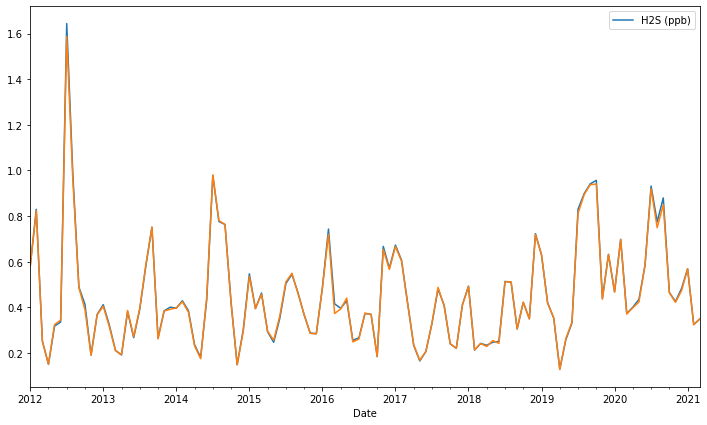

In [ ]:
A = 'M'
df1_w[aa].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c[aa].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

98.49498327759197


[0]	validation_0-rmse:0.918733
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.898234
[2]	validation_0-rmse:0.879717
[3]	validation_0-rmse:0.864241
[4]	validation_0-rmse:0.85006
[5]	validation_0-rmse:0.838351
[6]	validation_0-rmse:0.828359
[7]	validation_0-rmse:0.81854
[8]	validation_0-rmse:0.809513
[9]	validation_0-rmse:0.801873
[10]	validation_0-rmse:0.794883
[11]	validation_0-rmse:0.788741
[12]	validation_0-rmse:0.782817
[13]	validation_0-rmse:0.777426
[14]	validation_0-rmse:0.772575
[15]	validation_0-rmse:0.768559
[16]	validation_0-rmse:0.763351
[17]	validation_0-rmse:0.76009
[18]	validation_0-rmse:0.756419
[19]	validation_0-rmse:0.753805
[20]	validation_0-rmse:0.75144
[21]	validation_0-rmse:0.747432
[22]	validation_0-rmse:0.745334
[23]	validation_0-rmse:0.741809
[24]	validation_0-rmse:0.73899
[25]	validation_0-rmse:0.736544
[26]	validation_0-rmse:0.734651
[27]	validation_0-rmse:0.732914
[28]	validation_0-rmse:0.730902
[29]	validation_0-rmse

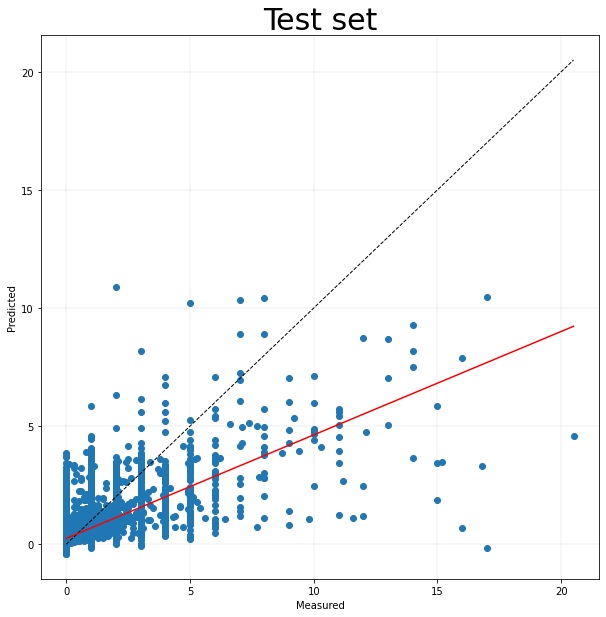

[0.43785037 0.24964051]
RMSE
[0.70509288]
R2
0.47498004154572826


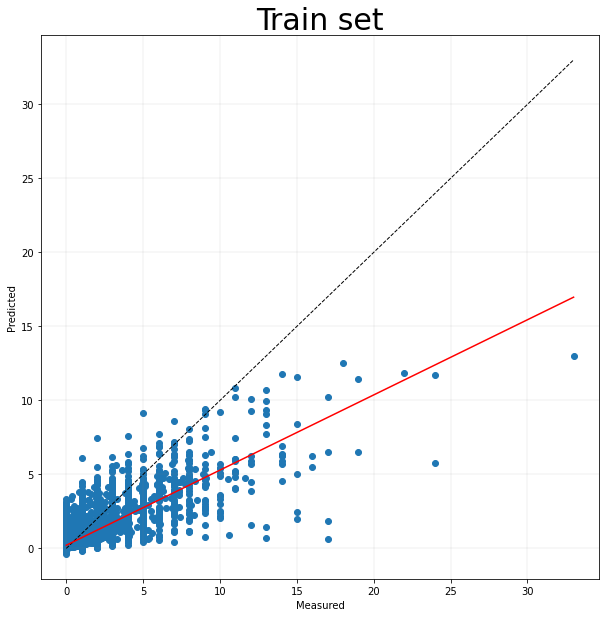

[0.50774709 0.21508751]
RMSE
[0.61290115]
R2
0.6038274390764904


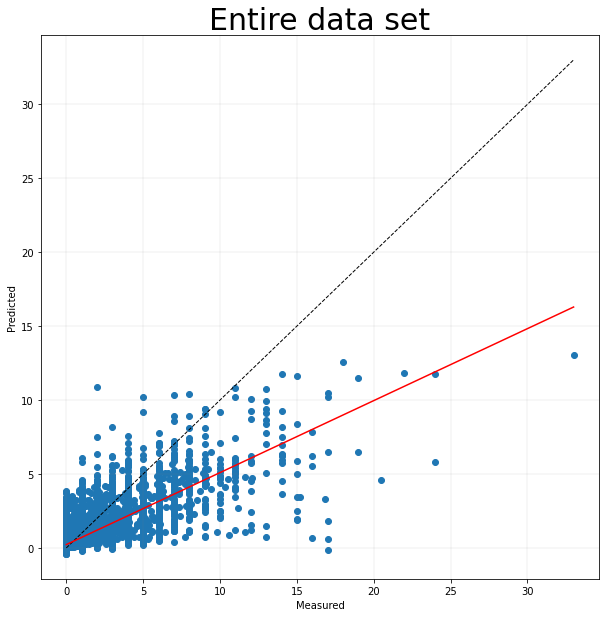

[0.48679875 0.22541174]
RMSE
[0.64195091]
R2
0.5652090511036904


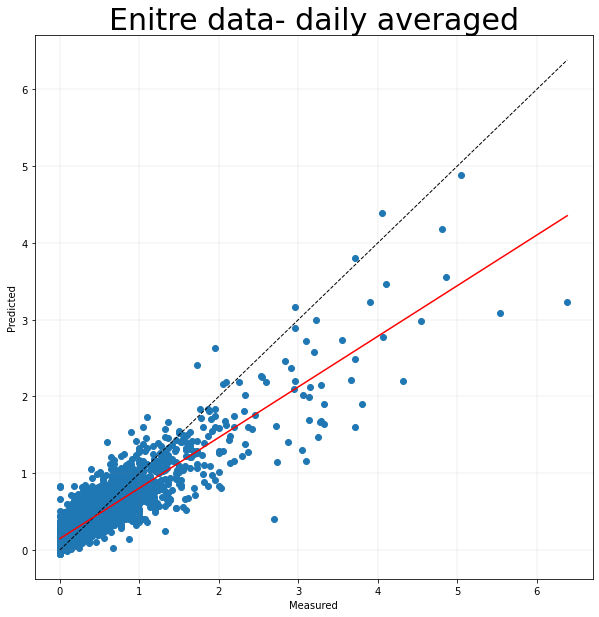

[0.65885169 0.14816425]
RMSE
[0.25783139]
R2
0.7769009591469707


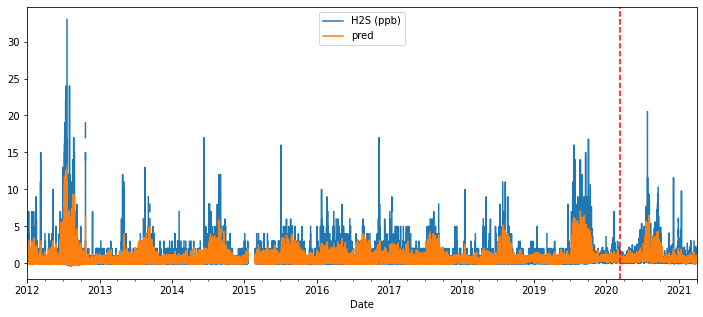

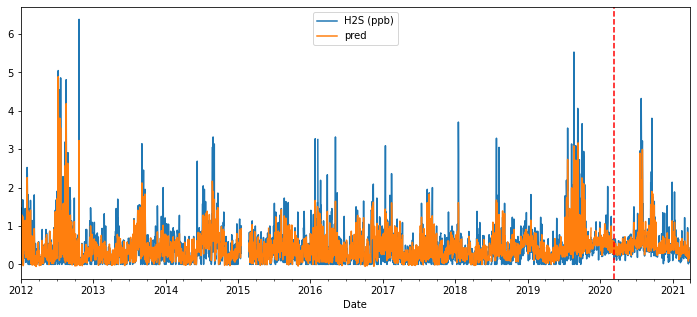

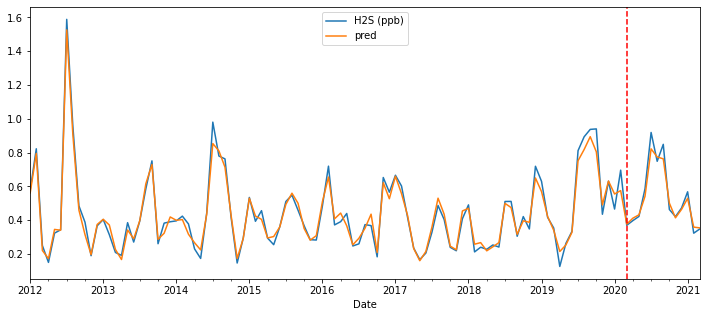

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10[aa]).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
aa

'H2S (ppb)'

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [  'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa,  'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_H2S_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_H2S_OT_XG_Test.csv')


[0.61290115]
0.6038274390764904
[0.70509288]
0.47498004154572826


In [ ]:
df4.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
244
0.5905044674873352
2021-01-12 18:00:00
244
0.562015950679779
2021-01-12 19:00:00
246
0.5219225287437439
2021-01-12 20:00:00
246
0.5071983933448792
2021-01-12 21:00:00
247
0.5168120265007019
2021-01-12 22:00:00
245
0.5100172162055969
2021-01-12 23:00:00
244
0.5338202714920044
2021-01-13 02:00:00
101
0.4614620804786682
2021-01-13 03:00:00
198
0.47802746295928955
2021-01-13 04:00:00
205
0.4763094186782837
2021-01-13 05:00:00
206
0.4974692761898041
2021-01-13 06:00:00
237
0.4783315658569336
2021-01-13 07:00:00
254
0.4960094690322876
2021-01-13 08:00:00
248
0.5226690769195557
2021-01-13 09:00:00
249
0.49388885498046875
2021-01-13 10:00:00
236
0.47821125388145447
2021-01-13 11:00:00
231
0.48900583386421204
2021-01-13 12:00:00
234
0.4896872043609619
2021-01-13 13:00:00
235
0.4819214940071106
2021-01-13 14:00:00
232
0.4967626929283142
2021-01-13 15:00:00
237
0.4990485608577728
2021-01-13 16:00:00
242
0.5153203010559082
2021-01-13 17:00:00


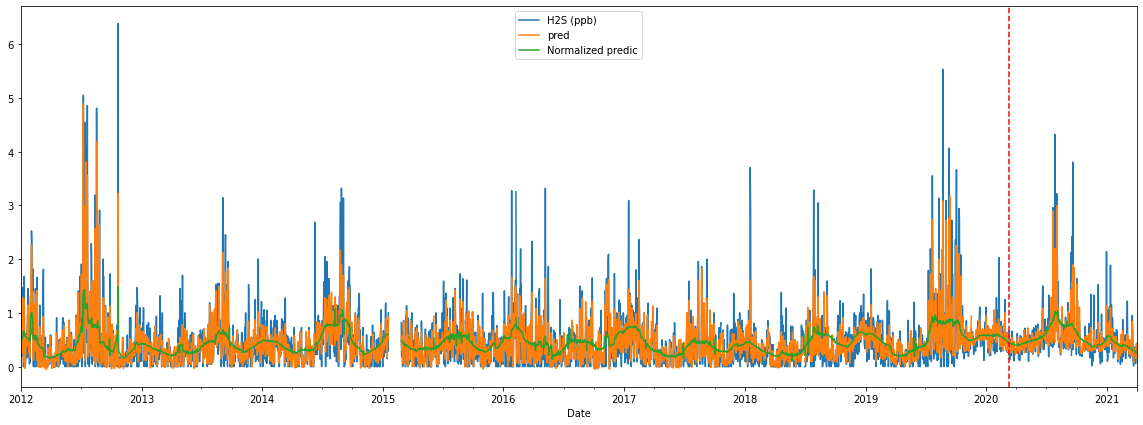

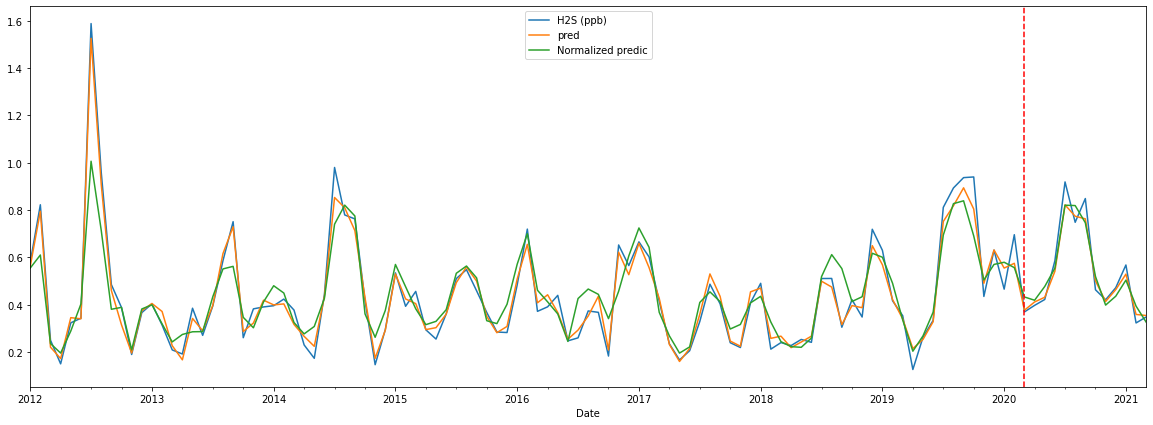

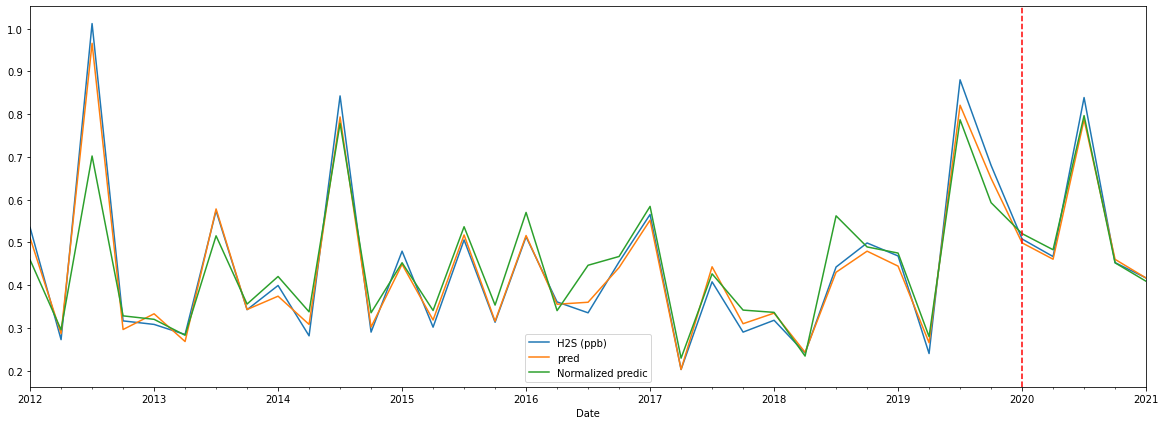

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_H2S_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_H2S_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_MildredLake_H2S_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
################################################################################

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

5.412817221383143 4.741954031234103


In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y_scaler, test_size=0.001, random_state=42)
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)


        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        self.X_train =self.X
        self.y_train =self.Y
        # self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.000000001, random_state = 42)
          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/Mildred_Lake_H2S" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
study = optuna.create_study(direction=optimizer_direction, study_name='Mildred_Lake_H2S_NN', storage='sqlite:///Mildred__Lake_H2S_NN.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_out_Mildred_Lake_H2S_2013_HP_HUBer.csv')

[I 2021-05-19 05:14:35,705] A new study created in RDB with name: Mildred_Lake_H2S_NN
[I 2021-05-19 05:16:06,773] Trial 0 finished with value: 0.8008399380726441 and parameters: {'score': 18.69389627083649, 'layers': 2, 'alpha': 0.5298759949091394, 'batchsize': 1600.0, 'num_dense_nodes1': 22, 'delta': 47.744430095535726, 'learning_rate': 0.055898895895611284, 'drop_out1': 0.17039014740560354, 'num_dense_nodes2': 30, 'drop_out2': 0.2449100594974743}. Best is trial 0 with value: 0.8008399380726441.


0.8008399380726441


[I 2021-05-19 05:17:55,481] Trial 1 finished with value: 0.9350854595300246 and parameters: {'score': 24.21375000719409, 'layers': 3, 'alpha': 0.8485856710665862, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 52.91563150818832, 'learning_rate': 0.0846639109592242, 'drop_out1': 0.29765574159022845, 'num_dense_nodes2': 36, 'drop_out2': 0.09493191310858654, 'num_dense_nodes3': 38, 'drop_out3': 0.4044698132327949}. Best is trial 0 with value: 0.8008399380726441.


0.9350854595300246


[I 2021-05-19 05:30:29,046] Trial 2 finished with value: 0.8329518583373254 and parameters: {'score': 18.60887686617227, 'layers': 3, 'alpha': 0.48527778202465044, 'batchsize': 100.0, 'num_dense_nodes1': 30, 'delta': 21.503273023566543, 'learning_rate': 0.0820263817548519, 'drop_out1': 0.16188407497356594, 'num_dense_nodes2': 28, 'drop_out2': 0.2663523101787444, 'num_dense_nodes3': 11, 'drop_out3': 0.2598132688951169}. Best is trial 0 with value: 0.8008399380726441.


0.8329518583373254


[I 2021-05-19 05:31:39,677] Trial 3 finished with value: 0.6954469222052264 and parameters: {'score': 28.75850278504891, 'layers': 2, 'alpha': 0.08500502246221997, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'delta': 33.40664508872469, 'learning_rate': 0.08816234539443155, 'drop_out1': 0.1587987628923374, 'num_dense_nodes2': 23, 'drop_out2': 0.19444539627280177}. Best is trial 3 with value: 0.6954469222052264.


0.6954469222052264


[I 2021-05-19 05:34:52,832] Trial 4 finished with value: 0.8871150761972024 and parameters: {'score': 24.405520977025088, 'layers': 3, 'alpha': 0.6758527867561681, 'batchsize': 600.0, 'num_dense_nodes1': 30, 'delta': 2.3469451210583414, 'learning_rate': 0.0578637987450268, 'drop_out1': 0.29093466336452045, 'num_dense_nodes2': 33, 'drop_out2': 0.2945796493414562, 'num_dense_nodes3': 27, 'drop_out3': 0.4084830566951732}. Best is trial 3 with value: 0.6954469222052264.


0.8871150761972024


[I 2021-05-19 05:36:21,606] Trial 5 finished with value: 0.8043160119052106 and parameters: {'score': 21.40357593662012, 'layers': 2, 'alpha': 0.6083400778548391, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 21.525579669218345, 'learning_rate': 0.035973888077853504, 'drop_out1': 0.11507310008413597, 'num_dense_nodes2': 21, 'drop_out2': 0.12960737827198882}. Best is trial 3 with value: 0.6954469222052264.


0.8043160119052106


[I 2021-05-19 05:39:36,835] Trial 6 finished with value: 0.7873763781332963 and parameters: {'score': 23.998406084124966, 'layers': 3, 'alpha': 0.28934454183054464, 'batchsize': 600.0, 'num_dense_nodes1': 32, 'delta': 20.489890105392384, 'learning_rate': 0.09632729616260159, 'drop_out1': 0.2637995396203715, 'num_dense_nodes2': 40, 'drop_out2': 0.2617630711199466, 'num_dense_nodes3': 23, 'drop_out3': 0.0682178625150156}. Best is trial 3 with value: 0.6954469222052264.


0.7873763781332963


[I 2021-05-19 05:41:15,900] Trial 7 finished with value: 0.7478428971337848 and parameters: {'score': 27.554963414473335, 'layers': 2, 'alpha': 0.18503430065284387, 'batchsize': 2100.0, 'num_dense_nodes1': 24, 'delta': 39.77056810741911, 'learning_rate': 0.028065383846275254, 'drop_out1': 0.22383766893134416, 'num_dense_nodes2': 28, 'drop_out2': 0.2512722061614171}. Best is trial 3 with value: 0.6954469222052264.


0.7478428971337848


[I 2021-05-19 05:43:35,259] Trial 8 finished with value: 0.8672650391552751 and parameters: {'score': 17.46844973762114, 'layers': 3, 'alpha': 0.7739793641524249, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 3.187882263897945, 'learning_rate': 0.004588265966060178, 'drop_out1': 0.22079255568874817, 'num_dense_nodes2': 24, 'drop_out2': 0.27921920063861055, 'num_dense_nodes3': 9, 'drop_out3': 0.4164611102995454}. Best is trial 3 with value: 0.6954469222052264.


0.8672650391552751


[I 2021-05-19 05:45:21,252] Trial 9 finished with value: 0.6961476907095132 and parameters: {'score': 15.521266419454056, 'layers': 3, 'alpha': 0.2838571283993525, 'batchsize': 2100.0, 'num_dense_nodes1': 29, 'delta': 12.037663703745665, 'learning_rate': 0.012320483204740988, 'drop_out1': 0.27112598580792735, 'num_dense_nodes2': 24, 'drop_out2': 0.10011488587336184, 'num_dense_nodes3': 27, 'drop_out3': 0.4752722793476819}. Best is trial 3 with value: 0.6954469222052264.


0.6961476907095132


[I 2021-05-19 05:46:47,184] Trial 10 finished with value: 0.6887193801421425 and parameters: {'score': 28.158484852477475, 'layers': 2, 'alpha': 0.05159709552337516, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 91.4181380158416, 'learning_rate': 0.0731098341096075, 'drop_out1': 0.05144371757760084, 'num_dense_nodes2': 20, 'drop_out2': 0.4197377351503463}. Best is trial 10 with value: 0.6887193801421425.


0.6887193801421425


[I 2021-05-19 05:48:12,103] Trial 11 finished with value: 0.6843046917186348 and parameters: {'score': 29.096397809977464, 'layers': 2, 'alpha': 0.05438621110992348, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 85.59406386758086, 'learning_rate': 0.07279030001974848, 'drop_out1': 0.05698743024772952, 'num_dense_nodes2': 20, 'drop_out2': 0.4746456605534077}. Best is trial 11 with value: 0.6843046917186348.


0.6843046917186348


[I 2021-05-19 05:49:33,037] Trial 12 finished with value: 0.6746474913247229 and parameters: {'score': 27.309179977435818, 'layers': 2, 'alpha': 0.038376902768523874, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 92.3142585332904, 'learning_rate': 0.07230727696201392, 'drop_out1': 0.05880257027619055, 'num_dense_nodes2': 20, 'drop_out2': 0.4687601452080957}. Best is trial 12 with value: 0.6746474913247229.


0.6746474913247229


[I 2021-05-19 05:50:54,909] Trial 13 finished with value: 0.6831261083279341 and parameters: {'score': 26.64427628268422, 'layers': 2, 'alpha': 0.020947757697633906, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 98.70568792411903, 'learning_rate': 0.06792232198729453, 'drop_out1': 0.05389943665690725, 'num_dense_nodes2': 20, 'drop_out2': 0.4708957724337247}. Best is trial 12 with value: 0.6746474913247229.


0.6831261083279341


[I 2021-05-19 05:52:21,816] Trial 14 finished with value: 0.7810634196587107 and parameters: {'score': 26.36456662718797, 'layers': 2, 'alpha': 0.35340000492665197, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 72.75455446055648, 'learning_rate': 0.06480650077228699, 'drop_out1': 0.0924594654156258, 'num_dense_nodes2': 26, 'drop_out2': 0.37147389919712037}. Best is trial 12 with value: 0.6746474913247229.


0.7810634196587107


[I 2021-05-19 05:53:49,213] Trial 15 finished with value: 0.7418791508115472 and parameters: {'score': 26.254931010024332, 'layers': 2, 'alpha': 0.18563520167372577, 'batchsize': 4100.0, 'num_dense_nodes1': 27, 'delta': 99.41850793810661, 'learning_rate': 0.04310533215663885, 'drop_out1': 0.09671110539179902, 'num_dense_nodes2': 20, 'drop_out2': 0.4989674818460723}. Best is trial 12 with value: 0.6746474913247229.


0.7418791508115472


[I 2021-05-19 05:55:20,034] Trial 16 finished with value: 0.7458467585247193 and parameters: {'score': 22.16226004542472, 'layers': 2, 'alpha': 0.013250602894676129, 'batchsize': 3100.0, 'num_dense_nodes1': 23, 'delta': 73.39469576894125, 'learning_rate': 0.09927164863448319, 'drop_out1': 0.0510082493649779, 'num_dense_nodes2': 22, 'drop_out2': 0.42388494084696327}. Best is trial 12 with value: 0.6746474913247229.


0.7458467585247193


[I 2021-05-19 05:56:44,243] Trial 17 finished with value: 0.6996364307290326 and parameters: {'score': 26.025277511277764, 'layers': 2, 'alpha': 0.11290963567897974, 'batchsize': 4600.0, 'num_dense_nodes1': 27, 'delta': 98.89674179879194, 'learning_rate': 0.06961576940310338, 'drop_out1': 0.13117494841297356, 'num_dense_nodes2': 26, 'drop_out2': 0.3651307547662676}. Best is trial 12 with value: 0.6746474913247229.


0.6996364307290326


[I 2021-05-19 05:58:07,061] Trial 18 finished with value: 0.770860928795616 and parameters: {'score': 22.87098769674049, 'layers': 2, 'alpha': 0.3851580175605488, 'batchsize': 4100.0, 'num_dense_nodes1': 20, 'delta': 72.96930454647344, 'learning_rate': 0.04417551398515031, 'drop_out1': 0.0820404762255957, 'num_dense_nodes2': 32, 'drop_out2': 0.43730874932543445}. Best is trial 12 with value: 0.6746474913247229.


0.770860928795616


[I 2021-05-19 05:59:34,599] Trial 19 finished with value: 0.7118700551601929 and parameters: {'score': 20.54411575815076, 'layers': 2, 'alpha': 0.19723767199927145, 'batchsize': 3100.0, 'num_dense_nodes1': 33, 'delta': 83.36286528861757, 'learning_rate': 0.061319410867186945, 'drop_out1': 0.07070041134275429, 'num_dense_nodes2': 36, 'drop_out2': 0.36905662547393786}. Best is trial 12 with value: 0.6746474913247229.


0.7118700551601929


[I 2021-05-19 06:01:01,419] Trial 20 finished with value: 0.7638047083231736 and parameters: {'score': 27.036926848338602, 'layers': 2, 'alpha': 0.2602248882695263, 'batchsize': 4100.0, 'num_dense_nodes1': 25, 'delta': 64.78186730177613, 'learning_rate': 0.07784502018041001, 'drop_out1': 0.1353051767513521, 'num_dense_nodes2': 26, 'drop_out2': 0.49943038379400917}. Best is trial 12 with value: 0.6746474913247229.


0.7638047083231736


[I 2021-05-19 06:02:25,791] Trial 21 finished with value: 0.6781278909935435 and parameters: {'score': 29.083361497384182, 'layers': 2, 'alpha': 0.02592840509114724, 'batchsize': 4600.0, 'num_dense_nodes1': 28, 'delta': 88.14240932238859, 'learning_rate': 0.071075652217283, 'drop_out1': 0.050598006032368026, 'num_dense_nodes2': 20, 'drop_out2': 0.46355886306404503}. Best is trial 12 with value: 0.6746474913247229.


0.6781278909935435


[I 2021-05-19 06:03:50,231] Trial 22 finished with value: 0.7194980555246944 and parameters: {'score': 29.051776239471852, 'layers': 2, 'alpha': 0.14606281153325476, 'batchsize': 4600.0, 'num_dense_nodes1': 28, 'delta': 94.12179559128622, 'learning_rate': 0.09179142458019642, 'drop_out1': 0.0676617731881684, 'num_dense_nodes2': 20, 'drop_out2': 0.4586500063432103}. Best is trial 12 with value: 0.6746474913247229.


0.7194980555246944


[I 2021-05-19 06:05:18,064] Trial 23 finished with value: 0.6654731935225192 and parameters: {'score': 25.178159747391536, 'layers': 2, 'alpha': 0.019515880128093605, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 82.76847655475899, 'learning_rate': 0.050425277679017305, 'drop_out1': 0.11036844990960128, 'num_dense_nodes2': 22, 'drop_out2': 0.3879000495119348}. Best is trial 23 with value: 0.6654731935225192.


0.6654731935225192


[I 2021-05-19 06:06:44,770] Trial 24 finished with value: 0.6706166272500369 and parameters: {'score': 25.014086442629353, 'layers': 2, 'alpha': 0.019462524688762372, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 82.95260925122284, 'learning_rate': 0.05047947011444116, 'drop_out1': 0.11252430451115322, 'num_dense_nodes2': 22, 'drop_out2': 0.32773557490904887}. Best is trial 23 with value: 0.6654731935225192.


0.6706166272500369


[I 2021-05-19 06:08:07,090] Trial 25 finished with value: 0.6883301551579339 and parameters: {'score': 24.791417529194756, 'layers': 2, 'alpha': 0.10803539691942275, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'delta': 80.52747222004949, 'learning_rate': 0.05024443076315937, 'drop_out1': 0.1115322788236522, 'num_dense_nodes2': 23, 'drop_out2': 0.3206058907305213}. Best is trial 23 with value: 0.6654731935225192.


0.6883301551579339


[I 2021-05-19 06:09:44,990] Trial 26 finished with value: 0.7323521611170278 and parameters: {'score': 23.15802726074579, 'layers': 2, 'alpha': 0.21305190137608032, 'batchsize': 2600.0, 'num_dense_nodes1': 31, 'delta': 58.8736887247168, 'learning_rate': 0.027406549376314968, 'drop_out1': 0.1401903697750087, 'num_dense_nodes2': 22, 'drop_out2': 0.3416357922990238}. Best is trial 23 with value: 0.6654731935225192.


0.7323521611170278


[I 2021-05-19 06:11:22,077] Trial 27 finished with value: 0.7234166950860146 and parameters: {'score': 25.56170085818778, 'layers': 2, 'alpha': 0.12573961585952942, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 78.24278987288265, 'learning_rate': 0.052150311832527906, 'drop_out1': 0.1949626698507877, 'num_dense_nodes2': 25, 'drop_out2': 0.40023274873852754}. Best is trial 23 with value: 0.6654731935225192.


0.7234166950860146


[I 2021-05-19 06:12:33,975] Trial 28 finished with value: 0.6627446622598607 and parameters: {'score': 25.46571611091371, 'layers': 2, 'alpha': 0.01917985800353728, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 66.01877874287113, 'learning_rate': 0.04413709109728954, 'drop_out1': 0.10938494731646894, 'num_dense_nodes2': 22, 'drop_out2': 0.32140235493657265}. Best is trial 28 with value: 0.6627446622598607.


0.6627446622598607


[I 2021-05-19 06:14:01,925] Trial 29 finished with value: 0.7821607071336381 and parameters: {'score': 25.10891764351577, 'layers': 2, 'alpha': 0.4345068726247643, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 64.74043117534129, 'learning_rate': 0.03245549815395403, 'drop_out1': 0.1847094502612588, 'num_dense_nodes2': 28, 'drop_out2': 0.21824788220913688}. Best is trial 28 with value: 0.6627446622598607.


0.7821607071336381


[I 2021-05-19 06:15:33,734] Trial 30 finished with value: 0.6628278426731862 and parameters: {'score': 23.350408084598154, 'layers': 2, 'alpha': 0.01269865658738666, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'delta': 65.35395973537263, 'learning_rate': 0.04417863058409522, 'drop_out1': 0.11166356762730499, 'num_dense_nodes2': 23, 'drop_out2': 0.33215356823201425}. Best is trial 28 with value: 0.6627446622598607.


0.6628278426731862


[I 2021-05-19 06:17:04,390] Trial 31 finished with value: 0.6801129755696944 and parameters: {'score': 23.17649688766955, 'layers': 2, 'alpha': 0.013658502673237309, 'batchsize': 3100.0, 'num_dense_nodes1': 31, 'delta': 67.70311818077188, 'learning_rate': 0.04227149953074508, 'drop_out1': 0.1159980925929937, 'num_dense_nodes2': 22, 'drop_out2': 0.3987470829079397}. Best is trial 28 with value: 0.6627446622598607.


0.6801129755696944


[I 2021-05-19 06:18:36,871] Trial 32 finished with value: 0.6862004124348164 and parameters: {'score': 23.895305543857, 'layers': 2, 'alpha': 0.08210046851318986, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 54.378210310913275, 'learning_rate': 0.050662333809809314, 'drop_out1': 0.09930542118343812, 'num_dense_nodes2': 24, 'drop_out2': 0.3080701381114357}. Best is trial 28 with value: 0.6627446622598607.


0.6862004124348164


[I 2021-05-19 06:20:03,051] Trial 33 finished with value: 0.722832444248416 and parameters: {'score': 20.504460626245866, 'layers': 2, 'alpha': 0.16014854132536469, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 59.730689144409695, 'learning_rate': 0.02110252468650747, 'drop_out1': 0.14714553837849828, 'num_dense_nodes2': 22, 'drop_out2': 0.32969416355887793}. Best is trial 28 with value: 0.6627446622598607.


0.722832444248416


[I 2021-05-19 06:21:29,831] Trial 34 finished with value: 0.6971547272258052 and parameters: {'score': 25.500354614661145, 'layers': 2, 'alpha': 0.08295620513299011, 'batchsize': 3600.0, 'num_dense_nodes1': 31, 'delta': 45.480682049879974, 'learning_rate': 0.03919847450912088, 'drop_out1': 0.12378866665898129, 'num_dense_nodes2': 23, 'drop_out2': 0.2258074147383406}. Best is trial 28 with value: 0.6627446622598607.


0.6971547272258052


[I 2021-05-19 06:23:02,250] Trial 35 finished with value: 0.7399159875402112 and parameters: {'score': 22.11473763317605, 'layers': 2, 'alpha': 0.2458036376929954, 'batchsize': 3100.0, 'num_dense_nodes1': 33, 'delta': 48.596644203176055, 'learning_rate': 0.05580641904606138, 'drop_out1': 0.1571649862472055, 'num_dense_nodes2': 25, 'drop_out2': 0.3489017404670932}. Best is trial 28 with value: 0.6627446622598607.


0.7399159875402112


[I 2021-05-19 06:24:30,210] Trial 36 finished with value: 0.6422730769674742 and parameters: {'score': 24.516061582714677, 'layers': 2, 'alpha': 0.013755466779934028, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'delta': 77.05791254858622, 'learning_rate': 0.04716674672290704, 'drop_out1': 0.0799572648609642, 'num_dense_nodes2': 29, 'drop_out2': 0.30709812609313547}. Best is trial 36 with value: 0.6422730769674742.


0.6422730769674742


[I 2021-05-19 06:25:56,328] Trial 37 finished with value: 0.8614107851726454 and parameters: {'score': 24.05296181168591, 'layers': 3, 'alpha': 0.8335653234772767, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 76.15935861302005, 'learning_rate': 0.03626694609480174, 'drop_out1': 0.08251185468123035, 'num_dense_nodes2': 30, 'drop_out2': 0.17875156594583455, 'num_dense_nodes3': 38, 'drop_out3': 0.056337274754828304}. Best is trial 36 with value: 0.6422730769674742.


0.8614107851726454


[I 2021-05-19 06:27:27,245] Trial 38 finished with value: 0.6669617014489544 and parameters: {'score': 21.43989795776233, 'layers': 2, 'alpha': 0.07799524276120201, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 67.8186719609449, 'learning_rate': 0.04638691805546945, 'drop_out1': 0.07800010805163554, 'num_dense_nodes2': 37, 'drop_out2': 0.28896899354762096}. Best is trial 36 with value: 0.6422730769674742.


0.6669617014489544


[I 2021-05-19 06:28:57,049] Trial 39 finished with value: 0.8015538399752901 and parameters: {'score': 27.98350326082785, 'layers': 2, 'alpha': 0.5494524286067027, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 56.75184655581043, 'learning_rate': 0.06068204014183723, 'drop_out1': 0.10149944581646249, 'num_dense_nodes2': 32, 'drop_out2': 0.3880238769912583}. Best is trial 36 with value: 0.6422730769674742.


0.8015538399752901


[I 2021-05-19 06:30:40,678] Trial 40 finished with value: 0.6788409198387894 and parameters: {'score': 23.592808966324274, 'layers': 3, 'alpha': 0.13926083815711998, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 37.52910550447173, 'learning_rate': 0.022538132971776065, 'drop_out1': 0.16677346675794227, 'num_dense_nodes2': 28, 'drop_out2': 0.3047172629352803, 'num_dense_nodes3': 16, 'drop_out3': 0.2096199112509938}. Best is trial 36 with value: 0.6422730769674742.


0.6788409198387894


[I 2021-05-19 06:32:16,828] Trial 41 finished with value: 0.6629042861088096 and parameters: {'score': 19.82295335971338, 'layers': 2, 'alpha': 0.07640556920442432, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 66.12666110485817, 'learning_rate': 0.0461802822230502, 'drop_out1': 0.07473495054445531, 'num_dense_nodes2': 37, 'drop_out2': 0.2750070090012251}. Best is trial 36 with value: 0.6422730769674742.


0.6629042861088096


[I 2021-05-19 06:33:48,397] Trial 42 finished with value: 0.664091763479502 and parameters: {'score': 19.070570375462214, 'layers': 2, 'alpha': 0.06306113927029687, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 62.11770795227678, 'learning_rate': 0.055912860480244686, 'drop_out1': 0.09167903202514589, 'num_dense_nodes2': 34, 'drop_out2': 0.2561259203361675}. Best is trial 36 with value: 0.6422730769674742.


0.664091763479502


[I 2021-05-19 06:35:37,807] Trial 43 finished with value: 0.6675310723627977 and parameters: {'score': 18.37535997179614, 'layers': 2, 'alpha': 0.06882339015772834, 'batchsize': 1600.0, 'num_dense_nodes1': 37, 'delta': 62.12451606293151, 'learning_rate': 0.05738389695464861, 'drop_out1': 0.08807570944215465, 'num_dense_nodes2': 38, 'drop_out2': 0.27099064621403607}. Best is trial 36 with value: 0.6422730769674742.


0.6675310723627977


[I 2021-05-19 06:37:09,747] Trial 44 finished with value: 0.8345907698102033 and parameters: {'score': 19.291957733419594, 'layers': 2, 'alpha': 0.7018922678857847, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 68.98496284596044, 'learning_rate': 0.03774001929342215, 'drop_out1': 0.06922414077333934, 'num_dense_nodes2': 35, 'drop_out2': 0.2382706315188542}. Best is trial 36 with value: 0.6422730769674742.


0.8345907698102033


[I 2021-05-19 06:38:40,138] Trial 45 finished with value: 0.6945249199803278 and parameters: {'score': 15.84193003105788, 'layers': 2, 'alpha': 0.3159170127964711, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 52.58814893941257, 'learning_rate': 0.03241061037937776, 'drop_out1': 0.0726128695712962, 'num_dense_nodes2': 39, 'drop_out2': 0.17859153066326866}. Best is trial 36 with value: 0.6422730769674742.


0.6945249199803278


[I 2021-05-19 06:40:21,384] Trial 46 finished with value: 0.6710553056371522 and parameters: {'score': 16.949413129832593, 'layers': 2, 'alpha': 0.10097122013342542, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 44.30549010419122, 'learning_rate': 0.045905202126566666, 'drop_out1': 0.12276559621970262, 'num_dense_nodes2': 34, 'drop_out2': 0.26560928743333834}. Best is trial 36 with value: 0.6422730769674742.


0.6710553056371522


[I 2021-05-19 06:42:14,964] Trial 47 finished with value: 0.6603189117584115 and parameters: {'score': 19.85812108593273, 'layers': 2, 'alpha': 0.05622454387247536, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 70.4516943426636, 'learning_rate': 0.0559736581134276, 'drop_out1': 0.10362105580853982, 'num_dense_nodes2': 33, 'drop_out2': 0.1989777105712942}. Best is trial 36 with value: 0.6422730769674742.


0.6603189117584115


[I 2021-05-19 06:44:06,873] Trial 48 finished with value: 0.6874466103791781 and parameters: {'score': 20.22602126565147, 'layers': 2, 'alpha': 0.16171752078635832, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 70.60398689506016, 'learning_rate': 0.06213860913106665, 'drop_out1': 0.10292153073536693, 'num_dense_nodes2': 29, 'drop_out2': 0.13883507891465866}. Best is trial 36 with value: 0.6422730769674742.


0.6874466103791781


[I 2021-05-19 06:46:17,844] Trial 49 finished with value: 0.7204512768702538 and parameters: {'score': 21.342217684344558, 'layers': 2, 'alpha': 0.2374923618280403, 'batchsize': 1100.0, 'num_dense_nodes1': 33, 'delta': 77.00105153723763, 'learning_rate': 0.03975247780456581, 'drop_out1': 0.14960410955381537, 'num_dense_nodes2': 31, 'drop_out2': 0.20232284911738596}. Best is trial 36 with value: 0.6422730769674742.


0.7204512768702538


[I 2021-05-19 06:49:27,979] Trial 50 finished with value: 0.6617498653482348 and parameters: {'score': 19.612470423117664, 'layers': 2, 'alpha': 0.047135877182830126, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 87.65587575343405, 'learning_rate': 0.03136402950018501, 'drop_out1': 0.060799092289199066, 'num_dense_nodes2': 36, 'drop_out2': 0.2841041782109052}. Best is trial 36 with value: 0.6422730769674742.


0.6617498653482348


[I 2021-05-19 06:52:29,473] Trial 51 finished with value: 0.6815429938587632 and parameters: {'score': 19.58075025905706, 'layers': 2, 'alpha': 0.010004341952337917, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 75.18368820581536, 'learning_rate': 0.03145517666226402, 'drop_out1': 0.08689384799605701, 'num_dense_nodes2': 40, 'drop_out2': 0.28952058668669317}. Best is trial 36 with value: 0.6422730769674742.


0.6815429938587632


[I 2021-05-19 07:05:36,927] Trial 52 finished with value: 0.6578600920492879 and parameters: {'score': 17.874153838013115, 'layers': 2, 'alpha': 0.04590959821115459, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 88.28420676971176, 'learning_rate': 0.014677061848880828, 'drop_out1': 0.0625816918648432, 'num_dense_nodes2': 36, 'drop_out2': 0.051858785039190974}. Best is trial 36 with value: 0.6422730769674742.


0.6578600920492879


[I 2021-05-19 07:18:40,339] Trial 53 finished with value: 0.6326329101375694 and parameters: {'score': 17.965533390181434, 'layers': 2, 'alpha': 0.041234322619109524, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 88.53829677055111, 'learning_rate': 0.0029318868520000103, 'drop_out1': 0.060954255069145716, 'num_dense_nodes2': 35, 'drop_out2': 0.06353897545047202}. Best is trial 53 with value: 0.6326329101375694.


0.6326329101375694


[I 2021-05-19 07:31:45,377] Trial 54 finished with value: 0.6545829918918791 and parameters: {'score': 18.009971459597907, 'layers': 2, 'alpha': 0.04093214915037446, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 88.94226997427793, 'learning_rate': 0.0010178737078201834, 'drop_out1': 0.05694915274309921, 'num_dense_nodes2': 35, 'drop_out2': 0.05459010775906972}. Best is trial 53 with value: 0.6326329101375694.


0.6545829918918791


[I 2021-05-19 07:44:41,907] Trial 55 finished with value: 0.6542262486612316 and parameters: {'score': 18.05839233401519, 'layers': 2, 'alpha': 0.04307751193884992, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 88.88874866911512, 'learning_rate': 0.0010169154746163262, 'drop_out1': 0.0612067147577226, 'num_dense_nodes2': 35, 'drop_out2': 0.05326938276972715}. Best is trial 53 with value: 0.6326329101375694.


0.6542262486612316


[I 2021-05-19 07:57:44,922] Trial 56 finished with value: 0.6617572783018062 and parameters: {'score': 17.942625337424406, 'layers': 2, 'alpha': 0.13137429996235517, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 94.25864995152851, 'learning_rate': 0.0022052491110223604, 'drop_out1': 0.05843982621087469, 'num_dense_nodes2': 33, 'drop_out2': 0.06958202042676591}. Best is trial 53 with value: 0.6326329101375694.


0.6617572783018062


[I 2021-05-19 08:10:43,286] Trial 57 finished with value: 0.6771031422835319 and parameters: {'score': 16.94875886583575, 'layers': 2, 'alpha': 0.180390556254137, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 90.53775265784104, 'learning_rate': 0.01028944342456281, 'drop_out1': 0.0641538923729201, 'num_dense_nodes2': 35, 'drop_out2': 0.05183012408267995}. Best is trial 53 with value: 0.6326329101375694.


0.6771031422835319


[I 2021-05-19 08:23:39,859] Trial 58 finished with value: 0.652741908181059 and parameters: {'score': 16.190163822925754, 'layers': 2, 'alpha': 0.10640971339286608, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 96.68365443462902, 'learning_rate': 0.007390333779651674, 'drop_out1': 0.05095473474769061, 'num_dense_nodes2': 33, 'drop_out2': 0.09940846175852162}. Best is trial 53 with value: 0.6326329101375694.


0.652741908181059


[I 2021-05-19 08:36:26,954] Trial 59 finished with value: 0.6521867704311588 and parameters: {'score': 14.967465199138045, 'layers': 2, 'alpha': 0.10851826987949731, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 97.48229966098565, 'learning_rate': 0.00825899426036648, 'drop_out1': 0.05011738858624535, 'num_dense_nodes2': 35, 'drop_out2': 0.09285938251815212}. Best is trial 53 with value: 0.6326329101375694.


0.6521867704311588


[I 2021-05-19 08:49:20,081] Trial 60 finished with value: 0.7090211164933791 and parameters: {'score': 15.00213831650972, 'layers': 2, 'alpha': 0.10251074620966497, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 95.05448767258673, 'learning_rate': 0.006808057952634324, 'drop_out1': 0.05220872836855578, 'num_dense_nodes2': 35, 'drop_out2': 0.11032566754066353}. Best is trial 53 with value: 0.6326329101375694.


0.7090211164933791


[I 2021-05-19 09:01:51,957] Trial 61 finished with value: 0.6447055560924121 and parameters: {'score': 16.05417571751338, 'layers': 2, 'alpha': 0.051485525993760585, 'batchsize': 100.0, 'num_dense_nodes1': 39, 'delta': 97.812862098768, 'learning_rate': 0.015638806422148807, 'drop_out1': 0.06344275845134574, 'num_dense_nodes2': 37, 'drop_out2': 0.07281362063850427}. Best is trial 53 with value: 0.6326329101375694.


0.6447055560924121


[I 2021-05-19 09:05:02,529] Trial 62 finished with value: 0.6503180638856356 and parameters: {'score': 16.01335255705687, 'layers': 2, 'alpha': 0.11817741091161194, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 97.19489233829509, 'learning_rate': 0.0014151795080919096, 'drop_out1': 0.050913037805703075, 'num_dense_nodes2': 37, 'drop_out2': 0.07570792548997343}. Best is trial 53 with value: 0.6326329101375694.


0.6503180638856356


[I 2021-05-19 09:08:11,561] Trial 63 finished with value: 0.6973176095256521 and parameters: {'score': 16.0613842987218, 'layers': 2, 'alpha': 0.21835799333220937, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 97.16274818868195, 'learning_rate': 0.006662368174310568, 'drop_out1': 0.05019567995629742, 'num_dense_nodes2': 37, 'drop_out2': 0.08152244954571165}. Best is trial 53 with value: 0.6326329101375694.


0.6973176095256521


[I 2021-05-19 09:11:18,948] Trial 64 finished with value: 0.6693478665208648 and parameters: {'score': 16.559151933031334, 'layers': 2, 'alpha': 0.16358616316120475, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 99.4772084629654, 'learning_rate': 0.012587865398592362, 'drop_out1': 0.050368299489192886, 'num_dense_nodes2': 39, 'drop_out2': 0.12267871627304143}. Best is trial 53 with value: 0.6326329101375694.


0.6693478665208648


[I 2021-05-19 09:24:20,311] Trial 65 finished with value: 0.6832786654851091 and parameters: {'score': 15.13144877331695, 'layers': 2, 'alpha': 0.1232327759035178, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 84.96027301091762, 'learning_rate': 0.01680256638673576, 'drop_out1': 0.07019363068612212, 'num_dense_nodes2': 34, 'drop_out2': 0.09105235286687141}. Best is trial 53 with value: 0.6326329101375694.


0.6832786654851091


[I 2021-05-19 09:26:37,697] Trial 66 finished with value: 0.6657364030715529 and parameters: {'score': 16.32267357299903, 'layers': 2, 'alpha': 0.11201717507449252, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 96.61919160654344, 'learning_rate': 0.004351414582976273, 'drop_out1': 0.23974862385262427, 'num_dense_nodes2': 38, 'drop_out2': 0.148239766787473}. Best is trial 53 with value: 0.6326329101375694.


0.6657364030715529


[I 2021-05-19 09:29:46,514] Trial 67 finished with value: 0.6670178908684748 and parameters: {'score': 15.489686060103518, 'layers': 2, 'alpha': 0.1976705203764424, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 92.83903330380606, 'learning_rate': 0.00936218938908961, 'drop_out1': 0.06458697436362726, 'num_dense_nodes2': 31, 'drop_out2': 0.06998362242711259}. Best is trial 53 with value: 0.6326329101375694.


0.6670178908684748


[I 2021-05-19 09:42:53,287] Trial 68 finished with value: 0.7239721072840856 and parameters: {'score': 17.474464880834766, 'layers': 2, 'alpha': 0.28056818250849724, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 79.7384299189721, 'learning_rate': 0.01820817399922851, 'drop_out1': 0.050255991876293295, 'num_dense_nodes2': 38, 'drop_out2': 0.10603214550896883}. Best is trial 53 with value: 0.6326329101375694.


0.7239721072840856


[I 2021-05-19 09:56:10,138] Trial 69 finished with value: 0.6622259921984953 and parameters: {'score': 16.97108757751204, 'layers': 2, 'alpha': 0.09648183025407378, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 92.21943322742467, 'learning_rate': 0.0012249057029977074, 'drop_out1': 0.08364301420459533, 'num_dense_nodes2': 32, 'drop_out2': 0.07184276555065826}. Best is trial 53 with value: 0.6326329101375694.


0.6622259921984953


[I 2021-05-19 09:59:20,012] Trial 70 finished with value: 0.6495832378036596 and parameters: {'score': 15.539409313160451, 'layers': 2, 'alpha': 0.14653583938894799, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 85.12028903035706, 'learning_rate': 0.004729404690045664, 'drop_out1': 0.07928056456503607, 'num_dense_nodes2': 36, 'drop_out2': 0.08773053280985586}. Best is trial 53 with value: 0.6326329101375694.


0.6495832378036596


[I 2021-05-19 10:01:38,860] Trial 71 finished with value: 0.6515263371975618 and parameters: {'score': 15.41453462382029, 'layers': 2, 'alpha': 0.1432653282066213, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 99.99228633177479, 'learning_rate': 0.00425243342746609, 'drop_out1': 0.0783858372626719, 'num_dense_nodes2': 36, 'drop_out2': 0.08845106353108306}. Best is trial 53 with value: 0.6326329101375694.


0.6515263371975618


[I 2021-05-19 10:03:58,002] Trial 72 finished with value: 0.6572607913538255 and parameters: {'score': 15.572551343803783, 'layers': 2, 'alpha': 0.1438957917602763, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 99.13383748475087, 'learning_rate': 0.005904011111628374, 'drop_out1': 0.09388929979468702, 'num_dense_nodes2': 36, 'drop_out2': 0.09172937518819338}. Best is trial 53 with value: 0.6326329101375694.


0.6572607913538255


[I 2021-05-19 10:07:09,711] Trial 73 finished with value: 0.6505693352453188 and parameters: {'score': 15.207716418026415, 'layers': 2, 'alpha': 0.12616721090076782, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 85.39942259640226, 'learning_rate': 0.00995856066227446, 'drop_out1': 0.07713339211861095, 'num_dense_nodes2': 37, 'drop_out2': 0.11863339310201604}. Best is trial 53 with value: 0.6326329101375694.


0.6505693352453188


[I 2021-05-19 10:10:17,671] Trial 74 finished with value: 0.6559522863728899 and parameters: {'score': 15.202947896168594, 'layers': 2, 'alpha': 0.1682498459068203, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 85.29326981439375, 'learning_rate': 0.011141686748649123, 'drop_out1': 0.08078877392083093, 'num_dense_nodes2': 37, 'drop_out2': 0.11942464658381519}. Best is trial 53 with value: 0.6326329101375694.


0.6559522863728899


[I 2021-05-19 10:12:32,163] Trial 75 finished with value: 0.6710370066149351 and parameters: {'score': 14.897458340852067, 'layers': 2, 'alpha': 0.19405807461026636, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 80.51199012500383, 'learning_rate': 0.014928251114964347, 'drop_out1': 0.07516239364926897, 'num_dense_nodes2': 39, 'drop_out2': 0.14922180624591427}. Best is trial 53 with value: 0.6326329101375694.


0.6710370066149351


[I 2021-05-19 10:15:44,618] Trial 76 finished with value: 0.6757022303988492 and parameters: {'score': 15.692827982281369, 'layers': 2, 'alpha': 0.2209699515936724, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 26.818994449097026, 'learning_rate': 0.0035472329952344786, 'drop_out1': 0.0798152021275861, 'num_dense_nodes2': 38, 'drop_out2': 0.0741779191990535}. Best is trial 53 with value: 0.6326329101375694.


0.6757022303988492


[I 2021-05-19 10:18:50,968] Trial 77 finished with value: 0.6685751627304332 and parameters: {'score': 16.595030699638507, 'layers': 2, 'alpha': 0.1425477010126875, 'batchsize': 600.0, 'num_dense_nodes1': 36, 'delta': 82.19176299828605, 'learning_rate': 0.00816101711603256, 'drop_out1': 0.09424910551471245, 'num_dense_nodes2': 37, 'drop_out2': 0.08841569646880237}. Best is trial 53 with value: 0.6326329101375694.


0.6685751627304332


[I 2021-05-19 10:20:55,779] Trial 78 finished with value: 0.6489550433633047 and parameters: {'score': 15.29292163009245, 'layers': 2, 'alpha': 0.08428412637147974, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 90.78053988131542, 'learning_rate': 0.01999884114980882, 'drop_out1': 0.06870549979412245, 'num_dense_nodes2': 36, 'drop_out2': 0.13388448824139917}. Best is trial 53 with value: 0.6326329101375694.


0.6489550433633047


[I 2021-05-19 10:23:09,233] Trial 79 finished with value: 0.7161852782421224 and parameters: {'score': 17.314245519992838, 'layers': 2, 'alpha': 0.3240781255662264, 'batchsize': 1100.0, 'num_dense_nodes1': 34, 'delta': 90.32022362301296, 'learning_rate': 0.02197675115094225, 'drop_out1': 0.08768090423538862, 'num_dense_nodes2': 36, 'drop_out2': 0.16879041753532475}. Best is trial 53 with value: 0.6326329101375694.


0.7161852782421224


[I 2021-05-19 10:25:22,625] Trial 80 finished with value: 0.6584198136423974 and parameters: {'score': 15.356473660024866, 'layers': 2, 'alpha': 0.07665048776697442, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 85.628287508217, 'learning_rate': 0.02759055513145469, 'drop_out1': 0.06782149681065058, 'num_dense_nodes2': 27, 'drop_out2': 0.1318498690733959}. Best is trial 53 with value: 0.6326329101375694.


0.6584198136423974


[I 2021-05-19 10:28:28,005] Trial 81 finished with value: 0.6510137072041242 and parameters: {'score': 14.913011754187716, 'layers': 2, 'alpha': 0.08814263369957842, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 99.71949792900631, 'learning_rate': 0.013803181408232928, 'drop_out1': 0.07417180624047406, 'num_dense_nodes2': 36, 'drop_out2': 0.10797759483695867}. Best is trial 53 with value: 0.6326329101375694.


0.6510137072041242


[I 2021-05-19 10:31:33,065] Trial 82 finished with value: 0.6519533815608962 and parameters: {'score': 16.028002812034146, 'layers': 2, 'alpha': 0.030195385790802214, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 99.9949965549545, 'learning_rate': 0.01917525901862032, 'drop_out1': 0.07521185986226704, 'num_dense_nodes2': 37, 'drop_out2': 0.11332874736606931}. Best is trial 53 with value: 0.6326329101375694.


0.6519533815608962


[I 2021-05-19 10:33:45,681] Trial 83 finished with value: 0.669570430565221 and parameters: {'score': 16.429543370837383, 'layers': 2, 'alpha': 0.08158042720583458, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 94.9119523419801, 'learning_rate': 0.013167459051437486, 'drop_out1': 0.06893427968079319, 'num_dense_nodes2': 36, 'drop_out2': 0.060776859700902575}. Best is trial 53 with value: 0.6326329101375694.


0.669570430565221


[I 2021-05-19 10:36:52,064] Trial 84 finished with value: 0.6502447481726512 and parameters: {'score': 15.812667459877636, 'layers': 2, 'alpha': 0.134368570761986, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 92.38158306214041, 'learning_rate': 0.0042116756714778054, 'drop_out1': 0.07658204815231417, 'num_dense_nodes2': 29, 'drop_out2': 0.08229224276970333}. Best is trial 53 with value: 0.6326329101375694.


0.6502447481726512


[I 2021-05-19 10:39:56,942] Trial 85 finished with value: 0.6637092961120236 and parameters: {'score': 15.858365522866073, 'layers': 2, 'alpha': 0.0577739108590722, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 86.13153132184348, 'learning_rate': 0.025566699348364395, 'drop_out1': 0.0586390153695827, 'num_dense_nodes2': 29, 'drop_out2': 0.06383800574797208}. Best is trial 53 with value: 0.6326329101375694.


0.6637092961120236


[I 2021-05-19 10:43:02,726] Trial 86 finished with value: 0.6832684299681712 and parameters: {'score': 16.754039529904542, 'layers': 2, 'alpha': 0.011540999449328071, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 92.02744145601656, 'learning_rate': 0.017013611834093462, 'drop_out1': 0.08674939215838656, 'num_dense_nodes2': 29, 'drop_out2': 0.10579104841550305}. Best is trial 53 with value: 0.6326329101375694.


0.6832684299681712


[I 2021-05-19 10:46:06,435] Trial 87 finished with value: 0.6831553968711084 and parameters: {'score': 14.924747451683263, 'layers': 2, 'alpha': 0.12351338617190996, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 84.07899525859602, 'learning_rate': 0.023504814846207214, 'drop_out1': 0.2998803158759015, 'num_dense_nodes2': 27, 'drop_out2': 0.15321124023232083}. Best is trial 53 with value: 0.6326329101375694.


0.6831553968711084


[I 2021-05-19 10:49:11,579] Trial 88 finished with value: 0.6691702888739123 and parameters: {'score': 17.32585563054184, 'layers': 2, 'alpha': 0.08594199228608711, 'batchsize': 600.0, 'num_dense_nodes1': 39, 'delta': 81.89061657518734, 'learning_rate': 0.015126407816332914, 'drop_out1': 0.09594047431145716, 'num_dense_nodes2': 30, 'drop_out2': 0.12776846333312178}. Best is trial 53 with value: 0.6326329101375694.


0.6691702888739123


[I 2021-05-19 10:52:18,625] Trial 89 finished with value: 0.7630902860645646 and parameters: {'score': 15.758552787084028, 'layers': 2, 'alpha': 0.4203267504248523, 'batchsize': 600.0, 'num_dense_nodes1': 38, 'delta': 90.55058764004426, 'learning_rate': 0.08482319260299134, 'drop_out1': 0.10608878602326464, 'num_dense_nodes2': 39, 'drop_out2': 0.08095510290240665}. Best is trial 53 with value: 0.6326329101375694.


0.7630902860645646


[I 2021-05-19 10:55:23,547] Trial 90 finished with value: 0.6932046249553672 and parameters: {'score': 24.415544738626377, 'layers': 2, 'alpha': 0.180251437763292, 'batchsize': 600.0, 'num_dense_nodes1': 37, 'delta': 93.97105432634382, 'learning_rate': 0.010817181197409445, 'drop_out1': 0.07477151789500479, 'num_dense_nodes2': 40, 'drop_out2': 0.13789614302446104}. Best is trial 53 with value: 0.6326329101375694.


0.6932046249553672


[I 2021-05-19 10:57:39,026] Trial 91 finished with value: 0.6580564047551941 and parameters: {'score': 15.337223530678157, 'layers': 2, 'alpha': 0.14800033629275552, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 87.57490135508782, 'learning_rate': 0.0037778538291943524, 'drop_out1': 0.07993386611883284, 'num_dense_nodes2': 38, 'drop_out2': 0.07901742954185617}. Best is trial 53 with value: 0.6326329101375694.


0.6580564047551941


[I 2021-05-19 10:59:45,061] Trial 92 finished with value: 0.6481198827214776 and parameters: {'score': 22.67034426074784, 'layers': 2, 'alpha': 0.0699163947682337, 'batchsize': 1100.0, 'num_dense_nodes1': 40, 'delta': 95.40039679743361, 'learning_rate': 0.004655452788928213, 'drop_out1': 0.05618588738738732, 'num_dense_nodes2': 36, 'drop_out2': 0.09875366232031889}. Best is trial 53 with value: 0.6326329101375694.


0.6481198827214776


[I 2021-05-19 11:01:36,121] Trial 93 finished with value: 0.6604609195840035 and parameters: {'score': 22.495495222494473, 'layers': 2, 'alpha': 0.06953856485710344, 'batchsize': 1600.0, 'num_dense_nodes1': 40, 'delta': 78.76362056621501, 'learning_rate': 0.019610131382819716, 'drop_out1': 0.05583212182014337, 'num_dense_nodes2': 37, 'drop_out2': 0.10019180116987131}. Best is trial 53 with value: 0.6326329101375694.


0.6604609195840035


[I 2021-05-19 11:03:49,227] Trial 94 finished with value: 0.640539019533168 and parameters: {'score': 21.307598795475048, 'layers': 2, 'alpha': 0.03240200183069781, 'batchsize': 1100.0, 'num_dense_nodes1': 35, 'delta': 94.96912461544763, 'learning_rate': 0.012568081944950809, 'drop_out1': 0.0697847394510494, 'num_dense_nodes2': 36, 'drop_out2': 0.11567381904130777}. Best is trial 53 with value: 0.6326329101375694.


0.640539019533168


[I 2021-05-19 11:05:58,180] Trial 95 finished with value: 0.658944315226012 and parameters: {'score': 21.5679856137892, 'layers': 2, 'alpha': 0.03381035386012232, 'batchsize': 1100.0, 'num_dense_nodes1': 36, 'delta': 95.31019719783279, 'learning_rate': 0.009545027014663, 'drop_out1': 0.06512046614218166, 'num_dense_nodes2': 34, 'drop_out2': 0.1641128165830487}. Best is trial 53 with value: 0.6326329101375694.


0.658944315226012


[I 2021-05-19 11:07:58,119] Trial 96 finished with value: 0.7614199739013605 and parameters: {'score': 24.484803535711016, 'layers': 2, 'alpha': 0.5107813002903537, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 91.049348998369, 'learning_rate': 0.0026558738610351165, 'drop_out1': 0.06376737758947573, 'num_dense_nodes2': 38, 'drop_out2': 0.06412869728042692}. Best is trial 53 with value: 0.6326329101375694.


0.7614199739013605


[I 2021-05-19 11:10:14,753] Trial 97 finished with value: 0.6415305112490202 and parameters: {'score': 21.003956015227143, 'layers': 2, 'alpha': 0.054430306270477624, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 86.69924592009222, 'learning_rate': 0.005404332668234713, 'drop_out1': 0.05636264521736645, 'num_dense_nodes2': 37, 'drop_out2': 0.11932065324916401}. Best is trial 53 with value: 0.6326329101375694.


0.6415305112490202


[I 2021-05-19 11:12:14,798] Trial 98 finished with value: 0.6180557085153682 and parameters: {'score': 20.961732179791806, 'layers': 3, 'alpha': 0.05484917011909554, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 87.591605973071, 'learning_rate': 0.005824860630236757, 'drop_out1': 0.05635301310862666, 'num_dense_nodes2': 35, 'drop_out2': 0.309362779456408, 'num_dense_nodes3': 5, 'drop_out3': 0.15012741110027616}. Best is trial 98 with value: 0.6180557085153682.


0.6180557085153682


[I 2021-05-19 11:14:10,084] Trial 99 finished with value: 0.7257208841870371 and parameters: {'score': 21.184667159202018, 'layers': 3, 'alpha': 0.011379371976256006, 'batchsize': 1600.0, 'num_dense_nodes1': 38, 'delta': 87.29640450602226, 'learning_rate': 0.0050000950464850775, 'drop_out1': 0.0567299594496355, 'num_dense_nodes2': 31, 'drop_out2': 0.3072095034969757, 'num_dense_nodes3': 6, 'drop_out3': 0.1422264880537777}. Best is trial 98 with value: 0.6180557085153682.


0.7257208841870371


[I 2021-05-19 11:15:52,326] Trial 100 finished with value: 0.624386888396277 and parameters: {'score': 20.820850235388985, 'layers': 3, 'alpha': 0.05448619174439473, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 89.41997430161646, 'learning_rate': 0.011867674242048773, 'drop_out1': 0.06977681285553528, 'num_dense_nodes2': 35, 'drop_out2': 0.1354004291347926, 'num_dense_nodes3': 16, 'drop_out3': 0.14992139707811325}. Best is trial 98 with value: 0.6180557085153682.


0.624386888396277


[I 2021-05-19 11:17:37,496] Trial 101 finished with value: 0.6864020661396267 and parameters: {'score': 20.893010953544895, 'layers': 3, 'alpha': 0.05988660591738597, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 89.6879249203173, 'learning_rate': 0.01147544831657505, 'drop_out1': 0.06718537304649531, 'num_dense_nodes2': 35, 'drop_out2': 0.3548768626367189, 'num_dense_nodes3': 16, 'drop_out3': 0.1466106520961921}. Best is trial 98 with value: 0.6180557085153682.


0.6864020661396267


[I 2021-05-19 11:19:22,073] Trial 102 finished with value: 0.6484084929954927 and parameters: {'score': 22.46413758993727, 'layers': 3, 'alpha': 0.028919678425973303, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 92.61513712512948, 'learning_rate': 0.00727326809831855, 'drop_out1': 0.07058320643805989, 'num_dense_nodes2': 34, 'drop_out2': 0.31554738645032177, 'num_dense_nodes3': 15, 'drop_out3': 0.14629267808563448}. Best is trial 98 with value: 0.6180557085153682.


0.6484084929954927


[I 2021-05-19 11:21:06,004] Trial 103 finished with value: 0.6531272845585612 and parameters: {'score': 22.545722330728413, 'layers': 2, 'alpha': 0.02754991256200298, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 82.20146439424005, 'learning_rate': 0.006523805632732837, 'drop_out1': 0.06061325096296608, 'num_dense_nodes2': 34, 'drop_out2': 0.296925912192319}. Best is trial 98 with value: 0.6180557085153682.


0.6531272845585612


[I 2021-05-19 11:22:47,563] Trial 104 finished with value: 0.6422584799451183 and parameters: {'score': 21.845665098437237, 'layers': 3, 'alpha': 0.05024767367194739, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 8.583551955041074, 'learning_rate': 0.016286187724072736, 'drop_out1': 0.054697622046667504, 'num_dense_nodes2': 35, 'drop_out2': 0.33348477804055904, 'num_dense_nodes3': 16, 'drop_out3': 0.1466946431338332}. Best is trial 98 with value: 0.6180557085153682.


0.6422584799451183


[I 2021-05-19 11:24:28,640] Trial 105 finished with value: 0.6262829608174189 and parameters: {'score': 21.855862299950562, 'layers': 3, 'alpha': 0.04997575451399414, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 93.26226170037107, 'learning_rate': 0.016590083676679506, 'drop_out1': 0.05489436134762532, 'num_dense_nodes2': 34, 'drop_out2': 0.3273448157434681, 'num_dense_nodes3': 15, 'drop_out3': 0.14211466170094636}. Best is trial 98 with value: 0.6180557085153682.


0.6262829608174189


[I 2021-05-19 11:26:13,416] Trial 106 finished with value: 0.6325173259964271 and parameters: {'score': 21.831187719721022, 'layers': 3, 'alpha': 0.03678137835745812, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 1.3354629076228886, 'learning_rate': 0.016013068059943403, 'drop_out1': 0.05516123176356332, 'num_dense_nodes2': 34, 'drop_out2': 0.3223929265142062, 'num_dense_nodes3': 16, 'drop_out3': 0.14495707370834576}. Best is trial 98 with value: 0.6180557085153682.


0.6325173259964271


[I 2021-05-19 11:27:57,118] Trial 107 finished with value: 0.6305242068321251 and parameters: {'score': 21.94998067016605, 'layers': 3, 'alpha': 0.0500368884057522, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 4.698297462941952, 'learning_rate': 0.016257026638344257, 'drop_out1': 0.056238382810092906, 'num_dense_nodes2': 35, 'drop_out2': 0.3428627851032587, 'num_dense_nodes3': 19, 'drop_out3': 0.11951329234502889}. Best is trial 98 with value: 0.6180557085153682.


0.6305242068321251


[I 2021-05-19 11:29:40,941] Trial 108 finished with value: 0.6414632340788664 and parameters: {'score': 21.632500435479304, 'layers': 3, 'alpha': 0.046884126291721645, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 6.224008799502347, 'learning_rate': 0.017146954552659664, 'drop_out1': 0.05333066641323985, 'num_dense_nodes2': 33, 'drop_out2': 0.34308836553380667, 'num_dense_nodes3': 17, 'drop_out3': 0.11787441289256938}. Best is trial 98 with value: 0.6180557085153682.


0.6414632340788664


[I 2021-05-19 11:31:23,181] Trial 109 finished with value: 0.6429664410603722 and parameters: {'score': 21.824266392511156, 'layers': 3, 'alpha': 0.04168326512272034, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 4.741975699264966, 'learning_rate': 0.024887984524806055, 'drop_out1': 0.05493321861035405, 'num_dense_nodes2': 33, 'drop_out2': 0.3416439054246587, 'num_dense_nodes3': 18, 'drop_out3': 0.12417949167544934}. Best is trial 98 with value: 0.6180557085153682.


0.6429664410603722


[I 2021-05-19 11:33:03,578] Trial 110 finished with value: 0.6886233474384011 and parameters: {'score': 20.880031301388737, 'layers': 3, 'alpha': 0.011729029257000539, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 6.766758179748594, 'learning_rate': 0.017587352990248183, 'drop_out1': 0.2838127179493193, 'num_dense_nodes2': 32, 'drop_out2': 0.35764968822991544, 'num_dense_nodes3': 19, 'drop_out3': 0.1088434339283467}. Best is trial 98 with value: 0.6180557085153682.


0.6886233474384011


[I 2021-05-19 11:34:47,811] Trial 111 finished with value: 0.6304818757032371 and parameters: {'score': 21.904435633117078, 'layers': 3, 'alpha': 0.03977367899633171, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 3.3775446667815983, 'learning_rate': 0.023092856045875798, 'drop_out1': 0.05440611548379138, 'num_dense_nodes2': 33, 'drop_out2': 0.34022880409302836, 'num_dense_nodes3': 19, 'drop_out3': 0.1324371639081247}. Best is trial 98 with value: 0.6180557085153682.


0.6304818757032371


[I 2021-05-19 11:36:31,826] Trial 112 finished with value: 0.6362328323627067 and parameters: {'score': 21.820993689947738, 'layers': 3, 'alpha': 0.05115337340336801, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 12.758746863845957, 'learning_rate': 0.012814696125113871, 'drop_out1': 0.05433243521084003, 'num_dense_nodes2': 33, 'drop_out2': 0.33611535762847317, 'num_dense_nodes3': 20, 'drop_out3': 0.1891848564896966}. Best is trial 98 with value: 0.6180557085153682.


0.6362328323627067


[I 2021-05-19 11:38:16,439] Trial 113 finished with value: 0.7055280601496428 and parameters: {'score': 21.857416152134935, 'layers': 3, 'alpha': 0.05170246590088172, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 11.52150792719221, 'learning_rate': 0.01243708411743702, 'drop_out1': 0.05413271288388875, 'num_dense_nodes2': 33, 'drop_out2': 0.3410254547985871, 'num_dense_nodes3': 20, 'drop_out3': 0.1840419558484344}. Best is trial 98 with value: 0.6180557085153682.


0.7055280601496428


[I 2021-05-19 11:39:43,158] Trial 114 finished with value: 0.6390701852471161 and parameters: {'score': 22.255220918675597, 'layers': 3, 'alpha': 0.03477002604705583, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 1.0860399121369566, 'learning_rate': 0.021039344930969924, 'drop_out1': 0.06027484378605142, 'num_dense_nodes2': 34, 'drop_out2': 0.33471060781342593, 'num_dense_nodes3': 14, 'drop_out3': 0.11113504139460384}. Best is trial 98 with value: 0.6180557085153682.


0.6390701852471161


[I 2021-05-19 11:41:17,136] Trial 115 finished with value: 0.6564725995493907 and parameters: {'score': 20.35034140175737, 'layers': 3, 'alpha': 0.02977454424277138, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 2.4113903758415742, 'learning_rate': 0.02964344635994437, 'drop_out1': 0.06082072701425633, 'num_dense_nodes2': 34, 'drop_out2': 0.38470856769024536, 'num_dense_nodes3': 13, 'drop_out3': 0.09665547702879804}. Best is trial 98 with value: 0.6180557085153682.


0.6564725995493907


[I 2021-05-19 11:42:52,492] Trial 116 finished with value: 0.6450397605215474 and parameters: {'score': 22.226039951894833, 'layers': 3, 'alpha': 0.0961669578035185, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 15.077268438763781, 'learning_rate': 0.02080847333739636, 'drop_out1': 0.060812065497207864, 'num_dense_nodes2': 33, 'drop_out2': 0.37409115372831736, 'num_dense_nodes3': 21, 'drop_out3': 0.17835143776498102}. Best is trial 98 with value: 0.6180557085153682.


0.6450397605215474


[I 2021-05-19 11:44:49,357] Trial 117 finished with value: 0.6684647927906809 and parameters: {'score': 20.953515779024322, 'layers': 3, 'alpha': 0.014950692490609072, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 1.3066451920894764, 'learning_rate': 0.013694261370324583, 'drop_out1': 0.19988526323854328, 'num_dense_nodes2': 34, 'drop_out2': 0.32524259046523457, 'num_dense_nodes3': 18, 'drop_out3': 0.10070272171057743}. Best is trial 98 with value: 0.6180557085153682.


0.6684647927906809


[I 2021-05-19 11:46:28,244] Trial 118 finished with value: 0.7004448544615464 and parameters: {'score': 23.00859068128244, 'layers': 3, 'alpha': 0.0644346515867528, 'batchsize': 2600.0, 'num_dense_nodes1': 32, 'delta': 5.3605622519917056, 'learning_rate': 0.023980294136084657, 'drop_out1': 0.05052068669816615, 'num_dense_nodes2': 35, 'drop_out2': 0.3628227018938205, 'num_dense_nodes3': 23, 'drop_out3': 0.17480208317719226}. Best is trial 98 with value: 0.6180557085153682.


0.7004448544615464


[I 2021-05-19 11:48:11,954] Trial 119 finished with value: 0.6336507480678018 and parameters: {'score': 21.489977125861493, 'layers': 3, 'alpha': 0.03716307057698038, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 10.2986118996396, 'learning_rate': 0.018372159261058566, 'drop_out1': 0.06489211349914877, 'num_dense_nodes2': 32, 'drop_out2': 0.3193896812471259, 'num_dense_nodes3': 14, 'drop_out3': 0.11256229989149447}. Best is trial 98 with value: 0.6180557085153682.


0.6336507480678018


[I 2021-05-19 11:49:54,339] Trial 120 finished with value: 0.655208016577726 and parameters: {'score': 21.630597554731118, 'layers': 3, 'alpha': 0.010691443727693508, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 17.533798222606393, 'learning_rate': 0.018540117192089145, 'drop_out1': 0.05012444096010603, 'num_dense_nodes2': 33, 'drop_out2': 0.3163215147675687, 'num_dense_nodes3': 13, 'drop_out3': 0.11706356853165026}. Best is trial 98 with value: 0.6180557085153682.


0.655208016577726


[I 2021-05-19 11:51:34,958] Trial 121 finished with value: 0.6392409576731922 and parameters: {'score': 21.187642020509735, 'layers': 3, 'alpha': 0.03593588733791439, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 9.928151377836363, 'learning_rate': 0.021185875330062897, 'drop_out1': 0.06525691968563158, 'num_dense_nodes2': 32, 'drop_out2': 0.347505940279496, 'num_dense_nodes3': 15, 'drop_out3': 0.09648948461937229}. Best is trial 98 with value: 0.6180557085153682.


0.6392409576731922


[I 2021-05-19 11:53:18,651] Trial 122 finished with value: 0.616675197126801 and parameters: {'score': 22.190090163560853, 'layers': 3, 'alpha': 0.03480432529673386, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 9.812751903648754, 'learning_rate': 0.02212129080672618, 'drop_out1': 0.0658254238634712, 'num_dense_nodes2': 32, 'drop_out2': 0.34452116745777467, 'num_dense_nodes3': 15, 'drop_out3': 0.09451308138092683}. Best is trial 122 with value: 0.616675197126801.


0.616675197126801


[I 2021-05-19 11:55:02,433] Trial 123 finished with value: 0.6326054026771826 and parameters: {'score': 22.14766892036923, 'layers': 3, 'alpha': 0.031057283183804095, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 9.802383824735003, 'learning_rate': 0.021448680218265306, 'drop_out1': 0.0707224782367466, 'num_dense_nodes2': 32, 'drop_out2': 0.2984424064806278, 'num_dense_nodes3': 14, 'drop_out3': 0.07704383313145802}. Best is trial 122 with value: 0.616675197126801.


0.6326054026771826


[I 2021-05-19 11:56:46,574] Trial 124 finished with value: 0.648968293638802 and parameters: {'score': 22.249713852875125, 'layers': 3, 'alpha': 0.09657265176693368, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 10.01416233275017, 'learning_rate': 0.025898468899888324, 'drop_out1': 0.065923844166048, 'num_dense_nodes2': 32, 'drop_out2': 0.29532678676510987, 'num_dense_nodes3': 13, 'drop_out3': 0.08927149163987161}. Best is trial 122 with value: 0.616675197126801.


0.648968293638802


[I 2021-05-19 11:58:25,353] Trial 125 finished with value: 0.6287295481090631 and parameters: {'score': 23.525261308273, 'layers': 3, 'alpha': 0.06961525346116079, 'batchsize': 2600.0, 'num_dense_nodes1': 31, 'delta': 13.267694382681675, 'learning_rate': 0.021604332293119505, 'drop_out1': 0.06213547754803029, 'num_dense_nodes2': 31, 'drop_out2': 0.3317304724467885, 'num_dense_nodes3': 14, 'drop_out3': 0.0790471229504845}. Best is trial 122 with value: 0.616675197126801.


0.6287295481090631


[I 2021-05-19 11:59:58,573] Trial 126 finished with value: 0.6765844886673871 and parameters: {'score': 22.758643847840833, 'layers': 3, 'alpha': 0.07189997591157224, 'batchsize': 2600.0, 'num_dense_nodes1': 30, 'delta': 16.161630219286653, 'learning_rate': 0.022561284604648537, 'drop_out1': 0.0610259209958195, 'num_dense_nodes2': 31, 'drop_out2': 0.3289203715106406, 'num_dense_nodes3': 13, 'drop_out3': 0.069850737667914}. Best is trial 122 with value: 0.616675197126801.


0.6765844886673871


[I 2021-05-19 12:01:36,857] Trial 127 finished with value: 0.6661344616413863 and parameters: {'score': 23.241179648997207, 'layers': 3, 'alpha': 0.06753645129376892, 'batchsize': 2600.0, 'num_dense_nodes1': 31, 'delta': 23.510579760166017, 'learning_rate': 0.02955797996517137, 'drop_out1': 0.07180337304330639, 'num_dense_nodes2': 31, 'drop_out2': 0.33474313427344593, 'num_dense_nodes3': 14, 'drop_out3': 0.13916260571385344}. Best is trial 122 with value: 0.616675197126801.


0.6661344616413863


[I 2021-05-19 12:03:15,494] Trial 128 finished with value: 0.7915517452676528 and parameters: {'score': 23.75831750610378, 'layers': 3, 'alpha': 0.6401829306959221, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 13.402976322312979, 'learning_rate': 0.019719068926869244, 'drop_out1': 0.08389483557578303, 'num_dense_nodes2': 32, 'drop_out2': 0.318238542839588, 'num_dense_nodes3': 18, 'drop_out3': 0.15341884592682387}. Best is trial 122 with value: 0.616675197126801.


0.7915517452676528


[I 2021-05-19 12:05:00,196] Trial 129 finished with value: 0.6246942601826362 and parameters: {'score': 22.005229012231396, 'layers': 3, 'alpha': 0.010278182916861868, 'batchsize': 2100.0, 'num_dense_nodes1': 31, 'delta': 3.492100246229004, 'learning_rate': 0.027052664194629504, 'drop_out1': 0.059856005834875985, 'num_dense_nodes2': 34, 'drop_out2': 0.3033139202554334, 'num_dense_nodes3': 10, 'drop_out3': 0.07671852627586859}. Best is trial 122 with value: 0.616675197126801.


0.6246942601826362


[I 2021-05-19 12:06:45,454] Trial 130 finished with value: 0.6283479558333811 and parameters: {'score': 20.53482339695922, 'layers': 3, 'alpha': 0.016459530086758763, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 19.12406279726612, 'learning_rate': 0.027630723627658067, 'drop_out1': 0.07209597788847107, 'num_dense_nodes2': 30, 'drop_out2': 0.30170254172536887, 'num_dense_nodes3': 10, 'drop_out3': 0.07718938523480431}. Best is trial 122 with value: 0.616675197126801.


0.6283479558333811


[I 2021-05-19 12:08:27,581] Trial 131 finished with value: 0.6367909994978553 and parameters: {'score': 20.65064321607118, 'layers': 3, 'alpha': 0.012019285703648235, 'batchsize': 2100.0, 'num_dense_nodes1': 31, 'delta': 8.120605118642265, 'learning_rate': 0.03415339382672029, 'drop_out1': 0.07162899515603646, 'num_dense_nodes2': 30, 'drop_out2': 0.28502937449256344, 'num_dense_nodes3': 5, 'drop_out3': 0.07282202522270992}. Best is trial 122 with value: 0.616675197126801.


0.6367909994978553


[I 2021-05-19 12:10:09,440] Trial 132 finished with value: 0.6807886418936684 and parameters: {'score': 20.129106988094165, 'layers': 3, 'alpha': 0.010787145027202183, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 3.5785121761152086, 'learning_rate': 0.02599791192582426, 'drop_out1': 0.06442689628595069, 'num_dense_nodes2': 32, 'drop_out2': 0.30258541139824696, 'num_dense_nodes3': 7, 'drop_out3': 0.08182195907304286}. Best is trial 122 with value: 0.616675197126801.


0.6807886418936684


[I 2021-05-19 12:12:06,181] Trial 133 finished with value: 0.6577123297385399 and parameters: {'score': 21.954448170402255, 'layers': 3, 'alpha': 0.09380295759994389, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 18.910646624672335, 'learning_rate': 0.027858803765454535, 'drop_out1': 0.057617463205965336, 'num_dense_nodes2': 33, 'drop_out2': 0.27439313645354957, 'num_dense_nodes3': 12, 'drop_out3': 0.05512970922038876}. Best is trial 122 with value: 0.616675197126801.


0.6577123297385399


[I 2021-05-19 12:13:50,677] Trial 134 finished with value: 0.6439447223561673 and parameters: {'score': 20.667550544472398, 'layers': 3, 'alpha': 0.02541233902813556, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 12.966262847855784, 'learning_rate': 0.02282979627646245, 'drop_out1': 0.05085758316601899, 'num_dense_nodes2': 31, 'drop_out2': 0.3206881957956869, 'num_dense_nodes3': 10, 'drop_out3': 0.12351962957009022}. Best is trial 122 with value: 0.616675197126801.


0.6439447223561673


[I 2021-05-19 12:15:35,795] Trial 135 finished with value: 0.6377016068343327 and parameters: {'score': 21.442142799507852, 'layers': 3, 'alpha': 0.05804914262653772, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 11.196938550004983, 'learning_rate': 0.018331555002466672, 'drop_out1': 0.07295659965961943, 'num_dense_nodes2': 34, 'drop_out2': 0.311839674565841, 'num_dense_nodes3': 10, 'drop_out3': 0.2524896722520338}. Best is trial 122 with value: 0.616675197126801.


0.6377016068343327


[I 2021-05-19 12:17:18,719] Trial 136 finished with value: 0.6349668603301898 and parameters: {'score': 23.509251780392365, 'layers': 3, 'alpha': 0.042846069320155375, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 7.918304573981729, 'learning_rate': 0.015333568155792395, 'drop_out1': 0.06696065138250322, 'num_dense_nodes2': 33, 'drop_out2': 0.3750832382316424, 'num_dense_nodes3': 21, 'drop_out3': 0.07865374098123393}. Best is trial 122 with value: 0.616675197126801.


0.6349668603301898


[I 2021-05-19 12:19:15,215] Trial 137 finished with value: 0.6487628459797802 and parameters: {'score': 22.791202744913743, 'layers': 3, 'alpha': 0.02605223633951623, 'batchsize': 1600.0, 'num_dense_nodes1': 30, 'delta': 7.702843211961166, 'learning_rate': 0.015818932301599788, 'drop_out1': 0.06698192098938015, 'num_dense_nodes2': 30, 'drop_out2': 0.3516163222932261, 'num_dense_nodes3': 8, 'drop_out3': 0.06755509376675439}. Best is trial 122 with value: 0.616675197126801.


0.6487628459797802


[I 2021-05-19 12:20:52,312] Trial 138 finished with value: 0.6409962736179077 and parameters: {'score': 23.5565801804777, 'layers': 3, 'alpha': 0.07446713093480671, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 3.0451447851413644, 'learning_rate': 0.02407316182446555, 'drop_out1': 0.08953440602611112, 'num_dense_nodes2': 31, 'drop_out2': 0.40893065972650033, 'num_dense_nodes3': 22, 'drop_out3': 0.08538995834229665}. Best is trial 122 with value: 0.616675197126801.


0.6409962736179077


[I 2021-05-19 12:22:30,027] Trial 139 finished with value: 0.646441099644125 and parameters: {'score': 23.064817815162826, 'layers': 3, 'alpha': 0.011808424566800233, 'batchsize': 2100.0, 'num_dense_nodes1': 32, 'delta': 4.600618585328446, 'learning_rate': 0.029167444754458066, 'drop_out1': 0.061926842291047016, 'num_dense_nodes2': 32, 'drop_out2': 0.37522862490869846, 'num_dense_nodes3': 11, 'drop_out3': 0.055350521176950246}. Best is trial 122 with value: 0.616675197126801.


0.646441099644125


[I 2021-05-19 12:24:27,029] Trial 140 finished with value: 0.6475972958778032 and parameters: {'score': 24.13502776650292, 'layers': 3, 'alpha': 0.0412136731391471, 'batchsize': 1600.0, 'num_dense_nodes1': 34, 'delta': 14.627465812434046, 'learning_rate': 0.026254702869658003, 'drop_out1': 0.08355808557728825, 'num_dense_nodes2': 35, 'drop_out2': 0.3011773668685976, 'num_dense_nodes3': 15, 'drop_out3': 0.09335718424305325}. Best is trial 122 with value: 0.616675197126801.


0.6475972958778032


[I 2021-05-19 12:26:10,992] Trial 141 finished with value: 0.7316634430195356 and parameters: {'score': 21.985657550477534, 'layers': 3, 'alpha': 0.05456919430918869, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 9.759114226438193, 'learning_rate': 0.013808278288077307, 'drop_out1': 0.05775879494279249, 'num_dense_nodes2': 33, 'drop_out2': 0.3238980582881191, 'num_dense_nodes3': 21, 'drop_out3': 0.12103933596124339}. Best is trial 122 with value: 0.616675197126801.


0.7316634430195356


[I 2021-05-19 12:27:49,754] Trial 142 finished with value: 0.6265839910719313 and parameters: {'score': 18.89074498232587, 'layers': 3, 'alpha': 0.10560001455446077, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 21.96182705086553, 'learning_rate': 0.015644732590132937, 'drop_out1': 0.06820261676779892, 'num_dense_nodes2': 34, 'drop_out2': 0.29027790633475176, 'num_dense_nodes3': 17, 'drop_out3': 0.16602073436809947}. Best is trial 122 with value: 0.616675197126801.


0.6265839910719313


[I 2021-05-19 12:29:33,876] Trial 143 finished with value: 0.6460105117195468 and parameters: {'score': 22.342375611682915, 'layers': 3, 'alpha': 0.10777061563961848, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 22.158976932165793, 'learning_rate': 0.015719078861874815, 'drop_out1': 0.07205921351950324, 'num_dense_nodes2': 34, 'drop_out2': 0.2599637170324384, 'num_dense_nodes3': 17, 'drop_out3': 0.1693746772810638}. Best is trial 122 with value: 0.616675197126801.


0.6460105117195468


[I 2021-05-19 12:31:17,915] Trial 144 finished with value: 0.6325027787525871 and parameters: {'score': 20.086200151184535, 'layers': 3, 'alpha': 0.07553180496372211, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 24.518145769770342, 'learning_rate': 0.01909297658240961, 'drop_out1': 0.06836498041982361, 'num_dense_nodes2': 35, 'drop_out2': 0.2920613282778068, 'num_dense_nodes3': 16, 'drop_out3': 0.13613505944703957}. Best is trial 122 with value: 0.616675197126801.


0.6325027787525871


[I 2021-05-19 12:32:56,117] Trial 145 finished with value: 0.6517002711437446 and parameters: {'score': 19.0625642046736, 'layers': 3, 'alpha': 0.08262564276938389, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 25.815628727056858, 'learning_rate': 0.02235642540664152, 'drop_out1': 0.07584250403535366, 'num_dense_nodes2': 35, 'drop_out2': 0.24848547013034178, 'num_dense_nodes3': 16, 'drop_out3': 0.15731868502110935}. Best is trial 122 with value: 0.616675197126801.


0.6517002711437446


[I 2021-05-19 12:34:40,345] Trial 146 finished with value: 0.6240202844946626 and parameters: {'score': 18.549999312388508, 'layers': 3, 'alpha': 0.11518362631083431, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 18.64750483411244, 'learning_rate': 0.019605266195406253, 'drop_out1': 0.06209605820674936, 'num_dense_nodes2': 35, 'drop_out2': 0.2961225090385477, 'num_dense_nodes3': 15, 'drop_out3': 0.13350710589920733}. Best is trial 122 with value: 0.616675197126801.


0.6240202844946626


[I 2021-05-19 12:36:21,588] Trial 147 finished with value: 0.8791560612223636 and parameters: {'score': 18.523644577819525, 'layers': 3, 'alpha': 0.8894508052918516, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 20.67794523992488, 'learning_rate': 0.020591175844534206, 'drop_out1': 0.05023504691514036, 'num_dense_nodes2': 35, 'drop_out2': 0.28208372490265887, 'num_dense_nodes3': 15, 'drop_out3': 0.134219175223095}. Best is trial 122 with value: 0.616675197126801.


0.8791560612223636


[I 2021-05-19 12:38:15,167] Trial 148 finished with value: 0.6340226544323938 and parameters: {'score': 18.313484682664363, 'layers': 3, 'alpha': 0.09405149910752456, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 31.248722056869234, 'learning_rate': 0.023800015801782363, 'drop_out1': 0.059327166771466266, 'num_dense_nodes2': 34, 'drop_out2': 0.29009855961646364, 'num_dense_nodes3': 17, 'drop_out3': 0.3289094800562131}. Best is trial 122 with value: 0.616675197126801.


0.6340226544323938


[I 2021-05-19 12:39:59,461] Trial 149 finished with value: 0.6330676298035909 and parameters: {'score': 18.86563788791431, 'layers': 3, 'alpha': 0.10762555253634874, 'batchsize': 2100.0, 'num_dense_nodes1': 30, 'delta': 19.366816633023475, 'learning_rate': 0.019264749092168354, 'drop_out1': 0.06968039931397171, 'num_dense_nodes2': 35, 'drop_out2': 0.3103375466758287, 'num_dense_nodes3': 16, 'drop_out3': 0.14005614189950033}. Best is trial 122 with value: 0.616675197126801.


0.6330676298035909


[I 2021-05-19 12:41:38,934] Trial 150 finished with value: 0.6621174901637129 and parameters: {'score': 19.81217488744192, 'layers': 3, 'alpha': 0.12211004603624173, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 28.934733885808505, 'learning_rate': 0.008993860116546355, 'drop_out1': 0.07776114842247589, 'num_dense_nodes2': 34, 'drop_out2': 0.2721995455586389, 'num_dense_nodes3': 17, 'drop_out3': 0.1592225360831673}. Best is trial 122 with value: 0.616675197126801.


0.6621174901637129


[I 2021-05-19 12:43:23,286] Trial 151 finished with value: 0.6410041508211135 and parameters: {'score': 18.80431197879804, 'layers': 3, 'alpha': 0.11677833906461613, 'batchsize': 2100.0, 'num_dense_nodes1': 30, 'delta': 18.284213469747577, 'learning_rate': 0.017943432222036475, 'drop_out1': 0.07159439898254388, 'num_dense_nodes2': 35, 'drop_out2': 0.3035288840392265, 'num_dense_nodes3': 16, 'drop_out3': 0.1371884843923565}. Best is trial 122 with value: 0.616675197126801.


0.6410041508211135


[I 2021-05-19 12:45:05,558] Trial 152 finished with value: 0.6341074821784348 and parameters: {'score': 19.31602840665003, 'layers': 3, 'alpha': 0.0781883576160914, 'batchsize': 2100.0, 'num_dense_nodes1': 31, 'delta': 22.92234696331166, 'learning_rate': 0.019703286810909472, 'drop_out1': 0.0687959382521984, 'num_dense_nodes2': 35, 'drop_out2': 0.3079155994207442, 'num_dense_nodes3': 15, 'drop_out3': 0.13484454691071301}. Best is trial 122 with value: 0.616675197126801.


0.6341074821784348


[I 2021-05-19 12:46:47,803] Trial 153 finished with value: 0.6366104093055497 and parameters: {'score': 19.983013994675012, 'layers': 3, 'alpha': 0.09957920323302429, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 24.522412493814517, 'learning_rate': 0.021735610728489323, 'drop_out1': 0.062810016739501, 'num_dense_nodes2': 35, 'drop_out2': 0.294524176024269, 'num_dense_nodes3': 19, 'drop_out3': 0.15667906150842997}. Best is trial 122 with value: 0.616675197126801.


0.6366104093055497


[I 2021-05-19 12:48:32,508] Trial 154 finished with value: 0.6485147857263643 and parameters: {'score': 20.423518568888348, 'layers': 3, 'alpha': 0.0637031942192276, 'batchsize': 2100.0, 'num_dense_nodes1': 30, 'delta': 20.66632764788019, 'learning_rate': 0.017172771563600944, 'drop_out1': 0.05466043165238149, 'num_dense_nodes2': 34, 'drop_out2': 0.2785583031652635, 'num_dense_nodes3': 16, 'drop_out3': 0.13179894433492012}. Best is trial 122 with value: 0.616675197126801.


0.6485147857263643


[I 2021-05-19 12:50:16,861] Trial 155 finished with value: 0.6620119901474002 and parameters: {'score': 19.657757342034866, 'layers': 3, 'alpha': 0.08056821214056178, 'batchsize': 2100.0, 'num_dense_nodes1': 28, 'delta': 19.614646606753084, 'learning_rate': 0.025115275653089297, 'drop_out1': 0.05914531489681653, 'num_dense_nodes2': 34, 'drop_out2': 0.31148387460280835, 'num_dense_nodes3': 18, 'drop_out3': 0.10985604666391882}. Best is trial 122 with value: 0.616675197126801.


0.6620119901474002


[I 2021-05-19 12:52:13,425] Trial 156 finished with value: 0.6267119137725676 and parameters: {'score': 18.847258803038322, 'layers': 3, 'alpha': 0.0650619167769475, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 16.33145504020644, 'learning_rate': 0.011031793781964701, 'drop_out1': 0.08317671637163336, 'num_dense_nodes2': 35, 'drop_out2': 0.29750115970469815, 'num_dense_nodes3': 14, 'drop_out3': 0.14672814550466196}. Best is trial 122 with value: 0.616675197126801.


0.6267119137725676


[I 2021-05-19 12:54:08,976] Trial 157 finished with value: 0.6540768459862834 and parameters: {'score': 21.053239106960184, 'layers': 3, 'alpha': 0.06316820171973249, 'batchsize': 1600.0, 'num_dense_nodes1': 32, 'delta': 16.764423439786455, 'learning_rate': 0.010460434608559874, 'drop_out1': 0.08508244927309358, 'num_dense_nodes2': 35, 'drop_out2': 0.28972673036452956, 'num_dense_nodes3': 12, 'drop_out3': 0.19318879794467042}. Best is trial 122 with value: 0.616675197126801.


0.6540768459862834


[I 2021-05-19 12:56:03,766] Trial 158 finished with value: 0.6477956626449523 and parameters: {'score': 18.231401436559974, 'layers': 3, 'alpha': 0.010493482483534836, 'batchsize': 1600.0, 'num_dense_nodes1': 31, 'delta': 14.581865618312413, 'learning_rate': 0.014951676763702404, 'drop_out1': 0.07689355920326629, 'num_dense_nodes2': 36, 'drop_out2': 0.26635517715283963, 'num_dense_nodes3': 14, 'drop_out3': 0.16443151326212593}. Best is trial 122 with value: 0.616675197126801.


0.6477956626449523


[I 2021-05-19 12:57:42,636] Trial 159 finished with value: 0.6530442905339384 and parameters: {'score': 19.380043818188636, 'layers': 3, 'alpha': 0.025201484466573824, 'batchsize': 2600.0, 'num_dense_nodes1': 34, 'delta': 1.2698515458279473, 'learning_rate': 0.01172197535203397, 'drop_out1': 0.05029212666027517, 'num_dense_nodes2': 34, 'drop_out2': 0.32773919487439473, 'num_dense_nodes3': 14, 'drop_out3': 0.1476104987338401}. Best is trial 122 with value: 0.616675197126801.


0.6530442905339384


[I 2021-05-19 12:59:19,248] Trial 160 finished with value: 0.626153847272069 and parameters: {'score': 17.685930258097933, 'layers': 3, 'alpha': 0.045186798083869745, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 6.068945914658551, 'learning_rate': 0.027328664876392298, 'drop_out1': 0.08061757873374904, 'num_dense_nodes2': 35, 'drop_out2': 0.29691987077248805, 'num_dense_nodes3': 19, 'drop_out3': 0.1054166344147005}. Best is trial 122 with value: 0.616675197126801.


0.626153847272069


[I 2021-05-19 13:00:48,744] Trial 161 finished with value: 0.6316947561354289 and parameters: {'score': 18.601888738439243, 'layers': 3, 'alpha': 0.04736313307542745, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 12.701905145608333, 'learning_rate': 0.03373801044559179, 'drop_out1': 0.06515018980291624, 'num_dense_nodes2': 35, 'drop_out2': 0.29782652877118615, 'num_dense_nodes3': 19, 'drop_out3': 0.11076451257521591}. Best is trial 122 with value: 0.616675197126801.


0.6316947561354289


[I 2021-05-19 13:02:15,687] Trial 162 finished with value: 0.6324838890302251 and parameters: {'score': 18.611608015414312, 'layers': 3, 'alpha': 0.06577385024102314, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 5.99635710123919, 'learning_rate': 0.03365915501715876, 'drop_out1': 0.08161903404653975, 'num_dense_nodes2': 35, 'drop_out2': 0.29862962995133335, 'num_dense_nodes3': 19, 'drop_out3': 0.10273308345134025}. Best is trial 122 with value: 0.616675197126801.


0.6324838890302251


[I 2021-05-19 13:03:49,647] Trial 163 finished with value: 0.607930935611716 and parameters: {'score': 18.714351977501146, 'layers': 3, 'alpha': 0.07016931956028966, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 6.20921607244332, 'learning_rate': 0.03365709730237924, 'drop_out1': 0.08977521325849686, 'num_dense_nodes2': 35, 'drop_out2': 0.2821661926138667, 'num_dense_nodes3': 19, 'drop_out3': 0.10397730285288354}. Best is trial 163 with value: 0.607930935611716.


0.607930935611716


[I 2021-05-19 13:05:25,072] Trial 164 finished with value: 0.6739897597541605 and parameters: {'score': 19.060838738324808, 'layers': 3, 'alpha': 0.08323722725742097, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 6.1906762073877575, 'learning_rate': 0.03290267111300417, 'drop_out1': 0.0908963871382133, 'num_dense_nodes2': 35, 'drop_out2': 0.23606957168718354, 'num_dense_nodes3': 19, 'drop_out3': 0.10430434126692897}. Best is trial 163 with value: 0.607930935611716.


0.6739897597541605


[I 2021-05-19 13:07:01,068] Trial 165 finished with value: 0.6274687195574699 and parameters: {'score': 17.709855007232413, 'layers': 3, 'alpha': 0.06486781158769703, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 12.566717675180346, 'learning_rate': 0.03484152797203388, 'drop_out1': 0.08146207202455447, 'num_dense_nodes2': 36, 'drop_out2': 0.2831795496057032, 'num_dense_nodes3': 20, 'drop_out3': 0.1198386476174505}. Best is trial 163 with value: 0.607930935611716.


0.6274687195574699


[I 2021-05-19 13:08:37,543] Trial 166 finished with value: 0.6202487330521107 and parameters: {'score': 17.751054710269578, 'layers': 3, 'alpha': 0.05845885639748901, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 12.712736862591688, 'learning_rate': 0.04064169324992708, 'drop_out1': 0.0815685845866107, 'num_dense_nodes2': 36, 'drop_out2': 0.2808630669294035, 'num_dense_nodes3': 20, 'drop_out3': 0.10231394122799875}. Best is trial 163 with value: 0.607930935611716.


0.6202487330521107


[I 2021-05-19 13:10:09,677] Trial 167 finished with value: 0.633417920692237 and parameters: {'score': 18.22787130851577, 'layers': 3, 'alpha': 0.05076577839846293, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 12.628992067025127, 'learning_rate': 0.03765216799637716, 'drop_out1': 0.10134068143162357, 'num_dense_nodes2': 36, 'drop_out2': 0.2813775966952273, 'num_dense_nodes3': 25, 'drop_out3': 0.11827058562926065}. Best is trial 163 with value: 0.607930935611716.


0.633417920692237


[I 2021-05-19 13:11:45,503] Trial 168 finished with value: 0.6093815564815841 and parameters: {'score': 17.398241043514535, 'layers': 3, 'alpha': 0.09368929363561423, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 16.094720802704305, 'learning_rate': 0.035245120122603675, 'drop_out1': 0.09622397268628965, 'num_dense_nodes2': 36, 'drop_out2': 0.2552432031334654, 'num_dense_nodes3': 19, 'drop_out3': 0.09582376516677439}. Best is trial 163 with value: 0.607930935611716.


0.6093815564815841


[I 2021-05-19 13:13:19,013] Trial 169 finished with value: 0.6078680794876739 and parameters: {'score': 17.356027290098606, 'layers': 3, 'alpha': 0.10366244625850857, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 16.828158580545036, 'learning_rate': 0.039676370415133944, 'drop_out1': 0.0965454129109122, 'num_dense_nodes2': 36, 'drop_out2': 0.2645680186632521, 'num_dense_nodes3': 20, 'drop_out3': 0.09721902634467611}. Best is trial 169 with value: 0.6078680794876739.


0.6078680794876739


[I 2021-05-19 13:14:51,799] Trial 170 finished with value: 0.6371618918252187 and parameters: {'score': 17.56330677586916, 'layers': 3, 'alpha': 0.1145119586721267, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 16.13019649831235, 'learning_rate': 0.03505715757367094, 'drop_out1': 0.09351408789548149, 'num_dense_nodes2': 36, 'drop_out2': 0.2592316376467249, 'num_dense_nodes3': 20, 'drop_out3': 0.08767221328442139}. Best is trial 169 with value: 0.6078680794876739.


0.6371618918252187


[I 2021-05-19 13:16:24,760] Trial 171 finished with value: 0.6407990533884875 and parameters: {'score': 17.668945318424427, 'layers': 3, 'alpha': 0.08745678331695664, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 17.678882305859005, 'learning_rate': 0.042657843044090385, 'drop_out1': 0.09789540235409515, 'num_dense_nodes2': 36, 'drop_out2': 0.28484057128590795, 'num_dense_nodes3': 20, 'drop_out3': 0.1256423776788768}. Best is trial 169 with value: 0.6078680794876739.


0.6407990533884875


[I 2021-05-19 13:18:02,453] Trial 172 finished with value: 0.640395554356471 and parameters: {'score': 17.731095813623178, 'layers': 3, 'alpha': 0.12835189099916994, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 15.15983534277161, 'learning_rate': 0.03835649615163548, 'drop_out1': 0.08855060726083865, 'num_dense_nodes2': 36, 'drop_out2': 0.2708841086047882, 'num_dense_nodes3': 18, 'drop_out3': 0.09943377857913997}. Best is trial 169 with value: 0.6078680794876739.


0.640395554356471


[I 2021-05-19 13:19:39,105] Trial 173 finished with value: 0.6193738416988287 and parameters: {'score': 17.26415542974142, 'layers': 3, 'alpha': 0.10489922277855351, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 14.395169212530515, 'learning_rate': 0.040614367406043315, 'drop_out1': 0.10839046295357163, 'num_dense_nodes2': 36, 'drop_out2': 0.24031655551081876, 'num_dense_nodes3': 21, 'drop_out3': 0.06720033655580834}. Best is trial 169 with value: 0.6078680794876739.


0.6193738416988287


[I 2021-05-19 13:21:15,618] Trial 174 finished with value: 0.6602300458042585 and parameters: {'score': 17.293480535852503, 'layers': 3, 'alpha': 0.15765006677141652, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 16.670607598473147, 'learning_rate': 0.04103485669945859, 'drop_out1': 0.09471550597544183, 'num_dense_nodes2': 36, 'drop_out2': 0.21510634163364348, 'num_dense_nodes3': 21, 'drop_out3': 0.06574165908078929}. Best is trial 169 with value: 0.6078680794876739.


0.6602300458042585


[I 2021-05-19 13:22:46,309] Trial 175 finished with value: 0.6133971058021285 and parameters: {'score': 16.85384638849997, 'layers': 3, 'alpha': 0.10709934538838205, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 12.41288324051397, 'learning_rate': 0.03995271451436934, 'drop_out1': 0.10426814279660358, 'num_dense_nodes2': 36, 'drop_out2': 0.2483982048359522, 'num_dense_nodes3': 22, 'drop_out3': 0.08581147369968233}. Best is trial 169 with value: 0.6078680794876739.


0.6133971058021285


[I 2021-05-19 13:24:21,947] Trial 176 finished with value: 0.6220476196985325 and parameters: {'score': 17.952963598967045, 'layers': 3, 'alpha': 0.11429002928005634, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 14.180113469457599, 'learning_rate': 0.04013819109215044, 'drop_out1': 0.10843294538415126, 'num_dense_nodes2': 37, 'drop_out2': 0.2391807680815859, 'num_dense_nodes3': 24, 'drop_out3': 0.08802325670488628}. Best is trial 169 with value: 0.6078680794876739.


0.6220476196985325


[I 2021-05-19 13:25:57,898] Trial 177 finished with value: 0.6442106426768961 and parameters: {'score': 17.08010404269477, 'layers': 3, 'alpha': 0.13901345890112593, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 11.88988972046505, 'learning_rate': 0.040947689375605126, 'drop_out1': 0.1180836409128293, 'num_dense_nodes2': 37, 'drop_out2': 0.23995774170951856, 'num_dense_nodes3': 23, 'drop_out3': 0.09088007739919494}. Best is trial 169 with value: 0.6078680794876739.


0.6442106426768961


[I 2021-05-19 13:27:34,696] Trial 178 finished with value: 0.6434544540429489 and parameters: {'score': 17.883463468141223, 'layers': 3, 'alpha': 0.1044378871010208, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 14.656431957158116, 'learning_rate': 0.03671733604432986, 'drop_out1': 0.10514948350958812, 'num_dense_nodes2': 36, 'drop_out2': 0.253611788270532, 'num_dense_nodes3': 23, 'drop_out3': 0.059426725155819246}. Best is trial 169 with value: 0.6078680794876739.


0.6434544540429489


[I 2021-05-19 13:29:07,521] Trial 179 finished with value: 0.6470944875326874 and parameters: {'score': 17.15977177784819, 'layers': 3, 'alpha': 0.12376231128915352, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 21.192288407778697, 'learning_rate': 0.0479569943342268, 'drop_out1': 0.11100233215196784, 'num_dense_nodes2': 37, 'drop_out2': 0.2330928896408334, 'num_dense_nodes3': 35, 'drop_out3': 0.08160400254399541}. Best is trial 169 with value: 0.6078680794876739.


0.6470944875326874


[I 2021-05-19 13:30:42,293] Trial 180 finished with value: 0.6443660503912667 and parameters: {'score': 16.65733333357149, 'layers': 3, 'alpha': 0.09825614635361493, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 17.779522527680854, 'learning_rate': 0.03975653696964959, 'drop_out1': 0.12640736331002334, 'num_dense_nodes2': 37, 'drop_out2': 0.2259868127822325, 'num_dense_nodes3': 24, 'drop_out3': 0.09786810955856336}. Best is trial 169 with value: 0.6078680794876739.


0.6443660503912667


[I 2021-05-19 13:32:16,088] Trial 181 finished with value: 0.6287375228794548 and parameters: {'score': 17.614005415838403, 'layers': 3, 'alpha': 0.0927200455298247, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 14.382937412454536, 'learning_rate': 0.030657350389613234, 'drop_out1': 0.11668931224144577, 'num_dense_nodes2': 36, 'drop_out2': 0.24700058290797422, 'num_dense_nodes3': 22, 'drop_out3': 0.07793435482333436}. Best is trial 169 with value: 0.6078680794876739.


0.6287375228794548


[I 2021-05-19 13:33:52,667] Trial 182 finished with value: 0.6420905523888711 and parameters: {'score': 17.42379006338765, 'layers': 3, 'alpha': 0.13145889162614355, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 10.913507994250658, 'learning_rate': 0.043651653854716525, 'drop_out1': 0.09988865443639154, 'num_dense_nodes2': 36, 'drop_out2': 0.2607073820483287, 'num_dense_nodes3': 20, 'drop_out3': 0.090571302292147}. Best is trial 169 with value: 0.6078680794876739.


0.6420905523888711


[I 2021-05-19 13:35:29,543] Trial 183 finished with value: 0.6518206885342661 and parameters: {'score': 18.154728445170363, 'layers': 3, 'alpha': 0.11086549291645202, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 36.39567890299847, 'learning_rate': 0.0362478900339924, 'drop_out1': 0.10693694351306254, 'num_dense_nodes2': 36, 'drop_out2': 0.26604215509268736, 'num_dense_nodes3': 25, 'drop_out3': 0.07391083894462588}. Best is trial 169 with value: 0.6078680794876739.


0.6518206885342661


[I 2021-05-19 13:37:06,135] Trial 184 finished with value: 0.6519718411278506 and parameters: {'score': 16.811438574371685, 'layers': 3, 'alpha': 0.16114572429576896, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 8.697028804984294, 'learning_rate': 0.04025739749937458, 'drop_out1': 0.09899790408810992, 'num_dense_nodes2': 36, 'drop_out2': 0.27702762228727484, 'num_dense_nodes3': 21, 'drop_out3': 0.10923757312190577}. Best is trial 169 with value: 0.6078680794876739.


0.6519718411278506


[I 2021-05-19 13:38:43,839] Trial 185 finished with value: 0.6253020388701115 and parameters: {'score': 17.87826193435693, 'layers': 3, 'alpha': 0.0698344945295776, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 13.43645322417918, 'learning_rate': 0.03152902820083407, 'drop_out1': 0.08703823272187769, 'num_dense_nodes2': 37, 'drop_out2': 0.250451435786439, 'num_dense_nodes3': 6, 'drop_out3': 0.09963506547394595}. Best is trial 169 with value: 0.6078680794876739.


0.6253020388701115


[I 2021-05-19 13:40:18,276] Trial 186 finished with value: 0.6290032785978437 and parameters: {'score': 18.008736288473294, 'layers': 3, 'alpha': 0.0901528742773073, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 16.430110525614577, 'learning_rate': 0.031031996516871302, 'drop_out1': 0.09090627917698517, 'num_dense_nodes2': 37, 'drop_out2': 0.25422743748599014, 'num_dense_nodes3': 5, 'drop_out3': 0.09957186245748707}. Best is trial 169 with value: 0.6078680794876739.


0.6290032785978437


[I 2021-05-19 13:41:51,259] Trial 187 finished with value: 0.8291249805448832 and parameters: {'score': 17.877645887862926, 'layers': 3, 'alpha': 0.7553166944750012, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 11.793649952204182, 'learning_rate': 0.038120284444681365, 'drop_out1': 0.08489264871622552, 'num_dense_nodes2': 38, 'drop_out2': 0.2444930087904834, 'num_dense_nodes3': 9, 'drop_out3': 0.12396501689130257}. Best is trial 169 with value: 0.6078680794876739.


0.8291249805448832


[I 2021-05-19 13:43:12,900] Trial 188 finished with value: 0.626009913834226 and parameters: {'score': 18.3889058957827, 'layers': 3, 'alpha': 0.06563373834750436, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 15.008936238527973, 'learning_rate': 0.03523838084672648, 'drop_out1': 0.08707190701553744, 'num_dense_nodes2': 36, 'drop_out2': 0.21356428644713438, 'num_dense_nodes3': 6, 'drop_out3': 0.11371479150444548}. Best is trial 169 with value: 0.6078680794876739.


0.626009913834226


[I 2021-05-19 13:44:46,407] Trial 189 finished with value: 0.6215909115283247 and parameters: {'score': 18.383182555538795, 'layers': 3, 'alpha': 0.07484385722042641, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 13.829887824331074, 'learning_rate': 0.03535766312193533, 'drop_out1': 0.09386153335921713, 'num_dense_nodes2': 37, 'drop_out2': 0.2239028795815936, 'num_dense_nodes3': 6, 'drop_out3': 0.11470229764137736}. Best is trial 169 with value: 0.6078680794876739.


0.6215909115283247


[I 2021-05-19 13:46:19,255] Trial 190 finished with value: 0.6385272710494718 and parameters: {'score': 18.505168524199114, 'layers': 3, 'alpha': 0.11793975220024516, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 15.2125744294557, 'learning_rate': 0.04479608558922752, 'drop_out1': 0.09638125314507626, 'num_dense_nodes2': 37, 'drop_out2': 0.21141903830835637, 'num_dense_nodes3': 7, 'drop_out3': 0.10730681668773383}. Best is trial 169 with value: 0.6078680794876739.


0.6385272710494718


[I 2021-05-19 13:47:57,084] Trial 191 finished with value: 0.6282184185362805 and parameters: {'score': 18.372364347668444, 'layers': 3, 'alpha': 0.06818232293125803, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 13.152152319852894, 'learning_rate': 0.03520637662560164, 'drop_out1': 0.0888287762570198, 'num_dense_nodes2': 37, 'drop_out2': 0.22358356202948718, 'num_dense_nodes3': 6, 'drop_out3': 0.11846584813347727}. Best is trial 169 with value: 0.6078680794876739.


0.6282184185362805


[I 2021-05-19 13:49:29,030] Trial 192 finished with value: 0.6200195951732629 and parameters: {'score': 17.507231044609874, 'layers': 3, 'alpha': 0.07683056677024143, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 9.16908813804131, 'learning_rate': 0.03211117826948807, 'drop_out1': 0.08219740996210063, 'num_dense_nodes2': 38, 'drop_out2': 0.23123372838544917, 'num_dense_nodes3': 6, 'drop_out3': 0.09008774761005095}. Best is trial 169 with value: 0.6078680794876739.


0.6200195951732629


[I 2021-05-19 13:50:57,610] Trial 193 finished with value: 0.6409416155075416 and parameters: {'score': 18.85714781915082, 'layers': 3, 'alpha': 0.08645358920980134, 'batchsize': 3100.0, 'num_dense_nodes1': 35, 'delta': 8.730778450558873, 'learning_rate': 0.03215898578643835, 'drop_out1': 0.11004659867187616, 'num_dense_nodes2': 38, 'drop_out2': 0.23345348573399236, 'num_dense_nodes3': 6, 'drop_out3': 0.08822087947312311}. Best is trial 169 with value: 0.6078680794876739.


0.6409416155075416


[I 2021-05-19 13:52:30,801] Trial 194 finished with value: 0.6457523044055072 and parameters: {'score': 17.37147488382376, 'layers': 3, 'alpha': 0.10205877279209494, 'batchsize': 3100.0, 'num_dense_nodes1': 36, 'delta': 10.67871594103376, 'learning_rate': 0.03606951195355402, 'drop_out1': 0.10125603181489765, 'num_dense_nodes2': 38, 'drop_out2': 0.2063334766969834, 'num_dense_nodes3': 5, 'drop_out3': 0.14556668582550195}. Best is trial 169 with value: 0.6078680794876739.


0.6457523044055072


[I 2021-05-19 13:54:03,786] Trial 195 finished with value: 0.6341775823666969 and parameters: {'score': 18.147734984317065, 'layers': 3, 'alpha': 0.07183622696132488, 'batchsize': 3100.0, 'num_dense_nodes1': 37, 'delta': 7.871406671760557, 'learning_rate': 0.03884144101868176, 'drop_out1': 0.09243571078520904, 'num_dense_nodes2': 37, 'drop_out2': 0.24857754550298256, 'num_dense_nodes3': 7, 'drop_out3': 0.09411690639630527}. Best is trial 169 with value: 0.6078680794876739.


0.6341775823666969


[I 2021-05-19 13:55:36,607] Trial 196 finished with value: 0.6430295215391827 and parameters: {'score': 17.067002863084543, 'layers': 3, 'alpha': 0.1438910400743031, 'batchsize': 3100.0, 'num_dense_nodes1': 35, 'delta': 16.657094800372395, 'learning_rate': 0.041929425401427696, 'drop_out1': 0.08627415577386494, 'num_dense_nodes2': 36, 'drop_out2': 0.18882114042342527, 'num_dense_nodes3': 8, 'drop_out3': 0.063492233232838}. Best is trial 169 with value: 0.6078680794876739.


0.6430295215391827


[I 2021-05-19 13:57:13,381] Trial 197 finished with value: 0.626983797314908 and parameters: {'score': 17.89202913854454, 'layers': 3, 'alpha': 0.08313624132521923, 'batchsize': 2600.0, 'num_dense_nodes1': 36, 'delta': 14.777415274592576, 'learning_rate': 0.03176682222201615, 'drop_out1': 0.10497321047592548, 'num_dense_nodes2': 35, 'drop_out2': 0.22970499036650724, 'num_dense_nodes3': 6, 'drop_out3': 0.050763046559648604}. Best is trial 169 with value: 0.6078680794876739.


0.626983797314908


[I 2021-05-19 13:58:47,687] Trial 198 finished with value: 0.6288717253810095 and parameters: {'score': 18.749351220491874, 'layers': 3, 'alpha': 0.10833113180490637, 'batchsize': 2600.0, 'num_dense_nodes1': 35, 'delta': 10.237323273218609, 'learning_rate': 0.029832374188007747, 'drop_out1': 0.09636241071945356, 'num_dense_nodes2': 37, 'drop_out2': 0.23856654747218903, 'num_dense_nodes3': 17, 'drop_out3': 0.10305222511534241}. Best is trial 169 with value: 0.6078680794876739.


0.6288717253810095


[I 2021-05-19 14:00:21,578] Trial 199 finished with value: 0.6114430781891677 and parameters: {'score': 17.58654947503806, 'layers': 3, 'alpha': 0.05378629858642692, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 18.597805773830302, 'learning_rate': 0.032876705554300306, 'drop_out1': 0.08217585715533068, 'num_dense_nodes2': 38, 'drop_out2': 0.22446135772206147, 'num_dense_nodes3': 18, 'drop_out3': 0.11207369150638201}. Best is trial 169 with value: 0.6078680794876739.


0.6114430781891677


[I 2021-05-19 14:01:57,647] Trial 200 finished with value: 0.6099456739873013 and parameters: {'score': 17.57816706629806, 'layers': 3, 'alpha': 0.05151853747419162, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 19.469784008958747, 'learning_rate': 0.032869831811010115, 'drop_out1': 0.09113850836759757, 'num_dense_nodes2': 39, 'drop_out2': 0.2208701889571268, 'num_dense_nodes3': 22, 'drop_out3': 0.11519349598102092}. Best is trial 169 with value: 0.6078680794876739.


0.6099456739873013


[I 2021-05-19 14:03:33,540] Trial 201 finished with value: 0.6021703026056318 and parameters: {'score': 17.567057698135844, 'layers': 3, 'alpha': 0.05090406898486641, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 18.62735388565577, 'learning_rate': 0.032793242291264485, 'drop_out1': 0.09053477593397607, 'num_dense_nodes2': 39, 'drop_out2': 0.21550190668965868, 'num_dense_nodes3': 22, 'drop_out3': 0.12805812205818473}. Best is trial 201 with value: 0.6021703026056318.


0.6021703026056318


[I 2021-05-19 14:05:09,008] Trial 202 finished with value: 0.5864278352089304 and parameters: {'score': 17.49768209005269, 'layers': 3, 'alpha': 0.04812644280953142, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 18.819726420422207, 'learning_rate': 0.03311159187152603, 'drop_out1': 0.09045961548654534, 'num_dense_nodes2': 39, 'drop_out2': 0.2225217541266631, 'num_dense_nodes3': 22, 'drop_out3': 0.12842134520897028}. Best is trial 202 with value: 0.5864278352089304.


0.5864278352089304


[I 2021-05-19 14:06:44,919] Trial 203 finished with value: 0.6167495372244398 and parameters: {'score': 17.449235127006094, 'layers': 3, 'alpha': 0.05480236724585059, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 19.93489624206816, 'learning_rate': 0.03304388093487622, 'drop_out1': 0.09000888615016864, 'num_dense_nodes2': 39, 'drop_out2': 0.21840443545790425, 'num_dense_nodes3': 22, 'drop_out3': 0.12741472982404614}. Best is trial 202 with value: 0.5864278352089304.


0.6167495372244398


[I 2021-05-19 14:08:15,332] Trial 204 finished with value: 0.6249569185825578 and parameters: {'score': 17.23812140170846, 'layers': 3, 'alpha': 0.05859414299261627, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 19.318365797298174, 'learning_rate': 0.03423598382209224, 'drop_out1': 0.09138575859430098, 'num_dense_nodes2': 39, 'drop_out2': 0.2189972330138921, 'num_dense_nodes3': 22, 'drop_out3': 0.12858350994634024}. Best is trial 202 with value: 0.5864278352089304.


0.6249569185825578


[I 2021-05-19 14:09:51,599] Trial 205 finished with value: 0.620754728340195 and parameters: {'score': 16.947390036907436, 'layers': 3, 'alpha': 0.05314473291666817, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 19.44964746063811, 'learning_rate': 0.03280262801287326, 'drop_out1': 0.09077261864288769, 'num_dense_nodes2': 39, 'drop_out2': 0.19659236145260073, 'num_dense_nodes3': 22, 'drop_out3': 0.12876038759232356}. Best is trial 202 with value: 0.5864278352089304.


0.620754728340195


[I 2021-05-19 14:11:27,329] Trial 206 finished with value: 0.6130661702842608 and parameters: {'score': 16.956941403699997, 'layers': 3, 'alpha': 0.05061930206940558, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 19.414253382771733, 'learning_rate': 0.03275803982142795, 'drop_out1': 0.09303321260579214, 'num_dense_nodes2': 39, 'drop_out2': 0.19927239287585008, 'num_dense_nodes3': 22, 'drop_out3': 0.1260892124179548}. Best is trial 202 with value: 0.5864278352089304.


0.6130661702842608


[I 2021-05-19 14:13:03,532] Trial 207 finished with value: 0.6215042760409621 and parameters: {'score': 16.88279632181907, 'layers': 3, 'alpha': 0.02796267571319644, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 20.17846373091733, 'learning_rate': 0.03710511068257926, 'drop_out1': 0.10275706757241179, 'num_dense_nodes2': 40, 'drop_out2': 0.19627665148476509, 'num_dense_nodes3': 24, 'drop_out3': 0.12971000822132595}. Best is trial 202 with value: 0.5864278352089304.


0.6215042760409621


[I 2021-05-19 14:14:39,625] Trial 208 finished with value: 0.6118926359540285 and parameters: {'score': 16.411649790310708, 'layers': 3, 'alpha': 0.028406002938251032, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 21.708821497110307, 'learning_rate': 0.03661268036304394, 'drop_out1': 0.10156047137152942, 'num_dense_nodes2': 40, 'drop_out2': 0.19933538667278308, 'num_dense_nodes3': 24, 'drop_out3': 0.1283828454995015}. Best is trial 202 with value: 0.5864278352089304.


0.6118926359540285


[I 2021-05-19 14:16:13,572] Trial 209 finished with value: 0.6236864963740302 and parameters: {'score': 16.323027500566237, 'layers': 3, 'alpha': 0.035909127656925714, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 21.91355981661573, 'learning_rate': 0.03750724304860961, 'drop_out1': 0.10708551899208626, 'num_dense_nodes2': 40, 'drop_out2': 0.18983048587419207, 'num_dense_nodes3': 25, 'drop_out3': 0.1285606922408809}. Best is trial 202 with value: 0.5864278352089304.


0.6236864963740302


[I 2021-05-19 14:17:45,240] Trial 210 finished with value: 0.6180744534841873 and parameters: {'score': 16.438558721967283, 'layers': 3, 'alpha': 0.03208011172300222, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 21.99944784902385, 'learning_rate': 0.03682225107182638, 'drop_out1': 0.10327186931191476, 'num_dense_nodes2': 40, 'drop_out2': 0.1924711761743493, 'num_dense_nodes3': 25, 'drop_out3': 0.12550686348438417}. Best is trial 202 with value: 0.5864278352089304.


0.6180744534841873


[I 2021-05-19 14:19:22,185] Trial 211 finished with value: 0.6294510640982668 and parameters: {'score': 16.373564376763877, 'layers': 3, 'alpha': 0.030937664619086633, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 21.629763557585797, 'learning_rate': 0.037432659179018175, 'drop_out1': 0.1044021965525725, 'num_dense_nodes2': 40, 'drop_out2': 0.1907456436293744, 'num_dense_nodes3': 24, 'drop_out3': 0.1280698224528251}. Best is trial 202 with value: 0.5864278352089304.


0.6294510640982668


[I 2021-05-19 14:20:58,215] Trial 212 finished with value: 0.6791038773123171 and parameters: {'score': 16.791460866895996, 'layers': 3, 'alpha': 0.02531986663102677, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 26.448329256862706, 'learning_rate': 0.03694713002638549, 'drop_out1': 0.10096527118876393, 'num_dense_nodes2': 39, 'drop_out2': 0.19903744695656, 'num_dense_nodes3': 27, 'drop_out3': 0.11630992643214894}. Best is trial 202 with value: 0.5864278352089304.


0.6791038773123171


[I 2021-05-19 14:22:24,522] Trial 213 finished with value: 0.6366345431321452 and parameters: {'score': 16.958290463105374, 'layers': 3, 'alpha': 0.03983362186609229, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 20.54102769229102, 'learning_rate': 0.039363744003273894, 'drop_out1': 0.11477903445606027, 'num_dense_nodes2': 40, 'drop_out2': 0.17922403383249508, 'num_dense_nodes3': 24, 'drop_out3': 0.12743802979536675}. Best is trial 202 with value: 0.5864278352089304.


0.6366345431321452


[I 2021-05-19 14:23:54,740] Trial 214 finished with value: 0.6109578326061207 and parameters: {'score': 16.16567262828039, 'layers': 3, 'alpha': 0.02575502355307868, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 23.957247341686717, 'learning_rate': 0.0332157415990602, 'drop_out1': 0.10797089090744812, 'num_dense_nodes2': 39, 'drop_out2': 0.2032482355449649, 'num_dense_nodes3': 26, 'drop_out3': 0.11534811620055696}. Best is trial 202 with value: 0.5864278352089304.


0.6109578326061207


[I 2021-05-19 14:25:30,852] Trial 215 finished with value: 0.6139280322690408 and parameters: {'score': 16.68788921587491, 'layers': 3, 'alpha': 0.011727352749064389, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 23.767432982095546, 'learning_rate': 0.03402650341023347, 'drop_out1': 0.09564483833156937, 'num_dense_nodes2': 39, 'drop_out2': 0.20645693306761703, 'num_dense_nodes3': 22, 'drop_out3': 0.11362371507272997}. Best is trial 202 with value: 0.5864278352089304.


0.6139280322690408


[I 2021-05-19 14:26:57,626] Trial 216 finished with value: 0.6193220275214794 and parameters: {'score': 16.560001717235984, 'layers': 3, 'alpha': 0.011782036087823695, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 22.38388083419682, 'learning_rate': 0.03306416768007389, 'drop_out1': 0.09639436982170421, 'num_dense_nodes2': 39, 'drop_out2': 0.2042402076871962, 'num_dense_nodes3': 22, 'drop_out3': 0.11504012290429438}. Best is trial 202 with value: 0.5864278352089304.


0.6193220275214794


[I 2021-05-19 14:28:33,619] Trial 217 finished with value: 0.6258462228594481 and parameters: {'score': 16.538437303568347, 'layers': 3, 'alpha': 0.01888785077090991, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 24.373197495451592, 'learning_rate': 0.03314060967904182, 'drop_out1': 0.09829870216016037, 'num_dense_nodes2': 39, 'drop_out2': 0.20218443929241672, 'num_dense_nodes3': 22, 'drop_out3': 0.11362471689532545}. Best is trial 202 with value: 0.5864278352089304.


0.6258462228594481


[I 2021-05-19 14:30:09,720] Trial 218 finished with value: 0.6508749749429483 and parameters: {'score': 16.68384822906671, 'layers': 3, 'alpha': 0.01589305947001083, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 23.324329079581897, 'learning_rate': 0.03308867407465062, 'drop_out1': 0.10131516000873295, 'num_dense_nodes2': 39, 'drop_out2': 0.20672220574375422, 'num_dense_nodes3': 26, 'drop_out3': 0.13932922072707477}. Best is trial 202 with value: 0.5864278352089304.


0.6508749749429483


[I 2021-05-19 14:31:45,328] Trial 219 finished with value: 0.6016910202705823 and parameters: {'score': 16.190855067934535, 'layers': 3, 'alpha': 0.011167985163786288, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 27.051322862772945, 'learning_rate': 0.029290914294984968, 'drop_out1': 0.09549436151564598, 'num_dense_nodes2': 39, 'drop_out2': 0.19596747505272877, 'num_dense_nodes3': 22, 'drop_out3': 0.12182111969742244}. Best is trial 202 with value: 0.5864278352089304.


0.6016910202705823


[I 2021-05-19 14:33:21,163] Trial 220 finished with value: 0.6081937750131706 and parameters: {'score': 16.173357802152317, 'layers': 3, 'alpha': 0.04868643706236638, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 29.11343406142783, 'learning_rate': 0.029818220609812873, 'drop_out1': 0.09485124814072271, 'num_dense_nodes2': 39, 'drop_out2': 0.186279907809549, 'num_dense_nodes3': 22, 'drop_out3': 0.10723928760079013}. Best is trial 202 with value: 0.5864278352089304.


0.6081937750131706


[I 2021-05-19 14:34:55,316] Trial 221 finished with value: 0.6066362969399128 and parameters: {'score': 16.16624605608929, 'layers': 3, 'alpha': 0.010510505326294106, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 28.10923503275333, 'learning_rate': 0.02926251171967287, 'drop_out1': 0.09538176798091019, 'num_dense_nodes2': 39, 'drop_out2': 0.17346581649138443, 'num_dense_nodes3': 22, 'drop_out3': 0.10811662377762324}. Best is trial 202 with value: 0.5864278352089304.


0.6066362969399128


[I 2021-05-19 14:36:27,879] Trial 222 finished with value: 0.6065159692045043 and parameters: {'score': 16.107793715452377, 'layers': 3, 'alpha': 0.010366295646432908, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 25.568422464126044, 'learning_rate': 0.030096142856400512, 'drop_out1': 0.09566924777437177, 'num_dense_nodes2': 39, 'drop_out2': 0.18193255309834536, 'num_dense_nodes3': 23, 'drop_out3': 0.10709927843228373}. Best is trial 202 with value: 0.5864278352089304.


0.6065159692045043


[I 2021-05-19 14:38:03,067] Trial 223 finished with value: 0.6263268815420469 and parameters: {'score': 16.144818947941722, 'layers': 3, 'alpha': 0.022174711516018977, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 28.870705770336656, 'learning_rate': 0.02986115889164135, 'drop_out1': 0.09665499041479178, 'num_dense_nodes2': 39, 'drop_out2': 0.17807484917354732, 'num_dense_nodes3': 23, 'drop_out3': 0.11016768689722034}. Best is trial 202 with value: 0.5864278352089304.


0.6263268815420469


[I 2021-05-19 14:39:39,682] Trial 224 finished with value: 0.5973525810223609 and parameters: {'score': 16.024008070203358, 'layers': 3, 'alpha': 0.01329679925944724, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 27.821243873719272, 'learning_rate': 0.028362676852759967, 'drop_out1': 0.09350761327349652, 'num_dense_nodes2': 39, 'drop_out2': 0.18209213624878265, 'num_dense_nodes3': 28, 'drop_out3': 0.4986984531215317}. Best is trial 202 with value: 0.5864278352089304.


0.5973525810223609


[I 2021-05-19 14:41:15,380] Trial 225 finished with value: 0.6281875192820109 and parameters: {'score': 16.00020491235826, 'layers': 3, 'alpha': 0.01704616426127154, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 28.54096191472219, 'learning_rate': 0.0290627113183135, 'drop_out1': 0.09723549207368863, 'num_dense_nodes2': 40, 'drop_out2': 0.18261261652903882, 'num_dense_nodes3': 29, 'drop_out3': 0.4307372185128021}. Best is trial 202 with value: 0.5864278352089304.


0.6281875192820109


[I 2021-05-19 14:42:50,521] Trial 226 finished with value: 0.6160837467584078 and parameters: {'score': 16.306507678913388, 'layers': 3, 'alpha': 0.016084041490260187, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 30.435003895769892, 'learning_rate': 0.03058006599150958, 'drop_out1': 0.0945222580063594, 'num_dense_nodes2': 39, 'drop_out2': 0.17454106551941595, 'num_dense_nodes3': 29, 'drop_out3': 0.49863510885394396}. Best is trial 202 with value: 0.5864278352089304.


0.6160837467584078


[I 2021-05-19 14:44:21,669] Trial 227 finished with value: 0.6451088930603124 and parameters: {'score': 16.36058009824343, 'layers': 3, 'alpha': 0.017527560844054883, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 32.61558651087839, 'learning_rate': 0.029527703814479698, 'drop_out1': 0.09347562022612327, 'num_dense_nodes2': 39, 'drop_out2': 0.16534834960516254, 'num_dense_nodes3': 28, 'drop_out3': 0.4999732351739823}. Best is trial 202 with value: 0.5864278352089304.


0.6451088930603124


[I 2021-05-19 14:45:54,227] Trial 228 finished with value: 0.6231515822411873 and parameters: {'score': 15.727513005041914, 'layers': 3, 'alpha': 0.03628636119227797, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 26.999541627490803, 'learning_rate': 0.03176883081918108, 'drop_out1': 0.09544636083793116, 'num_dense_nodes2': 39, 'drop_out2': 0.17618166413543546, 'num_dense_nodes3': 30, 'drop_out3': 0.49476005999794054}. Best is trial 202 with value: 0.5864278352089304.


0.6231515822411873


[I 2021-05-19 14:47:31,345] Trial 229 finished with value: 0.6581147123596608 and parameters: {'score': 16.429328023150056, 'layers': 3, 'alpha': 0.01098826166385001, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 30.417272084517467, 'learning_rate': 0.027950826349903823, 'drop_out1': 0.09035868648953763, 'num_dense_nodes2': 39, 'drop_out2': 0.17057853118523364, 'num_dense_nodes3': 22, 'drop_out3': 0.3399590821245261}. Best is trial 202 with value: 0.5864278352089304.


0.6581147123596608


[I 2021-05-19 14:49:07,690] Trial 230 finished with value: 0.5988603613529274 and parameters: {'score': 16.168771358169487, 'layers': 3, 'alpha': 0.03958244765810354, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 24.612280796983956, 'learning_rate': 0.030915022481725566, 'drop_out1': 0.10015032634557017, 'num_dense_nodes2': 40, 'drop_out2': 0.15735068346006742, 'num_dense_nodes3': 23, 'drop_out3': 0.23150236666435473}. Best is trial 202 with value: 0.5864278352089304.


0.5988603613529274


[I 2021-05-19 14:50:45,118] Trial 231 finished with value: 0.6176952944268744 and parameters: {'score': 15.990751635440185, 'layers': 3, 'alpha': 0.012220716283907702, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 26.322779396075013, 'learning_rate': 0.030723849347135852, 'drop_out1': 0.10125619268823957, 'num_dense_nodes2': 40, 'drop_out2': 0.15528313732850377, 'num_dense_nodes3': 23, 'drop_out3': 0.11876808241662704}. Best is trial 202 with value: 0.5864278352089304.


0.6176952944268744


[I 2021-05-19 14:52:19,285] Trial 232 finished with value: 0.6089206998530683 and parameters: {'score': 16.033905778498244, 'layers': 3, 'alpha': 0.03729374923103705, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 27.66868761562535, 'learning_rate': 0.030312567793465552, 'drop_out1': 0.10259522010139721, 'num_dense_nodes2': 40, 'drop_out2': 0.15308153181190254, 'num_dense_nodes3': 23, 'drop_out3': 0.23309286587152023}. Best is trial 202 with value: 0.5864278352089304.


0.6089206998530683


[I 2021-05-19 14:53:48,652] Trial 233 finished with value: 0.6568716047304491 and parameters: {'score': 16.089092270686127, 'layers': 3, 'alpha': 0.0444375091242277, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 27.15767590503368, 'learning_rate': 0.030566683122476908, 'drop_out1': 0.09867113217391162, 'num_dense_nodes2': 40, 'drop_out2': 0.15030016197497115, 'num_dense_nodes3': 23, 'drop_out3': 0.2442282714859429}. Best is trial 202 with value: 0.5864278352089304.


0.6568716047304491


[I 2021-05-19 14:55:24,495] Trial 234 finished with value: 0.6245052297045798 and parameters: {'score': 15.980954863476475, 'layers': 3, 'alpha': 0.01367319404570995, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 25.233741825635533, 'learning_rate': 0.02858627235189315, 'drop_out1': 0.09251849675236021, 'num_dense_nodes2': 40, 'drop_out2': 0.15997686897623525, 'num_dense_nodes3': 30, 'drop_out3': 0.23746178661735262}. Best is trial 202 with value: 0.5864278352089304.


0.6245052297045798


[I 2021-05-19 14:57:00,227] Trial 235 finished with value: 0.7065494835575789 and parameters: {'score': 15.64684107723647, 'layers': 3, 'alpha': 0.010747196013819182, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 29.222325232919435, 'learning_rate': 0.0297433318547038, 'drop_out1': 0.10197083011832542, 'num_dense_nodes2': 39, 'drop_out2': 0.1560642859139445, 'num_dense_nodes3': 21, 'drop_out3': 0.3299971048802436}. Best is trial 202 with value: 0.5864278352089304.


0.7065494835575789


[I 2021-05-19 14:58:35,594] Trial 236 finished with value: 0.602335760453317 and parameters: {'score': 16.216704958980518, 'layers': 3, 'alpha': 0.03923521600163933, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 34.58328325011568, 'learning_rate': 0.034261853667815895, 'drop_out1': 0.1124100416166334, 'num_dense_nodes2': 40, 'drop_out2': 0.1450435703679421, 'num_dense_nodes3': 23, 'drop_out3': 0.21719185206871466}. Best is trial 202 with value: 0.5864278352089304.


0.602335760453317


[I 2021-05-19 15:00:11,280] Trial 237 finished with value: 0.5971956619240779 and parameters: {'score': 16.186230169294706, 'layers': 3, 'alpha': 0.03891610468560143, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 33.97039057021031, 'learning_rate': 0.031040492119049714, 'drop_out1': 0.11436164993633532, 'num_dense_nodes2': 40, 'drop_out2': 0.18519269056999413, 'num_dense_nodes3': 23, 'drop_out3': 0.21970156150203216}. Best is trial 202 with value: 0.5864278352089304.


0.5971956619240779


[I 2021-05-19 15:01:42,996] Trial 238 finished with value: 0.6313415113916465 and parameters: {'score': 16.238752719722847, 'layers': 3, 'alpha': 0.03844490376106794, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 32.70121707859168, 'learning_rate': 0.03450785547835905, 'drop_out1': 0.11177979604706532, 'num_dense_nodes2': 39, 'drop_out2': 0.18587191128694758, 'num_dense_nodes3': 22, 'drop_out3': 0.21615250451497284}. Best is trial 202 with value: 0.5864278352089304.


0.6313415113916465


[I 2021-05-19 15:03:08,673] Trial 239 finished with value: 0.6051603318850138 and parameters: {'score': 15.742212904485806, 'layers': 3, 'alpha': 0.04335640378631295, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 34.13386595491768, 'learning_rate': 0.03387661209924422, 'drop_out1': 0.12299887026027176, 'num_dense_nodes2': 39, 'drop_out2': 0.17327947417343803, 'num_dense_nodes3': 23, 'drop_out3': 0.22412391232001072}. Best is trial 202 with value: 0.5864278352089304.


0.6051603318850138


[I 2021-05-19 15:04:34,583] Trial 240 finished with value: 0.6112953883368633 and parameters: {'score': 15.79928736337701, 'layers': 3, 'alpha': 0.029929355720768765, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 37.452601680201646, 'learning_rate': 0.028156510011694447, 'drop_out1': 0.12436447183591486, 'num_dense_nodes2': 38, 'drop_out2': 0.1695090800250982, 'num_dense_nodes3': 23, 'drop_out3': 0.21988064400540536}. Best is trial 202 with value: 0.5864278352089304.


0.6112953883368633


[I 2021-05-19 15:06:09,828] Trial 241 finished with value: 0.6274436880387508 and parameters: {'score': 15.693660795366146, 'layers': 3, 'alpha': 0.03631504150071412, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 35.02131158032374, 'learning_rate': 0.027363828572876663, 'drop_out1': 0.13635052568962638, 'num_dense_nodes2': 38, 'drop_out2': 0.16964987803203435, 'num_dense_nodes3': 23, 'drop_out3': 0.22409119800705246}. Best is trial 202 with value: 0.5864278352089304.


0.6274436880387508


[I 2021-05-19 15:07:46,000] Trial 242 finished with value: 0.6318247785097806 and parameters: {'score': 16.155651744007084, 'layers': 3, 'alpha': 0.0319792790112835, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 38.10324033366763, 'learning_rate': 0.031263256203576645, 'drop_out1': 0.12041711934050464, 'num_dense_nodes2': 38, 'drop_out2': 0.1756683648316414, 'num_dense_nodes3': 21, 'drop_out3': 0.27179778185207426}. Best is trial 202 with value: 0.5864278352089304.


0.6318247785097806


[I 2021-05-19 15:09:22,651] Trial 243 finished with value: 0.6167232503744494 and parameters: {'score': 15.819224913559594, 'layers': 3, 'alpha': 0.010199038606178039, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 34.03631294142328, 'learning_rate': 0.03428507214993556, 'drop_out1': 0.11266927292458179, 'num_dense_nodes2': 39, 'drop_out2': 0.14688087021123877, 'num_dense_nodes3': 23, 'drop_out3': 0.22849223710671585}. Best is trial 202 with value: 0.5864278352089304.


0.6167232503744494


[I 2021-05-19 15:10:59,086] Trial 244 finished with value: 0.6205472198855654 and parameters: {'score': 15.430250221096982, 'layers': 3, 'alpha': 0.044430580704325456, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 31.146606187195093, 'learning_rate': 0.028458692989191257, 'drop_out1': 0.11472642535512567, 'num_dense_nodes2': 40, 'drop_out2': 0.16668997517073358, 'num_dense_nodes3': 24, 'drop_out3': 0.48522167828021706}. Best is trial 202 with value: 0.5864278352089304.


0.6205472198855654


[I 2021-05-19 15:12:30,384] Trial 245 finished with value: 0.6325134035524882 and parameters: {'score': 16.243775034564962, 'layers': 3, 'alpha': 0.026436829642971726, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 39.84202793354975, 'learning_rate': 0.03172704402498386, 'drop_out1': 0.125545059112689, 'num_dense_nodes2': 39, 'drop_out2': 0.18229339965877453, 'num_dense_nodes3': 23, 'drop_out3': 0.2137463137945209}. Best is trial 202 with value: 0.5864278352089304.


0.6325134035524882


[I 2021-05-19 15:14:06,782] Trial 246 finished with value: 0.6201681587955482 and parameters: {'score': 16.66012977105435, 'layers': 3, 'alpha': 0.052056916381962616, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 30.877330537230186, 'learning_rate': 0.0345587760255951, 'drop_out1': 0.12993044025578254, 'num_dense_nodes2': 40, 'drop_out2': 0.2078020464451127, 'num_dense_nodes3': 21, 'drop_out3': 0.20647075334047602}. Best is trial 202 with value: 0.5864278352089304.


0.6201681587955482


[I 2021-05-19 15:15:43,623] Trial 247 finished with value: 0.7316134757342982 and parameters: {'score': 15.905874219291617, 'layers': 3, 'alpha': 0.5640129761221192, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 28.50838367350169, 'learning_rate': 0.026476886937074444, 'drop_out1': 0.12164939213679898, 'num_dense_nodes2': 38, 'drop_out2': 0.1904560033375944, 'num_dense_nodes3': 22, 'drop_out3': 0.2375951256417073}. Best is trial 202 with value: 0.5864278352089304.


0.7316134757342982


[I 2021-05-19 15:17:19,977] Trial 248 finished with value: 0.8570191826646458 and parameters: {'score': 16.599488293068028, 'layers': 3, 'alpha': 0.028213809092248247, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 24.40923422581896, 'learning_rate': 0.03081348931119561, 'drop_out1': 0.10486652940617372, 'num_dense_nodes2': 39, 'drop_out2': 0.1418513005844652, 'num_dense_nodes3': 23, 'drop_out3': 0.1933259311258861}. Best is trial 202 with value: 0.5864278352089304.


0.8570191826646458


[I 2021-05-19 15:18:57,121] Trial 249 finished with value: 0.6130039003173889 and parameters: {'score': 16.187055404386047, 'layers': 3, 'alpha': 0.048944551475638774, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 35.2569369306961, 'learning_rate': 0.03274480693804909, 'drop_out1': 0.10907936533807036, 'num_dense_nodes2': 40, 'drop_out2': 0.1705813294825147, 'num_dense_nodes3': 28, 'drop_out3': 0.22444549331025937}. Best is trial 202 with value: 0.5864278352089304.


0.6130039003173889


[I 2021-05-19 15:20:33,326] Trial 250 finished with value: 0.6261607669416728 and parameters: {'score': 16.252434797419774, 'layers': 3, 'alpha': 0.04892415570464052, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 41.75984405946654, 'learning_rate': 0.029095418308297507, 'drop_out1': 0.10890676690605042, 'num_dense_nodes2': 40, 'drop_out2': 0.17588644354815744, 'num_dense_nodes3': 26, 'drop_out3': 0.1991463010303325}. Best is trial 202 with value: 0.5864278352089304.


0.6261607669416728


[I 2021-05-19 15:22:07,333] Trial 251 finished with value: 0.6164708886145673 and parameters: {'score': 15.542596272666055, 'layers': 3, 'alpha': 0.05007248417224558, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 35.4163232040363, 'learning_rate': 0.03311028231631674, 'drop_out1': 0.11746101498832942, 'num_dense_nodes2': 40, 'drop_out2': 0.16183873714703836, 'num_dense_nodes3': 28, 'drop_out3': 0.22056852340503347}. Best is trial 202 with value: 0.5864278352089304.


0.6164708886145673


[I 2021-05-19 15:23:45,089] Trial 252 finished with value: 0.6001452368576138 and parameters: {'score': 15.90639992155198, 'layers': 3, 'alpha': 0.010152539553984076, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 32.553381370981, 'learning_rate': 0.03131164457087105, 'drop_out1': 0.10828643295639313, 'num_dense_nodes2': 39, 'drop_out2': 0.19787383519637072, 'num_dense_nodes3': 29, 'drop_out3': 0.3047754247081028}. Best is trial 202 with value: 0.5864278352089304.


0.6001452368576138


[I 2021-05-19 15:25:22,640] Trial 253 finished with value: 0.6214302231309311 and parameters: {'score': 15.91153060136717, 'layers': 3, 'alpha': 0.029177018549899063, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 33.39442108645837, 'learning_rate': 0.03466589333745825, 'drop_out1': 0.10878814569190247, 'num_dense_nodes2': 39, 'drop_out2': 0.20035766927478812, 'num_dense_nodes3': 24, 'drop_out3': 0.2378136828372195}. Best is trial 202 with value: 0.5864278352089304.


0.6214302231309311


[I 2021-05-19 15:27:00,209] Trial 254 finished with value: 0.6258711303042637 and parameters: {'score': 15.634092250870724, 'layers': 3, 'alpha': 0.05925018190978344, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 38.20353342393403, 'learning_rate': 0.03205275329573027, 'drop_out1': 0.11509747290610396, 'num_dense_nodes2': 38, 'drop_out2': 0.21198622494932118, 'num_dense_nodes3': 21, 'drop_out3': 0.2078152495253992}. Best is trial 202 with value: 0.5864278352089304.


0.6258711303042637


[I 2021-05-19 15:28:37,729] Trial 255 finished with value: 0.6329392418581979 and parameters: {'score': 16.81241488476424, 'layers': 3, 'alpha': 0.043410572866802284, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 32.53034452274164, 'learning_rate': 0.0356079620348776, 'drop_out1': 0.1061207865860391, 'num_dense_nodes2': 40, 'drop_out2': 0.18752661701782522, 'num_dense_nodes3': 22, 'drop_out3': 0.2341609158661781}. Best is trial 202 with value: 0.5864278352089304.


0.6329392418581979


[I 2021-05-19 15:30:14,718] Trial 256 finished with value: 0.6014604597143655 and parameters: {'score': 16.077173750166118, 'layers': 3, 'alpha': 0.012793380435496889, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 26.938943538311136, 'learning_rate': 0.027893306482357175, 'drop_out1': 0.1118016533909016, 'num_dense_nodes2': 39, 'drop_out2': 0.19706057178655678, 'num_dense_nodes3': 23, 'drop_out3': 0.2174126740935501}. Best is trial 202 with value: 0.5864278352089304.


0.6014604597143655


[I 2021-05-19 15:31:51,818] Trial 257 finished with value: 0.6822369657145244 and parameters: {'score': 16.051938531777274, 'layers': 3, 'alpha': 0.37892836504456595, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 27.86454648781779, 'learning_rate': 0.027718710518040757, 'drop_out1': 0.12292935601252115, 'num_dense_nodes2': 40, 'drop_out2': 0.18409702932320846, 'num_dense_nodes3': 28, 'drop_out3': 0.22013610427055347}. Best is trial 202 with value: 0.5864278352089304.


0.6822369657145244


[I 2021-05-19 15:33:30,633] Trial 258 finished with value: 0.6003336245131895 and parameters: {'score': 15.287882213778117, 'layers': 3, 'alpha': 0.061918830826828905, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 36.58111112138794, 'learning_rate': 0.02929245625512822, 'drop_out1': 0.10810410429589877, 'num_dense_nodes2': 38, 'drop_out2': 0.19639003038423158, 'num_dense_nodes3': 24, 'drop_out3': 0.228272486861553}. Best is trial 202 with value: 0.5864278352089304.


0.6003336245131895


[I 2021-05-19 15:35:09,556] Trial 259 finished with value: 0.6097928296555394 and parameters: {'score': 15.166499976128598, 'layers': 3, 'alpha': 0.05785276605370623, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 34.955742462876884, 'learning_rate': 0.02596710245797365, 'drop_out1': 0.11219285363463936, 'num_dense_nodes2': 38, 'drop_out2': 0.19525986877903626, 'num_dense_nodes3': 24, 'drop_out3': 0.22499558543095732}. Best is trial 202 with value: 0.5864278352089304.


0.6097928296555394


[I 2021-05-19 15:36:48,036] Trial 260 finished with value: 0.6201013509893493 and parameters: {'score': 15.564276241376426, 'layers': 3, 'alpha': 0.06607805645225756, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 35.772603529525696, 'learning_rate': 0.02505604326767291, 'drop_out1': 0.11259377109060006, 'num_dense_nodes2': 38, 'drop_out2': 0.19462074914448638, 'num_dense_nodes3': 24, 'drop_out3': 0.22673470408834998}. Best is trial 202 with value: 0.5864278352089304.


0.6201013509893493


[I 2021-05-19 15:38:26,786] Trial 261 finished with value: 0.6326750442025588 and parameters: {'score': 15.14218582072499, 'layers': 3, 'alpha': 0.011539328628422413, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 36.85527325998333, 'learning_rate': 0.027201770418441, 'drop_out1': 0.11215551444391614, 'num_dense_nodes2': 38, 'drop_out2': 0.16605700439403626, 'num_dense_nodes3': 26, 'drop_out3': 0.20644008020140484}. Best is trial 202 with value: 0.5864278352089304.


0.6326750442025588


[I 2021-05-19 15:40:01,965] Trial 262 finished with value: 0.6664969478117686 and parameters: {'score': 15.32454959473175, 'layers': 3, 'alpha': 0.030319811545344095, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 34.90422809543628, 'learning_rate': 0.02922057476176598, 'drop_out1': 0.10799775776830109, 'num_dense_nodes2': 38, 'drop_out2': 0.18290510296260098, 'num_dense_nodes3': 25, 'drop_out3': 0.2515526346945397}. Best is trial 202 with value: 0.5864278352089304.


0.6664969478117686


[I 2021-05-19 15:41:40,488] Trial 263 finished with value: 0.6252959839819533 and parameters: {'score': 15.710314425033678, 'layers': 3, 'alpha': 0.041902859288757796, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 32.22688505985115, 'learning_rate': 0.026049223274965585, 'drop_out1': 0.11541125600875952, 'num_dense_nodes2': 39, 'drop_out2': 0.21912949840032828, 'num_dense_nodes3': 23, 'drop_out3': 0.22707971846893654}. Best is trial 202 with value: 0.5864278352089304.


0.6252959839819533


[I 2021-05-19 15:43:17,908] Trial 264 finished with value: 0.6081314260284559 and parameters: {'score': 14.943504216713851, 'layers': 3, 'alpha': 0.06290778426382784, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 40.319420148051194, 'learning_rate': 0.030370911874190536, 'drop_out1': 0.11953272411621521, 'num_dense_nodes2': 38, 'drop_out2': 0.19415895385933313, 'num_dense_nodes3': 18, 'drop_out3': 0.2321401559885141}. Best is trial 202 with value: 0.5864278352089304.


0.6081314260284559


[I 2021-05-19 15:44:43,656] Trial 265 finished with value: 0.6125246629516824 and parameters: {'score': 15.021358287327775, 'layers': 3, 'alpha': 0.0726489246700161, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 39.968307341153235, 'learning_rate': 0.029440235758076676, 'drop_out1': 0.12115158386768847, 'num_dense_nodes2': 38, 'drop_out2': 0.19703517490596484, 'num_dense_nodes3': 24, 'drop_out3': 0.25240955215995203}. Best is trial 202 with value: 0.5864278352089304.


0.6125246629516824


[I 2021-05-19 15:46:00,990] Trial 266 finished with value: 0.6361587293246433 and parameters: {'score': 15.24581675866185, 'layers': 3, 'alpha': 0.028794405125209876, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 47.0351492301566, 'learning_rate': 0.02813547604538239, 'drop_out1': 0.1334587961780735, 'num_dense_nodes2': 38, 'drop_out2': 0.2112641082142004, 'num_dense_nodes3': 18, 'drop_out3': 0.300926346548525}. Best is trial 202 with value: 0.5864278352089304.


0.6361587293246433


[I 2021-05-19 15:47:17,694] Trial 267 finished with value: 0.5962363065733066 and parameters: {'score': 15.883681045415948, 'layers': 3, 'alpha': 0.011419106756666159, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 29.582621655883084, 'learning_rate': 0.03090345662713973, 'drop_out1': 0.12664280644833986, 'num_dense_nodes2': 39, 'drop_out2': 0.19049507292778592, 'num_dense_nodes3': 19, 'drop_out3': 0.21408678077344262}. Best is trial 202 with value: 0.5864278352089304.


0.5962363065733066


[I 2021-05-19 15:48:34,971] Trial 268 finished with value: 0.6116268121292325 and parameters: {'score': 15.808166620997179, 'layers': 3, 'alpha': 0.05758158886153026, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 29.845222752557092, 'learning_rate': 0.03022002156853572, 'drop_out1': 0.1281538349127362, 'num_dense_nodes2': 39, 'drop_out2': 0.1866456163064538, 'num_dense_nodes3': 20, 'drop_out3': 0.2104095315301167}. Best is trial 202 with value: 0.5864278352089304.


0.6116268121292325


[I 2021-05-19 15:49:51,748] Trial 269 finished with value: 0.6102868139982253 and parameters: {'score': 14.916792280515985, 'layers': 3, 'alpha': 0.010922264742207054, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 25.657373814363687, 'learning_rate': 0.02610520057907874, 'drop_out1': 0.11963484347787227, 'num_dense_nodes2': 39, 'drop_out2': 0.1909505858646307, 'num_dense_nodes3': 19, 'drop_out3': 0.2442068849770866}. Best is trial 202 with value: 0.5864278352089304.


0.6102868139982253


[I 2021-05-19 15:51:08,750] Trial 270 finished with value: 0.6187105672855399 and parameters: {'score': 15.090881146208233, 'layers': 3, 'alpha': 0.011933389602675926, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 26.382582955682267, 'learning_rate': 0.0255556211099727, 'drop_out1': 0.11917770683451517, 'num_dense_nodes2': 39, 'drop_out2': 0.1916150050697783, 'num_dense_nodes3': 19, 'drop_out3': 0.24673768306303948}. Best is trial 202 with value: 0.5864278352089304.


0.6187105672855399


[I 2021-05-19 15:52:25,548] Trial 271 finished with value: 0.6302088865454974 and parameters: {'score': 14.92337728264226, 'layers': 3, 'alpha': 0.010109822117216337, 'batchsize': 2600.0, 'num_dense_nodes1': 22, 'delta': 33.62288228687269, 'learning_rate': 0.026967139702623526, 'drop_out1': 0.12490827246702502, 'num_dense_nodes2': 39, 'drop_out2': 0.15972395059428487, 'num_dense_nodes3': 20, 'drop_out3': 0.2607811500416923}. Best is trial 202 with value: 0.5864278352089304.


0.6302088865454974


[I 2021-05-19 15:53:41,309] Trial 272 finished with value: 0.6061667048581613 and parameters: {'score': 15.360201671162999, 'layers': 3, 'alpha': 0.02829251057597568, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 42.37309808399096, 'learning_rate': 0.024785142055972167, 'drop_out1': 0.11833851424317152, 'num_dense_nodes2': 39, 'drop_out2': 0.18030622659735135, 'num_dense_nodes3': 23, 'drop_out3': 0.2310594974873682}. Best is trial 202 with value: 0.5864278352089304.


0.6061667048581613


[I 2021-05-19 15:54:57,446] Trial 273 finished with value: 0.700036720978666 and parameters: {'score': 15.451440671379473, 'layers': 3, 'alpha': 0.012231641421400822, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 27.76057026191383, 'learning_rate': 0.025176494268706676, 'drop_out1': 0.11947429083351589, 'num_dense_nodes2': 39, 'drop_out2': 0.1823981919329328, 'num_dense_nodes3': 19, 'drop_out3': 0.2325473868153643}. Best is trial 202 with value: 0.5864278352089304.


0.700036720978666


[I 2021-05-19 15:56:13,479] Trial 274 finished with value: 0.6440603792332608 and parameters: {'score': 15.216980008321956, 'layers': 3, 'alpha': 0.010446749847776701, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 43.46234970432742, 'learning_rate': 0.0308745753335133, 'drop_out1': 0.1415791776469824, 'num_dense_nodes2': 39, 'drop_out2': 0.19224443629395271, 'num_dense_nodes3': 23, 'drop_out3': 0.241006057787136}. Best is trial 202 with value: 0.5864278352089304.


0.6440603792332608


[I 2021-05-19 15:57:30,838] Trial 275 finished with value: 0.6114698647427901 and parameters: {'score': 14.933258785706329, 'layers': 3, 'alpha': 0.07538828113293608, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 25.606479181621566, 'learning_rate': 0.030152888708368394, 'drop_out1': 0.11662682916251792, 'num_dense_nodes2': 39, 'drop_out2': 0.2054349325026702, 'num_dense_nodes3': 21, 'drop_out3': 0.19875841006584258}. Best is trial 202 with value: 0.5864278352089304.


0.6114698647427901


[I 2021-05-19 15:58:47,329] Trial 276 finished with value: 0.6280866171289773 and parameters: {'score': 15.44798045639522, 'layers': 3, 'alpha': 0.03868023016270351, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 41.53100346434154, 'learning_rate': 0.023913554707317927, 'drop_out1': 0.11292411938874615, 'num_dense_nodes2': 40, 'drop_out2': 0.18209133011874068, 'num_dense_nodes3': 18, 'drop_out3': 0.23183699756640277}. Best is trial 202 with value: 0.5864278352089304.


0.6280866171289773


[I 2021-05-19 16:00:04,201] Trial 277 finished with value: 0.6280689633657579 and parameters: {'score': 15.960925468038669, 'layers': 3, 'alpha': 0.06200228885919889, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 30.416354832494548, 'learning_rate': 0.027048784188105458, 'drop_out1': 0.18592628653140622, 'num_dense_nodes2': 39, 'drop_out2': 0.19836313803882027, 'num_dense_nodes3': 25, 'drop_out3': 0.2603517175480435}. Best is trial 202 with value: 0.5864278352089304.


0.6280689633657579


[I 2021-05-19 16:01:20,860] Trial 278 finished with value: 0.647910037001099 and parameters: {'score': 15.637268410615567, 'layers': 3, 'alpha': 0.010139993634585287, 'batchsize': 2600.0, 'num_dense_nodes1': 39, 'delta': 28.337644726269403, 'learning_rate': 0.031196473848775226, 'drop_out1': 0.10634041040917869, 'num_dense_nodes2': 39, 'drop_out2': 0.17657575435386502, 'num_dense_nodes3': 20, 'drop_out3': 0.2123935691995611}. Best is trial 202 with value: 0.5864278352089304.


0.647910037001099


[I 2021-05-19 16:02:37,548] Trial 279 finished with value: 0.637411991841182 and parameters: {'score': 15.309602532001612, 'layers': 3, 'alpha': 0.08323435604226334, 'batchsize': 2600.0, 'num_dense_nodes1': 38, 'delta': 25.59268680501676, 'learning_rate': 0.028779250383926317, 'drop_out1': 0.1157119504463536, 'num_dense_nodes2': 40, 'drop_out2': 0.19249860064374583, 'num_dense_nodes3': 31, 'drop_out3': 0.3581882234604288}. Best is trial 202 with value: 0.5864278352089304.


0.637411991841182


[I 2021-05-19 16:03:54,085] Trial 280 finished with value: 0.5898828881215098 and parameters: {'score': 16.0739384953388, 'layers': 3, 'alpha': 0.02948936412208719, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 32.00358436702264, 'learning_rate': 0.025992776938749188, 'drop_out1': 0.0991019444331237, 'num_dense_nodes2': 39, 'drop_out2': 0.20879532413577553, 'num_dense_nodes3': 23, 'drop_out3': 0.21663371077438773}. Best is trial 202 with value: 0.5864278352089304.


0.5898828881215098


[I 2021-05-19 16:05:10,791] Trial 281 finished with value: 0.711280572801605 and parameters: {'score': 15.907467480778461, 'layers': 3, 'alpha': 0.47207072548715007, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 31.31167028928977, 'learning_rate': 0.024887893271521664, 'drop_out1': 0.16014167676420868, 'num_dense_nodes2': 38, 'drop_out2': 0.2134148087050522, 'num_dense_nodes3': 23, 'drop_out3': 0.18375328473338018}. Best is trial 202 with value: 0.5864278352089304.


0.711280572801605


[I 2021-05-19 16:06:27,473] Trial 282 finished with value: 0.5959756550392182 and parameters: {'score': 15.445594143348695, 'layers': 3, 'alpha': 0.04483473458320798, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 33.71493777049411, 'learning_rate': 0.026595684060963274, 'drop_out1': 0.10161657565253657, 'num_dense_nodes2': 40, 'drop_out2': 0.14392875472823574, 'num_dense_nodes3': 21, 'drop_out3': 0.21857663860255774}. Best is trial 202 with value: 0.5864278352089304.


0.5959756550392182


[I 2021-05-19 16:07:43,769] Trial 283 finished with value: 0.6290744499756232 and parameters: {'score': 15.58085751965363, 'layers': 3, 'alpha': 0.06352822133105805, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 34.47227569805668, 'learning_rate': 0.02834102874672579, 'drop_out1': 0.09849037004582979, 'num_dense_nodes2': 40, 'drop_out2': 0.14077775114331345, 'num_dense_nodes3': 21, 'drop_out3': 0.20052213308563252}. Best is trial 202 with value: 0.5864278352089304.


0.6290744499756232


[I 2021-05-19 16:09:00,005] Trial 284 finished with value: 0.6083700496114293 and parameters: {'score': 16.070191516956207, 'layers': 3, 'alpha': 0.04100567317884109, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 33.37040461057284, 'learning_rate': 0.030903318618326934, 'drop_out1': 0.1002180483700362, 'num_dense_nodes2': 40, 'drop_out2': 0.14083136886191547, 'num_dense_nodes3': 22, 'drop_out3': 0.213771550977411}. Best is trial 202 with value: 0.5864278352089304.


0.6083700496114293


[I 2021-05-19 16:10:17,373] Trial 285 finished with value: 0.6110819563000477 and parameters: {'score': 16.059773511209002, 'layers': 3, 'alpha': 0.03595046990418081, 'batchsize': 2600.0, 'num_dense_nodes1': 40, 'delta': 32.37037636997146, 'learning_rate': 0.029915257056560965, 'drop_out1': 0.09922342578123504, 'num_dense_nodes2': 40, 'drop_out2': 0.13011613890579377, 'num_dense_nodes3': 22, 'drop_out3': 0.2226241075790197}. Best is trial 202 with value: 0.5864278352089304.


0.6110819563000477


[I 2021-05-19 16:11:30,653] Trial 286 finished with value: 0.6051260533766072 and parameters: {'score': 16.413446755905586, 'layers': 3, 'alpha': 0.04218828905843577, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 37.01784559323754, 'learning_rate': 0.02657077702974258, 'drop_out1': 0.10213099515387425, 'num_dense_nodes2': 40, 'drop_out2': 0.14788095353931194, 'num_dense_nodes3': 24, 'drop_out3': 0.21568913803967193}. Best is trial 202 with value: 0.5864278352089304.


0.6051260533766072


[I 2021-05-19 16:12:45,400] Trial 287 finished with value: 0.6132035538763203 and parameters: {'score': 16.443303021817076, 'layers': 3, 'alpha': 0.04288975256576793, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 39.13167560912269, 'learning_rate': 0.028385510381810822, 'drop_out1': 0.10210138568155239, 'num_dense_nodes2': 40, 'drop_out2': 0.14717237313835435, 'num_dense_nodes3': 23, 'drop_out3': 0.2103705911232447}. Best is trial 202 with value: 0.5864278352089304.


0.6132035538763203


[I 2021-05-19 16:13:58,337] Trial 288 finished with value: 0.6034896470361818 and parameters: {'score': 16.203174842634223, 'layers': 3, 'alpha': 0.01045247370413367, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 29.704224042476337, 'learning_rate': 0.03117215638574523, 'drop_out1': 0.0983844777879583, 'num_dense_nodes2': 40, 'drop_out2': 0.1518980251854827, 'num_dense_nodes3': 21, 'drop_out3': 0.45184720582851984}. Best is trial 202 with value: 0.5864278352089304.


0.6034896470361818


[I 2021-05-19 16:15:11,859] Trial 289 finished with value: 0.6117511000126971 and parameters: {'score': 16.20368123428059, 'layers': 3, 'alpha': 0.024946219326178836, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 29.98581935766077, 'learning_rate': 0.030819336019268857, 'drop_out1': 0.1035499264955369, 'num_dense_nodes2': 40, 'drop_out2': 0.15296371589369684, 'num_dense_nodes3': 21, 'drop_out3': 0.4537003583833324}. Best is trial 202 with value: 0.5864278352089304.


0.6117511000126971


[I 2021-05-19 16:16:25,025] Trial 290 finished with value: 0.602668369038559 and parameters: {'score': 15.88490880145508, 'layers': 3, 'alpha': 0.010863152515761218, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 36.88280877535004, 'learning_rate': 0.02729115855401012, 'drop_out1': 0.09962658230496257, 'num_dense_nodes2': 40, 'drop_out2': 0.1380968149575483, 'num_dense_nodes3': 32, 'drop_out3': 0.29285671294313076}. Best is trial 202 with value: 0.5864278352089304.


0.602668369038559


[I 2021-05-19 16:17:35,116] Trial 291 finished with value: 0.6230505582332337 and parameters: {'score': 15.857102969932109, 'layers': 3, 'alpha': 0.01263308422321184, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 36.887910146998756, 'learning_rate': 0.05356071287981111, 'drop_out1': 0.08783249918868405, 'num_dense_nodes2': 40, 'drop_out2': 0.13695232949536407, 'num_dense_nodes3': 32, 'drop_out3': 0.21415349450479107}. Best is trial 202 with value: 0.5864278352089304.


0.6230505582332337


[I 2021-05-19 16:18:48,641] Trial 292 finished with value: 0.6196324345582015 and parameters: {'score': 16.440236627243838, 'layers': 3, 'alpha': 0.02498457562203375, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 32.74878378563819, 'learning_rate': 0.0239500148565478, 'drop_out1': 0.09910713149075952, 'num_dense_nodes2': 40, 'drop_out2': 0.12688242674278657, 'num_dense_nodes3': 21, 'drop_out3': 0.2887734880575449}. Best is trial 202 with value: 0.5864278352089304.


0.6196324345582015


[I 2021-05-19 16:20:04,590] Trial 293 finished with value: 0.607559996476953 and parameters: {'score': 15.779616991118726, 'layers': 3, 'alpha': 0.026864372723493093, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 36.90503537145243, 'learning_rate': 0.027644577661654703, 'drop_out1': 0.09572829160429482, 'num_dense_nodes2': 40, 'drop_out2': 0.13782201317415205, 'num_dense_nodes3': 34, 'drop_out3': 0.291541574798678}. Best is trial 202 with value: 0.5864278352089304.


0.607559996476953


[I 2021-05-19 16:21:20,377] Trial 294 finished with value: 0.837938611975585 and parameters: {'score': 15.591420494457044, 'layers': 3, 'alpha': 0.013320897861932916, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 39.958409897103095, 'learning_rate': 0.027545464293619492, 'drop_out1': 0.08728774955580137, 'num_dense_nodes2': 39, 'drop_out2': 0.1607373678157702, 'num_dense_nodes3': 37, 'drop_out3': 0.2974171560908128}. Best is trial 202 with value: 0.5864278352089304.


0.837938611975585


[I 2021-05-19 16:22:36,595] Trial 295 finished with value: 0.609484697479112 and parameters: {'score': 15.863865527849942, 'layers': 3, 'alpha': 0.024869246487836182, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 37.86655955057459, 'learning_rate': 0.026434689965596992, 'drop_out1': 0.09336799378501148, 'num_dense_nodes2': 40, 'drop_out2': 0.1475956344341943, 'num_dense_nodes3': 37, 'drop_out3': 0.2849884514533159}. Best is trial 202 with value: 0.5864278352089304.


0.609484697479112


[I 2021-05-19 16:23:52,322] Trial 296 finished with value: 0.6063111084606949 and parameters: {'score': 15.424481046950108, 'layers': 3, 'alpha': 0.013264883963489522, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 43.119102050086255, 'learning_rate': 0.02373285088648222, 'drop_out1': 0.09523915764727808, 'num_dense_nodes2': 39, 'drop_out2': 0.13107429764543505, 'num_dense_nodes3': 33, 'drop_out3': 0.301446920461521}. Best is trial 202 with value: 0.5864278352089304.


0.6063111084606949


[I 2021-05-19 16:25:08,224] Trial 297 finished with value: 0.5947742207092517 and parameters: {'score': 15.391018140782359, 'layers': 3, 'alpha': 0.01349384609397068, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 51.63593258457931, 'learning_rate': 0.02495009680021372, 'drop_out1': 0.10740779900518518, 'num_dense_nodes2': 39, 'drop_out2': 0.12960669375845527, 'num_dense_nodes3': 35, 'drop_out3': 0.29702737863178774}. Best is trial 202 with value: 0.5864278352089304.


0.5947742207092517


[I 2021-05-19 16:26:23,773] Trial 298 finished with value: 0.6601015029009505 and parameters: {'score': 15.370753775287723, 'layers': 3, 'alpha': 0.010949013181871005, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 51.278117162382784, 'learning_rate': 0.02388758595810641, 'drop_out1': 0.1065102288583166, 'num_dense_nodes2': 40, 'drop_out2': 0.11912704810858056, 'num_dense_nodes3': 33, 'drop_out3': 0.2979408166906728}. Best is trial 202 with value: 0.5864278352089304.


0.6601015029009505


[I 2021-05-19 16:27:39,943] Trial 299 finished with value: 0.6158320674372613 and parameters: {'score': 15.602498545211956, 'layers': 3, 'alpha': 0.011501770212619932, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 44.113386509890596, 'learning_rate': 0.02393223965647203, 'drop_out1': 0.10493577746010918, 'num_dense_nodes2': 39, 'drop_out2': 0.13095703544993126, 'num_dense_nodes3': 34, 'drop_out3': 0.30994264637763747}. Best is trial 202 with value: 0.5864278352089304.


0.6158320674372613


[I 2021-05-19 16:28:51,680] Trial 300 finished with value: 0.6328943233948251 and parameters: {'score': 15.756291192743964, 'layers': 3, 'alpha': 0.025007739814230687, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 48.30509505837901, 'learning_rate': 0.025586585397204823, 'drop_out1': 0.0978058866164159, 'num_dense_nodes2': 39, 'drop_out2': 0.12679673418408194, 'num_dense_nodes3': 33, 'drop_out3': 0.3074281034457801}. Best is trial 202 with value: 0.5864278352089304.


0.6328943233948251


[I 2021-05-19 16:30:06,440] Trial 301 finished with value: 0.6354689643259138 and parameters: {'score': 15.452371381843781, 'layers': 3, 'alpha': 0.026108340999212283, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 50.56100946757301, 'learning_rate': 0.026863245614372366, 'drop_out1': 0.09070614520954695, 'num_dense_nodes2': 40, 'drop_out2': 0.13448430317313664, 'num_dense_nodes3': 34, 'drop_out3': 0.31530593922758515}. Best is trial 202 with value: 0.5864278352089304.


0.6354689643259138


[I 2021-05-19 16:31:22,152] Trial 302 finished with value: 0.655094810953737 and parameters: {'score': 16.47292386544422, 'layers': 3, 'alpha': 0.013371062475507406, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 36.52269880262232, 'learning_rate': 0.023201409361250612, 'drop_out1': 0.10876728782670665, 'num_dense_nodes2': 39, 'drop_out2': 0.14250881715713823, 'num_dense_nodes3': 35, 'drop_out3': 0.29365176504921925}. Best is trial 202 with value: 0.5864278352089304.


0.655094810953737


[I 2021-05-19 16:32:37,424] Trial 303 finished with value: 0.6131514344340006 and parameters: {'score': 15.851880516462995, 'layers': 3, 'alpha': 0.036785862812908736, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 55.241261424248535, 'learning_rate': 0.02529341890311209, 'drop_out1': 0.09758334479707473, 'num_dense_nodes2': 39, 'drop_out2': 0.15170219040914326, 'num_dense_nodes3': 35, 'drop_out3': 0.282203276798383}. Best is trial 202 with value: 0.5864278352089304.


0.6131514344340006


[I 2021-05-19 16:33:52,258] Trial 304 finished with value: 0.6074205384040307 and parameters: {'score': 16.27284381835113, 'layers': 3, 'alpha': 0.013912271336579358, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 53.852368287342955, 'learning_rate': 0.027774681991073892, 'drop_out1': 0.1027457245160405, 'num_dense_nodes2': 40, 'drop_out2': 0.12409293790628352, 'num_dense_nodes3': 34, 'drop_out3': 0.31687224233642175}. Best is trial 202 with value: 0.5864278352089304.


0.6074205384040307


[I 2021-05-19 16:35:08,059] Trial 305 finished with value: 0.7080882270460406 and parameters: {'score': 16.313000248923824, 'layers': 3, 'alpha': 0.010020939426774744, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 53.4752590438745, 'learning_rate': 0.027637389813978067, 'drop_out1': 0.10438023063264434, 'num_dense_nodes2': 40, 'drop_out2': 0.1215115344542336, 'num_dense_nodes3': 34, 'drop_out3': 0.2898142256825984}. Best is trial 202 with value: 0.5864278352089304.


0.7080882270460406


[I 2021-05-19 16:36:23,937] Trial 306 finished with value: 0.6367497899937885 and parameters: {'score': 15.773208169702404, 'layers': 3, 'alpha': 0.01192229834628191, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 41.880994751302396, 'learning_rate': 0.021976214622225137, 'drop_out1': 0.10950567436577902, 'num_dense_nodes2': 40, 'drop_out2': 0.13301071398014006, 'num_dense_nodes3': 35, 'drop_out3': 0.26850353291504797}. Best is trial 202 with value: 0.5864278352089304.


0.6367497899937885


[I 2021-05-19 16:37:39,759] Trial 307 finished with value: 0.6513283887735637 and parameters: {'score': 15.380039243550799, 'layers': 3, 'alpha': 0.010166275009618909, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 55.16334448532012, 'learning_rate': 0.028353348479733673, 'drop_out1': 0.09937763174020174, 'num_dense_nodes2': 40, 'drop_out2': 0.1440739501248639, 'num_dense_nodes3': 33, 'drop_out3': 0.3192709885827271}. Best is trial 202 with value: 0.5864278352089304.


0.6513283887735637


[I 2021-05-19 16:38:54,455] Trial 308 finished with value: 0.5969451745770165 and parameters: {'score': 16.21493334480695, 'layers': 3, 'alpha': 0.03065441447148861, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 46.68030840720112, 'learning_rate': 0.025654959009507216, 'drop_out1': 0.10398055193354074, 'num_dense_nodes2': 39, 'drop_out2': 0.11337826982887997, 'num_dense_nodes3': 36, 'drop_out3': 0.278431229257677}. Best is trial 202 with value: 0.5864278352089304.


0.5969451745770165


[I 2021-05-19 16:40:10,719] Trial 309 finished with value: 0.5881603358034786 and parameters: {'score': 16.148651409715576, 'layers': 3, 'alpha': 0.01103999194570003, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 47.39519413133275, 'learning_rate': 0.02405662999968248, 'drop_out1': 0.11291138880010333, 'num_dense_nodes2': 39, 'drop_out2': 0.10242957218534218, 'num_dense_nodes3': 32, 'drop_out3': 0.2831324571819016}. Best is trial 202 with value: 0.5864278352089304.


0.5881603358034786


[I 2021-05-19 16:41:25,894] Trial 310 finished with value: 0.6333947498656582 and parameters: {'score': 16.547883611960874, 'layers': 3, 'alpha': 0.010686811179743412, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 46.99758378071439, 'learning_rate': 0.023154410470940072, 'drop_out1': 0.11205976416069041, 'num_dense_nodes2': 39, 'drop_out2': 0.11096179055386267, 'num_dense_nodes3': 32, 'drop_out3': 0.28151257027604465}. Best is trial 202 with value: 0.5864278352089304.


0.6333947498656582


[I 2021-05-19 16:42:41,723] Trial 311 finished with value: 0.6065913606190378 and parameters: {'score': 16.158940705665554, 'layers': 3, 'alpha': 0.02885457871605796, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 45.341811139257615, 'learning_rate': 0.02483481236663978, 'drop_out1': 0.10589088496823798, 'num_dense_nodes2': 39, 'drop_out2': 0.10417305676051343, 'num_dense_nodes3': 36, 'drop_out3': 0.2754041613303742}. Best is trial 202 with value: 0.5864278352089304.


0.6065913606190378


[I 2021-05-19 16:43:56,885] Trial 312 finished with value: 0.5966054000035739 and parameters: {'score': 16.07712002186821, 'layers': 3, 'alpha': 0.036706415648545376, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 44.648294355423964, 'learning_rate': 0.02311869403779797, 'drop_out1': 0.11187171762154333, 'num_dense_nodes2': 39, 'drop_out2': 0.11098548965505853, 'num_dense_nodes3': 36, 'drop_out3': 0.2763261638207509}. Best is trial 202 with value: 0.5864278352089304.


0.5966054000035739


[I 2021-05-19 16:45:12,020] Trial 313 finished with value: 0.6311607771549015 and parameters: {'score': 16.05595976611287, 'layers': 3, 'alpha': 0.038935108431708484, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 45.71039664076966, 'learning_rate': 0.022113765930744687, 'drop_out1': 0.1142739314064657, 'num_dense_nodes2': 39, 'drop_out2': 0.10465272564437952, 'num_dense_nodes3': 31, 'drop_out3': 0.2829457116917385}. Best is trial 202 with value: 0.5864278352089304.


0.6311607771549015


[I 2021-05-19 16:46:27,419] Trial 314 finished with value: 0.6206652828493986 and parameters: {'score': 16.623099304495263, 'layers': 3, 'alpha': 0.039821542915323235, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 44.93746800813827, 'learning_rate': 0.024531354439085874, 'drop_out1': 0.1101636484170622, 'num_dense_nodes2': 39, 'drop_out2': 0.09810568291849547, 'num_dense_nodes3': 37, 'drop_out3': 0.272898751205047}. Best is trial 202 with value: 0.5864278352089304.


0.6206652828493986


[I 2021-05-19 16:47:42,811] Trial 315 finished with value: 0.6136671196787198 and parameters: {'score': 16.015154780522042, 'layers': 3, 'alpha': 0.03155063261706593, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 42.98638012339891, 'learning_rate': 0.024497569288030572, 'drop_out1': 0.11135404038299485, 'num_dense_nodes2': 39, 'drop_out2': 0.09897468418658956, 'num_dense_nodes3': 36, 'drop_out3': 0.4562375629619044}. Best is trial 202 with value: 0.5864278352089304.


0.6136671196787198


[I 2021-05-19 16:48:58,548] Trial 316 finished with value: 0.6471092343092448 and parameters: {'score': 15.531114713619907, 'layers': 3, 'alpha': 0.04460507130613051, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 48.24445811804076, 'learning_rate': 0.021528103952912048, 'drop_out1': 0.23817350154293487, 'num_dense_nodes2': 38, 'drop_out2': 0.10888716365343676, 'num_dense_nodes3': 36, 'drop_out3': 0.39464066268849285}. Best is trial 202 with value: 0.5864278352089304.


0.6471092343092448


[I 2021-05-19 16:50:11,424] Trial 317 finished with value: 0.6206035184385509 and parameters: {'score': 16.314488738357557, 'layers': 3, 'alpha': 0.026347273513743517, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 48.92492356077481, 'learning_rate': 0.026214525556209137, 'drop_out1': 0.10623198906782737, 'num_dense_nodes2': 39, 'drop_out2': 0.10659509593882574, 'num_dense_nodes3': 36, 'drop_out3': 0.26778487537682205}. Best is trial 202 with value: 0.5864278352089304.


0.6206035184385509


[I 2021-05-19 16:51:27,149] Trial 318 finished with value: 0.6827919995740032 and parameters: {'score': 15.24012517196517, 'layers': 3, 'alpha': 0.010834312388830165, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 46.113104030215034, 'learning_rate': 0.023332663448565102, 'drop_out1': 0.12988676220241246, 'num_dense_nodes2': 39, 'drop_out2': 0.15775148930389948, 'num_dense_nodes3': 36, 'drop_out3': 0.275421241579168}. Best is trial 202 with value: 0.5864278352089304.


0.6827919995740032


[I 2021-05-19 16:52:38,582] Trial 319 finished with value: 0.6090257390990679 and parameters: {'score': 15.835125224913181, 'layers': 3, 'alpha': 0.048144035233529586, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 44.89123853713844, 'learning_rate': 0.0250351263221479, 'drop_out1': 0.11709787521017136, 'num_dense_nodes2': 39, 'drop_out2': 0.12124058436024931, 'num_dense_nodes3': 37, 'drop_out3': 0.30402731193865246}. Best is trial 202 with value: 0.5864278352089304.


0.6090257390990679


[I 2021-05-19 16:53:54,101] Trial 320 finished with value: 0.6573882974428743 and parameters: {'score': 16.42267494857077, 'layers': 3, 'alpha': 0.010536208345935629, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 49.00830177910419, 'learning_rate': 0.022752182416221012, 'drop_out1': 0.151506599642657, 'num_dense_nodes2': 38, 'drop_out2': 0.11273626761492149, 'num_dense_nodes3': 32, 'drop_out3': 0.2753360824386069}. Best is trial 202 with value: 0.5864278352089304.


0.6573882974428743


[I 2021-05-19 16:55:09,483] Trial 321 finished with value: 0.6746737472611221 and parameters: {'score': 16.13848625852692, 'layers': 3, 'alpha': 0.029312454572853128, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 41.99786664199704, 'learning_rate': 0.025535801580542777, 'drop_out1': 0.10726605090314847, 'num_dense_nodes2': 39, 'drop_out2': 0.16529852494105648, 'num_dense_nodes3': 38, 'drop_out3': 0.2047352663863936}. Best is trial 202 with value: 0.5864278352089304.


0.6746737472611221


[I 2021-05-19 16:56:25,661] Trial 322 finished with value: 0.6138225607646185 and parameters: {'score': 15.471073410115642, 'layers': 3, 'alpha': 0.05322961996599226, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 44.28058196594152, 'learning_rate': 0.021184204760849694, 'drop_out1': 0.1233850923935968, 'num_dense_nodes2': 39, 'drop_out2': 0.09033747887888738, 'num_dense_nodes3': 31, 'drop_out3': 0.26205822538565987}. Best is trial 202 with value: 0.5864278352089304.


0.6138225607646185


[I 2021-05-19 16:57:40,372] Trial 323 finished with value: 0.6046858490557443 and parameters: {'score': 15.747702266071052, 'layers': 3, 'alpha': 0.010382802498226946, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 31.442208442631493, 'learning_rate': 0.026107994503319198, 'drop_out1': 0.11478934564953173, 'num_dense_nodes2': 40, 'drop_out2': 0.12719092256058423, 'num_dense_nodes3': 24, 'drop_out3': 0.2213008193417119}. Best is trial 202 with value: 0.5864278352089304.


0.6046858490557443


[I 2021-05-19 16:58:59,698] Trial 324 finished with value: 0.6388866208354735 and parameters: {'score': 15.675607785159325, 'layers': 3, 'alpha': 0.01108597425881104, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 30.867231637699767, 'learning_rate': 0.09349649726464054, 'drop_out1': 0.11809895591438564, 'num_dense_nodes2': 40, 'drop_out2': 0.11626323391697461, 'num_dense_nodes3': 40, 'drop_out3': 0.1906286037849848}. Best is trial 202 with value: 0.5864278352089304.


0.6388866208354735


[I 2021-05-19 17:00:15,095] Trial 325 finished with value: 0.6012906557833094 and parameters: {'score': 15.276331839895127, 'layers': 3, 'alpha': 0.028472269020331117, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 34.07439903418572, 'learning_rate': 0.026521758229315722, 'drop_out1': 0.11463641894718404, 'num_dense_nodes2': 40, 'drop_out2': 0.13932702160777952, 'num_dense_nodes3': 24, 'drop_out3': 0.21647627875481526}. Best is trial 202 with value: 0.5864278352089304.


0.6012906557833094


[I 2021-05-19 17:01:30,558] Trial 326 finished with value: 0.5987563458635131 and parameters: {'score': 15.243798804203045, 'layers': 3, 'alpha': 0.04519408101716042, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 33.86257173778792, 'learning_rate': 0.026261713407419025, 'drop_out1': 0.11582771848008411, 'num_dense_nodes2': 40, 'drop_out2': 0.12686844540447592, 'num_dense_nodes3': 24, 'drop_out3': 0.2211763133268253}. Best is trial 202 with value: 0.5864278352089304.


0.5987563458635131


[I 2021-05-19 17:02:45,162] Trial 327 finished with value: 0.6635650312724686 and parameters: {'score': 15.220905949072646, 'layers': 3, 'alpha': 0.05245039797573934, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 34.47535749847854, 'learning_rate': 0.06715109254567408, 'drop_out1': 0.12300591111249193, 'num_dense_nodes2': 40, 'drop_out2': 0.12706307555058136, 'num_dense_nodes3': 25, 'drop_out3': 0.22182610663762617}. Best is trial 202 with value: 0.5864278352089304.


0.6635650312724686


[I 2021-05-19 17:04:00,026] Trial 328 finished with value: 0.6433857803111145 and parameters: {'score': 14.970449665562688, 'layers': 3, 'alpha': 0.0419640195413602, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 32.92041258381154, 'learning_rate': 0.026383949388669482, 'drop_out1': 0.11559855102392232, 'num_dense_nodes2': 40, 'drop_out2': 0.14470006465452415, 'num_dense_nodes3': 24, 'drop_out3': 0.2151798926842143}. Best is trial 202 with value: 0.5864278352089304.


0.6433857803111145


[I 2021-05-19 17:05:11,393] Trial 329 finished with value: 0.5958437331913213 and parameters: {'score': 15.740341283714832, 'layers': 3, 'alpha': 0.06338007804367242, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 34.974014946723436, 'learning_rate': 0.02674390464020381, 'drop_out1': 0.11168501791273022, 'num_dense_nodes2': 40, 'drop_out2': 0.11376169734922542, 'num_dense_nodes3': 24, 'drop_out3': 0.20286464601625745}. Best is trial 202 with value: 0.5864278352089304.


0.5958437331913213


[I 2021-05-19 17:06:21,529] Trial 330 finished with value: 0.5841291046233938 and parameters: {'score': 15.746894412798783, 'layers': 3, 'alpha': 0.07524438296905979, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 34.16256560482724, 'learning_rate': 0.028106020943992165, 'drop_out1': 0.11337374201183607, 'num_dense_nodes2': 40, 'drop_out2': 0.12569191134415833, 'num_dense_nodes3': 25, 'drop_out3': 0.2015288058016192}. Best is trial 330 with value: 0.5841291046233938.


0.5841291046233938


[I 2021-05-19 17:07:34,115] Trial 331 finished with value: 0.608264957911952 and parameters: {'score': 15.605503710029048, 'layers': 3, 'alpha': 0.07637583212183771, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 31.595379566267095, 'learning_rate': 0.02699223765715649, 'drop_out1': 0.11163336334691691, 'num_dense_nodes2': 40, 'drop_out2': 0.11942574001455084, 'num_dense_nodes3': 25, 'drop_out3': 0.17722926160332708}. Best is trial 330 with value: 0.5841291046233938.


0.608264957911952


[I 2021-05-19 17:08:42,122] Trial 332 finished with value: 0.6107531346107121 and parameters: {'score': 15.838721519624876, 'layers': 3, 'alpha': 0.06432715245650267, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 35.129633902086844, 'learning_rate': 0.028657657458848764, 'drop_out1': 0.11350607055088949, 'num_dense_nodes2': 40, 'drop_out2': 0.11472102554455987, 'num_dense_nodes3': 27, 'drop_out3': 0.19698341139065606}. Best is trial 330 with value: 0.5841291046233938.


0.6107531346107121


[I 2021-05-19 17:09:53,085] Trial 333 finished with value: 0.6037107446249712 and parameters: {'score': 16.62273100404003, 'layers': 3, 'alpha': 0.06317036144751992, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 31.808168485439968, 'learning_rate': 0.02656630399130079, 'drop_out1': 0.10552000786889802, 'num_dense_nodes2': 40, 'drop_out2': 0.13794754408047383, 'num_dense_nodes3': 24, 'drop_out3': 0.2032783673327601}. Best is trial 330 with value: 0.5841291046233938.


0.6037107446249712


[I 2021-05-19 17:11:03,523] Trial 334 finished with value: 0.6775441783570079 and parameters: {'score': 16.667967663365744, 'layers': 3, 'alpha': 0.3103169467095052, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 32.194793397995056, 'learning_rate': 0.028472679772938065, 'drop_out1': 0.11179213968013409, 'num_dense_nodes2': 40, 'drop_out2': 0.1251297135612931, 'num_dense_nodes3': 25, 'drop_out3': 0.18513429617538624}. Best is trial 330 with value: 0.5841291046233938.


0.6775441783570079


[I 2021-05-19 17:12:15,268] Trial 335 finished with value: 0.6108816172769286 and parameters: {'score': 16.04022540196158, 'layers': 3, 'alpha': 0.07975309694101215, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 51.56389507262102, 'learning_rate': 0.026034234247196145, 'drop_out1': 0.10948036364721771, 'num_dense_nodes2': 40, 'drop_out2': 0.13481169423872857, 'num_dense_nodes3': 24, 'drop_out3': 0.20508255783183152}. Best is trial 330 with value: 0.5841291046233938.


0.6108816172769286


[I 2021-05-19 17:13:25,427] Trial 336 finished with value: 0.6068347427228461 and parameters: {'score': 15.132253595295522, 'layers': 3, 'alpha': 0.06393274529195525, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 29.949113210822578, 'learning_rate': 0.028612863971777286, 'drop_out1': 0.11517348699588442, 'num_dense_nodes2': 40, 'drop_out2': 0.13612556450004018, 'num_dense_nodes3': 26, 'drop_out3': 0.19641076084299972}. Best is trial 330 with value: 0.5841291046233938.


0.6068347427228461


[I 2021-05-19 17:14:36,825] Trial 337 finished with value: 0.6230800230072575 and parameters: {'score': 15.942752910791535, 'layers': 3, 'alpha': 0.06267059719247538, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 31.348911776667542, 'learning_rate': 0.027000608513893274, 'drop_out1': 0.17318672781063768, 'num_dense_nodes2': 40, 'drop_out2': 0.11352276697519594, 'num_dense_nodes3': 24, 'drop_out3': 0.20009983159484093}. Best is trial 330 with value: 0.5841291046233938.


0.6230800230072575


[I 2021-05-19 17:15:48,197] Trial 338 finished with value: 0.6288182800005724 and parameters: {'score': 15.679297485456969, 'layers': 3, 'alpha': 0.08280602248462555, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 34.296993904185975, 'learning_rate': 0.031060997522919822, 'drop_out1': 0.10541516954517104, 'num_dense_nodes2': 40, 'drop_out2': 0.1266207606408843, 'num_dense_nodes3': 29, 'drop_out3': 0.20648510325184508}. Best is trial 330 with value: 0.5841291046233938.


0.6288182800005724


[I 2021-05-19 17:17:00,134] Trial 339 finished with value: 0.6151886385485988 and parameters: {'score': 16.677523366027337, 'layers': 3, 'alpha': 0.057326208440873556, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 33.187083265111056, 'learning_rate': 0.0288783226869493, 'drop_out1': 0.11095507171763938, 'num_dense_nodes2': 40, 'drop_out2': 0.1197113721663526, 'num_dense_nodes3': 24, 'drop_out3': 0.21679919164439662}. Best is trial 330 with value: 0.5841291046233938.


0.6151886385485988


[I 2021-05-19 17:18:11,279] Trial 340 finished with value: 0.6327910850123443 and parameters: {'score': 16.41552867003109, 'layers': 3, 'alpha': 0.04856385051722721, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 29.368342642674566, 'learning_rate': 0.024346777885478985, 'drop_out1': 0.11648797824268671, 'num_dense_nodes2': 21, 'drop_out2': 0.13409899732487818, 'num_dense_nodes3': 25, 'drop_out3': 0.2197188329122836}. Best is trial 330 with value: 0.5841291046233938.


0.6327910850123443


[I 2021-05-19 17:19:24,017] Trial 341 finished with value: 0.6121402152504853 and parameters: {'score': 15.927223509133633, 'layers': 3, 'alpha': 0.029105109285968607, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 31.651938331590134, 'learning_rate': 0.026575431723790423, 'drop_out1': 0.10813698175097763, 'num_dense_nodes2': 40, 'drop_out2': 0.1108000396879376, 'num_dense_nodes3': 27, 'drop_out3': 0.19095777185210475}. Best is trial 330 with value: 0.5841291046233938.


0.6121402152504853


[I 2021-05-19 17:20:36,067] Trial 342 finished with value: 0.6213912849048284 and parameters: {'score': 15.502741720444215, 'layers': 3, 'alpha': 0.07029978506289024, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 35.34748851293886, 'learning_rate': 0.0313971344469538, 'drop_out1': 0.10368824541134747, 'num_dense_nodes2': 40, 'drop_out2': 0.1276963181034029, 'num_dense_nodes3': 23, 'drop_out3': 0.20878279233143754}. Best is trial 330 with value: 0.5841291046233938.


0.6213912849048284


[I 2021-05-19 17:21:47,256] Trial 343 finished with value: 0.5959834669243692 and parameters: {'score': 16.223025890265678, 'layers': 3, 'alpha': 0.04979072631447819, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 29.783331285260562, 'learning_rate': 0.022802871233075492, 'drop_out1': 0.1208837011695019, 'num_dense_nodes2': 40, 'drop_out2': 0.13797733554725308, 'num_dense_nodes3': 30, 'drop_out3': 0.24051643722901242}. Best is trial 330 with value: 0.5841291046233938.


0.5959834669243692


[I 2021-05-19 17:22:58,896] Trial 344 finished with value: 0.6304548218247543 and parameters: {'score': 16.275846252359422, 'layers': 3, 'alpha': 0.05332791634573348, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 29.108200037552123, 'learning_rate': 0.020568860056626528, 'drop_out1': 0.12100485471817422, 'num_dense_nodes2': 40, 'drop_out2': 0.14179287298311902, 'num_dense_nodes3': 30, 'drop_out3': 0.2508334639333474}. Best is trial 330 with value: 0.5841291046233938.


0.6304548218247543


[I 2021-05-19 17:24:11,444] Trial 345 finished with value: 0.6201852691477026 and parameters: {'score': 16.794792487246745, 'layers': 3, 'alpha': 0.0811689818835177, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 37.8558660137477, 'learning_rate': 0.022402630825171386, 'drop_out1': 0.1271058253902102, 'num_dense_nodes2': 39, 'drop_out2': 0.1512727428922842, 'num_dense_nodes3': 29, 'drop_out3': 0.2446283683591435}. Best is trial 330 with value: 0.5841291046233938.


0.6201852691477026


[I 2021-05-19 17:25:18,952] Trial 346 finished with value: 0.6288685705478076 and parameters: {'score': 28.589248792729812, 'layers': 3, 'alpha': 0.06204454846670287, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 27.719225962031775, 'learning_rate': 0.023219572253843863, 'drop_out1': 0.10847512849522253, 'num_dense_nodes2': 40, 'drop_out2': 0.14166576192475624, 'num_dense_nodes3': 23, 'drop_out3': 0.22883487907330027}. Best is trial 330 with value: 0.5841291046233938.


0.6288685705478076


[I 2021-05-19 17:26:29,745] Trial 347 finished with value: 0.6929085871741356 and parameters: {'score': 16.250449769090366, 'layers': 3, 'alpha': 0.2634467209616918, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 58.53896684660847, 'learning_rate': 0.076089242478981, 'drop_out1': 0.10297996744773666, 'num_dense_nodes2': 39, 'drop_out2': 0.1403094727262776, 'num_dense_nodes3': 30, 'drop_out3': 0.23555937338032093}. Best is trial 330 with value: 0.5841291046233938.


0.6929085871741356


[I 2021-05-19 17:27:41,776] Trial 348 finished with value: 0.5981003615656098 and parameters: {'score': 16.560135047569403, 'layers': 3, 'alpha': 0.03878016240373931, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 34.331506688289274, 'learning_rate': 0.02889858661581353, 'drop_out1': 0.12008082336679926, 'num_dense_nodes2': 38, 'drop_out2': 0.09855927891022065, 'num_dense_nodes3': 22, 'drop_out3': 0.20472884933768903}. Best is trial 330 with value: 0.5841291046233938.


0.5981003615656098


[I 2021-05-19 17:28:52,832] Trial 349 finished with value: 0.5975580767943027 and parameters: {'score': 15.967600754481102, 'layers': 3, 'alpha': 0.03331046867853053, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 33.830300699951806, 'learning_rate': 0.029534066131395417, 'drop_out1': 0.12047217486978673, 'num_dense_nodes2': 38, 'drop_out2': 0.08959158612714184, 'num_dense_nodes3': 22, 'drop_out3': 0.38209957627389424}. Best is trial 330 with value: 0.5841291046233938.


0.5975580767943027


[I 2021-05-19 17:30:03,840] Trial 350 finished with value: 0.5928364153355161 and parameters: {'score': 15.187325508695578, 'layers': 3, 'alpha': 0.040322837116982244, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 36.017465521470584, 'learning_rate': 0.029319128643039816, 'drop_out1': 0.1287896941191325, 'num_dense_nodes2': 38, 'drop_out2': 0.107181670237386, 'num_dense_nodes3': 23, 'drop_out3': 0.4153430983605234}. Best is trial 330 with value: 0.5841291046233938.


0.5928364153355161


[I 2021-05-19 17:31:15,493] Trial 351 finished with value: 0.6034646391465652 and parameters: {'score': 14.937264932245506, 'layers': 3, 'alpha': 0.04157473134423352, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 33.916596092927605, 'learning_rate': 0.03204991635857256, 'drop_out1': 0.1290103440935795, 'num_dense_nodes2': 38, 'drop_out2': 0.0789240207274367, 'num_dense_nodes3': 22, 'drop_out3': 0.21433116662142146}. Best is trial 330 with value: 0.5841291046233938.


0.6034646391465652


[I 2021-05-19 17:32:27,667] Trial 352 finished with value: 0.6272078532727993 and parameters: {'score': 15.1519129294156, 'layers': 3, 'alpha': 0.03841527448382555, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 35.41495855720037, 'learning_rate': 0.0292634636511517, 'drop_out1': 0.13705311120516261, 'num_dense_nodes2': 38, 'drop_out2': 0.08428025863540925, 'num_dense_nodes3': 22, 'drop_out3': 0.387295515562426}. Best is trial 330 with value: 0.5841291046233938.


0.6272078532727993


[I 2021-05-19 17:33:39,351] Trial 353 finished with value: 0.6016145484644372 and parameters: {'score': 15.461398716413893, 'layers': 3, 'alpha': 0.049247063782216736, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 33.60234671040448, 'learning_rate': 0.029490179220013953, 'drop_out1': 0.12577104689157204, 'num_dense_nodes2': 38, 'drop_out2': 0.10628555012949499, 'num_dense_nodes3': 23, 'drop_out3': 0.407213883450093}. Best is trial 330 with value: 0.5841291046233938.


0.6016145484644372


[I 2021-05-19 17:34:51,000] Trial 354 finished with value: 0.6089214355700472 and parameters: {'score': 14.912365349557026, 'layers': 3, 'alpha': 0.05425295994948384, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 38.95835785625621, 'learning_rate': 0.029200974613324278, 'drop_out1': 0.12603001718726764, 'num_dense_nodes2': 38, 'drop_out2': 0.10161732120287541, 'num_dense_nodes3': 22, 'drop_out3': 0.41186740301359664}. Best is trial 330 with value: 0.5841291046233938.


0.6089214355700472


[I 2021-05-19 17:36:03,017] Trial 355 finished with value: 0.6045562887458973 and parameters: {'score': 15.26801644603086, 'layers': 3, 'alpha': 0.08504558131165471, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 33.761276260106044, 'learning_rate': 0.02872182657750205, 'drop_out1': 0.12566685499275426, 'num_dense_nodes2': 38, 'drop_out2': 0.09301888973450997, 'num_dense_nodes3': 23, 'drop_out3': 0.4306591623554888}. Best is trial 330 with value: 0.5841291046233938.


0.6045562887458973


[I 2021-05-19 17:37:15,525] Trial 356 finished with value: 0.6004695055763167 and parameters: {'score': 15.440314944078196, 'layers': 3, 'alpha': 0.07050336838604095, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 36.48200765236134, 'learning_rate': 0.024781434613853313, 'drop_out1': 0.13301622303755295, 'num_dense_nodes2': 38, 'drop_out2': 0.0972245854166667, 'num_dense_nodes3': 39, 'drop_out3': 0.3749353606176572}. Best is trial 330 with value: 0.5841291046233938.


0.6004695055763167


[I 2021-05-19 17:38:28,189] Trial 357 finished with value: 0.6027773685091536 and parameters: {'score': 15.39179741616154, 'layers': 3, 'alpha': 0.09127488161606045, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 36.77775939184563, 'learning_rate': 0.02452661221889186, 'drop_out1': 0.12162549600215941, 'num_dense_nodes2': 38, 'drop_out2': 0.10030634908397465, 'num_dense_nodes3': 29, 'drop_out3': 0.3994485713393962}. Best is trial 330 with value: 0.5841291046233938.


0.6027773685091536


[I 2021-05-19 17:39:40,516] Trial 358 finished with value: 0.6124316443552417 and parameters: {'score': 15.516600914454257, 'layers': 3, 'alpha': 0.07601185310122632, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 38.80059496018413, 'learning_rate': 0.023431616606997205, 'drop_out1': 0.13232033851449376, 'num_dense_nodes2': 38, 'drop_out2': 0.09213834381794234, 'num_dense_nodes3': 40, 'drop_out3': 0.3765596274456443}. Best is trial 330 with value: 0.5841291046233938.


0.6124316443552417


[I 2021-05-19 17:40:52,191] Trial 359 finished with value: 0.617752144604186 and parameters: {'score': 15.232647651286586, 'layers': 3, 'alpha': 0.06844151630953854, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 36.5241149433431, 'learning_rate': 0.021031092772438042, 'drop_out1': 0.12111097841083454, 'num_dense_nodes2': 38, 'drop_out2': 0.09303711718951922, 'num_dense_nodes3': 39, 'drop_out3': 0.3648871290192485}. Best is trial 330 with value: 0.5841291046233938.


0.617752144604186


[I 2021-05-19 17:42:06,542] Trial 360 finished with value: 0.6386299978590517 and parameters: {'score': 14.904059687783302, 'layers': 3, 'alpha': 0.02686176980178044, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 49.7942561827324, 'learning_rate': 0.02494749245990299, 'drop_out1': 0.12422329663673419, 'num_dense_nodes2': 38, 'drop_out2': 0.10193161485530176, 'num_dense_nodes3': 39, 'drop_out3': 0.4217291613929689}. Best is trial 330 with value: 0.5841291046233938.


0.6386299978590517


[I 2021-05-19 17:43:19,352] Trial 361 finished with value: 0.6273958845569976 and parameters: {'score': 15.583010733629505, 'layers': 3, 'alpha': 0.03183616675014719, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 33.11922504916923, 'learning_rate': 0.029617755545797524, 'drop_out1': 0.13379576886932465, 'num_dense_nodes2': 38, 'drop_out2': 0.08308636750552856, 'num_dense_nodes3': 23, 'drop_out3': 0.34957137823191253}. Best is trial 330 with value: 0.5841291046233938.


0.6273958845569976


[I 2021-05-19 17:44:32,915] Trial 362 finished with value: 0.6387988246328292 and parameters: {'score': 15.145438621722947, 'layers': 3, 'alpha': 0.0569507417025828, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 35.26301242502148, 'learning_rate': 0.027810467102382185, 'drop_out1': 0.13983297091267258, 'num_dense_nodes2': 38, 'drop_out2': 0.10812717562051205, 'num_dense_nodes3': 26, 'drop_out3': 0.3643174784511269}. Best is trial 330 with value: 0.5841291046233938.


0.6387988246328292


[I 2021-05-19 17:45:46,880] Trial 363 finished with value: 0.6308049504884073 and parameters: {'score': 15.674164754851747, 'layers': 3, 'alpha': 0.045663499436696106, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 30.752604972042334, 'learning_rate': 0.019737464448037513, 'drop_out1': 0.1305321179043377, 'num_dense_nodes2': 38, 'drop_out2': 0.09648820783444481, 'num_dense_nodes3': 24, 'drop_out3': 0.3888342326713028}. Best is trial 330 with value: 0.5841291046233938.


0.6308049504884073


[I 2021-05-19 17:47:00,851] Trial 364 finished with value: 0.6231812616160017 and parameters: {'score': 15.953695987630935, 'layers': 3, 'alpha': 0.08387673015497853, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 33.15352728794335, 'learning_rate': 0.02241368901649596, 'drop_out1': 0.1288614778562251, 'num_dense_nodes2': 38, 'drop_out2': 0.11326489202304323, 'num_dense_nodes3': 25, 'drop_out3': 0.408604029594395}. Best is trial 330 with value: 0.5841291046233938.


0.6231812616160017


[I 2021-05-19 17:48:13,749] Trial 365 finished with value: 0.6400485308662801 and parameters: {'score': 15.388335834448728, 'layers': 3, 'alpha': 0.029209749479049786, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 35.86090686534205, 'learning_rate': 0.02632682718325823, 'drop_out1': 0.12001990150923024, 'num_dense_nodes2': 38, 'drop_out2': 0.10545408633211922, 'num_dense_nodes3': 23, 'drop_out3': 0.4187684986507337}. Best is trial 330 with value: 0.5841291046233938.


0.6400485308662801


[I 2021-05-19 17:49:26,692] Trial 366 finished with value: 0.6002662477380415 and parameters: {'score': 15.774591475277731, 'layers': 3, 'alpha': 0.06696725733489657, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 38.55208642923191, 'learning_rate': 0.024594346064010012, 'drop_out1': 0.13511644933159037, 'num_dense_nodes2': 39, 'drop_out2': 0.07319093435994944, 'num_dense_nodes3': 38, 'drop_out3': 0.38135982014047487}. Best is trial 330 with value: 0.5841291046233938.


0.6002662477380415


[I 2021-05-19 17:50:39,757] Trial 367 finished with value: 0.727022661284418 and parameters: {'score': 15.600635176131284, 'layers': 3, 'alpha': 0.07022674691568259, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 38.054225037715184, 'learning_rate': 0.024802199261498264, 'drop_out1': 0.1432025534103323, 'num_dense_nodes2': 39, 'drop_out2': 0.07098887668824187, 'num_dense_nodes3': 38, 'drop_out3': 0.37350901852633933}. Best is trial 330 with value: 0.5841291046233938.


0.727022661284418


[I 2021-05-19 17:51:53,486] Trial 368 finished with value: 0.6271443421111762 and parameters: {'score': 14.919566023107539, 'layers': 3, 'alpha': 0.09131702717014337, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 40.06624564362088, 'learning_rate': 0.022892809891418064, 'drop_out1': 0.13386121600916467, 'num_dense_nodes2': 38, 'drop_out2': 0.11563187096516005, 'num_dense_nodes3': 39, 'drop_out3': 0.3961492246574956}. Best is trial 330 with value: 0.5841291046233938.


0.6271443421111762


[I 2021-05-19 17:53:06,718] Trial 369 finished with value: 0.5982154528388031 and parameters: {'score': 15.24322037447015, 'layers': 3, 'alpha': 0.07048601654308065, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 35.40381231082976, 'learning_rate': 0.020714241942425826, 'drop_out1': 0.13754082810495954, 'num_dense_nodes2': 39, 'drop_out2': 0.07680826978857264, 'num_dense_nodes3': 38, 'drop_out3': 0.37888230702522996}. Best is trial 330 with value: 0.5841291046233938.


0.5982154528388031


[I 2021-05-19 17:54:19,112] Trial 370 finished with value: 0.6444895408668508 and parameters: {'score': 15.217843103676335, 'layers': 3, 'alpha': 0.09254367673500086, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 35.96359214202144, 'learning_rate': 0.01956299096816615, 'drop_out1': 0.13334872281915483, 'num_dense_nodes2': 39, 'drop_out2': 0.06726313858207206, 'num_dense_nodes3': 39, 'drop_out3': 0.3768581137851954}. Best is trial 330 with value: 0.5841291046233938.


0.6444895408668508


[I 2021-05-19 17:55:33,680] Trial 371 finished with value: 0.5970791719841024 and parameters: {'score': 15.86139842920282, 'layers': 3, 'alpha': 0.07727756632327219, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 39.20917536752495, 'learning_rate': 0.021800943667503493, 'drop_out1': 0.13974663835677956, 'num_dense_nodes2': 39, 'drop_out2': 0.08188201212025407, 'num_dense_nodes3': 38, 'drop_out3': 0.3791026790825147}. Best is trial 330 with value: 0.5841291046233938.


0.5970791719841024


[I 2021-05-19 17:56:46,210] Trial 372 finished with value: 0.6149166953678384 and parameters: {'score': 15.803649236211761, 'layers': 3, 'alpha': 0.08374570421621146, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 40.2516531224568, 'learning_rate': 0.02073224595691934, 'drop_out1': 0.1564479806732386, 'num_dense_nodes2': 39, 'drop_out2': 0.07760745487417432, 'num_dense_nodes3': 38, 'drop_out3': 0.3846405416401261}. Best is trial 330 with value: 0.5841291046233938.


0.6149166953678384


[I 2021-05-19 17:57:59,412] Trial 373 finished with value: 0.619097732153786 and parameters: {'score': 15.14732332976787, 'layers': 3, 'alpha': 0.0948838003125359, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 37.77681937966195, 'learning_rate': 0.021248993992726353, 'drop_out1': 0.13528330029667895, 'num_dense_nodes2': 39, 'drop_out2': 0.0602704536378245, 'num_dense_nodes3': 38, 'drop_out3': 0.372457913158171}. Best is trial 330 with value: 0.5841291046233938.


0.619097732153786


[I 2021-05-19 17:59:11,717] Trial 374 finished with value: 0.6122273589217425 and parameters: {'score': 15.766054662269829, 'layers': 3, 'alpha': 0.06598653227524358, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 39.23938149369358, 'learning_rate': 0.022838641872096332, 'drop_out1': 0.14132031823433994, 'num_dense_nodes2': 39, 'drop_out2': 0.0834709685848466, 'num_dense_nodes3': 38, 'drop_out3': 0.34542794451740233}. Best is trial 330 with value: 0.5841291046233938.


0.6122273589217425


[I 2021-05-19 18:00:23,613] Trial 375 finished with value: 0.6094344133865595 and parameters: {'score': 15.514286385236481, 'layers': 3, 'alpha': 0.07065316271862346, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 35.82924146707783, 'learning_rate': 0.019649814678151602, 'drop_out1': 0.13846878856296546, 'num_dense_nodes2': 39, 'drop_out2': 0.08887653233581358, 'num_dense_nodes3': 37, 'drop_out3': 0.379158509568545}. Best is trial 330 with value: 0.5841291046233938.


0.6094344133865595


[I 2021-05-19 18:01:37,862] Trial 376 finished with value: 0.5965726368313023 and parameters: {'score': 15.963018254852647, 'layers': 3, 'alpha': 0.07350214886284875, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 38.89299039627561, 'learning_rate': 0.017913561030144576, 'drop_out1': 0.14805801191190707, 'num_dense_nodes2': 39, 'drop_out2': 0.07316677694654765, 'num_dense_nodes3': 37, 'drop_out3': 0.3596807786818638}. Best is trial 330 with value: 0.5841291046233938.


0.5965726368313023


[I 2021-05-19 18:02:50,578] Trial 377 finished with value: 0.6325557205333092 and parameters: {'score': 15.870678987701035, 'layers': 3, 'alpha': 0.0957278224312935, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 41.152417741118484, 'learning_rate': 0.01912132097566148, 'drop_out1': 0.1406562116465907, 'num_dense_nodes2': 39, 'drop_out2': 0.05556767717353692, 'num_dense_nodes3': 37, 'drop_out3': 0.3710742167686238}. Best is trial 330 with value: 0.5841291046233938.


0.6325557205333092


[I 2021-05-19 18:04:01,564] Trial 378 finished with value: 0.6093404339531315 and parameters: {'score': 16.00619817663103, 'layers': 3, 'alpha': 0.07785103933977292, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 39.71478714108772, 'learning_rate': 0.01749630272206311, 'drop_out1': 0.13809101827992057, 'num_dense_nodes2': 38, 'drop_out2': 0.07326635190938643, 'num_dense_nodes3': 39, 'drop_out3': 0.36316962718876045}. Best is trial 330 with value: 0.5841291046233938.


0.6093404339531315


[I 2021-05-19 18:05:13,296] Trial 379 finished with value: 0.6178548959276416 and parameters: {'score': 16.484011813746015, 'layers': 3, 'alpha': 0.06890895661306368, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 46.936496568288085, 'learning_rate': 0.02035966557305248, 'drop_out1': 0.14591659135660173, 'num_dense_nodes2': 39, 'drop_out2': 0.07578754505791083, 'num_dense_nodes3': 37, 'drop_out3': 0.33153038285398967}. Best is trial 330 with value: 0.5841291046233938.


0.6178548959276416


[I 2021-05-19 18:06:27,592] Trial 380 finished with value: 0.627862665639233 and parameters: {'score': 15.965374738730974, 'layers': 3, 'alpha': 0.09699466745165666, 'batchsize': 3600.0, 'num_dense_nodes1': 20, 'delta': 38.442875222198, 'learning_rate': 0.021957172663523847, 'drop_out1': 0.1292619043322792, 'num_dense_nodes2': 38, 'drop_out2': 0.0871947853351254, 'num_dense_nodes3': 38, 'drop_out3': 0.38684447513204584}. Best is trial 330 with value: 0.5841291046233938.


0.627862665639233


[I 2021-05-19 18:07:41,715] Trial 381 finished with value: 0.6166958353349141 and parameters: {'score': 15.673331225013897, 'layers': 3, 'alpha': 0.058322689860825554, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 37.5480542108012, 'learning_rate': 0.0246301176492706, 'drop_out1': 0.16597864831641995, 'num_dense_nodes2': 39, 'drop_out2': 0.06752537924232813, 'num_dense_nodes3': 36, 'drop_out3': 0.354509886892241}. Best is trial 330 with value: 0.5841291046233938.


0.6166958353349141


[I 2021-05-19 18:08:54,335] Trial 382 finished with value: 0.640216585181169 and parameters: {'score': 16.332504556126725, 'layers': 3, 'alpha': 0.07632353392047658, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 51.31657626052266, 'learning_rate': 0.023547005215703947, 'drop_out1': 0.1469947925651229, 'num_dense_nodes2': 39, 'drop_out2': 0.08573517023129905, 'num_dense_nodes3': 40, 'drop_out3': 0.3804720824351838}. Best is trial 330 with value: 0.5841291046233938.


0.640216585181169


[I 2021-05-19 18:10:07,463] Trial 383 finished with value: 0.6152353097648163 and parameters: {'score': 15.987615167436386, 'layers': 3, 'alpha': 0.05239648281409256, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 36.06132217779118, 'learning_rate': 0.021707628856321496, 'drop_out1': 0.13476586582798727, 'num_dense_nodes2': 38, 'drop_out2': 0.09746896332256812, 'num_dense_nodes3': 39, 'drop_out3': 0.3935614584418404}. Best is trial 330 with value: 0.5841291046233938.


0.6152353097648163


[I 2021-05-19 18:11:21,969] Trial 384 finished with value: 0.6126507915013426 and parameters: {'score': 15.567022099482033, 'layers': 3, 'alpha': 0.07012936537680531, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 32.220469776205434, 'learning_rate': 0.019141680817788016, 'drop_out1': 0.14333507185886943, 'num_dense_nodes2': 37, 'drop_out2': 0.07889760834759553, 'num_dense_nodes3': 36, 'drop_out3': 0.27876109616708766}. Best is trial 330 with value: 0.5841291046233938.


0.6126507915013426


[I 2021-05-19 18:12:35,677] Trial 385 finished with value: 0.6194567844947725 and parameters: {'score': 15.37918416852467, 'layers': 3, 'alpha': 0.0517619464455902, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 40.83039972191115, 'learning_rate': 0.018122355416356616, 'drop_out1': 0.13087630680891646, 'num_dense_nodes2': 39, 'drop_out2': 0.052460353554061104, 'num_dense_nodes3': 37, 'drop_out3': 0.2605993429086719}. Best is trial 330 with value: 0.5841291046233938.


0.6194567844947725


[I 2021-05-19 18:13:47,571] Trial 386 finished with value: 0.6248487850671139 and parameters: {'score': 16.09638551928937, 'layers': 3, 'alpha': 0.08866824248876419, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 34.471844473772784, 'learning_rate': 0.024449881872038497, 'drop_out1': 0.13611404980954417, 'num_dense_nodes2': 39, 'drop_out2': 0.08799422379094092, 'num_dense_nodes3': 38, 'drop_out3': 0.4008617606036668}. Best is trial 330 with value: 0.5841291046233938.


0.6248487850671139


[I 2021-05-19 18:14:59,546] Trial 387 finished with value: 0.6006903641757839 and parameters: {'score': 14.904617146701785, 'layers': 3, 'alpha': 0.049451453585605064, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 38.04639056810943, 'learning_rate': 0.022243723640673986, 'drop_out1': 0.14857115720307087, 'num_dense_nodes2': 38, 'drop_out2': 0.09541171285289479, 'num_dense_nodes3': 28, 'drop_out3': 0.36603004739927003}. Best is trial 330 with value: 0.5841291046233938.


0.6006903641757839


[I 2021-05-19 18:16:12,217] Trial 388 finished with value: 0.6029883708852647 and parameters: {'score': 15.76929015830212, 'layers': 3, 'alpha': 0.07372931824959225, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'delta': 31.784382557794903, 'learning_rate': 0.025429645193488608, 'drop_out1': 0.1269408566229524, 'num_dense_nodes2': 39, 'drop_out2': 0.0648390132236071, 'num_dense_nodes3': 35, 'drop_out3': 0.35378962442899897}. Best is trial 330 with value: 0.5841291046233938.


0.6029883708852647


[I 2021-05-19 18:17:22,046] Trial 389 finished with value: 0.6100662905645502 and parameters: {'score': 16.45324548626084, 'layers': 3, 'alpha': 0.04423752035317424, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'delta': 35.83189788095281, 'learning_rate': 0.023625605201534707, 'drop_out1': 0.1193546509298493, 'num_dense_nodes2': 25, 'drop_out2': 0.0742505574035722, 'num_dense_nodes3': 37, 'drop_out3': 0.38489262377970856}. Best is trial 330 with value: 0.5841291046233938.


0.6100662905645502


[I 2021-05-19 18:18:35,585] Trial 390 finished with value: 0.6356236253484603 and parameters: {'score': 15.639697458932396, 'layers': 3, 'alpha': 0.11091910337471331, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 34.095027045253985, 'learning_rate': 0.02673747574383228, 'drop_out1': 0.15189655788490458, 'num_dense_nodes2': 39, 'drop_out2': 0.09781762170479037, 'num_dense_nodes3': 30, 'drop_out3': 0.46781828470860976}. Best is trial 330 with value: 0.5841291046233938.


0.6356236253484603


[I 2021-05-19 18:19:48,140] Trial 391 finished with value: 0.6040438757586618 and parameters: {'score': 16.150862841080233, 'layers': 3, 'alpha': 0.06135977529898861, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 42.826011540798575, 'learning_rate': 0.020816080797388024, 'drop_out1': 0.13025851083314424, 'num_dense_nodes2': 38, 'drop_out2': 0.11436567041835898, 'num_dense_nodes3': 38, 'drop_out3': 0.2861641449802455}. Best is trial 330 with value: 0.5841291046233938.


0.6040438757586618


[I 2021-05-19 18:20:58,953] Trial 392 finished with value: 0.8463521361436156 and parameters: {'score': 15.107940742257227, 'layers': 3, 'alpha': 0.8266357313806054, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 30.20240087433486, 'learning_rate': 0.02541310235049745, 'drop_out1': 0.12431248374338104, 'num_dense_nodes2': 39, 'drop_out2': 0.0909373903731348, 'num_dense_nodes3': 31, 'drop_out3': 0.24415781961364727}. Best is trial 330 with value: 0.5841291046233938.


0.8463521361436156


[I 2021-05-19 18:22:11,169] Trial 393 finished with value: 0.5891286561084577 and parameters: {'score': 15.844957112021467, 'layers': 3, 'alpha': 0.03794405274079531, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 38.31682341961412, 'learning_rate': 0.02791502326283118, 'drop_out1': 0.11924428149122232, 'num_dense_nodes2': 39, 'drop_out2': 0.1087866845372846, 'num_dense_nodes3': 38, 'drop_out3': 0.17311259656686456}. Best is trial 330 with value: 0.5841291046233938.


0.5891286561084577


[I 2021-05-19 18:23:23,979] Trial 394 finished with value: 0.6140108218071001 and parameters: {'score': 16.828590384357156, 'layers': 3, 'alpha': 0.03620621294971985, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 39.38265705960717, 'learning_rate': 0.03147999354559363, 'drop_out1': 0.1167540971055594, 'num_dense_nodes2': 39, 'drop_out2': 0.11744679865230061, 'num_dense_nodes3': 36, 'drop_out3': 0.18626191216165944}. Best is trial 330 with value: 0.5841291046233938.


0.6140108218071001


[I 2021-05-19 18:24:35,595] Trial 395 finished with value: 0.685633641241027 and parameters: {'score': 16.44917564515203, 'layers': 3, 'alpha': 0.03172988641419231, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 32.724417761429336, 'learning_rate': 0.027807963959509917, 'drop_out1': 0.11951668554862518, 'num_dense_nodes2': 39, 'drop_out2': 0.10741028257272353, 'num_dense_nodes3': 38, 'drop_out3': 0.23422969692068638}. Best is trial 330 with value: 0.5841291046233938.


0.685633641241027


[I 2021-05-19 18:25:48,054] Trial 396 finished with value: 0.6305985497644169 and parameters: {'score': 15.994541334254903, 'layers': 3, 'alpha': 0.04138216403477578, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 48.25424490468555, 'learning_rate': 0.01730916245085227, 'drop_out1': 0.12209154259924275, 'num_dense_nodes2': 39, 'drop_out2': 0.12072409892074708, 'num_dense_nodes3': 37, 'drop_out3': 0.1553801270433984}. Best is trial 330 with value: 0.5841291046233938.


0.6305985497644169


[I 2021-05-19 18:27:02,648] Trial 397 finished with value: 0.5856792475642913 and parameters: {'score': 15.819756902275772, 'layers': 3, 'alpha': 0.027429978648545773, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 37.61706835308721, 'learning_rate': 0.030303421246504574, 'drop_out1': 0.11725199719175412, 'num_dense_nodes2': 40, 'drop_out2': 0.060519590208836765, 'num_dense_nodes3': 35, 'drop_out3': 0.1649847854766349}. Best is trial 330 with value: 0.5841291046233938.


0.5856792475642913


[I 2021-05-19 18:28:14,417] Trial 398 finished with value: 0.754231586470388 and parameters: {'score': 16.16867863661863, 'layers': 3, 'alpha': 0.6668770238822975, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 41.6773040843342, 'learning_rate': 0.031210359885210516, 'drop_out1': 0.11785904173820903, 'num_dense_nodes2': 40, 'drop_out2': 0.050263532043913685, 'num_dense_nodes3': 35, 'drop_out3': 0.17485985007530624}. Best is trial 330 with value: 0.5841291046233938.


0.754231586470388


[I 2021-05-19 18:29:27,331] Trial 399 finished with value: 0.6423050602610187 and parameters: {'score': 15.841959697652813, 'layers': 3, 'alpha': 0.028839574391687134, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 37.81500122997861, 'learning_rate': 0.05971678311916103, 'drop_out1': 0.12694457387244656, 'num_dense_nodes2': 40, 'drop_out2': 0.05837811454043362, 'num_dense_nodes3': 35, 'drop_out3': 0.16291254532679908}. Best is trial 330 with value: 0.5841291046233938.


0.6423050602610187


[I 2021-05-19 18:30:41,418] Trial 400 finished with value: 0.6148224620446965 and parameters: {'score': 16.510952617956114, 'layers': 3, 'alpha': 0.023978084444960274, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 52.21701130587596, 'learning_rate': 0.02765412813809227, 'drop_out1': 0.17997834706302174, 'num_dense_nodes2': 40, 'drop_out2': 0.060814164694716885, 'num_dense_nodes3': 35, 'drop_out3': 0.1683500380375491}. Best is trial 330 with value: 0.5841291046233938.


0.6148224620446965


[I 2021-05-19 18:31:53,521] Trial 401 finished with value: 0.6307897056364795 and parameters: {'score': 16.233116634503016, 'layers': 3, 'alpha': 0.04195131207285011, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 39.10065790968819, 'learning_rate': 0.030350735479756998, 'drop_out1': 0.12239750856987114, 'num_dense_nodes2': 39, 'drop_out2': 0.485369236211915, 'num_dense_nodes3': 36, 'drop_out3': 0.18171737010361638}. Best is trial 330 with value: 0.5841291046233938.


0.6307897056364795


[I 2021-05-19 18:33:07,892] Trial 402 finished with value: 0.8450525223523679 and parameters: {'score': 17.013034882764057, 'layers': 3, 'alpha': 0.026617546379891048, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 30.55292344936803, 'learning_rate': 0.026699166879025363, 'drop_out1': 0.11810003794495683, 'num_dense_nodes2': 40, 'drop_out2': 0.06900549796893088, 'num_dense_nodes3': 21, 'drop_out3': 0.19066275140172004}. Best is trial 330 with value: 0.5841291046233938.


0.8450525223523679


[I 2021-05-19 18:34:21,487] Trial 403 finished with value: 0.5986882471812409 and parameters: {'score': 15.747337277603465, 'layers': 3, 'alpha': 0.05049058334052084, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 46.40175259972378, 'learning_rate': 0.03237448358846308, 'drop_out1': 0.11433291425931208, 'num_dense_nodes2': 40, 'drop_out2': 0.10437715494981122, 'num_dense_nodes3': 27, 'drop_out3': 0.34028009285176103}. Best is trial 330 with value: 0.5841291046233938.


0.5986882471812409


[I 2021-05-19 18:35:34,263] Trial 404 finished with value: 0.6309901324053696 and parameters: {'score': 15.927366792114729, 'layers': 3, 'alpha': 0.044606537661812565, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 50.63378782109213, 'learning_rate': 0.03163929237910919, 'drop_out1': 0.11437415619125155, 'num_dense_nodes2': 40, 'drop_out2': 0.10664327381637219, 'num_dense_nodes3': 28, 'drop_out3': 0.19916356319395706}. Best is trial 330 with value: 0.5841291046233938.


0.6309901324053696


[I 2021-05-19 18:36:47,259] Trial 405 finished with value: 0.6230536955367677 and parameters: {'score': 16.605244302562333, 'layers': 3, 'alpha': 0.026827633863356605, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 45.801937729119835, 'learning_rate': 0.03158336039119138, 'drop_out1': 0.11722744484433921, 'num_dense_nodes2': 40, 'drop_out2': 0.11266594319400464, 'num_dense_nodes3': 27, 'drop_out3': 0.3272078925186305}. Best is trial 330 with value: 0.5841291046233938.


0.6230536955367677


[I 2021-05-19 18:37:59,209] Trial 406 finished with value: 0.5870869976655264 and parameters: {'score': 16.224790811598567, 'layers': 3, 'alpha': 0.051690324643286156, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 48.04176768555787, 'learning_rate': 0.03272130549401587, 'drop_out1': 0.113224090232444, 'num_dense_nodes2': 40, 'drop_out2': 0.10203412910051475, 'num_dense_nodes3': 29, 'drop_out3': 0.2675497808664732}. Best is trial 330 with value: 0.5841291046233938.


0.5870869976655264


[I 2021-05-19 18:39:12,313] Trial 407 finished with value: 0.631087278776209 and parameters: {'score': 16.339442013051546, 'layers': 3, 'alpha': 0.05303362347826167, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 46.938998041247125, 'learning_rate': 0.03344088565256552, 'drop_out1': 0.1143301120737088, 'num_dense_nodes2': 40, 'drop_out2': 0.10174384762481035, 'num_dense_nodes3': 28, 'drop_out3': 0.26633914615552934}. Best is trial 330 with value: 0.5841291046233938.


0.631087278776209


[I 2021-05-19 18:40:25,342] Trial 408 finished with value: 0.6202953030879084 and parameters: {'score': 16.69583789581334, 'layers': 3, 'alpha': 0.05227159071976223, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 48.37734785008872, 'learning_rate': 0.028778561685286894, 'drop_out1': 0.12325707593360546, 'num_dense_nodes2': 40, 'drop_out2': 0.12188713107475657, 'num_dense_nodes3': 27, 'drop_out3': 0.2051417829920701}. Best is trial 330 with value: 0.5841291046233938.


0.6202953030879084


[I 2021-05-19 18:41:38,919] Trial 409 finished with value: 0.6055181803588613 and parameters: {'score': 16.169991946659653, 'layers': 3, 'alpha': 0.03877628745915766, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 45.50524757682369, 'learning_rate': 0.03237937572310223, 'drop_out1': 0.1194224735852789, 'num_dense_nodes2': 40, 'drop_out2': 0.10650728616734642, 'num_dense_nodes3': 30, 'drop_out3': 0.25412905004410236}. Best is trial 330 with value: 0.5841291046233938.


0.6055181803588613


[I 2021-05-19 18:42:51,734] Trial 410 finished with value: 0.7312274996938819 and parameters: {'score': 15.650517122721403, 'layers': 3, 'alpha': 0.5821874486337396, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 48.42056166995225, 'learning_rate': 0.02986652968755038, 'drop_out1': 0.11217510209936174, 'num_dense_nodes2': 40, 'drop_out2': 0.08192911571262566, 'num_dense_nodes3': 29, 'drop_out3': 0.2543792228039353}. Best is trial 330 with value: 0.5841291046233938.


0.7312274996938819


[I 2021-05-19 18:44:05,551] Trial 411 finished with value: 0.6332200977723385 and parameters: {'score': 16.31472235586193, 'layers': 3, 'alpha': 0.056169523369046084, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 43.56973046560299, 'learning_rate': 0.03482368833845476, 'drop_out1': 0.1254569248877413, 'num_dense_nodes2': 40, 'drop_out2': 0.09097117024386993, 'num_dense_nodes3': 26, 'drop_out3': 0.15068292335372357}. Best is trial 330 with value: 0.5841291046233938.


0.6332200977723385


[I 2021-05-19 18:45:18,980] Trial 412 finished with value: 0.6133783340965796 and parameters: {'score': 15.907225577531275, 'layers': 3, 'alpha': 0.024664443269595816, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 50.54083374873371, 'learning_rate': 0.029214970099492286, 'drop_out1': 0.11305985317984595, 'num_dense_nodes2': 40, 'drop_out2': 0.11910217174168014, 'num_dense_nodes3': 27, 'drop_out3': 0.359458812905962}. Best is trial 330 with value: 0.5841291046233938.


0.6133783340965796


[I 2021-05-19 18:46:30,229] Trial 413 finished with value: 0.7109012155183402 and parameters: {'score': 15.413065165356198, 'layers': 3, 'alpha': 0.5021447339418365, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 49.491422491261204, 'learning_rate': 0.027677452785128728, 'drop_out1': 0.11981669016028093, 'num_dense_nodes2': 40, 'drop_out2': 0.10334680208443314, 'num_dense_nodes3': 21, 'drop_out3': 0.17367685745851674}. Best is trial 330 with value: 0.5841291046233938.


0.7109012155183402


[I 2021-05-19 18:47:44,055] Trial 414 finished with value: 0.6048787526485396 and parameters: {'score': 16.08434953128224, 'layers': 3, 'alpha': 0.08160161228667978, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 43.238508624991105, 'learning_rate': 0.03265061977552839, 'drop_out1': 0.11515772784623235, 'num_dense_nodes2': 39, 'drop_out2': 0.09628467243854162, 'num_dense_nodes3': 36, 'drop_out3': 0.2741453444182705}. Best is trial 330 with value: 0.5841291046233938.


0.6048787526485396


[I 2021-05-19 18:48:58,254] Trial 415 finished with value: 0.6099521333151374 and parameters: {'score': 15.652914928722371, 'layers': 3, 'alpha': 0.04123495572702818, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 45.99212212670937, 'learning_rate': 0.0217778149314707, 'drop_out1': 0.12412141429794993, 'num_dense_nodes2': 24, 'drop_out2': 0.10929532733319842, 'num_dense_nodes3': 34, 'drop_out3': 0.3345887612083528}. Best is trial 330 with value: 0.5841291046233938.


0.6099521333151374


[I 2021-05-19 18:50:11,137] Trial 416 finished with value: 0.5935588757805235 and parameters: {'score': 16.485352210405, 'layers': 3, 'alpha': 0.05915723112400842, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 41.48572977941634, 'learning_rate': 0.02614356901996017, 'drop_out1': 0.11196883835590109, 'num_dense_nodes2': 40, 'drop_out2': 0.1246465912974168, 'num_dense_nodes3': 29, 'drop_out3': 0.22490704676896325}. Best is trial 330 with value: 0.5841291046233938.


0.5935588757805235


[I 2021-05-19 18:51:24,437] Trial 417 finished with value: 0.6285373906696463 and parameters: {'score': 16.450525874353072, 'layers': 3, 'alpha': 0.08865578416777176, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 41.70592368147789, 'learning_rate': 0.022871844623745082, 'drop_out1': 0.20505628038960094, 'num_dense_nodes2': 39, 'drop_out2': 0.12439310493948316, 'num_dense_nodes3': 29, 'drop_out3': 0.21023921164651174}. Best is trial 330 with value: 0.5841291046233938.


0.6285373906696463


[I 2021-05-19 18:52:37,922] Trial 418 finished with value: 0.6046472498889724 and parameters: {'score': 16.5362214049656, 'layers': 3, 'alpha': 0.06062297049310258, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 43.68680372030125, 'learning_rate': 0.02650087019748804, 'drop_out1': 0.11038343973288423, 'num_dense_nodes2': 40, 'drop_out2': 0.11428167493881888, 'num_dense_nodes3': 28, 'drop_out3': 0.22406256823284162}. Best is trial 330 with value: 0.5841291046233938.


0.6046472498889724


[I 2021-05-19 18:53:51,137] Trial 419 finished with value: 0.6775080908757233 and parameters: {'score': 25.903362563470232, 'layers': 3, 'alpha': 0.07964158804024972, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 47.30615723277663, 'learning_rate': 0.09967203628382801, 'drop_out1': 0.11748597827736866, 'num_dense_nodes2': 39, 'drop_out2': 0.08289818664875112, 'num_dense_nodes3': 29, 'drop_out3': 0.1918135592488886}. Best is trial 330 with value: 0.5841291046233938.


0.6775080908757233


[I 2021-05-19 18:55:03,366] Trial 420 finished with value: 0.6163929720129502 and parameters: {'score': 15.708890865699104, 'layers': 3, 'alpha': 0.05685803691832448, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 39.748012416112985, 'learning_rate': 0.017942224748752962, 'drop_out1': 0.12959069510387652, 'num_dense_nodes2': 40, 'drop_out2': 0.12624983501688467, 'num_dense_nodes3': 30, 'drop_out3': 0.34330948755129925}. Best is trial 330 with value: 0.5841291046233938.


0.6163929720129502


[I 2021-05-19 18:56:18,163] Trial 421 finished with value: 0.6024732112500706 and parameters: {'score': 17.022369921608973, 'layers': 3, 'alpha': 0.024063761507264796, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 41.734259472363505, 'learning_rate': 0.02597821258338658, 'drop_out1': 0.11114971149065639, 'num_dense_nodes2': 39, 'drop_out2': 0.1016553957597984, 'num_dense_nodes3': 37, 'drop_out3': 0.2664493728094793}. Best is trial 330 with value: 0.5841291046233938.


0.6024732112500706


[I 2021-05-19 18:57:31,540] Trial 422 finished with value: 0.6343242539280598 and parameters: {'score': 16.731458818520533, 'layers': 3, 'alpha': 0.06895629599983684, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 40.84176693298301, 'learning_rate': 0.023147160552060293, 'drop_out1': 0.1224201012183513, 'num_dense_nodes2': 40, 'drop_out2': 0.11819014641853584, 'num_dense_nodes3': 31, 'drop_out3': 0.20087653555494583}. Best is trial 330 with value: 0.5841291046233938.


0.6343242539280598


[I 2021-05-19 18:58:45,200] Trial 423 finished with value: 0.614953438157011 and parameters: {'score': 15.972165017661828, 'layers': 3, 'alpha': 0.042503421792697976, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 44.821447778479566, 'learning_rate': 0.02761992591970043, 'drop_out1': 0.11697225334857578, 'num_dense_nodes2': 39, 'drop_out2': 0.09175871012571184, 'num_dense_nodes3': 36, 'drop_out3': 0.4409432092288785}. Best is trial 330 with value: 0.5841291046233938.


0.614953438157011


[I 2021-05-19 18:59:57,621] Trial 424 finished with value: 0.645844970782023 and parameters: {'score': 15.364851498252548, 'layers': 3, 'alpha': 0.010318809207879615, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 35.093547678587015, 'learning_rate': 0.025012567701809298, 'drop_out1': 0.11065936611990138, 'num_dense_nodes2': 40, 'drop_out2': 0.10908306037841173, 'num_dense_nodes3': 28, 'drop_out3': 0.2414379592902001}. Best is trial 330 with value: 0.5841291046233938.


0.645844970782023


[I 2021-05-19 19:01:11,134] Trial 425 finished with value: 0.6096211317455444 and parameters: {'score': 16.28163899309717, 'layers': 3, 'alpha': 0.09889708758232182, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 46.55071487993411, 'learning_rate': 0.02023063002540104, 'drop_out1': 0.11976405814398618, 'num_dense_nodes2': 39, 'drop_out2': 0.12641220460246555, 'num_dense_nodes3': 20, 'drop_out3': 0.21137204020298497}. Best is trial 330 with value: 0.5841291046233938.


0.6096211317455444


[I 2021-05-19 19:02:23,000] Trial 426 finished with value: 0.5993494973530564 and parameters: {'score': 17.081761680426084, 'layers': 3, 'alpha': 0.010218677959757949, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 37.1510646036572, 'learning_rate': 0.02782211791154786, 'drop_out1': 0.1262897182188749, 'num_dense_nodes2': 39, 'drop_out2': 0.09961832633786095, 'num_dense_nodes3': 27, 'drop_out3': 0.2802688346706999}. Best is trial 330 with value: 0.5841291046233938.


0.5993494973530564


[I 2021-05-19 19:03:40,427] Trial 427 finished with value: 0.6175026083373276 and parameters: {'score': 15.579338875691397, 'layers': 3, 'alpha': 0.05717993182651226, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 52.78076844194539, 'learning_rate': 0.023899284511819763, 'drop_out1': 0.11448607793414645, 'num_dense_nodes2': 40, 'drop_out2': 0.11171028829115093, 'num_dense_nodes3': 29, 'drop_out3': 0.2242116799782917}. Best is trial 330 with value: 0.5841291046233938.


0.6175026083373276


[I 2021-05-19 19:04:52,359] Trial 428 finished with value: 0.6188564379090932 and parameters: {'score': 15.132285365435614, 'layers': 3, 'alpha': 0.02934369214437482, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 44.0442057692843, 'learning_rate': 0.03003252807398756, 'drop_out1': 0.10583364640448432, 'num_dense_nodes2': 39, 'drop_out2': 0.08265479029289972, 'num_dense_nodes3': 35, 'drop_out3': 0.3495062886745951}. Best is trial 330 with value: 0.5841291046233938.


0.6188564379090932


[I 2021-05-19 19:06:07,482] Trial 429 finished with value: 0.6189030791663905 and parameters: {'score': 16.829824370326552, 'layers': 3, 'alpha': 0.07929288299468526, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 34.23806772960448, 'learning_rate': 0.02173080987936874, 'drop_out1': 0.12802165943653782, 'num_dense_nodes2': 40, 'drop_out2': 0.11693761387707552, 'num_dense_nodes3': 37, 'drop_out3': 0.29282617372177444}. Best is trial 330 with value: 0.5841291046233938.


0.6189030791663905


[I 2021-05-19 19:07:20,084] Trial 430 finished with value: 0.6570870693143471 and parameters: {'score': 15.889316500850446, 'layers': 3, 'alpha': 0.04653342008059384, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 41.24320272212533, 'learning_rate': 0.025860070251552292, 'drop_out1': 0.1096743197107671, 'num_dense_nodes2': 39, 'drop_out2': 0.09315580368226897, 'num_dense_nodes3': 25, 'drop_out3': 0.19891780055416194}. Best is trial 330 with value: 0.5841291046233938.


0.6570870693143471


[I 2021-05-19 19:08:38,801] Trial 431 finished with value: 0.6180296786998601 and parameters: {'score': 16.252871083100477, 'layers': 3, 'alpha': 0.062160365278147, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 35.8906695962756, 'learning_rate': 0.02850070952762143, 'drop_out1': 0.1149574521652093, 'num_dense_nodes2': 40, 'drop_out2': 0.12914150862695867, 'num_dense_nodes3': 22, 'drop_out3': 0.2094349793014636}. Best is trial 330 with value: 0.5841291046233938.


0.6180296786998601


[I 2021-05-19 19:09:53,034] Trial 432 finished with value: 0.721479861256185 and parameters: {'score': 26.902754058179514, 'layers': 3, 'alpha': 0.42769853219033255, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 39.04334276313326, 'learning_rate': 0.025637316752355106, 'drop_out1': 0.15436384372946318, 'num_dense_nodes2': 39, 'drop_out2': 0.10356190189881913, 'num_dense_nodes3': 26, 'drop_out3': 0.23658708102387704}. Best is trial 330 with value: 0.5841291046233938.


0.721479861256185


[I 2021-05-19 19:11:05,390] Trial 433 finished with value: 0.6243033003629477 and parameters: {'score': 16.031003818167374, 'layers': 3, 'alpha': 0.027809967002163677, 'batchsize': 3600.0, 'num_dense_nodes1': 38, 'delta': 49.85697838758665, 'learning_rate': 0.023317851459751713, 'drop_out1': 0.12189518088340548, 'num_dense_nodes2': 40, 'drop_out2': 0.08045138169209788, 'num_dense_nodes3': 36, 'drop_out3': 0.18140441080916211}. Best is trial 330 with value: 0.5841291046233938.


0.6243033003629477


[I 2021-05-19 19:12:23,111] Trial 434 finished with value: 0.6119845117279636 and parameters: {'score': 15.624744384638083, 'layers': 3, 'alpha': 0.1018781850769031, 'batchsize': 3100.0, 'num_dense_nodes1': 38, 'delta': 33.46741113113794, 'learning_rate': 0.01895311543503349, 'drop_out1': 0.10657359667734398, 'num_dense_nodes2': 39, 'drop_out2': 0.1182302633736757, 'num_dense_nodes3': 28, 'drop_out3': 0.25822050537544694}. Best is trial 330 with value: 0.5841291046233938.


0.6119845117279636


[I 2021-05-19 19:13:35,756] Trial 435 finished with value: 0.6204426877540847 and parameters: {'score': 16.572905779047346, 'layers': 3, 'alpha': 0.03904108039973762, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 38.04831691886116, 'learning_rate': 0.02932169351073433, 'drop_out1': 0.11771590536586726, 'num_dense_nodes2': 40, 'drop_out2': 0.10938352958765196, 'num_dense_nodes3': 21, 'drop_out3': 0.22497345621732326}. Best is trial 330 with value: 0.5841291046233938.


0.6204426877540847


[I 2021-05-19 19:14:49,833] Trial 436 finished with value: 0.6316771000569529 and parameters: {'score': 15.21645132094344, 'layers': 3, 'alpha': 0.07573418178646138, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'delta': 43.63669626322939, 'learning_rate': 0.021083581289034474, 'drop_out1': 0.13005683840048504, 'num_dense_nodes2': 39, 'drop_out2': 0.08753839516121611, 'num_dense_nodes3': 22, 'drop_out3': 0.48753549330372836}. Best is trial 330 with value: 0.5841291046233938.


0.6316771000569529


[I 2021-05-19 19:16:06,847] Trial 437 finished with value: 0.6329177173036697 and parameters: {'score': 15.807991699515249, 'layers': 3, 'alpha': 0.011126149175690117, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 31.897671911401112, 'learning_rate': 0.027389261214387645, 'drop_out1': 0.14498444404447794, 'num_dense_nodes2': 38, 'drop_out2': 0.13131482009111747, 'num_dense_nodes3': 30, 'drop_out3': 0.2689599082278224}. Best is trial 330 with value: 0.5841291046233938.


0.6329177173036697


[I 2021-05-19 19:17:20,207] Trial 438 finished with value: 0.5887685904312882 and parameters: {'score': 14.942338909768802, 'layers': 3, 'alpha': 0.05259948277703582, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 35.131927557795386, 'learning_rate': 0.016458717182084623, 'drop_out1': 0.11257102765851953, 'num_dense_nodes2': 39, 'drop_out2': 0.09879522237384036, 'num_dense_nodes3': 37, 'drop_out3': 0.2855880923572814}. Best is trial 330 with value: 0.5841291046233938.


0.5887685904312882


[I 2021-05-19 19:18:32,562] Trial 439 finished with value: 0.6047982962598245 and parameters: {'score': 16.322781126360695, 'layers': 3, 'alpha': 0.0614110611624569, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 35.841219791044274, 'learning_rate': 0.015631085598612524, 'drop_out1': 0.10968500391668269, 'num_dense_nodes2': 39, 'drop_out2': 0.09691644817284635, 'num_dense_nodes3': 38, 'drop_out3': 0.2854804505518865}. Best is trial 330 with value: 0.5841291046233938.


0.6047982962598245


[I 2021-05-19 19:19:46,196] Trial 440 finished with value: 0.5982741262125542 and parameters: {'score': 14.91525364646082, 'layers': 3, 'alpha': 0.09054984671126523, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 47.21077507563816, 'learning_rate': 0.015512938648711994, 'drop_out1': 0.1035411502027317, 'num_dense_nodes2': 38, 'drop_out2': 0.07258322729744214, 'num_dense_nodes3': 37, 'drop_out3': 0.29763942695236867}. Best is trial 330 with value: 0.5841291046233938.


0.5982741262125542


[I 2021-05-19 19:21:01,071] Trial 441 finished with value: 0.6101089839932861 and parameters: {'score': 14.955155095416274, 'layers': 3, 'alpha': 0.12331389933322533, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 56.94052086803764, 'learning_rate': 0.013626873894722667, 'drop_out1': 0.10395073953098882, 'num_dense_nodes2': 38, 'drop_out2': 0.06974747477144089, 'num_dense_nodes3': 37, 'drop_out3': 0.3081030840304719}. Best is trial 330 with value: 0.5841291046233938.


0.6101089839932861


[I 2021-05-19 19:22:14,885] Trial 442 finished with value: 0.6151885432091982 and parameters: {'score': 14.936122849707237, 'layers': 3, 'alpha': 0.10227081197006001, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 40.73730780136218, 'learning_rate': 0.014484568447943665, 'drop_out1': 0.10514885852461085, 'num_dense_nodes2': 37, 'drop_out2': 0.07646184642356316, 'num_dense_nodes3': 37, 'drop_out3': 0.29717990876983746}. Best is trial 330 with value: 0.5841291046233938.


0.6151885432091982


[I 2021-05-19 19:23:28,989] Trial 443 finished with value: 0.6204948687023413 and parameters: {'score': 15.393221198037814, 'layers': 3, 'alpha': 0.0784403313614927, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 37.39098351786421, 'learning_rate': 0.013397943587070507, 'drop_out1': 0.14040228349175565, 'num_dense_nodes2': 38, 'drop_out2': 0.08562619041594463, 'num_dense_nodes3': 36, 'drop_out3': 0.2867245539731046}. Best is trial 330 with value: 0.5841291046233938.


0.6204948687023413


[I 2021-05-19 19:24:41,319] Trial 444 finished with value: 0.6200661443572562 and parameters: {'score': 14.940340785768157, 'layers': 3, 'alpha': 0.09171938453046959, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 48.938010305185145, 'learning_rate': 0.016042073799502548, 'drop_out1': 0.2672628244344825, 'num_dense_nodes2': 38, 'drop_out2': 0.06411129274776212, 'num_dense_nodes3': 38, 'drop_out3': 0.3207900148262681}. Best is trial 330 with value: 0.5841291046233938.


0.6200661443572562


[I 2021-05-19 19:25:52,316] Trial 445 finished with value: 0.6259910069762591 and parameters: {'score': 16.792210687682022, 'layers': 3, 'alpha': 0.08630315963780308, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'delta': 34.688478811948045, 'learning_rate': 0.016883960367245883, 'drop_out1': 0.10372501979449919, 'num_dense_nodes2': 38, 'drop_out2': 0.05018330901668316, 'num_dense_nodes3': 37, 'drop_out3': 0.27983115362985544}. Best is trial 330 with value: 0.5841291046233938.


0.6259910069762591


[I 2021-05-19 19:27:05,880] Trial 446 finished with value: 0.6339409287824059 and parameters: {'score': 16.113043338082502, 'layers': 3, 'alpha': 0.11770249674140035, 'batchsize': 4100.0, 'num_dense_nodes1': 28, 'delta': 29.692866232048562, 'learning_rate': 0.018616400808142065, 'drop_out1': 0.10874830634415295, 'num_dense_nodes2': 38, 'drop_out2': 0.07481596144066548, 'num_dense_nodes3': 35, 'drop_out3': 0.2930914360271973}. Best is trial 330 with value: 0.5841291046233938.


0.6339409287824059


[I 2021-05-19 19:28:18,053] Trial 447 finished with value: 0.6187307799009777 and parameters: {'score': 16.56052650616727, 'layers': 3, 'alpha': 0.0661037564511997, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 38.60314676430636, 'learning_rate': 0.015673099505536775, 'drop_out1': 0.124437348597286, 'num_dense_nodes2': 37, 'drop_out2': 0.06524424139051378, 'num_dense_nodes3': 36, 'drop_out3': 0.27611124209733695}. Best is trial 330 with value: 0.5841291046233938.


0.6187307799009777


[I 2021-05-19 19:29:30,404] Trial 448 finished with value: 0.618459694989729 and parameters: {'score': 15.526354123997024, 'layers': 3, 'alpha': 0.024145832270444596, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 36.587932859369324, 'learning_rate': 0.016808795815798503, 'drop_out1': 0.11131992659612772, 'num_dense_nodes2': 39, 'drop_out2': 0.43249501388693545, 'num_dense_nodes3': 39, 'drop_out3': 0.31155865911853003}. Best is trial 330 with value: 0.5841291046233938.


0.618459694989729


[I 2021-05-19 19:30:43,663] Trial 449 finished with value: 0.6078158397941401 and parameters: {'score': 14.926391704401459, 'layers': 3, 'alpha': 0.040215611823064094, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 32.48300159164761, 'learning_rate': 0.01847490586847919, 'drop_out1': 0.10213936041378126, 'num_dense_nodes2': 38, 'drop_out2': 0.08636194336922359, 'num_dense_nodes3': 33, 'drop_out3': 0.29926557099702794}. Best is trial 330 with value: 0.5841291046233938.


0.6078158397941401


[I 2021-05-19 19:31:57,256] Trial 450 finished with value: 0.6474744921419803 and parameters: {'score': 16.343175052468943, 'layers': 3, 'alpha': 0.07524922076458537, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 53.348822966761816, 'learning_rate': 0.01795285224908695, 'drop_out1': 0.12006828101192676, 'num_dense_nodes2': 39, 'drop_out2': 0.09612242830919748, 'num_dense_nodes3': 38, 'drop_out3': 0.26965395943655857}. Best is trial 330 with value: 0.5841291046233938.


0.6474744921419803


[I 2021-05-19 19:33:13,146] Trial 451 finished with value: 0.7150187883321948 and parameters: {'score': 15.980334221956948, 'layers': 3, 'alpha': 0.39801666722357226, 'batchsize': 4100.0, 'num_dense_nodes1': 40, 'delta': 43.01185565815709, 'learning_rate': 0.019993308826551016, 'drop_out1': 0.1333610163185978, 'num_dense_nodes2': 39, 'drop_out2': 0.07802319367747972, 'num_dense_nodes3': 37, 'drop_out3': 0.16928295152434006}. Best is trial 330 with value: 0.5841291046233938.


0.7150187883321948


[I 2021-05-19 19:34:25,619] Trial 452 finished with value: 0.5883540191213282 and parameters: {'score': 15.367617142412662, 'layers': 3, 'alpha': 0.024504361417593424, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 47.04698686979505, 'learning_rate': 0.012767141328980661, 'drop_out1': 0.10934109763798132, 'num_dense_nodes2': 38, 'drop_out2': 0.09099857077812681, 'num_dense_nodes3': 34, 'drop_out3': 0.47193245954873764}. Best is trial 330 with value: 0.5841291046233938.


0.5883540191213282


[I 2021-05-19 19:35:36,756] Trial 453 finished with value: 0.6233785731213254 and parameters: {'score': 15.421913136742535, 'layers': 3, 'alpha': 0.01200176135461834, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 40.14832738599414, 'learning_rate': 0.013227099863000243, 'drop_out1': 0.11141705216613228, 'num_dense_nodes2': 39, 'drop_out2': 0.09412519541080808, 'num_dense_nodes3': 33, 'drop_out3': 0.4898358491208994}. Best is trial 330 with value: 0.5841291046233938.


0.6233785731213254


[I 2021-05-19 19:36:49,109] Trial 454 finished with value: 0.8116717028291823 and parameters: {'score': 15.789190594410048, 'layers': 3, 'alpha': 0.010738744561522379, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 34.89719298926489, 'learning_rate': 0.011100495555719948, 'drop_out1': 0.12172651412787679, 'num_dense_nodes2': 39, 'drop_out2': 0.1032696847372294, 'num_dense_nodes3': 35, 'drop_out3': 0.48189727939273935}. Best is trial 330 with value: 0.5841291046233938.


0.8116717028291823


[I 2021-05-19 19:38:02,793] Trial 455 finished with value: 0.6167810075969007 and parameters: {'score': 16.12754363607893, 'layers': 3, 'alpha': 0.026493524364755675, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 45.111637698705955, 'learning_rate': 0.023166252337428837, 'drop_out1': 0.11494914918221825, 'num_dense_nodes2': 38, 'drop_out2': 0.09063474298971566, 'num_dense_nodes3': 34, 'drop_out3': 0.4337937139647816}. Best is trial 330 with value: 0.5841291046233938.


0.6167810075969007


[I 2021-05-19 19:39:12,666] Trial 456 finished with value: 0.610951964919146 and parameters: {'score': 15.500419459087484, 'layers': 3, 'alpha': 0.02906651454745142, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 30.574822043365128, 'learning_rate': 0.02073378561165243, 'drop_out1': 0.12690339759421565, 'num_dense_nodes2': 39, 'drop_out2': 0.11256258463453357, 'num_dense_nodes3': 32, 'drop_out3': 0.44397763460374545}. Best is trial 330 with value: 0.5841291046233938.


0.610951964919146


[I 2021-05-19 19:40:24,920] Trial 457 finished with value: 0.6155715132941368 and parameters: {'score': 16.447527950273994, 'layers': 3, 'alpha': 0.010306375468462463, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 36.91905308223231, 'learning_rate': 0.009583312666804993, 'drop_out1': 0.11945846708904642, 'num_dense_nodes2': 39, 'drop_out2': 0.10085923020144848, 'num_dense_nodes3': 35, 'drop_out3': 0.4588771624486061}. Best is trial 330 with value: 0.5841291046233938.


0.6155715132941368


[I 2021-05-19 19:41:38,895] Trial 458 finished with value: 0.6085062707959505 and parameters: {'score': 15.934768211939442, 'layers': 3, 'alpha': 0.048310530755819564, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 32.475270798651856, 'learning_rate': 0.04889446510313419, 'drop_out1': 0.10838856451169109, 'num_dense_nodes2': 39, 'drop_out2': 0.11002937210038181, 'num_dense_nodes3': 31, 'drop_out3': 0.4652965223263519}. Best is trial 330 with value: 0.5841291046233938.


0.6085062707959505


[I 2021-05-19 19:42:51,133] Trial 459 finished with value: 0.6068426937458353 and parameters: {'score': 15.140036244965504, 'layers': 3, 'alpha': 0.02661662446876068, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 41.9393985864007, 'learning_rate': 0.02444203903314395, 'drop_out1': 0.13861509407927242, 'num_dense_nodes2': 38, 'drop_out2': 0.11954158667408907, 'num_dense_nodes3': 34, 'drop_out3': 0.47400192950442005}. Best is trial 330 with value: 0.5841291046233938.


0.6068426937458353


[I 2021-05-19 19:44:02,124] Trial 460 finished with value: 0.5726185269468058 and parameters: {'score': 15.726135093246997, 'layers': 3, 'alpha': 0.054240220764075996, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 51.2606618668847, 'learning_rate': 0.022243139991138527, 'drop_out1': 0.11224967376398541, 'num_dense_nodes2': 39, 'drop_out2': 0.08893464314998983, 'num_dense_nodes3': 34, 'drop_out3': 0.1924316079457388}. Best is trial 460 with value: 0.5726185269468058.


0.5726185269468058


[I 2021-05-19 19:45:12,868] Trial 461 finished with value: 0.6968483823769742 and parameters: {'score': 16.09648533335631, 'layers': 3, 'alpha': 0.34862188378500203, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 50.755548821971814, 'learning_rate': 0.02567131265443584, 'drop_out1': 0.11350983458773757, 'num_dense_nodes2': 37, 'drop_out2': 0.09268941565175554, 'num_dense_nodes3': 34, 'drop_out3': 0.18728603753619294}. Best is trial 460 with value: 0.5726185269468058.


0.6968483823769742


[I 2021-05-19 19:46:22,259] Trial 462 finished with value: 0.5980321643849921 and parameters: {'score': 15.724889010690616, 'layers': 3, 'alpha': 0.04018682359614842, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 50.981034961432876, 'learning_rate': 0.029916897408968024, 'drop_out1': 0.1110934706666556, 'num_dense_nodes2': 27, 'drop_out2': 0.10263025278761506, 'num_dense_nodes3': 34, 'drop_out3': 0.1608932908416407}. Best is trial 460 with value: 0.5726185269468058.


0.5980321643849921


[I 2021-05-19 19:47:32,515] Trial 463 finished with value: 0.641771745588572 and parameters: {'score': 15.685704933306942, 'layers': 3, 'alpha': 0.0533636033126625, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 56.59166106885119, 'learning_rate': 0.03021600355314016, 'drop_out1': 0.10917217378987049, 'num_dense_nodes2': 27, 'drop_out2': 0.11353943355434316, 'num_dense_nodes3': 33, 'drop_out3': 0.15969319765319462}. Best is trial 460 with value: 0.5726185269468058.


0.641771745588572


[I 2021-05-19 19:48:42,402] Trial 464 finished with value: 0.6907761569086079 and parameters: {'score': 15.65642296633719, 'layers': 3, 'alpha': 0.025572096324724666, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 52.51027910365055, 'learning_rate': 0.023334205489124824, 'drop_out1': 0.1024303653302058, 'num_dense_nodes2': 40, 'drop_out2': 0.10495374984675532, 'num_dense_nodes3': 34, 'drop_out3': 0.17238409211595024}. Best is trial 460 with value: 0.5726185269468058.


0.6907761569086079


[I 2021-05-19 19:49:58,943] Trial 465 finished with value: 0.5837243962000074 and parameters: {'score': 15.889784141414733, 'layers': 3, 'alpha': 0.010595157401220936, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 55.52859544720841, 'learning_rate': 0.02735707826828334, 'drop_out1': 0.10810410887557713, 'num_dense_nodes2': 40, 'drop_out2': 0.12116723799177313, 'num_dense_nodes3': 34, 'drop_out3': 0.16528944644395893}. Best is trial 460 with value: 0.5726185269468058.


0.5837243962000074


[I 2021-05-19 19:51:10,231] Trial 466 finished with value: 0.8065371416518984 and parameters: {'score': 15.971890024105276, 'layers': 3, 'alpha': 0.727433318914767, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 55.887530789315235, 'learning_rate': 0.02713846487676953, 'drop_out1': 0.10757816184339354, 'num_dense_nodes2': 40, 'drop_out2': 0.11807864539062561, 'num_dense_nodes3': 32, 'drop_out3': 0.149085511514232}. Best is trial 460 with value: 0.5726185269468058.


0.8065371416518984


[I 2021-05-19 19:52:26,947] Trial 467 finished with value: 0.637594617908574 and parameters: {'score': 16.178265745745538, 'layers': 3, 'alpha': 0.023551370100791596, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 58.59208075035487, 'learning_rate': 0.024580774833851966, 'drop_out1': 0.10195604549602523, 'num_dense_nodes2': 40, 'drop_out2': 0.12632315338663164, 'num_dense_nodes3': 35, 'drop_out3': 0.18386030457218747}. Best is trial 460 with value: 0.5726185269468058.


0.637594617908574


[I 2021-05-19 19:53:45,943] Trial 468 finished with value: 0.6547726888978547 and parameters: {'score': 15.414223738379222, 'layers': 3, 'alpha': 0.012046999510177743, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 59.68185120311774, 'learning_rate': 0.022105433407797755, 'drop_out1': 0.11337244721510796, 'num_dense_nodes2': 39, 'drop_out2': 0.12132121286078244, 'num_dense_nodes3': 33, 'drop_out3': 0.19425824777055126}. Best is trial 460 with value: 0.5726185269468058.


0.6547726888978547


[I 2021-05-19 19:55:04,136] Trial 469 finished with value: 0.7107201547461411 and parameters: {'score': 15.853469282782157, 'layers': 3, 'alpha': 0.013149089820654474, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 54.39245679567426, 'learning_rate': 0.026088370920670706, 'drop_out1': 0.10701783528419923, 'num_dense_nodes2': 40, 'drop_out2': 0.13161554370107434, 'num_dense_nodes3': 35, 'drop_out3': 0.16543317416399367}. Best is trial 460 with value: 0.5726185269468058.


0.7107201547461411


[I 2021-05-19 19:56:16,380] Trial 470 finished with value: 0.6031706316017176 and parameters: {'score': 16.216056922219703, 'layers': 3, 'alpha': 0.051666284499606266, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 53.49899826472835, 'learning_rate': 0.011929301378977486, 'drop_out1': 0.10018417613025778, 'num_dense_nodes2': 39, 'drop_out2': 0.1322086044222796, 'num_dense_nodes3': 34, 'drop_out3': 0.17977736385032742}. Best is trial 460 with value: 0.5726185269468058.


0.6031706316017176


[I 2021-05-19 19:57:32,316] Trial 471 finished with value: 0.7077140633453631 and parameters: {'score': 15.505224546244074, 'layers': 3, 'alpha': 0.011423520691360944, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 48.93864146885153, 'learning_rate': 0.028186741308393624, 'drop_out1': 0.11626962208764878, 'num_dense_nodes2': 40, 'drop_out2': 0.11207003474644399, 'num_dense_nodes3': 35, 'drop_out3': 0.19692155415684456}. Best is trial 460 with value: 0.5726185269468058.


0.7077140633453631


[I 2021-05-19 19:58:49,716] Trial 472 finished with value: 0.6260641935058875 and parameters: {'score': 15.83918047408052, 'layers': 3, 'alpha': 0.037273370909392034, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 51.30210033525712, 'learning_rate': 0.022830961816707223, 'drop_out1': 0.16356603716417087, 'num_dense_nodes2': 40, 'drop_out2': 0.08842210556418813, 'num_dense_nodes3': 33, 'drop_out3': 0.17611296319478226}. Best is trial 460 with value: 0.5726185269468058.


0.6260641935058875


[I 2021-05-19 20:00:06,525] Trial 473 finished with value: 0.5939308634725164 and parameters: {'score': 16.012644932254414, 'layers': 3, 'alpha': 0.06024854928711886, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 46.962094209316554, 'learning_rate': 0.02536924042939206, 'drop_out1': 0.10702891952253055, 'num_dense_nodes2': 39, 'drop_out2': 0.11768854626965972, 'num_dense_nodes3': 36, 'drop_out3': 0.26027385912895207}. Best is trial 460 with value: 0.5726185269468058.


0.5939308634725164


[I 2021-05-19 20:01:24,445] Trial 474 finished with value: 0.6111584436365696 and parameters: {'score': 15.569735212468654, 'layers': 3, 'alpha': 0.05757755615894018, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 45.843533886845236, 'learning_rate': 0.02511763631108108, 'drop_out1': 0.09973360003091043, 'num_dense_nodes2': 39, 'drop_out2': 0.12250009150195162, 'num_dense_nodes3': 36, 'drop_out3': 0.26071449969643584}. Best is trial 460 with value: 0.5726185269468058.


0.6111584436365696


[I 2021-05-19 20:02:43,012] Trial 475 finished with value: 0.8842008935143977 and parameters: {'score': 16.361630239568562, 'layers': 3, 'alpha': 0.06452053915112332, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 49.26918502040062, 'learning_rate': 0.022235404118780475, 'drop_out1': 0.10782732772304336, 'num_dense_nodes2': 39, 'drop_out2': 0.13340923514066658, 'num_dense_nodes3': 36, 'drop_out3': 0.2554607066820394}. Best is trial 460 with value: 0.5726185269468058.


0.8842008935143977


[I 2021-05-19 20:04:00,428] Trial 476 finished with value: 0.6198036783518508 and parameters: {'score': 16.066225715777765, 'layers': 3, 'alpha': 0.010274443455083476, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 48.484354645692456, 'learning_rate': 0.023941596994733024, 'drop_out1': 0.10682681978228199, 'num_dense_nodes2': 40, 'drop_out2': 0.11990041513868642, 'num_dense_nodes3': 34, 'drop_out3': 0.24446630609221986}. Best is trial 460 with value: 0.5726185269468058.


0.6198036783518508


[I 2021-05-19 20:05:19,196] Trial 477 finished with value: 0.6038778805891847 and parameters: {'score': 15.312790520946388, 'layers': 3, 'alpha': 0.05490623345263869, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 47.277170074484886, 'learning_rate': 0.026457373761149747, 'drop_out1': 0.10495315940656773, 'num_dense_nodes2': 39, 'drop_out2': 0.11321146955976619, 'num_dense_nodes3': 35, 'drop_out3': 0.24915678285949205}. Best is trial 460 with value: 0.5726185269468058.


0.6038778805891847


[I 2021-05-19 20:06:37,033] Trial 478 finished with value: 0.6040496219514881 and parameters: {'score': 15.779441288261093, 'layers': 3, 'alpha': 0.039888003053032695, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 44.16169483993403, 'learning_rate': 0.02478729182116338, 'drop_out1': 0.0991464539497479, 'num_dense_nodes2': 40, 'drop_out2': 0.12271839365595213, 'num_dense_nodes3': 31, 'drop_out3': 0.27103491225162146}. Best is trial 460 with value: 0.5726185269468058.


0.6040496219514881


[I 2021-05-19 20:07:55,802] Trial 479 finished with value: 0.6214989713381757 and parameters: {'score': 16.36421521266606, 'layers': 3, 'alpha': 0.06892554600508616, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 53.67571312354508, 'learning_rate': 0.02007506449215795, 'drop_out1': 0.11443562224041687, 'num_dense_nodes2': 39, 'drop_out2': 0.10652083051944825, 'num_dense_nodes3': 32, 'drop_out3': 0.26448978139897517}. Best is trial 460 with value: 0.5726185269468058.


0.6214989713381757


[I 2021-05-19 20:09:12,260] Trial 480 finished with value: 0.6799370743160525 and parameters: {'score': 16.7245414502834, 'layers': 3, 'alpha': 0.010830472597456472, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 51.990239685187646, 'learning_rate': 0.02204214631451705, 'drop_out1': 0.11095080745494659, 'num_dense_nodes2': 40, 'drop_out2': 0.12629849250938444, 'num_dense_nodes3': 36, 'drop_out3': 0.2863731608299166}. Best is trial 460 with value: 0.5726185269468058.


0.6799370743160525


[I 2021-05-19 20:10:31,071] Trial 481 finished with value: 0.6101332701276986 and parameters: {'score': 15.20783862102195, 'layers': 3, 'alpha': 0.04156346574080755, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 47.05522443138368, 'learning_rate': 0.027540753952060938, 'drop_out1': 0.10500330024632273, 'num_dense_nodes2': 39, 'drop_out2': 0.13459168300862442, 'num_dense_nodes3': 36, 'drop_out3': 0.278052457169271}. Best is trial 460 with value: 0.5726185269468058.


0.6101332701276986


[I 2021-05-19 20:11:40,555] Trial 482 finished with value: 0.6161513190738936 and parameters: {'score': 16.09069755838269, 'layers': 3, 'alpha': 0.026625476771403797, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 45.26779725607899, 'learning_rate': 0.025491326435428566, 'drop_out1': 0.11160066030181025, 'num_dense_nodes2': 40, 'drop_out2': 0.11195122758888423, 'num_dense_nodes3': 34, 'drop_out3': 0.21255392502512355}. Best is trial 460 with value: 0.5726185269468058.


0.6161513190738936


[I 2021-05-19 20:12:57,479] Trial 483 finished with value: 0.6267047352862626 and parameters: {'score': 15.637412769251227, 'layers': 3, 'alpha': 0.08186117998182552, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 49.90447505292283, 'learning_rate': 0.027205402964550825, 'drop_out1': 0.10000510811285229, 'num_dense_nodes2': 39, 'drop_out2': 0.10065551413735518, 'num_dense_nodes3': 30, 'drop_out3': 0.42543642721420616}. Best is trial 460 with value: 0.5726185269468058.


0.6267047352862626


[I 2021-05-19 20:14:15,139] Trial 484 finished with value: 0.6018853890257613 and parameters: {'score': 15.90495115671241, 'layers': 3, 'alpha': 0.05828386068647421, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 47.78094745602411, 'learning_rate': 0.02335357601565459, 'drop_out1': 0.11586895431318316, 'num_dense_nodes2': 40, 'drop_out2': 0.11831267748901085, 'num_dense_nodes3': 35, 'drop_out3': 0.229541510969527}. Best is trial 460 with value: 0.5726185269468058.


0.6018853890257613


[I 2021-05-19 20:15:33,856] Trial 485 finished with value: 0.6081085285999441 and parameters: {'score': 15.402646609872706, 'layers': 3, 'alpha': 0.045386904821770865, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 42.86492822369871, 'learning_rate': 0.01916281082610568, 'drop_out1': 0.09179017763750935, 'num_dense_nodes2': 39, 'drop_out2': 0.10854931390903463, 'num_dense_nodes3': 36, 'drop_out3': 0.15343233519049507}. Best is trial 460 with value: 0.5726185269468058.


0.6081085285999441


[I 2021-05-19 20:16:50,768] Trial 486 finished with value: 0.6198806009255585 and parameters: {'score': 16.337979318648376, 'layers': 3, 'alpha': 0.010772045034996132, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 54.75169597035361, 'learning_rate': 0.028037509593161918, 'drop_out1': 0.10714257056922291, 'num_dense_nodes2': 40, 'drop_out2': 0.13223567011116705, 'num_dense_nodes3': 33, 'drop_out3': 0.1451310352623457}. Best is trial 460 with value: 0.5726185269468058.


0.6198806009255585


[I 2021-05-19 20:18:00,700] Trial 487 finished with value: 0.6299040166169187 and parameters: {'score': 15.683027080899905, 'layers': 3, 'alpha': 0.06998546749079848, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 44.66145339504921, 'learning_rate': 0.014411920476061352, 'drop_out1': 0.11263959804020894, 'num_dense_nodes2': 39, 'drop_out2': 0.09514926420460265, 'num_dense_nodes3': 35, 'drop_out3': 0.19207655724997502}. Best is trial 460 with value: 0.5726185269468058.


0.6299040166169187


[I 2021-05-19 20:19:18,152] Trial 488 finished with value: 0.6184313184811173 and parameters: {'score': 16.07733183226757, 'layers': 3, 'alpha': 0.010378069900785901, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 40.47845900529585, 'learning_rate': 0.020872349012628532, 'drop_out1': 0.28813891689186377, 'num_dense_nodes2': 39, 'drop_out2': 0.11659734127253217, 'num_dense_nodes3': 34, 'drop_out3': 0.4981919837284119}. Best is trial 460 with value: 0.5726185269468058.


0.6184313184811173


[I 2021-05-19 20:20:33,355] Trial 489 finished with value: 0.6039016935005426 and parameters: {'score': 16.558602766856954, 'layers': 3, 'alpha': 0.029484685058349322, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 51.13873860620654, 'learning_rate': 0.024835380474273847, 'drop_out1': 0.10213762350389237, 'num_dense_nodes2': 40, 'drop_out2': 0.12532291778019147, 'num_dense_nodes3': 36, 'drop_out3': 0.2043667683112233}. Best is trial 460 with value: 0.5726185269468058.


0.6039016935005426


[I 2021-05-19 20:21:43,494] Trial 490 finished with value: 0.6180295113954261 and parameters: {'score': 17.05666231876708, 'layers': 3, 'alpha': 0.09912055171189656, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 62.66435710676262, 'learning_rate': 0.03227525633254276, 'drop_out1': 0.11735057469958483, 'num_dense_nodes2': 39, 'drop_out2': 0.10606585341928021, 'num_dense_nodes3': 37, 'drop_out3': 0.2611027847598352}. Best is trial 460 with value: 0.5726185269468058.


0.6180295113954261


[I 2021-05-19 20:23:00,795] Trial 491 finished with value: 0.6078310549513717 and parameters: {'score': 15.438783864134104, 'layers': 3, 'alpha': 0.055735816911732225, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 47.243806560863874, 'learning_rate': 0.02652284526393703, 'drop_out1': 0.10790068464084462, 'num_dense_nodes2': 40, 'drop_out2': 0.1367627437327889, 'num_dense_nodes3': 30, 'drop_out3': 0.24682703322994498}. Best is trial 460 with value: 0.5726185269468058.


0.6078310549513717


[I 2021-05-19 20:24:15,052] Trial 492 finished with value: 0.7098544460120083 and parameters: {'score': 15.130861842679186, 'layers': 3, 'alpha': 0.02812459937857964, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 49.22801238996836, 'learning_rate': 0.02333560633208716, 'drop_out1': 0.0953468711217376, 'num_dense_nodes2': 39, 'drop_out2': 0.08276846817767916, 'num_dense_nodes3': 32, 'drop_out3': 0.21565136442497723}. Best is trial 460 with value: 0.5726185269468058.


0.7098544460120083


[I 2021-05-19 20:25:30,264] Trial 493 finished with value: 0.6167157820745819 and parameters: {'score': 15.942167832693887, 'layers': 3, 'alpha': 0.08033155890241485, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 42.12835550301475, 'learning_rate': 0.017159358089987392, 'drop_out1': 0.11645626844049307, 'num_dense_nodes2': 39, 'drop_out2': 0.09906780623482356, 'num_dense_nodes3': 17, 'drop_out3': 0.23891275902865045}. Best is trial 460 with value: 0.5726185269468058.


0.6167157820745819


[I 2021-05-19 20:26:49,577] Trial 494 finished with value: 0.6042936417703826 and parameters: {'score': 14.903787384668245, 'layers': 3, 'alpha': 0.04752492916441409, 'batchsize': 3100.0, 'num_dense_nodes1': 40, 'delta': 39.263927686319064, 'learning_rate': 0.030769077322765896, 'drop_out1': 0.12307241473393, 'num_dense_nodes2': 40, 'drop_out2': 0.1250316010939442, 'num_dense_nodes3': 35, 'drop_out3': 0.17010920419338366}. Best is trial 460 with value: 0.5726185269468058.


0.6042936417703826


[I 2021-05-19 20:28:04,644] Trial 495 finished with value: 0.6166768561761323 and parameters: {'score': 16.250314745551695, 'layers': 3, 'alpha': 0.06471369617881916, 'batchsize': 3600.0, 'num_dense_nodes1': 39, 'delta': 45.244923138011465, 'learning_rate': 0.027992472486578754, 'drop_out1': 0.11056184250626576, 'num_dense_nodes2': 40, 'drop_out2': 0.2082327244375183, 'num_dense_nodes3': 36, 'drop_out3': 0.27151088143128743}. Best is trial 460 with value: 0.5726185269468058.


0.6166768561761323


[I 2021-05-19 20:29:18,744] Trial 496 finished with value: 0.7006867013087181 and parameters: {'score': 15.710557249673194, 'layers': 3, 'alpha': 0.027555719026752933, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 28.382836242397726, 'learning_rate': 0.021003305399709474, 'drop_out1': 0.10350983615884288, 'num_dense_nodes2': 39, 'drop_out2': 0.11583778027007362, 'num_dense_nodes3': 29, 'drop_out3': 0.21986978178834612}. Best is trial 460 with value: 0.5726185269468058.


0.7006867013087181


[I 2021-05-19 20:30:36,856] Trial 497 finished with value: 0.6608124341342035 and parameters: {'score': 16.676546077936415, 'layers': 3, 'alpha': 0.010889122921197213, 'batchsize': 3100.0, 'num_dense_nodes1': 21, 'delta': 42.85921257361596, 'learning_rate': 0.025502255137450396, 'drop_out1': 0.09888901595440341, 'num_dense_nodes2': 39, 'drop_out2': 0.10894956975700314, 'num_dense_nodes3': 34, 'drop_out3': 0.281195192838279}. Best is trial 460 with value: 0.5726185269468058.


0.6608124341342035


[I 2021-05-19 20:31:47,807] Trial 498 finished with value: 0.5845663400240273 and parameters: {'score': 15.86020323765326, 'layers': 3, 'alpha': 0.043941292195718046, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 56.601480658882544, 'learning_rate': 0.030001305297227415, 'drop_out1': 0.11229960300268853, 'num_dense_nodes2': 40, 'drop_out2': 0.14296977296907354, 'num_dense_nodes3': 20, 'drop_out3': 0.23012159913940733}. Best is trial 460 with value: 0.5726185269468058.


0.5845663400240273


[I 2021-05-19 20:32:59,221] Trial 499 finished with value: 0.6211751610387912 and parameters: {'score': 15.413847478249622, 'layers': 3, 'alpha': 0.08364775288433836, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 53.26411071222407, 'learning_rate': 0.031070385079513544, 'drop_out1': 0.11808845058263345, 'num_dense_nodes2': 40, 'drop_out2': 0.14737857448952074, 'num_dense_nodes3': 20, 'drop_out3': 0.2353781201416959}. Best is trial 460 with value: 0.5726185269468058.


0.6211751610387912


In [ ]:
study.best_trials

[FrozenTrial(number=460, values=[0.5726185269468058], datetime_start=datetime.datetime(2021, 5, 19, 19, 42, 51, 141644), datetime_complete=datetime.datetime(2021, 5, 19, 19, 44, 2, 97481), params={'score': 15.726135093246997, 'layers': 3, 'alpha': 0.054240220764075996, 'batchsize': 4600.0, 'num_dense_nodes1': 40, 'delta': 51.2606618668847, 'learning_rate': 0.022243139991138527, 'drop_out1': 0.11224967376398541, 'num_dense_nodes2': 39, 'drop_out2': 0.08893464314998983, 'num_dense_nodes3': 34, 'drop_out3': 0.1924316079457388}, distributions={'score': UniformDistribution(high=29.122587377553657, low=14.89672528385135), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': Un

In [ ]:
study.best_params

{'alpha': 0.054240220764075996,
 'batchsize': 4600.0,
 'delta': 51.2606618668847,
 'drop_out1': 0.11224967376398541,
 'drop_out2': 0.08893464314998983,
 'drop_out3': 0.1924316079457388,
 'layers': 3,
 'learning_rate': 0.022243139991138527,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 39,
 'num_dense_nodes3': 34,
 'score': 15.726135093246997}

In [ ]:
# best_params ={'layers': 3, 
#  'alpha': 0.0526980274446888, 
#  'batchsize': 4600.0, 
#  'num_dense_nodes1': 36, 
#  'learning_rate': 0.018484616832439602,
#  'drop_out1': 0.05996259416109538,
#  'num_dense_nodes2': 39, 
#  'drop_out2': 0.1405312487713208, 
#  'num_dense_nodes3': 32, 
#  'drop_out3': 0.0817600247911929} #Best is trial 451 with value: 12.209992355603418. opt1



best_params ={'alpha': 0.054240220764075996,
 'batchsize': 4600.0,
 'delta': 51.2606618668847,
 'drop_out1': 0.11224967376398541,
 'drop_out2': 0.08893464314998983,
 'drop_out3': 0.1924316079457388,
 'layers': 3,
 'learning_rate': 0.022243139991138527,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 39,
 'num_dense_nodes3': 34,
 'score': 15.726135093246997} #best460, values=[0.5726185269468058]

In [ ]:
best_params 

{'alpha': 0.054240220764075996,
 'batchsize': 4600.0,
 'delta': 51.2606618668847,
 'drop_out1': 0.11224967376398541,
 'drop_out2': 0.08893464314998983,
 'drop_out3': 0.1924316079457388,
 'layers': 3,
 'learning_rate': 0.022243139991138527,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 39,
 'num_dense_nodes3': 34,
 'score': 15.726135093246997}

In [ ]:
df1_w_c.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_Mildred_Lake_H2S_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)



maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

97.34567201405817


{'alpha': 0.054240220764075996,
 'batchsize': 4600.0,
 'delta': 51.2606618668847,
 'drop_out1': 0.11224967376398541,
 'drop_out2': 0.08893464314998983,
 'drop_out3': 0.1924316079457388,
 'layers': 3,
 'learning_rate': 0.022243139991138527,
 'num_dense_nodes1': 40,
 'num_dense_nodes2': 39,
 'num_dense_nodes3': 34,
 'score': 15.726135093246997}

In [ ]:
df1_w_c.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
8/8 - 1s - loss: 0.5508 - val_loss: 0.3885
Epoch 2/250
8/8 - 0s - loss: 0.5120 - val_loss: 0.3915
Epoch 3/250
8/8 - 0s - loss: 0.4881 - val_loss: 0.4081
Epoch 4/250
8/8 - 0s - loss: 0.4688 - val_loss: 0.4458
Epoch 5/250
8/8 - 0s - loss: 0.4329 - val_loss: 0.7421
Epoch 6/250
8/8 - 0s - loss: 0.4080 - val_loss: 0.5786
Epoch 7/250
8/8 - 0s - loss: 0.3973 - val_loss: 0.5011
Epoch 8/250
8/8 - 0s - loss: 0.3929 - val_loss: 0.5302
Epoch 9/250
8/8 - 0s - loss: 0.3897 - val_loss: 0.5452
Epoch 10/250
8/8 - 0s - loss: 0.3876 - val_loss: 0.5241
Epoch 11/250
8/8 - 0s - loss: 0.3850 - val_loss: 0.5187
Epoch 12/250
8/8 - 0s - loss: 0.3776 - val_loss: 0.5368
Epoch 13/250
8/8 - 0s - loss: 0.3779 - val_loss: 0.4985
Epoch 14/250
8/8 - 0s - loss: 0.3748 - val_loss: 0.4282
Epoch 15/250
8/8 - 0s - loss: 0.3707 - val_loss: 0.4457
Epoch 16/250
8/8 - 0s - loss: 0.3696 - val_loss: 0.4858
Epoch 17/250
8/8 - 0s - loss: 0.3671 - val_loss: 0.4117
Epoch 18/250
8/8 - 0s - loss: 0.3673 - val_loss: 0.4686
E

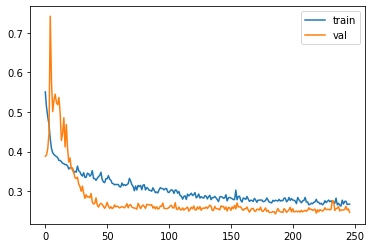

Model: "sequential_502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_502 (Bat (None, 13)                52        
_________________________________________________________________
dense_1917 (Dense)           (None, 40)                560       
_________________________________________________________________
leaky_re_lu_1917 (LeakyReLU) (None, 40)                0         
_________________________________________________________________
dropout_1415 (Dropout)       (None, 40)                0         
_________________________________________________________________
dense_1918 (Dense)           (None, 39)                1599      
_________________________________________________________________
leaky_re_lu_1918 (LeakyReLU) (None, 39)                0         
_________________________________________________________________
dropout_1416 (Dropout)       (None, 39)             

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Mildred_Lake_2_H2S.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/Milkdlake_H2S_OUT.h5'
model_NN.save(precovid_model )

[0.34228721 0.30105539]
RMSE
[0.74224541]
R2
0.37972475595693234


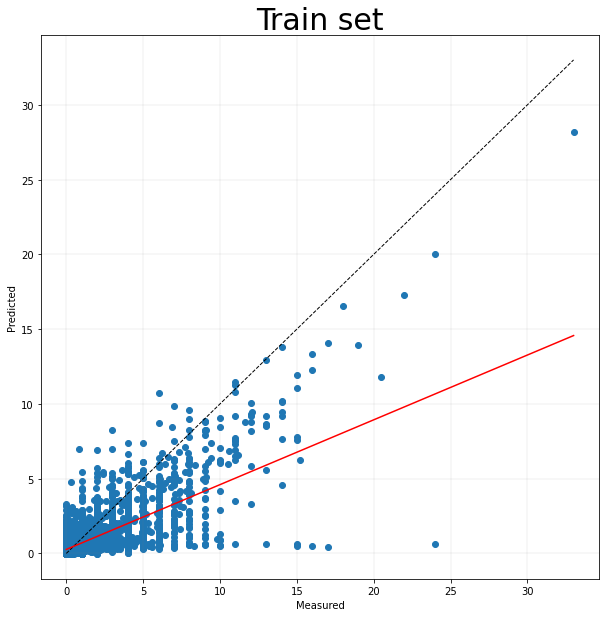

[0.43337094 0.26691549]
RMSE
[0.68829079]
R2
0.5019654705458882


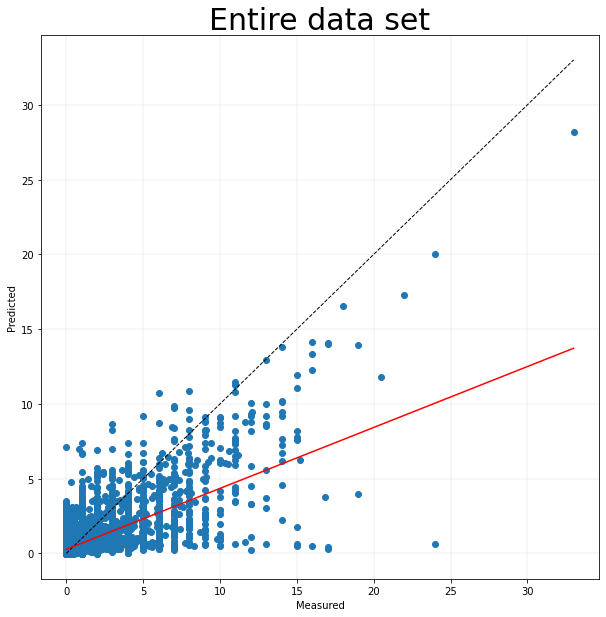

[0.40733718 0.27656806]
RMSE
[0.70491149]
R2
0.46702750028095397


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_502 (Bat (None, 13)                52        
_________________________________________________________________
dense_1917 (Dense)           (None, 40)                560       
_________________________________________________________________
leaky_re_lu_1917 (LeakyReLU) (None, 40)                0         
_________________________________________________________________
dropout_1415 (Dropout)       (None, 40)                0         
_________________________________________________________________
dense_1918 (Dense)           (None, 39)                1599      
_________________________________________________________________
leaky_re_lu_1918 (LeakyReLU) (None, 39)                0         
_________________________________________________________________
dropout_1416 (Dropout)       (None, 39)             

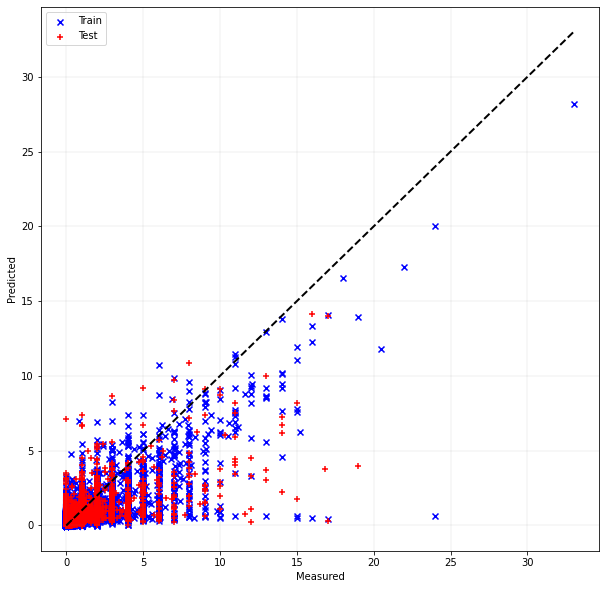

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

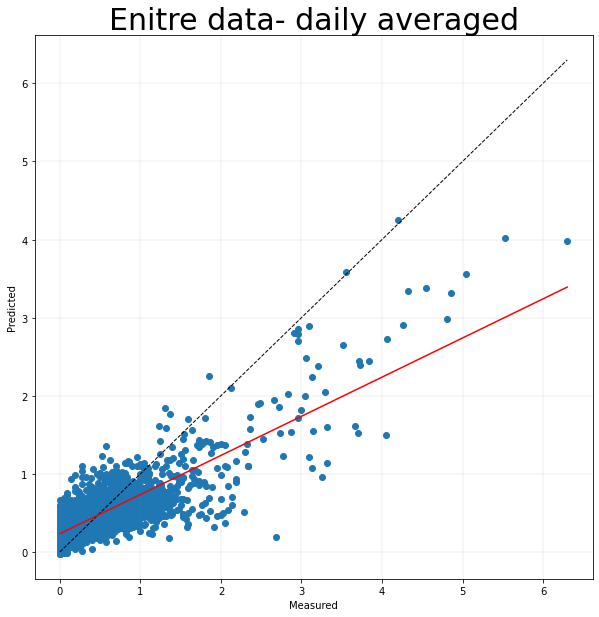

[0.50119488 0.23326544]
RMSE
[0.33461272]
R2
0.6225590795983875


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10[aa]).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

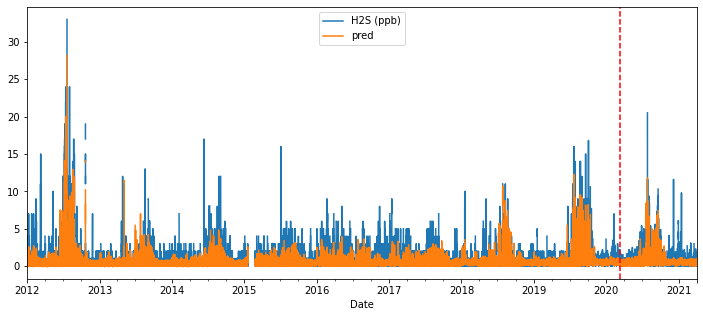

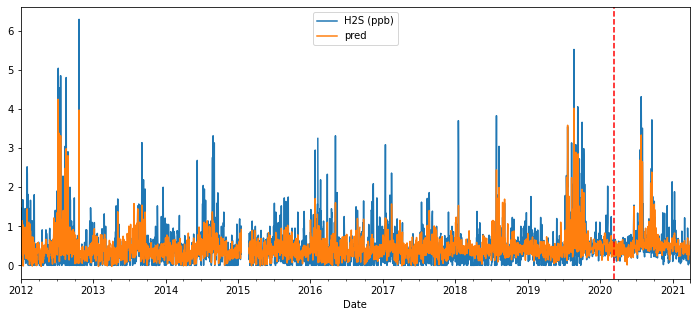

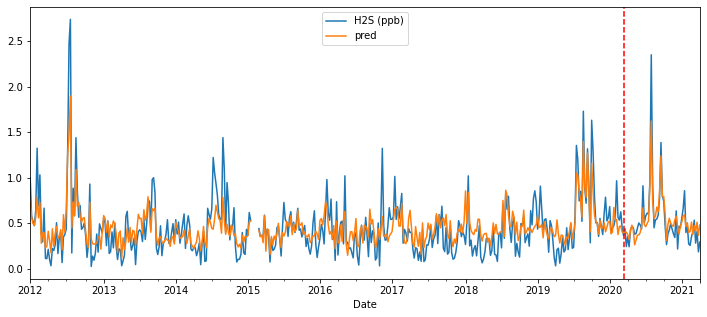

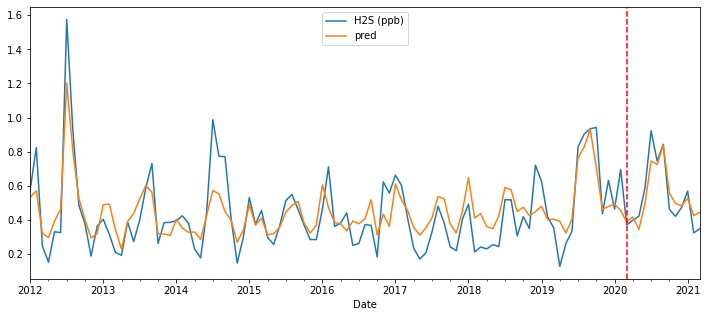

In [ ]:
df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[0.68829079]
0.5019654705458882


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[0.74224541]
0.37972475595693234


In [ ]:
df4.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_H2S_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/MildredLake_H2S_NN_OR_Test.csv')

[0.68829079]
0.5019654705458882
[0.74224541]
0.37972475595693234


In [ ]:
df4.columns

Index(['H2S (ppb)', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Humidity Inst. (%)', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)',
       'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
# df4_D = df4_h.resample('D').mean()
# df4_M = df4_h.resample('M').mean()
# df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO2_hourly_pred.csv')
# df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO_monthly_pred.csv')

In [ ]:
# df4_h[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
# df4_h['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
# plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df4

H2S (ppb)  T ( C)  ...      trend      pred
Date                                    ...                     
2012-01-01 00:00:00        3.0    -9.6  ...  12.000000  0.620134
2012-01-01 03:00:00        2.0   -10.7  ...  12.000342  0.599998
2012-01-01 04:00:00        1.0   -12.1  ...  12.000455  0.746173
2012-01-01 05:00:00        1.0   -12.7  ...  12.000569  0.738918
2012-01-01 06:00:00        0.0   -13.5  ...  12.000683  0.584372
...                        ...     ...  ...        ...       ...
2021-03-31 19:00:00        0.1     4.2  ...  21.245332  0.494951
2021-03-31 20:00:00        0.1     3.0  ...  21.245446  0.466256
2021-03-31 21:00:00        0.0     4.4  ...  21.245560  0.448226
2021-03-31 22:00:00        0.0     4.9  ...  21.245674  0.469349
2021-03-31 23:00:00        0.0     3.7  ...  21.245788  0.463568

[68691 rows x 15 columns]

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
236
0.4977286159992218
2021-01-12 09:00:00
239
0.48884090781211853
2021-01-12 10:00:00
224
0.4886041581630707
2021-01-12 11:00:00
218
0.49867773056030273
2021-01-12 12:00:00
223
0.5024433732032776
2021-01-12 13:00:00
222
0.4906412959098816
2021-01-12 14:00:00
220
0.5007089376449585
2021-01-12 15:00:00
228
0.508729100227356
2021-01-12 16:00:00
231
0.49495068192481995
2021-01-12 17:00:00
240
0.4835508167743683
2021-01-12 18:00:00
239
0.49402475357055664
2021-01-12 19:00:00
244
0.4799349308013916
2021-01-12 20:00:00
243
0.47948458790779114
2021-01-12 21:00:00
245
0.47188547253608704
2021-01-12 22:00:00
245
0.4685148596763611
2021-01-12 23:00:00
242
0.4792616665363312
2021-01-13 02:00:00
99
0.5157615542411804
2021-01-13 03:00:00
198
0.5040757060050964
2021-01-13 04:00:00
203
0.5019692778587341
2021-01-13 05:00:00
203
0.4939720928668976
2021-01-13 06:00:00
233
0.4908440113067627
2021-01-13 07:00:00
252
0.485921710729599
2021-01-13 08:00:00


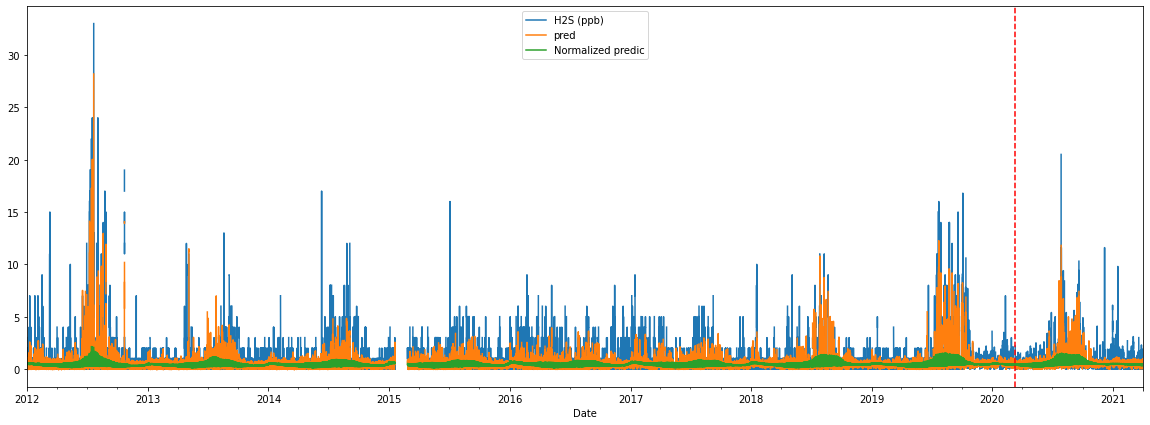

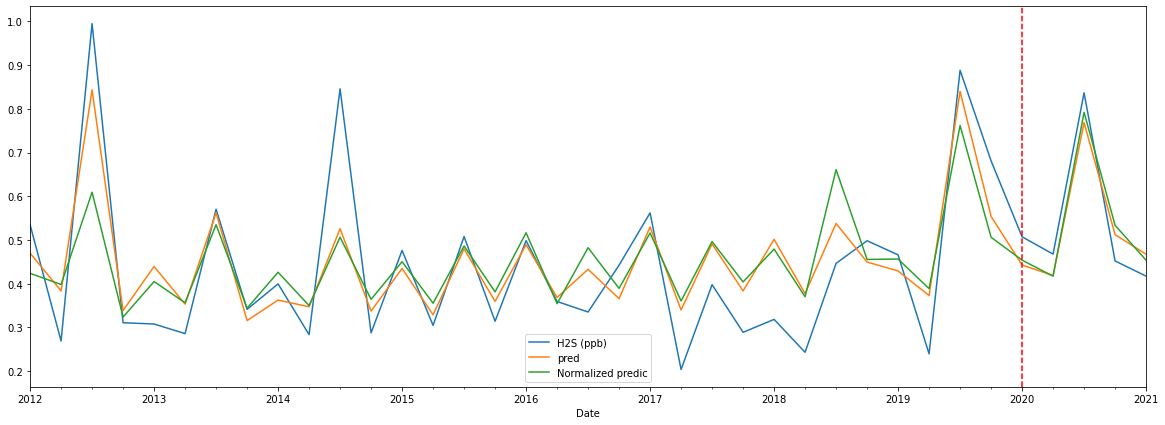

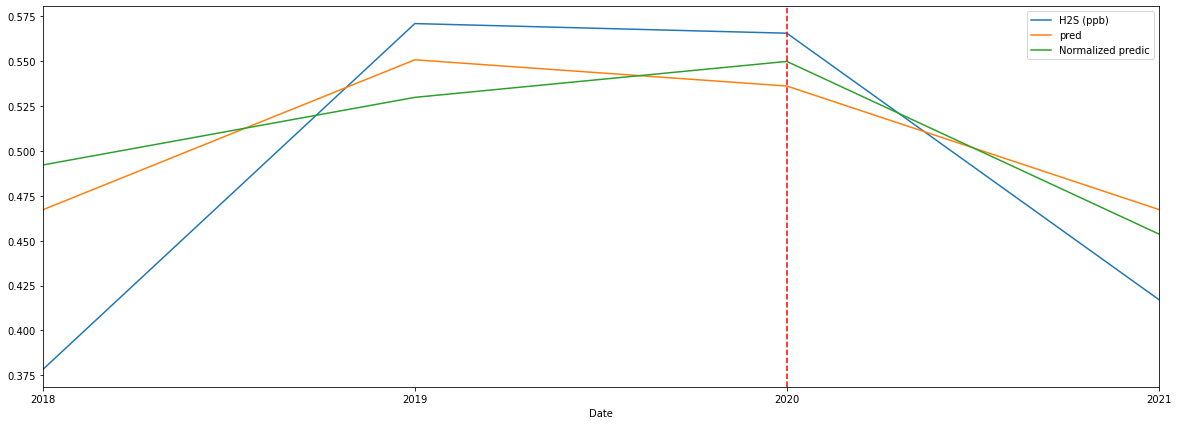

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_H2S_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_H2S_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_MildredLake_H2S_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

df4_h[aa].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate


df2_w_c = df2_w[[ 'CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend',
       'driving', 'transit','walking',
]]
df2_w_c.columns

Index(['CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'driving', 'transit',
       'walking'],
      dtype='object')

In [ ]:
df2_w_c[['driving', 'transit', 'walking']]=df2_w_c[['driving', 'transit', 'walking']]/100

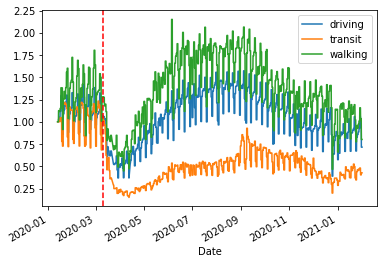

In [ ]:
df2_w_c[['driving', 'transit', 'walking']].plot()
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
a = df2_w_c[['driving', 'transit', 'walking']].loc[:'2020-03-11'].copy()
a.mean()

driving    1.124019
transit    1.025378
walking    1.331329
dtype: float64

In [ ]:
Y_a = df2_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df2_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df2_w_c[ ['driving', 'transit', 'walking']])


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
print(np.shape(X_a),np.shape(X_b),np.shape(Y_a))

(9075, 12) (9075, 3) (9075, 1)


In [ ]:
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
print(np.shape(X_train_a),np.shape(X_train_b))
print(np.shape(X_traine_a),np.shape(X_traine_b))
print(np.shape(X_val_a),np.shape(X_val_b))

(7260, 12) (7260, 3)
(5445, 12) (5445, 3)
(1815, 12) (1815, 3)


In [ ]:
best_params

{'batchsize': 2500.0,
 'drop_out1': 0.0057066589968766,
 'drop_out2': 0.008999530008727568,
 'drop_out3': 0.0006990849923195847,
 'layers': 3,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 24,
 'num_dense_nodes3': 28}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 35)                455       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0

In [ ]:
class Objective2(object):
    def __init__(self, X_a,X_b, Y, max_epochs, learn_rate_epochs,
                  ):
        self.X_train_a, self.X_test_a, self.y_train_a, self.y_test_a = train_test_split(X_a, Y, test_size=0.001, random_state=42)
        self.X_train_b, self.X_test_b, self.y_train_b, self.y_test_b = train_test_split(X_b, Y, test_size=0.001, random_state=42)

        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.model_fixed = load_model(precovid_model)
        for i in range(0,len(self.model_fixed.layers)):
            self.model_fixed.layers[i].trainable = False

    def __call__(self, trial):        
        dict_params = { 
                        'last_layer' :trial.suggest_int('last_layer',0,1),
                        'two_layer' :trial.suggest_int('two_layer',0,1),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 1,3),
                       'num_dense_nodes2': trial.suggest_int('num_dense_nodes2', 1,8),
                        # 'layers': trial.suggest_int('layers', 2,3),
                       'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,2000,100)),
                      #  'drop_out1': trial.suggest_float('drop_out1',0.0, 0.2),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                       'layer_back' :-(trial.suggest_int('layer_back', 1,2)),
                       }  
        # print(dict_params[ 'layer_back'])
        l1 = Input(shape=(3,))
        l1_2 = BatchNormalization()(l1)
        l2 = Dense(dict_params['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
        l2_2 = LeakyReLU(alpha=dict_params['alpha'])(l2)
        if dict_params['two_layer'] ==1 :
             l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_3])
        else :
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_2])
        merged2 = BatchNormalization()(merged)

        if dict_params['last_layer'] == 0:
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)

        if dict_params['last_layer'] == 1:
            l5 = Dense(dict_params['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
            l5_1 = LeakyReLU(alpha=dict_params['alpha'])(l5)
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)          
        
        model = Model(inputs=[self.model_fixed.input,l1], outputs=l5_3)

        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params['learning_rate'])
        model.compile(loss='mse',optimizer=opt)
        fn2 = "gdrive/My Drive/Colab Notebooks/Stations/East_ED_NOX_apple" +str(trial.number) + ".ckpt" 
        fnn2 = os.path.dirname(fn2)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn2, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 

        for train_index, test_index in kf.split( self.X_train_a):   
                X_tr_a, X_tes_a =  self.X_train_a[train_index],  self.X_train_a[test_index]
                X_tr_b, X_tes_b =  self.X_train_b[train_index],  self.X_train_b[test_index]
                y_tr, y_tes =   self.y_train_a[train_index],   self.y_train_a[test_index]    
                # fit the model
                X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split( X_tr_a,  y_tr, test_size=0.12, random_state = 42)
                X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split( X_tr_b,  y_tr, test_size=0.12, random_state = 42)


                model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=dict_params['batchsize'],
                  epochs=self.max_epochs,
                  shuffle=True, verbose=0,
                  callbacks=callbacks_list)
                
                model.load_weights(fn2)
                preds = model.predict([X_tes_a,X_tes_b]) 
                # print(np.shape(y_tes),np.shape( preds))
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 
        print(acc)
        return acc    

In [ ]:
objective2 = Objective2(X_a, X_b ,Y_a ,maximum_epochs, learning_rate_epochs)
study2 = optuna.create_study(direction=optimizer_direction, study_name='east_edm_CO_p2',storage='sqlite:///east_edm_CO_p2.db',load_if_exists=True)
study2.optimize(objective2, n_trials=300)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/CO_Edmonton_east_Hyperparams_Stations.csv')
study2.best_trial

[I 2021-04-18 06:37:44,453] A new study created in RDB with name: east_edm_CO_p2
[I 2021-04-18 06:40:22,320] Trial 0 finished with value: 0.0047897337392556185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 3, 'batchsize': 1300.0, 'learning_rate': 0.08684742896034063, 'alpha': 0.47486431649895633, 'layer_back': 1}. Best is trial 0 with value: 0.0047897337392556185.


0.0047897337392556185


[I 2021-04-18 06:46:17,741] Trial 1 finished with value: 0.0037995427144006185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 200.0, 'learning_rate': 0.026645640165432177, 'alpha': 0.2464432589680267, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0037995427144006185


[I 2021-04-18 06:49:06,028] Trial 2 finished with value: 0.004990117939045318 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1200.0, 'learning_rate': 0.04246052710121524, 'alpha': 0.14036321226448864, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.004990117939045318


[I 2021-04-18 06:51:38,749] Trial 3 finished with value: 0.004435081840883617 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.08019349670014007, 'alpha': 0.801795208357617, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004435081840883617


[I 2021-04-18 06:55:41,325] Trial 4 finished with value: 0.004397006773851628 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 400.0, 'learning_rate': 0.0922021495386216, 'alpha': 0.8714206976745991, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004397006773851628


[I 2021-04-18 06:58:39,803] Trial 5 finished with value: 0.004472224808431502 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 1, 'batchsize': 900.0, 'learning_rate': 0.054032085513753485, 'alpha': 0.36356263089297863, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004472224808431502


[I 2021-04-18 07:02:19,968] Trial 6 finished with value: 0.004032658481373844 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 500.0, 'learning_rate': 0.0034103388646587085, 'alpha': 0.8298599523597091, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004032658481373844


[I 2021-04-18 07:04:57,913] Trial 7 finished with value: 0.004412881161440907 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1400.0, 'learning_rate': 0.024560851403922612, 'alpha': 0.8657303593335849, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004412881161440907


[I 2021-04-18 07:07:33,362] Trial 8 finished with value: 0.003962766007027832 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1600.0, 'learning_rate': 0.0387484515918348, 'alpha': 0.5935061142207385, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.003962766007027832


[I 2021-04-18 07:10:45,080] Trial 9 finished with value: 0.004464174746733434 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 700.0, 'learning_rate': 0.07156430296741274, 'alpha': 0.6837562117270939, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004464174746733434


[I 2021-04-18 07:20:10,927] Trial 10 finished with value: 0.0047593223285363065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.006393597974084786, 'alpha': 0.09784392044369339, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.0047593223285363065


[I 2021-04-18 07:22:40,517] Trial 11 finished with value: 0.0038559859859853907 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 4, 'batchsize': 1900.0, 'learning_rate': 0.029641261114048665, 'alpha': 0.3455488342982123, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0038559859859853907


[I 2021-04-18 07:25:12,650] Trial 12 finished with value: 0.0037802072596256108 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 2000.0, 'learning_rate': 0.021318248161901757, 'alpha': 0.27421676161966496, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.0037802072596256108


[I 2021-04-18 07:34:39,100] Trial 13 finished with value: 0.003838305552608133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.01618259930894679, 'alpha': 0.2237909588852787, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.003838305552608133


[I 2021-04-18 07:37:13,171] Trial 14 finished with value: 0.0037727934709037452 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 1600.0, 'learning_rate': 0.05463156741271952, 'alpha': 0.023432883667647286, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.0037727934709037452


[I 2021-04-18 07:39:46,194] Trial 15 finished with value: 0.004717376020706112 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.057774493852787316, 'alpha': 0.013468966566860257, 'layer_back': 1}. Best is trial 14 with value: 0.0037727934709037452.


0.004717376020706112


[I 2021-04-18 07:42:17,141] Trial 16 finished with value: 0.003891606393255513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 4, 'batchsize': 1600.0, 'learning_rate': 0.06483099406582218, 'alpha': 0.048701457819810334, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.003891606393255513


[I 2021-04-18 07:44:50,068] Trial 17 finished with value: 0.003705317767648349 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.042981081545902175, 'alpha': 0.17151924705879706, 'layer_back': 2}. Best is trial 17 with value: 0.003705317767648349.


0.003705317767648349


[I 2021-04-18 07:47:22,992] Trial 18 finished with value: 0.003652074267837431 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043120594200074316, 'alpha': 0.15356515832757994, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003652074267837431


[I 2021-04-18 07:49:56,748] Trial 19 finished with value: 0.004855364207538971 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.03948108446690251, 'alpha': 0.1731767923827432, 'layer_back': 1}. Best is trial 18 with value: 0.003652074267837431.


0.004855364207538971


[I 2021-04-18 07:52:46,818] Trial 20 finished with value: 0.0036661417054684184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.045596783441498825, 'alpha': 0.46487314129271234, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0036661417054684184


[I 2021-04-18 07:55:47,695] Trial 21 finished with value: 0.003772814522212643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.04376219782019011, 'alpha': 0.495381372771252, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003772814522212643


[I 2021-04-18 07:58:33,572] Trial 22 finished with value: 0.0037000579251144777 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03235269324681574, 'alpha': 0.40139723428257024, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037000579251144777


[I 2021-04-18 08:01:16,242] Trial 23 finished with value: 0.0037201394146138406 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.0335829823820747, 'alpha': 0.561915944028579, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037201394146138406


[I 2021-04-18 08:04:15,280] Trial 24 finished with value: 0.0037030372913319023 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.01268992251227287, 'alpha': 0.3938061003278891, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037030372913319023


[I 2021-04-18 08:07:38,080] Trial 25 finished with value: 0.003918046517575021 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.04897050026188292, 'alpha': 0.6753399284001078, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003918046517575021


[I 2021-04-18 08:10:15,782] Trial 26 finished with value: 0.0038008433695184197 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.06522149016140043, 'alpha': 0.42163733919230845, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0038008433695184197


[I 2021-04-18 08:13:05,072] Trial 27 finished with value: 0.0036111388857046787 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.03298839085103375, 'alpha': 0.3150552800923347, 'layer_back': 2}. Best is trial 27 with value: 0.0036111388857046787.


0.0036111388857046787


[I 2021-04-18 08:16:08,056] Trial 28 finished with value: 0.003597443791057043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.04885615301916258, 'alpha': 0.29269304131799223, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.003597443791057043


[I 2021-04-18 08:19:12,662] Trial 29 finished with value: 0.0046809329310916956 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.05995146156015323, 'alpha': 0.30446311601011683, 'layer_back': 1}. Best is trial 28 with value: 0.003597443791057043.


0.0046809329310916956


[I 2021-04-18 08:21:45,673] Trial 30 finished with value: 0.004425357656736 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.0759352310855712, 'alpha': 0.21269011576180244, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.004425357656736


[I 2021-04-18 08:24:37,569] Trial 31 finished with value: 0.0036547160400316313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.049811468875869416, 'alpha': 0.510738346787994, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0036547160400316313


[I 2021-04-18 08:27:52,823] Trial 32 finished with value: 0.0037521087301732345 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.049503947678833926, 'alpha': 0.31735277463906175, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037521087301732345


[I 2021-04-18 08:30:36,307] Trial 33 finished with value: 0.0037683419447327986 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.03290226547777786, 'alpha': 0.5286190169685012, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037683419447327986


[I 2021-04-18 08:33:27,324] Trial 34 finished with value: 0.003597358919918322 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.036818841872599595, 'alpha': 0.12570513379804832, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003597358919918322


[I 2021-04-18 08:37:26,272] Trial 35 finished with value: 0.003661138596451478 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 400.0, 'learning_rate': 0.03671876888449163, 'alpha': 0.08397801305678194, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003661138596451478


[I 2021-04-18 08:40:27,101] Trial 36 finished with value: 0.00359203525150731 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.02437141103670945, 'alpha': 0.12749087727003588, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00359203525150731


[I 2021-04-18 08:43:26,782] Trial 37 finished with value: 0.0036756314419160397 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.018931547569790746, 'alpha': 0.2516407308762111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036756314419160397


[I 2021-04-18 08:48:02,902] Trial 38 finished with value: 0.0036545643870157882 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 300.0, 'learning_rate': 0.02603462599572944, 'alpha': 0.14443719906111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036545643870157882


[I 2021-04-18 08:51:18,641] Trial 39 finished with value: 0.004398658143913983 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.02412418866542985, 'alpha': 0.09261962247455818, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.004398658143913983


[I 2021-04-18 08:54:03,235] Trial 40 finished with value: 0.00366032853048446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 1200.0, 'learning_rate': 0.028075997597257207, 'alpha': 0.20259126107498393, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00366032853048446


[I 2021-04-18 08:57:05,594] Trial 41 finished with value: 0.003674477629447893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.03773808729024592, 'alpha': 0.13311556018712936, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.003674477629447893


[I 2021-04-18 08:59:59,665] Trial 42 finished with value: 0.0036705861586692643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.014115297813961467, 'alpha': 0.28611068588955, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036705861586692643


[I 2021-04-18 09:03:13,164] Trial 43 finished with value: 0.0036713389468197555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.04560695580139573, 'alpha': 0.3437569312771207, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036713389468197555


[I 2021-04-18 09:06:35,814] Trial 44 finished with value: 0.0035783836209078556 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.009070889461271204, 'alpha': 0.13887248911600195, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035783836209078556


[I 2021-04-18 09:09:57,729] Trial 45 finished with value: 0.003673148714195081 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 600.0, 'learning_rate': 0.009253166791610645, 'alpha': 0.2451607156425593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003673148714195081


[I 2021-04-18 09:14:01,355] Trial 46 finished with value: 0.004344271113195811 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 400.0, 'learning_rate': 0.001551960808838477, 'alpha': 0.10569886410992255, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004344271113195811


[I 2021-04-18 09:17:39,621] Trial 47 finished with value: 0.0037050254039840223 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.021082510170567333, 'alpha': 0.0668001215058446, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037050254039840223


[I 2021-04-18 09:20:38,142] Trial 48 finished with value: 0.0036692619534721047 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.007585468046031375, 'alpha': 0.2061475495973082, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036692619534721047


[I 2021-04-18 09:23:49,174] Trial 49 finished with value: 0.004457879746783033 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.03483835282389286, 'alpha': 0.018344801879960376, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004457879746783033


[I 2021-04-18 09:26:34,895] Trial 50 finished with value: 0.0035807581552902102 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03005652498704963, 'alpha': 0.11696356203274105, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035807581552902102


[I 2021-04-18 09:29:21,811] Trial 51 finished with value: 0.0036236342891670654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.09983893132352316, 'alpha': 0.11957067974916365, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036236342891670654


[I 2021-04-18 09:32:02,631] Trial 52 finished with value: 0.0036302435793163423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.02754867420830222, 'alpha': 0.05647608660638647, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036302435793163423


[I 2021-04-18 09:34:44,744] Trial 53 finished with value: 0.003627053068071688 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04005811816852655, 'alpha': 0.17080808493297003, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003627053068071688


[I 2021-04-18 09:37:45,884] Trial 54 finished with value: 0.0036920503523068266 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.017979831294330218, 'alpha': 0.2570823577331828, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036920503523068266


[I 2021-04-18 09:40:36,692] Trial 55 finished with value: 0.003612690295076574 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1000.0, 'learning_rate': 0.029552755284063505, 'alpha': 0.18039366495456732, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003612690295076574


[I 2021-04-18 09:43:40,566] Trial 56 finished with value: 0.004012695527376038 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 800.0, 'learning_rate': 0.022565925713046567, 'alpha': 0.03734236499524329, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004012695527376038


[I 2021-04-18 09:47:16,794] Trial 57 finished with value: 0.003698018600704401 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 500.0, 'learning_rate': 0.05338960509962787, 'alpha': 0.35126328332328843, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003698018600704401


[I 2021-04-18 09:50:04,725] Trial 58 finished with value: 0.003619003598112455 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.011669376031158469, 'alpha': 0.2338658479883975, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003619003598112455


[I 2021-04-18 09:53:02,416] Trial 59 finished with value: 0.0036054917675212707 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.031117560438016202, 'alpha': 0.12690434404626497, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036054917675212707


[I 2021-04-18 09:56:06,738] Trial 60 finished with value: 0.003886966241395085 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.003565187588275332, 'alpha': 0.12617304287730674, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003886966241395085


[I 2021-04-18 09:59:11,214] Trial 61 finished with value: 0.003618826532739045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.03119470670070372, 'alpha': 0.06717581966642143, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003618826532739045


[I 2021-04-18 10:02:02,407] Trial 62 finished with value: 0.0037632189106060355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1000.0, 'learning_rate': 0.04059941279624269, 'alpha': 0.16862336495408595, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037632189106060355


[I 2021-04-18 10:05:19,179] Trial 63 finished with value: 0.003794832132947586 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 700.0, 'learning_rate': 0.036734160746832493, 'alpha': 0.01101319432018788, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003794832132947586


[I 2021-04-18 10:08:20,419] Trial 64 finished with value: 0.003758988776972788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.029855268948976825, 'alpha': 0.4386976096021802, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003758988776972788


[I 2021-04-18 10:11:42,186] Trial 65 finished with value: 0.0035876522982958357 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.024552341120126213, 'alpha': 0.20134794489311997, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035876522982958357


[I 2021-04-18 10:15:04,777] Trial 66 finished with value: 0.0036155628523736184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.016447401975405944, 'alpha': 0.14664495950811754, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036155628523736184


[I 2021-04-18 10:18:40,103] Trial 67 finished with value: 0.0037361543406670638 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.02482879535124779, 'alpha': 0.18911509071408622, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037361543406670638


[I 2021-04-18 10:23:14,465] Trial 68 finished with value: 0.004737399253546576 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 300.0, 'learning_rate': 0.045839207163365064, 'alpha': 0.11572139542681772, 'layer_back': 1}. Best is trial 44 with value: 0.0035783836209078556.


0.004737399253546576


[I 2021-04-18 10:26:17,521] Trial 69 finished with value: 0.0035844609162026856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.021759460493932996, 'alpha': 0.08938362393003896, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035844609162026856


[I 2021-04-18 10:29:40,721] Trial 70 finished with value: 0.003647474821726536 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.020584896822209618, 'alpha': 0.08688700495047245, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003647474821726536


[I 2021-04-18 10:32:40,862] Trial 71 finished with value: 0.0036240235360119194 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.026636013810065286, 'alpha': 0.04460753701062606, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036240235360119194


[I 2021-04-18 10:35:57,924] Trial 72 finished with value: 0.003678997217185063 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 700.0, 'learning_rate': 0.02380154186526011, 'alpha': 0.15140441320203327, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003678997217185063


[I 2021-04-18 10:39:01,596] Trial 73 finished with value: 0.003659856745198834 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.015277005770461548, 'alpha': 0.2178303763286192, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003659856745198834


[I 2021-04-18 10:42:16,571] Trial 74 finished with value: 0.0036399907750272265 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.011408912622706538, 'alpha': 0.10321869296892679, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036399907750272265


[I 2021-04-18 10:45:19,285] Trial 75 finished with value: 0.0037281104148537535 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.035323452421033984, 'alpha': 0.2846749869393032, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037281104148537535


[I 2021-04-18 10:48:06,701] Trial 76 finished with value: 0.00361764726075232 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.018785055346852722, 'alpha': 0.08247223174383175, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.00361764726075232


[I 2021-04-18 10:51:06,829] Trial 77 finished with value: 0.0036951690746862827 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.030036815811613576, 'alpha': 0.15370233117847767, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036951690746862827


[I 2021-04-18 10:53:48,194] Trial 78 finished with value: 0.003591197553125669 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.021596734858180668, 'alpha': 0.19705749126102656, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003591197553125669


[I 2021-04-18 10:56:31,899] Trial 79 finished with value: 0.0036875580454355968 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.004996727049177942, 'alpha': 0.19630957319700593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036875580454355968


[I 2021-04-18 10:59:15,173] Trial 80 finished with value: 0.003672630637413495 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.009725768873874269, 'alpha': 0.23904793658858925, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003672630637413495


[I 2021-04-18 11:02:33,338] Trial 81 finished with value: 0.003608277041588192 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.021177055101469718, 'alpha': 0.13273475258504627, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003608277041588192


[I 2021-04-18 11:05:23,493] Trial 82 finished with value: 0.0035357134156083006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03251063586877488, 'alpha': 0.16601335847048496, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035357134156083006


[I 2021-04-18 11:08:10,650] Trial 83 finished with value: 0.0035800395220561315 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027507014638668944, 'alpha': 0.26952999743969175, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035800395220561315


[I 2021-04-18 11:10:53,530] Trial 84 finished with value: 0.003641285084880817 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.024468913257262442, 'alpha': 0.26941083528596615, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003641285084880817


[I 2021-04-18 11:13:33,120] Trial 85 finished with value: 0.003613639352689042 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.027506935493900007, 'alpha': 0.16554636650660334, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003613639352689042


[I 2021-04-18 11:16:13,848] Trial 86 finished with value: 0.0035454609704569555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034075180962035656, 'alpha': 0.19205737194876213, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035454609704569555


[I 2021-04-18 11:18:54,396] Trial 87 finished with value: 0.0036217548071173097 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.018105506543334197, 'alpha': 0.2172761829124636, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036217548071173097


[I 2021-04-18 11:21:32,202] Trial 88 finished with value: 0.0036196131119005967 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.013644839043071016, 'alpha': 0.18554443324755185, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036196131119005967


[I 2021-04-18 11:24:10,911] Trial 89 finished with value: 0.003572944589854708 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02174303974596932, 'alpha': 0.06885902281378707, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003572944589854708


[I 2021-04-18 11:26:50,606] Trial 90 finished with value: 0.003906346283951516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1500.0, 'learning_rate': 0.03323653174387488, 'alpha': 0.03163285232628042, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003906346283951516


[I 2021-04-18 11:29:31,353] Trial 91 finished with value: 0.003578888868218704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.022580602914511808, 'alpha': 0.06713185538847133, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003578888868218704


[I 2021-04-18 11:32:08,581] Trial 92 finished with value: 0.0035789263141083713 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.021256605621501615, 'alpha': 0.06634621015162126, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035789263141083713


[I 2021-04-18 11:34:49,916] Trial 93 finished with value: 0.003544189206426239 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02748340529865124, 'alpha': 0.07868991239964429, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003544189206426239


[I 2021-04-18 11:37:33,179] Trial 94 finished with value: 0.0035499476797488643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02892486834145689, 'alpha': 0.07221984870581319, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035499476797488643


[I 2021-04-18 11:40:14,572] Trial 95 finished with value: 0.0035273632980514285 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.027834554447690413, 'alpha': 0.06732285000688103, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035273632980514285


[I 2021-04-18 11:42:52,853] Trial 96 finished with value: 0.0036086771352365947 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02637530840203316, 'alpha': 0.05953489610216768, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036086771352365947


[I 2021-04-18 11:45:38,794] Trial 97 finished with value: 0.0035684357428775186 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027517728652115728, 'alpha': 0.07593898838347986, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035684357428775186


[I 2021-04-18 11:48:20,507] Trial 98 finished with value: 0.003583852513729412 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03367874759681739, 'alpha': 0.06942447131849512, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003583852513729412


[I 2021-04-18 11:50:57,066] Trial 99 finished with value: 0.003541288425685317 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.041358766423868744, 'alpha': 0.021920382234198947, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003541288425685317


[I 2021-04-18 11:53:42,845] Trial 100 finished with value: 0.0036243488752047467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04030568364072326, 'alpha': 0.02384229949250582, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036243488752047467


[I 2021-04-18 11:56:21,539] Trial 101 finished with value: 0.003627937411450544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.035398043970041676, 'alpha': 0.03950052041260174, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627937411450544


[I 2021-04-18 11:59:00,418] Trial 102 finished with value: 0.003627126043875543 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03832592467033967, 'alpha': 0.10048283220351684, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627126043875543


[I 2021-04-18 12:01:36,789] Trial 103 finished with value: 0.0035408315369076784 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032256016881253326, 'alpha': 0.07030089565296588, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035408315369076784


[I 2021-04-18 12:04:17,971] Trial 104 finished with value: 0.003566082616285739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04262395762710679, 'alpha': 0.01173160141920479, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003566082616285739


[I 2021-04-18 12:06:58,238] Trial 105 finished with value: 0.0035737931205732376 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04227819138674002, 'alpha': 0.010660044984515019, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035737931205732376


[I 2021-04-18 12:09:32,119] Trial 106 finished with value: 0.0035184089995725617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043629287038235834, 'alpha': 0.010426390915745402, 'layer_back': 2}. Best is trial 106 with value: 0.0035184089995725617.


0.0035184089995725617


[I 2021-04-18 12:12:07,413] Trial 107 finished with value: 0.0034912184906821125 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04304162747051637, 'alpha': 0.044280753511746956, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0034912184906821125


[I 2021-04-18 12:14:44,123] Trial 108 finished with value: 0.0036380100736029142 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046899784330746694, 'alpha': 0.011423731168029368, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036380100736029142


[I 2021-04-18 12:17:20,619] Trial 109 finished with value: 0.0035930917231830005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05312662202242775, 'alpha': 0.04766526633420203, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035930917231830005


[I 2021-04-18 12:19:56,882] Trial 110 finished with value: 0.0035019395412586403 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04297554301809757, 'alpha': 0.03108575464071467, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035019395412586403


[I 2021-04-18 12:22:26,683] Trial 111 finished with value: 0.0035799057324392095 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.042791521010711986, 'alpha': 0.033242351358857565, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035799057324392095


[I 2021-04-18 12:25:01,093] Trial 112 finished with value: 0.003567586631908924 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04188075691123601, 'alpha': 0.012902457195305648, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567586631908924


[I 2021-04-18 12:27:37,137] Trial 113 finished with value: 0.003552786707766206 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04705313553365665, 'alpha': 0.024024393886675065, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003552786707766206


[I 2021-04-18 12:30:14,683] Trial 114 finished with value: 0.0035491374611036066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04792414670441766, 'alpha': 0.04942912887788908, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035491374611036066


[I 2021-04-18 12:32:47,942] Trial 115 finished with value: 0.003934744163417141 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.05138779832449931, 'alpha': 0.7678284116404237, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003934744163417141


[I 2021-04-18 12:35:21,813] Trial 116 finished with value: 0.0035480745063304685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04672929967596791, 'alpha': 0.0543681486748597, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035480745063304685


[I 2021-04-18 12:37:57,950] Trial 117 finished with value: 0.003645209428448006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.058597540974892046, 'alpha': 0.054075814336391005, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003645209428448006


[I 2021-04-18 12:40:31,646] Trial 118 finished with value: 0.003635834268763575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04497558570260886, 'alpha': 0.10395749038880057, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003635834268763575


[I 2021-04-18 12:43:09,338] Trial 119 finished with value: 0.0036447334704852665 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1800.0, 'learning_rate': 0.04781462434994531, 'alpha': 0.04268750205527756, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036447334704852665


[I 2021-04-18 12:45:44,270] Trial 120 finished with value: 0.003567690380984065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.037831602089136926, 'alpha': 0.0894939850401166, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567690380984065


[I 2021-04-18 12:48:19,955] Trial 121 finished with value: 0.0036418865284299482 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.049910163797960434, 'alpha': 0.02265761100617698, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036418865284299482


[I 2021-04-18 12:50:50,152] Trial 122 finished with value: 0.003626350371093418 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04409374352769631, 'alpha': 0.04839758470877351, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003626350371093418


[I 2021-04-18 12:53:25,935] Trial 123 finished with value: 0.004068899031879057 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 1900.0, 'learning_rate': 0.04692551724599392, 'alpha': 0.027164865650236767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004068899031879057


[I 2021-04-18 12:56:09,582] Trial 124 finished with value: 0.003549524306460534 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.05601252997839943, 'alpha': 0.08216270418670965, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003549524306460534


[I 2021-04-18 12:58:52,986] Trial 125 finished with value: 0.0036022166677025626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.051026693295636215, 'alpha': 0.08169432284004574, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036022166677025626


[I 2021-04-18 13:01:25,923] Trial 126 finished with value: 0.0036323884269265395 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05755736475611723, 'alpha': 0.10764012747900042, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036323884269265395


[I 2021-04-18 13:04:06,681] Trial 127 finished with value: 0.0035868803510106743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.06484074739859898, 'alpha': 0.04916233098402338, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035868803510106743


[I 2021-04-18 13:06:48,784] Trial 128 finished with value: 0.003632038891645508 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.05481967090549042, 'alpha': 0.09493718561374137, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632038891645508


[I 2021-04-18 13:09:24,704] Trial 129 finished with value: 0.0036332687347207073 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.06164699827462552, 'alpha': 0.11368639196612304, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036332687347207073


[I 2021-04-18 13:12:02,225] Trial 130 finished with value: 0.0036107090038871685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.031913432524153476, 'alpha': 0.07944764608488178, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036107090038871685


[I 2021-04-18 13:14:37,997] Trial 131 finished with value: 0.003543857849946714 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04047866711207972, 'alpha': 0.03334890991576665, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003543857849946714


[I 2021-04-18 13:17:10,956] Trial 132 finished with value: 0.003614544482168527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03927975006627224, 'alpha': 0.05750478466882326, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003614544482168527


[I 2021-04-18 13:19:52,496] Trial 133 finished with value: 0.0036289459230039846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03602600147397279, 'alpha': 0.03879102885756539, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036289459230039846


[I 2021-04-18 13:22:21,926] Trial 134 finished with value: 0.004397730627210862 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04121745337090514, 'alpha': 0.07727507999023213, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004397730627210862


[I 2021-04-18 13:25:09,682] Trial 135 finished with value: 0.0035954891884910044 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.05591938878661566, 'alpha': 0.011489115255243473, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035954891884910044


[I 2021-04-18 13:27:46,099] Trial 136 finished with value: 0.003632190940638184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04473961188420494, 'alpha': 0.05883472932516892, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632190940638184


[I 2021-04-18 13:30:22,676] Trial 137 finished with value: 0.004797824764292689 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03394020855741806, 'alpha': 0.6177230050734727, 'layer_back': 1}. Best is trial 107 with value: 0.0034912184906821125.


0.004797824764292689


[I 2021-04-18 13:32:54,827] Trial 138 finished with value: 0.0035575625191086686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03925631108791122, 'alpha': 0.02976577533102045, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035575625191086686


[I 2021-04-18 13:35:35,526] Trial 139 finished with value: 0.0037383972180743746 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.02925391477758371, 'alpha': 0.13393207397187767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037383972180743746


[I 2021-04-18 13:38:16,882] Trial 140 finished with value: 0.003617621733455551 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03195637257591547, 'alpha': 0.0947751465706642, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003617621733455551


[I 2021-04-18 13:40:50,663] Trial 141 finished with value: 0.003579242154278799 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0485447382823182, 'alpha': 0.01176858180870248, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003579242154278799


[I 2021-04-18 13:43:25,476] Trial 142 finished with value: 0.0035750086655864273 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.046567743860348884, 'alpha': 0.026818371099279946, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035750086655864273


[I 2021-04-18 13:46:00,498] Trial 143 finished with value: 0.003623829402881311 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03742158374219033, 'alpha': 0.04975293319513799, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003623829402881311


[I 2021-04-18 13:48:38,218] Trial 144 finished with value: 0.0036066806414085484 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05148602571649974, 'alpha': 0.010300864640383572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036066806414085484


[I 2021-04-18 13:51:09,839] Trial 145 finished with value: 0.003610979298586066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.043772802510158214, 'alpha': 0.07001141819525372, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003610979298586066


[I 2021-04-18 13:53:44,355] Trial 146 finished with value: 0.0035619962671982527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04082403791540483, 'alpha': 0.035248606443724864, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035619962671982527


[I 2021-04-18 13:56:26,877] Trial 147 finished with value: 0.003548864702878114 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04862893209367515, 'alpha': 0.11504554485639235, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003548864702878114


[I 2021-04-18 13:59:07,487] Trial 148 finished with value: 0.0036127803252306075 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034866037784612974, 'alpha': 0.15803031484071783, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036127803252306075


[I 2021-04-18 14:01:52,630] Trial 149 finished with value: 0.0035717142472204513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04905384303207223, 'alpha': 0.11415311920269179, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035717142472204513


[I 2021-04-18 14:04:32,812] Trial 150 finished with value: 0.0035749882689068164 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04526973875676865, 'alpha': 0.14572957071712894, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035749882689068164


[I 2021-04-18 14:07:16,399] Trial 151 finished with value: 0.0035993304069324022 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.052491361045237814, 'alpha': 0.08397349335013253, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035993304069324022


[I 2021-04-18 14:09:58,621] Trial 152 finished with value: 0.0035685056911281127 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04837346606791395, 'alpha': 0.06310254703879091, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035685056911281127


[I 2021-04-18 14:12:29,525] Trial 153 finished with value: 0.003629879513305761 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0438214208862195, 'alpha': 0.10403865238259322, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003629879513305761


[I 2021-04-18 14:15:14,227] Trial 154 finished with value: 0.0036221795403482207 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03029487512047642, 'alpha': 0.04348614544060133, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036221795403482207


[I 2021-04-18 14:17:57,080] Trial 155 finished with value: 0.0035922583407074988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.03843837268200991, 'alpha': 0.08433177217864488, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035922583407074988


[I 2021-04-18 14:20:36,152] Trial 156 finished with value: 0.003578072413719791 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.046367859672450995, 'alpha': 0.12254720867272155, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003578072413719791


[I 2021-04-18 14:23:15,649] Trial 157 finished with value: 0.0038583845758324883 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0871450624590979, 'alpha': 0.056755344230540905, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0038583845758324883


[I 2021-04-18 14:25:52,255] Trial 158 finished with value: 0.003580582397543033 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.041182684797758676, 'alpha': 0.031335914276621774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003580582397543033


[I 2021-04-18 14:28:31,244] Trial 159 finished with value: 0.003571554999049949 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.050511120203456654, 'alpha': 0.011355553310716315, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003571554999049949


[I 2021-04-18 14:31:10,768] Trial 160 finished with value: 0.0035740442082979025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1300.0, 'learning_rate': 0.054629022232272034, 'alpha': 0.09769506994297086, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035740442082979025


[I 2021-04-18 14:33:46,785] Trial 161 finished with value: 0.0035316717327896836 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03947842688021926, 'alpha': 0.02587334876105694, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035316717327896836


[I 2021-04-18 14:36:22,973] Trial 162 finished with value: 0.003583261784611461 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0426931007941171, 'alpha': 0.06941424492182441, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003583261784611461


[I 2021-04-18 14:38:56,920] Trial 163 finished with value: 0.0035638605296477717 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03698103592588202, 'alpha': 0.02604575458608599, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035638605296477717


[I 2021-04-18 14:41:34,556] Trial 164 finished with value: 0.0036057247992290833 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.033843190233136235, 'alpha': 0.054628128789041205, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036057247992290833


[I 2021-04-18 14:44:05,291] Trial 165 finished with value: 0.0036577139832949667 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.02862847367159879, 'alpha': 0.041190982009615476, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036577139832949667


[I 2021-04-18 14:46:34,411] Trial 166 finished with value: 0.0035796291367728578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.03989602686737119, 'alpha': 0.07720076451956273, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035796291367728578


[I 2021-04-18 14:48:58,970] Trial 167 finished with value: 0.003644684403214736 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.031894620734671836, 'alpha': 0.011244612673171901, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003644684403214736


[I 2021-04-18 14:51:15,955] Trial 168 finished with value: 0.003719212403160626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.061535654734255804, 'alpha': 0.04944139280228774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003719212403160626


[I 2021-04-18 14:53:47,133] Trial 169 finished with value: 0.003569251268532048 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04736210238892834, 'alpha': 0.0924816749854882, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003569251268532048


[I 2021-04-18 14:56:10,412] Trial 170 finished with value: 0.0037302293516410364 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 1800.0, 'learning_rate': 0.042194509368665326, 'alpha': 0.026662365080105572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037302293516410364


[I 2021-04-18 14:58:32,142] Trial 171 finished with value: 0.003412203995094343 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003412203995094343


[I 2021-04-18 15:00:56,204] Trial 172 finished with value: 0.003615212962045835 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.035269743884066396, 'alpha': 0.06515792117672077, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003615212962045835


[I 2021-04-18 15:03:19,432] Trial 173 finished with value: 0.0035065927685166407 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04495904398462532, 'alpha': 0.03706846553808014, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035065927685166407


[I 2021-04-18 15:05:42,080] Trial 174 finished with value: 0.0036824767911479953 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.044788002773288774, 'alpha': 0.04279176989414291, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036824767911479953


[I 2021-04-18 15:07:59,615] Trial 175 finished with value: 0.0036000802274304988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03973925069572923, 'alpha': 0.06946943028331976, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036000802274304988


[I 2021-04-18 15:10:20,601] Trial 176 finished with value: 0.0035611477676499243 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03702719792209683, 'alpha': 0.1178740272614942, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035611477676499243


[I 2021-04-18 15:12:44,718] Trial 177 finished with value: 0.0035568862168302313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04446509916080676, 'alpha': 0.035536762139547574, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035568862168302313


[I 2021-04-18 15:15:03,641] Trial 178 finished with value: 0.0035634161691522025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.02555669877180687, 'alpha': 0.01426667868106541, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035634161691522025


[I 2021-04-18 15:17:27,644] Trial 179 finished with value: 0.0035478477954239184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.041044999411233324, 'alpha': 0.05809175905373737, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035478477954239184


[I 2021-04-18 15:19:49,604] Trial 180 finished with value: 0.003577680895181763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04266781899508782, 'alpha': 0.057332493065063835, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577680895181763


[I 2021-04-18 15:22:18,574] Trial 181 finished with value: 0.0037241810267514214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04124794281390582, 'alpha': 0.08344018331911048, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0037241810267514214


[I 2021-04-18 15:24:42,413] Trial 182 finished with value: 0.003574937953275326 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03909174129413975, 'alpha': 0.04955591990925821, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574937953275326


[I 2021-04-18 15:27:09,745] Trial 183 finished with value: 0.0035062207386055725 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032919202764146074, 'alpha': 0.10296721914045874, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035062207386055725


[I 2021-04-18 15:29:33,614] Trial 184 finished with value: 0.003607310672142692 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03299384364237505, 'alpha': 0.13543758486151475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003607310672142692


[I 2021-04-18 15:31:56,820] Trial 185 finished with value: 0.0035645622965729045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.036200243037322145, 'alpha': 0.10015962959305305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035645622965729045


[I 2021-04-18 15:34:23,869] Trial 186 finished with value: 0.0035128649499357135 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04591334979902456, 'alpha': 0.01300643385682445, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035128649499357135


[I 2021-04-18 15:36:50,059] Trial 187 finished with value: 0.003512579959993758 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.045967118012657425, 'alpha': 0.02955287318190126, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512579959993758


[I 2021-04-18 15:39:17,519] Trial 188 finished with value: 0.003601852298015445 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04515211154273283, 'alpha': 0.02414511899844717, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003601852298015445


[I 2021-04-18 15:41:44,658] Trial 189 finished with value: 0.003551257039072739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.043685650639080496, 'alpha': 0.011272541261604586, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003551257039072739


[I 2021-04-18 15:44:08,778] Trial 190 finished with value: 0.0035124462407048578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04088523362317096, 'alpha': 0.027965921768034883, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035124462407048578


[I 2021-04-18 15:46:32,527] Trial 191 finished with value: 0.0036034748711966606 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04059492734596064, 'alpha': 0.0316931464485652, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036034748711966606


[I 2021-04-18 15:48:52,857] Trial 192 finished with value: 0.0035462040161388982 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038480226797782575, 'alpha': 0.013080349410333715, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035462040161388982


[I 2021-04-18 15:51:15,074] Trial 193 finished with value: 0.003514729419201148 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038804046086792734, 'alpha': 0.01722318588576137, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003514729419201148


[I 2021-04-18 15:53:39,774] Trial 194 finished with value: 0.003530635344402702 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038022625191625484, 'alpha': 0.010260560665283323, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003530635344402702


[I 2021-04-18 15:56:01,357] Trial 195 finished with value: 0.0036120263950969846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.037603653740255726, 'alpha': 0.010350360726464305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036120263950969846


[I 2021-04-18 15:58:21,259] Trial 196 finished with value: 0.0035517522803226497 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03532284563567649, 'alpha': 0.012252207673505294, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035517522803226497


[I 2021-04-18 16:00:42,685] Trial 197 finished with value: 0.0035774729128351572 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03851591509172416, 'alpha': 0.024592933498452187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035774729128351572


[I 2021-04-18 16:03:10,397] Trial 198 finished with value: 0.0036300873338133174 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03161093718448926, 'alpha': 0.011231732922341914, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036300873338133174


[I 2021-04-18 16:05:32,864] Trial 199 finished with value: 0.003594899268962292 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03400517384369343, 'alpha': 0.010987625678645163, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594899268962292


[I 2021-04-18 16:07:55,556] Trial 200 finished with value: 0.003507502110225467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03903066389229184, 'alpha': 0.03436414346888904, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003507502110225467


[I 2021-04-18 16:10:20,454] Trial 201 finished with value: 0.0035410174116621788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0385769119015159, 'alpha': 0.03980816279456982, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035410174116621788


[I 2021-04-18 16:12:45,074] Trial 202 finished with value: 0.003500324891873184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042028674607372564, 'alpha': 0.035300834875109204, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003500324891873184


[I 2021-04-18 16:15:09,269] Trial 203 finished with value: 0.0035591510309502424 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04246721082689016, 'alpha': 0.03438254597895686, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035591510309502424


[I 2021-04-18 16:17:27,832] Trial 204 finished with value: 0.0035809591968109468 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03985309920583796, 'alpha': 0.03051312835022787, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035809591968109468


[I 2021-04-18 16:19:46,336] Trial 205 finished with value: 0.0035329556853449626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04302937726174949, 'alpha': 0.041497953561731075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035329556853449626


[I 2021-04-18 16:22:06,046] Trial 206 finished with value: 0.0035995980573277605 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042934896863311735, 'alpha': 0.039304783000125264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035995980573277605


[I 2021-04-18 16:24:23,248] Trial 207 finished with value: 0.0036285669261463425 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04139101863112104, 'alpha': 0.04261236299648191, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036285669261463425


[I 2021-04-18 16:26:41,935] Trial 208 finished with value: 0.0035261087563540814 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.036838583737843406, 'alpha': 0.010914683684806366, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035261087563540814


[I 2021-04-18 16:28:57,689] Trial 209 finished with value: 0.0036736991070403626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03673113267779741, 'alpha': 0.01411948992981912, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036736991070403626


[I 2021-04-18 16:31:14,218] Trial 210 finished with value: 0.003515510628468558 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0375123413072075, 'alpha': 0.026801330195408788, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003515510628468558


[I 2021-04-18 16:33:31,616] Trial 211 finished with value: 0.0036619003719104474 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03820623138649496, 'alpha': 0.010153124386418449, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036619003719104474


[I 2021-04-18 16:35:49,042] Trial 212 finished with value: 0.003602818230449912 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03959580915067272, 'alpha': 0.027499310441006536, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003602818230449912


[I 2021-04-18 16:38:08,801] Trial 213 finished with value: 0.003561704765028999 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03612046104363647, 'alpha': 0.044035880327440075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003561704765028999


[I 2021-04-18 16:40:34,504] Trial 214 finished with value: 0.003592007871833824 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04370049977603333, 'alpha': 0.02920150412919489, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592007871833824


[I 2021-04-18 16:42:55,087] Trial 215 finished with value: 0.00351462664371098 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454740119732067, 'alpha': 0.010495159169710357, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00351462664371098


[I 2021-04-18 16:45:14,094] Trial 216 finished with value: 0.003586321240898763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04511581530325534, 'alpha': 0.05695382241574087, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003586321240898763


[I 2021-04-18 16:47:33,201] Trial 217 finished with value: 0.003550850628097577 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046083333365054775, 'alpha': 0.010031182438903608, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003550850628097577


[I 2021-04-18 16:49:49,786] Trial 218 finished with value: 0.003574316805279423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03776962442231015, 'alpha': 0.01087974243831754, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574316805279423


[I 2021-04-18 16:52:07,807] Trial 219 finished with value: 0.003592576788837446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04233420788943894, 'alpha': 0.044863914777429736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592576788837446


[I 2021-04-18 16:54:23,320] Trial 220 finished with value: 0.0035791068843512115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03540338546231751, 'alpha': 0.06466753594289008, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035791068843512115


[I 2021-04-18 16:56:45,624] Trial 221 finished with value: 0.0035080006628703977 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04080187257128169, 'alpha': 0.02517051340915846, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035080006628703977


[I 2021-04-18 16:59:10,209] Trial 222 finished with value: 0.003534858951378764 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.039077436368116635, 'alpha': 0.02885009674334453, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003534858951378764


[I 2021-04-18 17:01:32,489] Trial 223 finished with value: 0.0035600183170591336 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04037327285207486, 'alpha': 0.010218259695493757, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035600183170591336


[I 2021-04-18 17:03:59,538] Trial 224 finished with value: 0.00357621728770453 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04402809698710642, 'alpha': 0.030946556782538822, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00357621728770453


[I 2021-04-18 17:06:22,498] Trial 225 finished with value: 0.004343070192053122 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04210862734231485, 'alpha': 0.8978062302113005, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004343070192053122


[I 2021-04-18 17:08:42,266] Trial 226 finished with value: 0.00348994671120034 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.039712978464816924, 'alpha': 0.024397619671189186, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348994671120034


[I 2021-04-18 17:10:59,711] Trial 227 finished with value: 0.0036327829172039363 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03987289215731558, 'alpha': 0.02250455655984187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036327829172039363


[I 2021-04-18 17:13:17,616] Trial 228 finished with value: 0.0035863816006844592 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.045535379101367554, 'alpha': 0.01124262972279364, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035863816006844592


[I 2021-04-18 17:15:35,516] Trial 229 finished with value: 0.003724723343216221 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03704451183437776, 'alpha': 0.04707960454629442, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003724723343216221


[I 2021-04-18 17:17:56,682] Trial 230 finished with value: 0.003542300775869218 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043373142611203674, 'alpha': 0.027741305329135237, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003542300775869218


[I 2021-04-18 17:20:22,682] Trial 231 finished with value: 0.0034967214164662516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.0413254155114597, 'alpha': 0.05450900763386603, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034967214164662516


[I 2021-04-18 17:22:44,729] Trial 232 finished with value: 0.0034902379436158775 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04068791995954499, 'alpha': 0.010222168909410259, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034902379436158775


[I 2021-04-18 17:25:06,837] Trial 233 finished with value: 0.0035696997278384553 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04139126758896274, 'alpha': 0.026033995263578885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035696997278384553


[I 2021-04-18 17:27:27,456] Trial 234 finished with value: 0.0035369994402819037 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03942127208063995, 'alpha': 0.04286247942073264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035369994402819037


[I 2021-04-18 17:29:47,698] Trial 235 finished with value: 0.004392673197272246 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04159869114156704, 'alpha': 0.02367062769838194, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004392673197272246


[I 2021-04-18 17:32:05,575] Trial 236 finished with value: 0.003575454952037897 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04328736011313493, 'alpha': 0.05601924009082433, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003575454952037897


[I 2021-04-18 17:34:26,141] Trial 237 finished with value: 0.0035897550318074005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.038692258908575666, 'alpha': 0.012438389557101647, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035897550318074005


[I 2021-04-18 17:36:45,489] Trial 238 finished with value: 0.0035113323695952704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04512252439416322, 'alpha': 0.03956753671308763, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035113323695952704


[I 2021-04-18 17:39:05,122] Trial 239 finished with value: 0.003584000428339544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.047813674417420904, 'alpha': 0.010920917339477658, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003584000428339544


[I 2021-04-18 17:41:26,047] Trial 240 finished with value: 0.0035293567432161024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04591099537879329, 'alpha': 0.04788686542870845, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035293567432161024


[I 2021-04-18 17:43:44,806] Trial 241 finished with value: 0.0035365143888050027 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454319059745853, 'alpha': 0.04686285373530562, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035365143888050027


[I 2021-04-18 17:46:08,022] Trial 242 finished with value: 0.0035210658084785856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.046339728963809036, 'alpha': 0.010471024026785167, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035210658084785856


[I 2021-04-18 17:48:29,934] Trial 243 finished with value: 0.003556893132441123 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.045764190567635574, 'alpha': 0.011848043731819085, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003556893132441123


[I 2021-04-18 17:50:53,782] Trial 244 finished with value: 0.003512689556017564 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04972302364098935, 'alpha': 0.010679543273126932, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512689556017564


[I 2021-04-18 17:53:13,307] Trial 245 finished with value: 0.0035453134197271506 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04959138720064781, 'alpha': 0.05462870622434733, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035453134197271506


[I 2021-04-18 17:55:33,896] Trial 246 finished with value: 0.0035509187170758008 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04681538132569639, 'alpha': 0.03530358983480915, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035509187170758008


[I 2021-04-18 17:57:53,468] Trial 247 finished with value: 0.0035945304744609613 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0489170612101526, 'alpha': 0.012016072897793495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035945304744609613


[I 2021-04-18 18:00:12,340] Trial 248 finished with value: 0.003594461041794751 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044638671537672245, 'alpha': 0.0639759181815157, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594461041794751


[I 2021-04-18 18:02:34,344] Trial 249 finished with value: 0.0045477205315565955 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046710061525816006, 'alpha': 0.011139267598519425, 'layer_back': 1}. Best is trial 171 with value: 0.003412203995094343.


0.0045477205315565955


[I 2021-04-18 18:04:55,855] Trial 250 finished with value: 0.0035781031672798575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.049944254157000614, 'alpha': 0.032012199626475495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035781031672798575


[I 2021-04-18 18:07:13,728] Trial 251 finished with value: 0.0036355280457136927 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043756771131670855, 'alpha': 0.01035371316557724, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036355280457136927


[I 2021-04-18 18:09:34,549] Trial 252 finished with value: 0.003547550522620159 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04134146453588229, 'alpha': 0.04305486485387794, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003547550522620159


[I 2021-04-18 18:11:55,090] Trial 253 finished with value: 0.0035328942806100686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04722011354069931, 'alpha': 0.05887719313144072, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035328942806100686


[I 2021-04-18 18:14:16,245] Trial 254 finished with value: 0.0035652527257973646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04440826933940222, 'alpha': 0.025686391422111023, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035652527257973646


[I 2021-04-18 18:16:33,284] Trial 255 finished with value: 0.0036024245892215994 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.041749163700951185, 'alpha': 0.03872395194163038, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036024245892215994


[I 2021-04-18 18:18:57,458] Trial 256 finished with value: 0.0043164087416414365 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 1700.0, 'learning_rate': 0.04546093492413028, 'alpha': 0.010251060844410263, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0043164087416414365


[I 2021-04-18 18:21:15,604] Trial 257 finished with value: 0.003591252456109896 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04784028159113087, 'alpha': 0.39811980716193374, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003591252456109896


[I 2021-04-18 18:23:37,528] Trial 258 finished with value: 0.003746425212177314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1500.0, 'learning_rate': 0.04279841819460297, 'alpha': 0.07024407706968394, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003746425212177314


[I 2021-04-18 18:25:58,122] Trial 259 finished with value: 0.00361357732181617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05159560529990878, 'alpha': 0.01020152753447857, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00361357732181617


[I 2021-04-18 18:28:18,035] Trial 260 finished with value: 0.0035362959446181372 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03677053865341993, 'alpha': 0.027761419825134706, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035362959446181372


[I 2021-04-18 18:30:36,058] Trial 261 finished with value: 0.0035777906284825637 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.040310822965333726, 'alpha': 0.049462864350921475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035777906284825637


[I 2021-04-18 18:32:57,401] Trial 262 finished with value: 0.003570475495003743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044139009615794325, 'alpha': 0.027875323408408682, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003570475495003743


[I 2021-04-18 18:35:16,566] Trial 263 finished with value: 0.003522829834462358 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04198898881507155, 'alpha': 0.0580045705131251, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003522829834462358


[I 2021-04-18 18:37:34,064] Trial 264 finished with value: 0.0036007924735055267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.041834497824705524, 'alpha': 0.06335278451503193, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036007924735055267


[I 2021-04-18 18:39:53,735] Trial 265 finished with value: 0.00348047469245996 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046222652876472946, 'alpha': 0.07368192148073911, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348047469245996


[I 2021-04-18 18:42:12,703] Trial 266 finished with value: 0.003568839741377355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04374559623977401, 'alpha': 0.08301680728880435, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003568839741377355


[I 2021-04-18 18:44:32,571] Trial 267 finished with value: 0.0036106532294807115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04856506403341819, 'alpha': 0.059921462082078616, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036106532294807115


[I 2021-04-18 18:46:54,806] Trial 268 finished with value: 0.0035951168812917724 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04059449904679494, 'alpha': 0.07437962110547948, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035951168812917724


[I 2021-04-18 18:49:14,594] Trial 269 finished with value: 0.0038806843614589267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1800.0, 'learning_rate': 0.04228778414610149, 'alpha': 0.040595160927241594, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038806843614589267


[I 2021-04-18 18:51:36,459] Trial 270 finished with value: 0.003508514168830134 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.045758882185338856, 'alpha': 0.01019736087977181, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003508514168830134


[I 2021-04-18 18:53:59,279] Trial 271 finished with value: 0.003553706935151663 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046600657692945004, 'alpha': 0.010547895437206084, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003553706935151663


[I 2021-04-18 18:56:21,879] Trial 272 finished with value: 0.0035704764601707352 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05043397257419762, 'alpha': 0.02650206841715339, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035704764601707352


[I 2021-04-18 18:58:44,313] Trial 273 finished with value: 0.003537743421816448 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04449406510721561, 'alpha': 0.02856531842383624, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003537743421816448


[I 2021-04-18 19:01:02,888] Trial 274 finished with value: 0.0035872021893232162 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04642553813259407, 'alpha': 0.04624146580754622, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035872021893232162


[I 2021-04-18 19:03:22,574] Trial 275 finished with value: 0.0035351187876377214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04065895930001007, 'alpha': 0.023704805099300657, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035351187876377214


[I 2021-04-18 19:05:42,370] Trial 276 finished with value: 0.0035990310487486314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04867882801126025, 'alpha': 0.04208190753853736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035990310487486314


[I 2021-04-18 19:08:03,409] Trial 277 finished with value: 0.003558197358314823 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043930643367720706, 'alpha': 0.013485130866568936, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003558197358314823


[I 2021-04-18 19:10:23,407] Trial 278 finished with value: 0.0035541437503373557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04255502288658978, 'alpha': 0.011078767415770078, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035541437503373557


[I 2021-04-18 19:12:43,428] Trial 279 finished with value: 0.003620482810610077 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03854967804178356, 'alpha': 0.37579417109166946, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003620482810610077


[I 2021-04-18 19:15:07,358] Trial 280 finished with value: 0.0035629539820494893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04529240827319963, 'alpha': 0.05895876175064578, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035629539820494893


[I 2021-04-18 19:17:32,667] Trial 281 finished with value: 0.003644936734817557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.04743933522020218, 'alpha': 0.011229961339488842, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003644936734817557


[I 2021-04-18 19:19:51,695] Trial 282 finished with value: 0.003577890922236646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03634827316862001, 'alpha': 0.03637036111412592, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577890922236646


[I 2021-04-18 19:22:13,904] Trial 283 finished with value: 0.003560479118491405 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04043227290610643, 'alpha': 0.07344504222599207, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003560479118491405


[I 2021-04-18 19:24:43,874] Trial 284 finished with value: 0.0035526678878083024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043180320438559995, 'alpha': 0.028436472804207344, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035526678878083024


[I 2021-04-18 19:27:15,410] Trial 285 finished with value: 0.0036757146176305084 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.052504334338170644, 'alpha': 0.05281089842190032, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036757146176305084


[I 2021-04-18 19:29:40,892] Trial 286 finished with value: 0.0036856981873373005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03862798538332946, 'alpha': 0.5490775185484104, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036856981873373005


[I 2021-04-18 19:32:06,610] Trial 287 finished with value: 0.0035415069069481627 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04570583980728427, 'alpha': 0.02605355475095221, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035415069069481627


[I 2021-04-18 19:34:30,143] Trial 288 finished with value: 0.003740877917673408 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04190653811523166, 'alpha': 0.46924555745458885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003740877917673408


[I 2021-04-18 19:36:56,774] Trial 289 finished with value: 0.0035775193145280654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03972018828716774, 'alpha': 0.011138839350697517, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035775193145280654


[I 2021-04-18 19:39:20,105] Trial 290 finished with value: 0.003692058852467178 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.034729016394914915, 'alpha': 0.010556512764700383, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003692058852467178


[I 2021-04-18 19:41:44,804] Trial 291 finished with value: 0.0035475416741049203 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.049954519743499, 'alpha': 0.04441757839268543, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035475416741049203


[I 2021-04-18 19:44:12,704] Trial 292 finished with value: 0.0036324451159960094 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04430093709294941, 'alpha': 0.010225541250839246, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036324451159960094


[I 2021-04-18 19:46:36,967] Trial 293 finished with value: 0.003543922988091805 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03731682739206002, 'alpha': 0.061919915711980765, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003543922988091805


[I 2021-04-18 19:49:00,478] Trial 294 finished with value: 0.0035996695672530763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0481214227016496, 'alpha': 0.036533457449013804, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035996695672530763


[I 2021-04-18 19:51:28,050] Trial 295 finished with value: 0.00356117903500133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04215437992851492, 'alpha': 0.08474282494115523, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00356117903500133


[I 2021-04-18 19:53:54,926] Trial 296 finished with value: 0.0038629873621217974 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04644820116770873, 'alpha': 0.7525864522902106, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038629873621217974


[I 2021-04-18 19:56:15,892] Trial 297 finished with value: 0.0036611473822737274 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04033473569538667, 'alpha': 0.050588041390175045, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036611473822737274


[I 2021-04-18 19:58:46,046] Trial 298 finished with value: 0.0035034252484806043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04324237328637403, 'alpha': 0.026717366574066884, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035034252484806043


[I 2021-04-18 20:01:13,035] Trial 299 finished with value: 0.003613095679125333 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04407463674017211, 'alpha': 0.06965159817543136, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003613095679125333


FrozenTrial(number=171, values=[0.003412203995094343], datetime_start=datetime.datetime(2021, 4, 18, 14, 56, 10, 420979), datetime_complete=datetime.datetime(2021, 4, 18, 14, 58, 32, 108827), params={'alpha': 0.02422528261030567, 'batchsize': 1800.0, 'last_layer': 1, 'layer_back': 2, 'learning_rate': 0.03982358083063548, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'two_layer': 0}, distributions={'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=2000.0, low=100.0, q=100.0), 'last_layer': IntUniformDistribution(high=1, low=0, step=1), 'layer_back': IntUniformDistribution(high=2, low=1, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'num_dense_nodes1': IntUniformDistribution(high=3, low=1, step=1), 'num_dense_nodes2': IntUniformDistribution(high=8, low=1, step=1), 'two_layer': IntUniformDistribution(high=1, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=172, state=TrialState.COMPLETE, v

In [ ]:
best_params2={'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 
              'num_dense_nodes2': 8, 'batchsize': 1800.0,
              'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}
              #  Best is trial 171 with value: 0.003412203995094343
best_params2['layer_back']=-best_params2['layer_back'] 

In [ ]:
# study2.best_params

In [ ]:
best_params2

{'alpha': 0.02422528261030567,
 'batchsize': 1800.0,
 'last_layer': 1,
 'layer_back': -2,
 'learning_rate': 0.03982358083063548,
 'num_dense_nodes1': 3,
 'num_dense_nodes2': 8,
 'two_layer': 0}

Epoch 1/450
4/4 - 1s - loss: 0.0410 - val_loss: 0.0159
Epoch 2/450
4/4 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 3/450
4/4 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 4/450
4/4 - 0s - loss: 0.0078 - val_loss: 0.0097
Epoch 5/450
4/4 - 0s - loss: 0.0074 - val_loss: 0.0086
Epoch 6/450
4/4 - 0s - loss: 0.0080 - val_loss: 0.0084
Epoch 7/450
4/4 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 8/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 9/450
4/4 - 0s - loss: 0.0051 - val_loss: 0.0071
Epoch 10/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 11/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/450
4/4 - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 13/450
4/4 - 0s - loss: 0.0046 - val_loss: 0.0064
Epoch 14/450
4/4 - 0s - loss: 0.0047 - val_loss: 0.0065
Epoch 15/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 16/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0062
Epoch 17/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 18/450
4/4 - 0s - loss: 0.0044 - val_loss: 0.0065
E

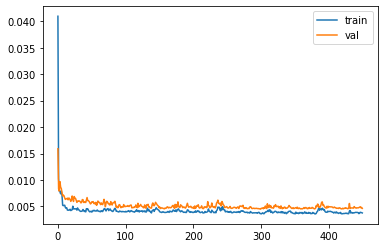

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_input (Inpu [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          batch_normalization_input[0][0]  
__________________________________________________________________________________________________
dense (Dense)                   (None, 35)           455         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 35)           0           dense[0][0]                      
______________________________________________________________________________________________

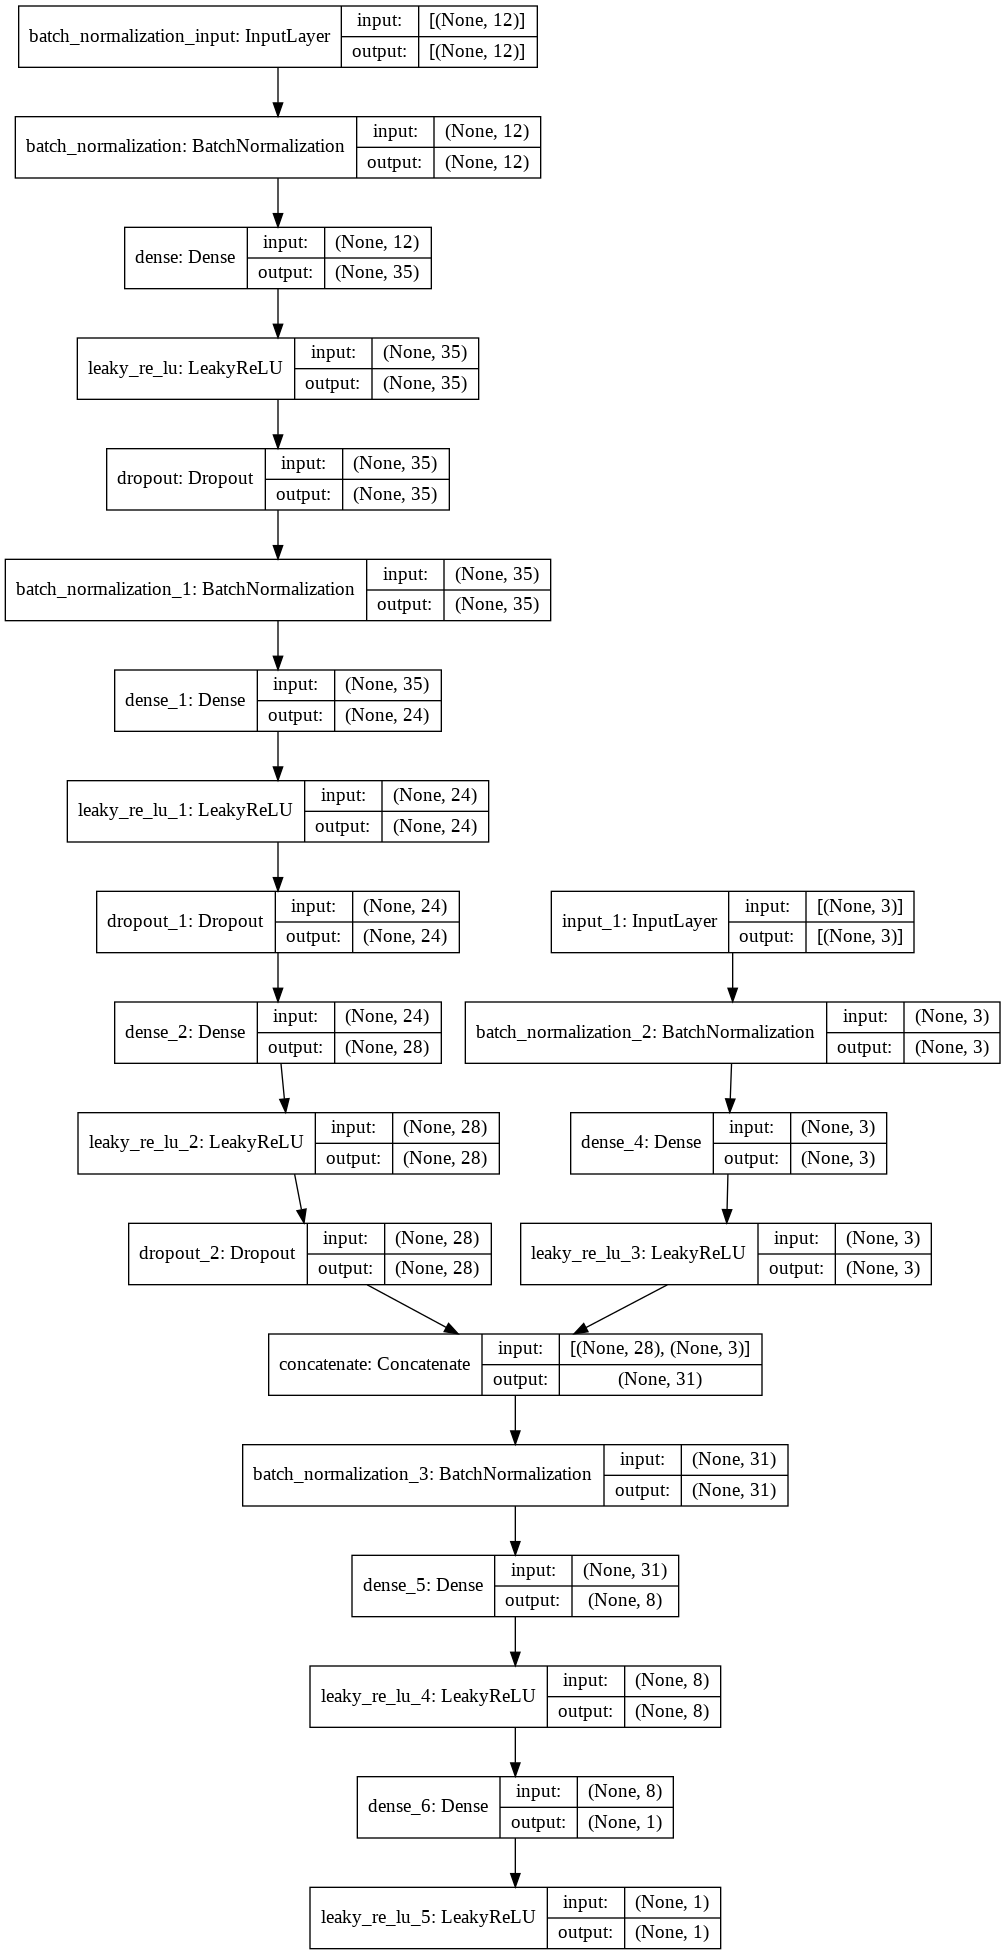

In [ ]:
model_fixed = load_model(precovid_model)
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

for i in range(0,len(model_fixed.layers)):
  model_fixed.layers[i].trainable = False

l1 = Input(shape=(3,))
l1_2 = BatchNormalization()(l1)
l2 = Dense(best_params2['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
l2_2 = LeakyReLU(alpha=best_params2['alpha'])(l2)
if best_params2['two_layer'] ==1 :
      l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_3])
else :
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_2])
merged2 = BatchNormalization()(merged)

if best_params2['last_layer'] ==0:
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)

if best_params2['last_layer'] ==1:
    l5 = Dense(best_params2['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
    l5_1 = LeakyReLU(alpha=best_params2['alpha'])(l5)
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)          

model = Model(inputs=[model_fixed.input,l1], outputs=l5_3)

opt = keras.optimizers.Adam(learning_rate=best_params2['learning_rate'])
model.compile(loss='mse',optimizer=opt)
fn_f = "gdrive/My Drive/Colab Notebooks/Stations/Training_CO_aftercovid.ckpt" 
fnn_f = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer

callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn_f, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=int(best_params2['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.load_weights(fn_f )
model.save('gdrive/My Drive/Colab Notebooks/Model_Edmonton_east_after_Covid.h5')
preds = model.predict([X_test_a,X_test_b]) 
y_real = y_test_a.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

model.load_weights(fn_f)
preds = model.predict([X_train_a,X_train_b]) 
y_real_t = y_train_a.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
model.load_weights(fn_f)
preds = model.predict([X_a,X_b]) 
y_real_to = Y_a.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

[0.42761824 0.12493499]
RMSE
[0.06297126]
R2
0.42194653306663965


[0.45061179 0.11989867]
RMSE
[0.06110412]
R2
0.47311888956403503


[0.4461315  0.12088052]
RMSE
[0.06148209]
R2
0.4631478722431982


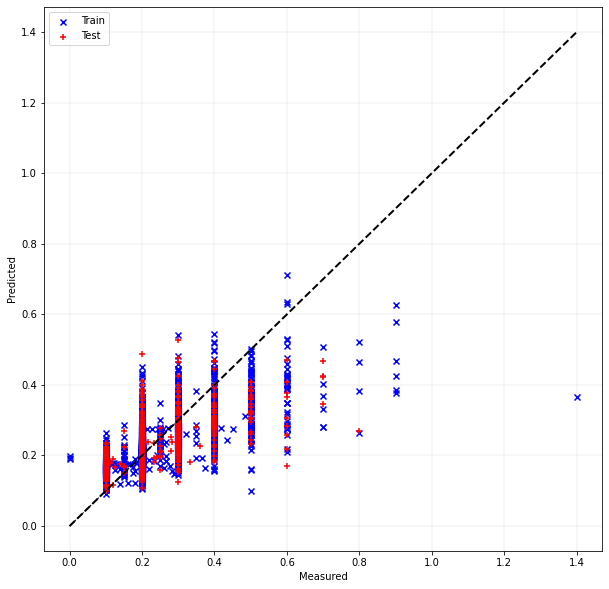

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.3], [0,0.3], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


In [ ]:
df2_w_c

CO(ppm)  T( C)  RH(%)  ...  driving  transit  walking
Date                                        ...                           
2020-01-13 00:00:00      0.1  -25.4   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 01:00:00      0.1  -25.7   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 02:00:00      0.1  -25.8   66.0  ...   1.0000   1.0000   1.0000
2020-01-13 03:00:00      0.1  -25.8   65.0  ...   1.0000   1.0000   1.0000
2020-01-13 04:00:00      0.1  -26.0   65.0  ...   1.0000   1.0000   1.0000
...                      ...    ...    ...  ...      ...      ...      ...
2021-01-31 19:00:00      0.4  -15.5   76.0  ...   0.7143   0.4266   0.8011
2021-01-31 20:00:00      0.4  -15.4   78.0  ...   0.7143   0.4266   0.8011
2021-01-31 21:00:00      0.2  -15.5   79.0  ...   0.7143   0.4266   0.8011
2021-01-31 22:00:00      0.2  -16.3   80.0  ...   0.7143   0.4266   0.8011
2021-01-31 23:00:00      0.2  -16.7   81.0  ...   0.7143   0.4266   0.8011

[9075 rows x 16 columns]

In [ ]:
# df3= df3.copy()
df4 = df2_w_c.copy()
df4['pred'] = model.predict([X_a,X_b])
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

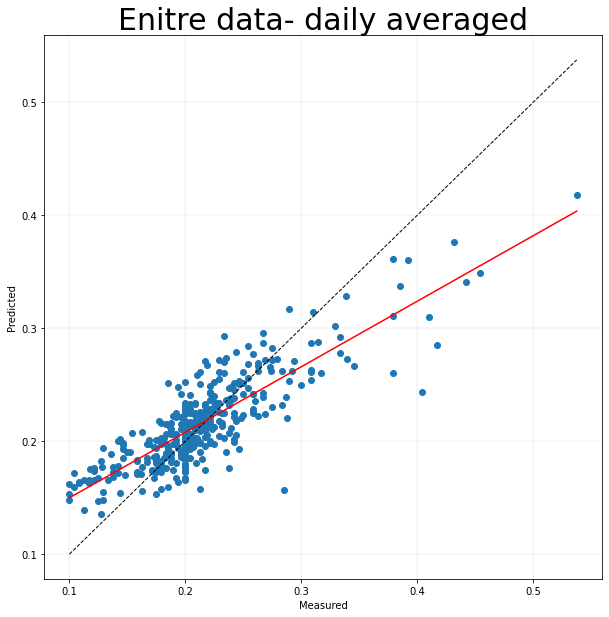

[0.57997188 0.09186987]
RMSE
[0.03240749]
R2
0.6798581783938966


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['CO(ppm)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


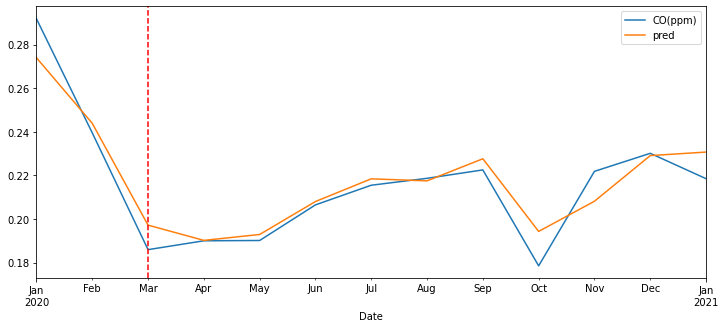

In [ ]:
df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df3_w_c = df2_w_c.copy()
df3_w_c['driving'] = 1.124019
df3_w_c['transit']  = 1.025378
df3_w_c['walking'] = 1.331329

In [ ]:
Y_a = df3_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df3_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df3_w_c[ ['driving', 'transit', 'walking']])




X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
# df3= df3.copy()
df44 = df3_w_c.copy()
df44['No lockdown'] = model.predict([X_a,X_b])
df104 = df44.resample('D').mean()
df104.dropna(inplace= True)

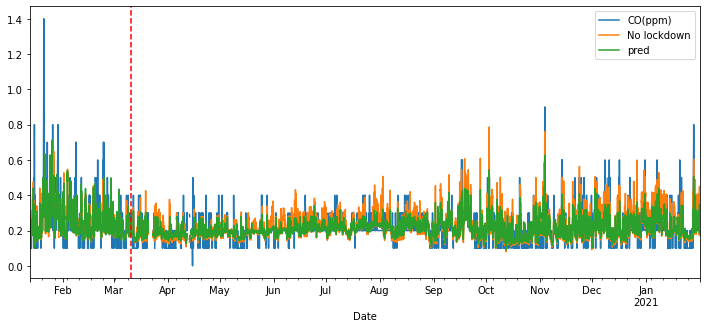

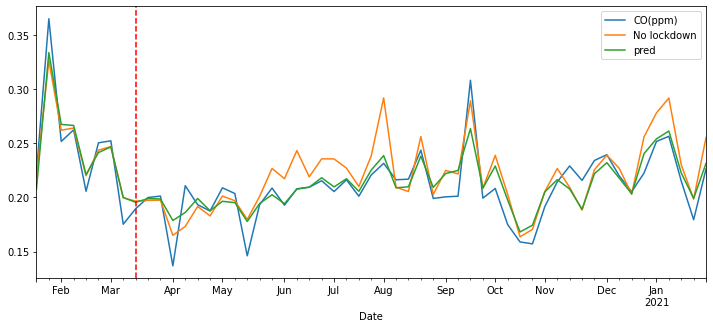

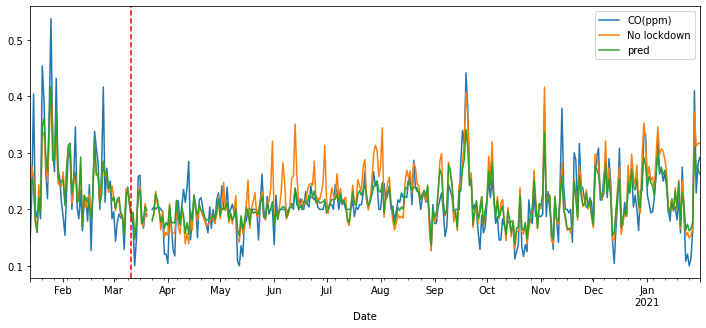

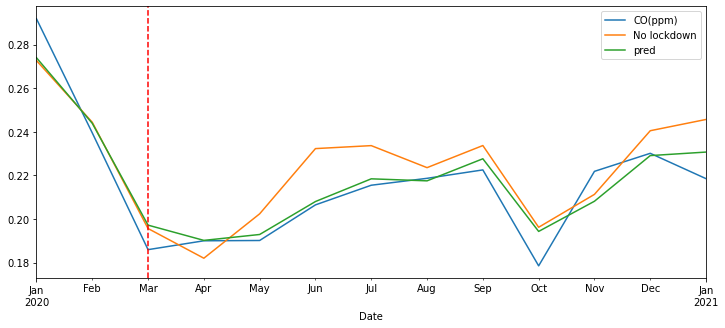

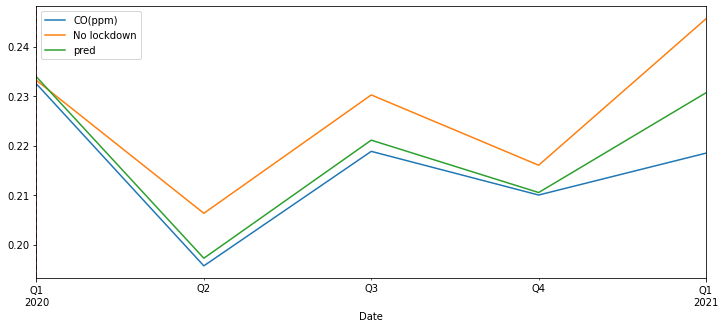

In [ ]:


df4['CO(ppm)'].resample('H').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('H').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('W').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('W').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()
df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('Q').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4['No lockdown']=df44['No lockdown'].copy()
print('No lockdown:',df4['No lockdown'].mean())
print('pred:',df4['pred'].mean())
print('CO(ppm):',df4['CO(ppm)'].mean())

No lockdown: 0.22312191128730774
pred: 0.2163834571838379
CO(ppm): 0.21406886884590973


In [ ]:
df4.head()

CO(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                        ...                                
2020-01-13 00:00:00      0.1  -25.4   68.0  ...      1.0  0.144256     0.140617
2020-01-13 01:00:00      0.1  -25.7   68.0  ...      1.0  0.154986     0.151347
2020-01-13 02:00:00      0.1  -25.8   66.0  ...      1.0  0.158600     0.154960
2020-01-13 03:00:00      0.1  -25.8   65.0  ...      1.0  0.166749     0.168830
2020-01-13 04:00:00      0.1  -26.0   65.0  ...      1.0  0.185634     0.212358

[5 rows x 18 columns]

In [ ]:
df4.to_csv('gdrive/My Drive/Colab Notebooks/Edmonton East/NOX_mobility_aftercov_Edmonton_east-COVID_hourly_pred.csv')

In [ ]:
df4

NOX(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                         ...                                
2020-01-13 00:00:00    0.0084  -25.4   68.0  ...   1.0000  0.012064     0.011699
2020-01-13 01:00:00    0.0078  -25.7   68.0  ...   1.0000  0.015269     0.014904
2020-01-13 02:00:00    0.0053  -25.8   66.0  ...   1.0000  0.015456     0.015090
2020-01-13 03:00:00    0.0050  -25.8   65.0  ...   1.0000  0.018650     0.018285
2020-01-13 04:00:00    0.0069  -26.0   65.0  ...   1.0000  0.023630     0.023264
...                       ...    ...    ...  ...      ...       ...          ...
2021-01-31 19:00:00    0.1137  -15.5   76.0  ...   0.8011  0.037565     0.041811
2021-01-31 20:00:00    0.1007  -15.4   78.0  ...   0.8011  0.024746     0.028993
2021-01-31 21:00:00    0.0515  -15.5   79.0  ...   0.8011  0.019648     0.023895
2021-01-31 22:00:00    0.0502  -16.3   80.0  ...   0.8011  0.030382     0.034629
2021-01-31 23:00:00    0.0408  -16.7   81.0  ...   0.8011  0.025745     0.029992

[9075 rows x 18 columns]